In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
import optuna
# Suppress Optuna logs for cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

In [28]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import numpy as np

def load_and_preprocess_data(file_path, is_train=True):
    """
    Load and preprocess the spaceship titanic data
    
    Args:
        file_path: Path to the CSV file
        is_train: Boolean indicating if this is training data (has 'Transported' column)
    
    Returns:
        Preprocessed dataframe
    """
    df = pd.read_csv(file_path)
    
    # Define categorical features
    categorical_features = ['HomePlanet', 'VIP', 'CryoSleep', 'Destination', 'Cabin', 'Name']
    
    # Handle missing values
    df = handle_missing_values(df, categorical_features)
    
    # Create new features
    df = create_features(df)
    
    # Convert to appropriate data types
    df = convert_data_types(df)
    
    return df

def handle_missing_values(df, categorical_features):
    """Handle missing values for numerical and categorical features"""
    df = df.copy()
    
    # Impute Age by HomePlanet
    if 'Age' in df.columns:
        df['Age'] = df.groupby('HomePlanet')['Age'].transform(
        lambda x: x.fillna(x.median())
    )
    # If still missing, fill with overall median
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    #age_imputer = SimpleImputer()
    #df['Age'] = age_imputer.fit_transform(df[['Age']]).flatten()
    
    # Impute spending columns with most frequent value
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    spent_imputer = SimpleImputer(strategy='most_frequent')
    df[spending_cols] = spent_imputer.fit_transform(df[spending_cols])
    
    # Fill categorical missing values with 'Missing'
    for col in categorical_features:
        df[col] = df[col].fillna('Missing')
    
    return df

def create_features(df):
    """Create engineered features"""
    df = df.copy()
    
    # Extract passenger group from PassengerId
    df['GroupId'] = df['PassengerId'].str.split('_').str[0]
    df['GroupSize'] = df.groupby('GroupId')['GroupId'].transform('count')
    df['IsAlone'] = (df['GroupSize'] == 1).astype(int)
    
    # Spending features
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpend'] = df[spending_cols].sum(axis=1)
    df['LuxurySpend'] = df[['Spa', 'VRDeck']].sum(axis=1)
    df['BasicSpend'] = df[['RoomService', 'FoodCourt']].sum(axis=1)

    # Cabin Split
    cabin_split = df['Cabin'].str.split('/', expand=True)
    df['Deck'] = cabin_split[0]
    df['CabinNum'] = pd.to_numeric(cabin_split[1], errors='coerce').fillna(0)
    df['Side'] = cabin_split[2]
    
    # Cabin-based interaction features
    cabin_prefix = cabin_split[0]
    df['Cabin_HomePlanet'] = cabin_prefix + "_" + df['HomePlanet'].astype(str)
    df['Cabin_Destination'] = cabin_prefix + "_" + df['Destination'].astype(str)
    df['Cabin_CryoSleep'] = cabin_prefix + "_" + df['CryoSleep'].astype(str)
    df['Deck_Side'] = df['Deck'].astype(str) + "_" + df['Side'].astype(str)

    # Other Interaction
    df['CryoSleep_VIP'] = df['CryoSleep'].astype(str) + "_" + df['VIP'].astype(str)
    df['Age_Spending'] = df['Age'] * df['TotalSpend']

    
    return df

def convert_data_types(df):
    """Convert columns to appropriate data types"""
    df = df.copy()
    
    # Convert to categorical
    categorical_cols = ['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'CryoSleep_VIP', 'Deck_Side',
                       'Cabin_HomePlanet', 'Cabin_Destination', 'Cabin_CryoSleep', 'Deck', 'Side']
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
    
    return df

def select_features_and_prepare_target(df, features_to_drop=None, is_train=True):
    """
    Select features and prepare target variable
    
    Args:
        df: Preprocessed dataframe
        features_to_drop: List of additional features to drop
        is_train: Boolean indicating if this is training data
    
    Returns:
        X (features), y (target if train data), feature_names, categorical_features
    """
    df = df.copy()
    
    # Default features to drop
    default_drop = [
        'PassengerId', 'Cabin', 'Name', 'GroupId'
    ]
    
    if features_to_drop:
        default_drop.extend(features_to_drop)
    
    # Remove target variable from features if it exists
    if is_train and 'Transported' in df.columns:
        y = df['Transported']
        default_drop.append('Transported')
    else:
        y = None
    
    # Select features
    X = df.drop(default_drop, axis=1, errors='ignore')
    
    # Get categorical feature names
    categorical_features = X.select_dtypes(include='category').columns.tolist()
    
    return X, y, X.columns.tolist(), categorical_features

def encode_categorical_features(X, categorical_features, encoders=None, fit=True):
    """
    Encode categorical features using LabelEncoder
    
    Args:
        X: Feature dataframe
        categorical_features: List of categorical feature names
        encoders: Dictionary of fitted encoders (for test data)
        fit: Whether to fit new encoders (True for train, False for test)
    
    Returns:
        X_encoded, encoders_dict
    """
    X_encoded = X.copy()
    
    if encoders is None:
        encoders = {}
    
    for col in categorical_features:
        if col in X_encoded.columns:
            X_encoded[col] = X_encoded[col].astype(str)
            
            if fit:
                # Fit new encoder for training data
                le = LabelEncoder()
                X_encoded[col] = le.fit_transform(X_encoded[col])
                encoders[col] = le
            else:
                # Use existing encoder for test data
                if col in encoders:
                    # Handle unseen categories
                    le = encoders[col]
                    mask = X_encoded[col].isin(le.classes_)
                    X_encoded.loc[mask, col] = le.transform(X_encoded.loc[mask, col])
                    X_encoded.loc[~mask, col] = -1  # Assign -1 to unseen categories
                    
                    # Explicitly convert to int64 to match training data
                    X_encoded[col] = X_encoded[col].astype('int64')
                else:
                    # If no encoder exists, assign -1 to all values
                    X_encoded[col] = -1
                    X_encoded[col] = X_encoded[col].astype('int64')
    
    # Ensure all categorical features are properly converted to int64
    for col in categorical_features:
        if col in X_encoded.columns:
            X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce').fillna(-1).astype('int64')
    
    return X_encoded, encoders

# Main pipeline function
def prepare_data(train_path, test_path=None, additional_drops=None):
    """
    Complete pipeline to prepare train and test data
    
    Args:
        train_path: Path to training data
        test_path: Path to test data (optional)
        additional_drops: Additional features to drop
    
    Returns:
        Dictionary containing processed data and encoders
    """
    # Process training data
    print("Processing training data...")
    train_df = load_and_preprocess_data(train_path, is_train=True)
    X_train, y_train, feature_names, cat_features = select_features_and_prepare_target(
        train_df, additional_drops, is_train=True
    )
    X_train_encoded, encoders = encode_categorical_features(
        X_train, cat_features, fit=True
    )
    
    print(f"Training data shape: {X_train_encoded.shape}")
    print(f"Features: {feature_names}")
    print(f"Categorical features: {cat_features}")
    
    result = {
        'X_train': X_train_encoded,
        'y_train': y_train,
        'feature_names': feature_names,
        'categorical_features': cat_features,
        'encoders': encoders
    }
    
    # Process test data if provided
    if test_path:
        print("\nProcessing test data...")
        test_df = load_and_preprocess_data(test_path, is_train=False)
        X_test, _, _, _ = select_features_and_prepare_target(
            test_df, additional_drops, is_train=False
        )
        X_test_encoded, _ = encode_categorical_features(
            X_test, cat_features, encoders=encoders, fit=False
        )
        
        print(f"Test data shape: {X_test_encoded.shape}")
        
        result['X_test'] = X_test_encoded
    
    return result

# Example usage:
if __name__ == "__main__":
    # Data URLs
    train_url = "https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/spaceship_titanic_train.csv"
    test_url = "https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/spaceship_titanic_test.csv"
    X_Passenger_ID = pd.read_csv(test_url)
    
    # You can specify additional features to drop
    additional_features_to_drop = []  # Add any additional features you want to drop
    
    # Process both training and test data
    data = prepare_data(train_url, test_path=test_url, additional_drops=additional_features_to_drop)
    
    # Access the results
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    passenger_ids = X_Passenger_ID["PassengerId"]
    feature_names = data['feature_names']
    categorical_features = data['categorical_features']
    
    print(f"\nFinal training data info:")
    print(X_train.info())
    print(f"\nFinal test data info:")
    print(X_test.info())
    print(f"\nTarget distribution:")
    print(y_train.value_counts())
    print(f"\nFeature consistency check:")
    print(f"Training features: {X_train.shape[1]}")
    print(f"Test features: {X_test.shape[1]}")
    print(f"Feature names match: {list(X_train.columns) == list(X_test.columns)}")
    
    # Additional dtype consistency check
    print(f"\nDtype consistency check:")
    for col in X_train.columns:
        train_dtype = X_train[col].dtype
        test_dtype = X_test[col].dtype
        match = train_dtype == test_dtype
        print(f"{col}: Train({train_dtype}) vs Test({test_dtype}) - Match: {match}")
        if not match:
            print(f"  ⚠️  Dtype mismatch detected!")

Processing training data...
Training data shape: (8693, 24)
Features: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize', 'IsAlone', 'TotalSpend', 'LuxurySpend', 'BasicSpend', 'Deck', 'CabinNum', 'Side', 'Cabin_HomePlanet', 'Cabin_Destination', 'Cabin_CryoSleep', 'Deck_Side', 'CryoSleep_VIP', 'Age_Spending']
Categorical features: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'Cabin_HomePlanet', 'Cabin_Destination', 'Cabin_CryoSleep', 'Deck_Side', 'CryoSleep_VIP']

Processing test data...
Test data shape: (4277, 24)

Final training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HomePlanet         8693 non-null   int64  
 1   CryoSleep          8693 non-null   int64  
 2   Destination        8693 non-null   int64  
 3   A

In [29]:
# ============================================================================
# SEGMENT 2: Baseline XGBoost Model
# ============================================================================

def evaluate_model(X, y, model_params=None, cv_folds=5):
    """Evaluate XGBoost model using cross-validation F1 score"""
    if model_params is None:
        model_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': -1
        }
    
    model = XGBClassifier(**model_params)
    
    # Stratified K-Fold for better evaluation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    
    return f1_scores.mean(), f1_scores.std()

# Baseline model parameters
baseline_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 100
}

print("\n" + "="*50)
print("BASELINE MODEL EVALUATION")
print("="*50)

baseline_f1, baseline_std = evaluate_model(X_train, y_train, baseline_params)
print(f"Baseline F1 Score: {baseline_f1:.4f} (+/- {baseline_std:.4f})")


BASELINE MODEL EVALUATION
Baseline F1 Score: 0.8061 (+/- 0.0094)


In [30]:
# ============================================================================
# SEGMENT 3: Feature Importance Analysis and Selection
# ============================================================================

def get_feature_importance(X, y, model_params):
    """Get feature importance from XGBoost model"""
    model = XGBClassifier(**model_params)
    model.fit(X, y)
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return importance_df, model

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get initial feature importance
importance_df, baseline_model = get_feature_importance(X_train, y_train, baseline_params)
print("Top 10 Most Important Features:")
print(importance_df.head(10))


FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
              feature  importance
1           CryoSleep    0.192150
23       Age_Spending    0.150178
0          HomePlanet    0.118391
18   Cabin_HomePlanet    0.051031
13        LuxurySpend    0.050961
5         RoomService    0.044444
21          Deck_Side    0.039112
15               Deck    0.036275
6           FoodCourt    0.034519
19  Cabin_Destination    0.034290



BAYESIAN OPTIMIZATION FEATURE SELECTION

Starting Bayesian Optimization Feature Selection
Total features: 24
Feature range: 3 to 10
Number of trials: 2000


Best trial: 0. Best value: 0.744357:   0%|     | 1/2000 [00:00<29:18,  1.14it/s]

Trial 0: Features: 6, F1: 0.7444 (+/- 0.0140)


Best trial: 0. Best value: 0.744357:   0%|     | 2/2000 [00:01<29:50,  1.12it/s]

Trial 1: Features: 5, F1: 0.6305 (+/- 0.0126)


Best trial: 2. Best value: 0.744737:   0%|     | 3/2000 [00:02<31:13,  1.07it/s]

Trial 2: Features: 10, F1: 0.7447 (+/- 0.0098)


Best trial: 2. Best value: 0.744737:   0%|     | 4/2000 [00:03<29:34,  1.13it/s]

Trial 3: Features: 4, F1: 0.7283 (+/- 0.0086)


Best trial: 4. Best value: 0.769102:   0%|     | 5/2000 [00:04<28:43,  1.16it/s]

Trial 4: Features: 6, F1: 0.7691 (+/- 0.0071)


Best trial: 4. Best value: 0.769102:   0%|     | 6/2000 [00:05<27:57,  1.19it/s]

Trial 5: Features: 7, F1: 0.7394 (+/- 0.0064)


Best trial: 4. Best value: 0.769102:   0%|     | 7/2000 [00:06<27:46,  1.20it/s]

Trial 6: Features: 6, F1: 0.7356 (+/- 0.0047)


Best trial: 4. Best value: 0.769102:   0%|     | 8/2000 [00:06<27:35,  1.20it/s]

Trial 7: Features: 7, F1: 0.7516 (+/- 0.0087)


Best trial: 4. Best value: 0.769102:   0%|     | 9/2000 [00:07<27:22,  1.21it/s]

Trial 8: Features: 7, F1: 0.7233 (+/- 0.0099)


Best trial: 9. Best value: 0.785662:   0%|    | 10/2000 [00:08<27:27,  1.21it/s]

Trial 9: Features: 8, F1: 0.7857 (+/- 0.0103)


Best trial: 10. Best value: 0.794905:   1%|   | 11/2000 [00:09<27:49,  1.19it/s]

Trial 10: Features: 9, F1: 0.7949 (+/- 0.0082)


Best trial: 11. Best value: 0.79546:   1%|    | 12/2000 [00:10<28:05,  1.18it/s]

Trial 11: Features: 9, F1: 0.7955 (+/- 0.0063)


Best trial: 11. Best value: 0.79546:   1%|    | 13/2000 [00:11<28:28,  1.16it/s]

Trial 12: Features: 10, F1: 0.7943 (+/- 0.0063)


Best trial: 11. Best value: 0.79546:   1%|    | 14/2000 [00:11<28:29,  1.16it/s]

Trial 13: Features: 9, F1: 0.7904 (+/- 0.0065)


Best trial: 11. Best value: 0.79546:   1%|    | 15/2000 [00:12<28:30,  1.16it/s]

Trial 14: Features: 9, F1: 0.7952 (+/- 0.0086)


Best trial: 11. Best value: 0.79546:   1%|    | 16/2000 [00:13<28:49,  1.15it/s]

Trial 15: Features: 9, F1: 0.7941 (+/- 0.0071)


Best trial: 11. Best value: 0.79546:   1%|    | 17/2000 [00:14<28:00,  1.18it/s]

Trial 16: Features: 3, F1: 0.7867 (+/- 0.0066)


Best trial: 17. Best value: 0.796014:   1%|   | 18/2000 [00:15<28:09,  1.17it/s]

Trial 17: Features: 8, F1: 0.7960 (+/- 0.0059)


Best trial: 18. Best value: 0.797468:   1%|   | 19/2000 [00:16<27:56,  1.18it/s]

Trial 18: Features: 8, F1: 0.7975 (+/- 0.0041)


Best trial: 19. Best value: 0.80069:   1%|    | 20/2000 [00:17<27:54,  1.18it/s]

Trial 19: Features: 8, F1: 0.8007 (+/- 0.0068)


Best trial: 20. Best value: 0.802587:   1%|   | 21/2000 [00:17<27:49,  1.19it/s]

Trial 20: Features: 8, F1: 0.8026 (+/- 0.0052)


Best trial: 20. Best value: 0.802587:   1%|   | 22/2000 [00:18<27:53,  1.18it/s]

Trial 21: Features: 8, F1: 0.7977 (+/- 0.0056)


Best trial: 20. Best value: 0.802587:   1%|   | 23/2000 [00:19<27:54,  1.18it/s]

Trial 22: Features: 8, F1: 0.7977 (+/- 0.0045)


Best trial: 20. Best value: 0.802587:   1%|   | 24/2000 [00:20<27:42,  1.19it/s]

Trial 23: Features: 7, F1: 0.7959 (+/- 0.0080)


Best trial: 20. Best value: 0.802587:   1%|   | 25/2000 [00:21<27:37,  1.19it/s]

Trial 24: Features: 8, F1: 0.7736 (+/- 0.0105)


Best trial: 20. Best value: 0.802587:   1%|   | 26/2000 [00:22<27:49,  1.18it/s]

Trial 25: Features: 10, F1: 0.7985 (+/- 0.0066)


Best trial: 20. Best value: 0.802587:   1%|   | 27/2000 [00:22<27:38,  1.19it/s]

Trial 26: Features: 10, F1: 0.7747 (+/- 0.0034)


Best trial: 20. Best value: 0.802587:   1%|   | 28/2000 [00:23<27:49,  1.18it/s]

Trial 27: Features: 10, F1: 0.7985 (+/- 0.0066)


Best trial: 20. Best value: 0.802587:   1%|   | 29/2000 [00:24<27:28,  1.20it/s]

Trial 28: Features: 5, F1: 0.7815 (+/- 0.0070)


Best trial: 20. Best value: 0.802587:   2%|   | 30/2000 [00:25<26:50,  1.22it/s]

Trial 29: Features: 5, F1: 0.6496 (+/- 0.0187)


Best trial: 20. Best value: 0.802587:   2%|   | 31/2000 [00:26<27:04,  1.21it/s]

Trial 30: Features: 9, F1: 0.8003 (+/- 0.0022)


Best trial: 20. Best value: 0.802587:   2%|   | 32/2000 [00:27<27:15,  1.20it/s]

Trial 31: Features: 9, F1: 0.7934 (+/- 0.0046)


Best trial: 20. Best value: 0.802587:   2%|   | 33/2000 [00:27<27:32,  1.19it/s]

Trial 32: Features: 10, F1: 0.7985 (+/- 0.0066)


Best trial: 20. Best value: 0.802587:   2%|   | 34/2000 [00:28<27:44,  1.18it/s]

Trial 33: Features: 9, F1: 0.7997 (+/- 0.0047)


Best trial: 20. Best value: 0.802587:   2%|   | 35/2000 [00:29<27:42,  1.18it/s]

Trial 34: Features: 9, F1: 0.7462 (+/- 0.0097)


Best trial: 20. Best value: 0.802587:   2%|   | 36/2000 [00:30<27:39,  1.18it/s]

Trial 35: Features: 8, F1: 0.7362 (+/- 0.0057)


Best trial: 20. Best value: 0.802587:   2%|   | 37/2000 [00:31<27:22,  1.20it/s]

Trial 36: Features: 6, F1: 0.7262 (+/- 0.0026)


Best trial: 20. Best value: 0.802587:   2%|   | 38/2000 [00:32<27:15,  1.20it/s]

Trial 37: Features: 7, F1: 0.7102 (+/- 0.0125)


Best trial: 20. Best value: 0.802587:   2%|   | 39/2000 [00:32<27:19,  1.20it/s]

Trial 38: Features: 9, F1: 0.7616 (+/- 0.0105)


Best trial: 39. Best value: 0.80633:   2%|    | 40/2000 [00:33<27:14,  1.20it/s]

Trial 39: Features: 7, F1: 0.8063 (+/- 0.0075)


Best trial: 39. Best value: 0.80633:   2%|    | 41/2000 [00:34<27:10,  1.20it/s]

Trial 40: Features: 7, F1: 0.6352 (+/- 0.0080)


Best trial: 39. Best value: 0.80633:   2%|    | 42/2000 [00:35<27:21,  1.19it/s]

Trial 41: Features: 8, F1: 0.7991 (+/- 0.0042)


Best trial: 39. Best value: 0.80633:   2%|    | 43/2000 [00:36<27:18,  1.19it/s]

Trial 42: Features: 6, F1: 0.7823 (+/- 0.0131)


Best trial: 39. Best value: 0.80633:   2%|    | 44/2000 [00:37<27:24,  1.19it/s]

Trial 43: Features: 7, F1: 0.7363 (+/- 0.0027)


Best trial: 39. Best value: 0.80633:   2%|    | 45/2000 [00:38<27:28,  1.19it/s]

Trial 44: Features: 7, F1: 0.7882 (+/- 0.0105)


Best trial: 39. Best value: 0.80633:   2%|    | 46/2000 [00:38<27:50,  1.17it/s]

Trial 45: Features: 8, F1: 0.7279 (+/- 0.0108)


Best trial: 39. Best value: 0.80633:   2%|    | 47/2000 [00:39<28:01,  1.16it/s]

Trial 46: Features: 9, F1: 0.7914 (+/- 0.0033)


Best trial: 39. Best value: 0.80633:   2%|    | 48/2000 [00:40<28:06,  1.16it/s]

Trial 47: Features: 8, F1: 0.7920 (+/- 0.0086)


Best trial: 39. Best value: 0.80633:   2%|    | 49/2000 [00:41<28:00,  1.16it/s]

Trial 48: Features: 9, F1: 0.7672 (+/- 0.0071)


Best trial: 39. Best value: 0.80633:   2%|    | 50/2000 [00:42<27:38,  1.18it/s]

Trial 49: Features: 8, F1: 0.7943 (+/- 0.0086)


Best trial: 39. Best value: 0.80633:   3%|    | 51/2000 [00:43<27:38,  1.18it/s]

Trial 50: Features: 4, F1: 0.7628 (+/- 0.0056)


Best trial: 39. Best value: 0.80633:   3%|    | 52/2000 [00:44<29:35,  1.10it/s]

Trial 51: Features: 7, F1: 0.7828 (+/- 0.0051)


Best trial: 39. Best value: 0.80633:   3%|    | 53/2000 [00:45<31:33,  1.03it/s]

Trial 52: Features: 8, F1: 0.8000 (+/- 0.0084)


Best trial: 39. Best value: 0.80633:   3%|    | 54/2000 [00:46<30:08,  1.08it/s]

Trial 53: Features: 9, F1: 0.8056 (+/- 0.0081)


Best trial: 39. Best value: 0.80633:   3%|    | 55/2000 [00:47<29:20,  1.10it/s]

Trial 54: Features: 8, F1: 0.8054 (+/- 0.0057)


Best trial: 39. Best value: 0.80633:   3%|    | 56/2000 [00:47<28:52,  1.12it/s]

Trial 55: Features: 9, F1: 0.7948 (+/- 0.0037)


Best trial: 39. Best value: 0.80633:   3%|    | 57/2000 [00:48<28:16,  1.15it/s]

Trial 56: Features: 8, F1: 0.7864 (+/- 0.0113)


Best trial: 39. Best value: 0.80633:   3%|    | 58/2000 [00:49<27:46,  1.17it/s]

Trial 57: Features: 7, F1: 0.7872 (+/- 0.0116)


Best trial: 39. Best value: 0.80633:   3%|    | 59/2000 [00:50<27:27,  1.18it/s]

Trial 58: Features: 6, F1: 0.7730 (+/- 0.0121)


Best trial: 39. Best value: 0.80633:   3%|    | 60/2000 [00:51<27:24,  1.18it/s]

Trial 59: Features: 8, F1: 0.7119 (+/- 0.0068)


Best trial: 39. Best value: 0.80633:   3%|    | 61/2000 [00:52<27:57,  1.16it/s]

Trial 60: Features: 10, F1: 0.8060 (+/- 0.0070)


Best trial: 39. Best value: 0.80633:   3%|    | 62/2000 [00:53<28:30,  1.13it/s]

Trial 61: Features: 10, F1: 0.8035 (+/- 0.0096)


Best trial: 39. Best value: 0.80633:   3%|▏   | 63/2000 [00:53<28:37,  1.13it/s]

Trial 62: Features: 10, F1: 0.8013 (+/- 0.0046)


Best trial: 39. Best value: 0.80633:   3%|▏   | 64/2000 [00:54<28:24,  1.14it/s]

Trial 63: Features: 10, F1: 0.7340 (+/- 0.0052)


Best trial: 39. Best value: 0.80633:   3%|▏   | 65/2000 [00:55<28:06,  1.15it/s]

Trial 64: Features: 10, F1: 0.7848 (+/- 0.0116)


Best trial: 39. Best value: 0.80633:   3%|▏   | 66/2000 [00:56<28:30,  1.13it/s]

Trial 65: Features: 10, F1: 0.7713 (+/- 0.0064)


Best trial: 39. Best value: 0.80633:   3%|▏   | 67/2000 [00:57<28:37,  1.13it/s]

Trial 66: Features: 10, F1: 0.7791 (+/- 0.0087)


Best trial: 39. Best value: 0.80633:   3%|▏   | 68/2000 [00:58<28:40,  1.12it/s]

Trial 67: Features: 10, F1: 0.8003 (+/- 0.0065)


Best trial: 39. Best value: 0.80633:   3%|▏   | 69/2000 [00:59<28:34,  1.13it/s]

Trial 68: Features: 10, F1: 0.8036 (+/- 0.0079)


Best trial: 39. Best value: 0.80633:   4%|▏   | 70/2000 [01:00<28:24,  1.13it/s]

Trial 69: Features: 9, F1: 0.7640 (+/- 0.0094)


Best trial: 39. Best value: 0.80633:   4%|▏   | 71/2000 [01:01<28:22,  1.13it/s]

Trial 70: Features: 10, F1: 0.8016 (+/- 0.0048)


Best trial: 39. Best value: 0.80633:   4%|▏   | 72/2000 [01:01<28:29,  1.13it/s]

Trial 71: Features: 10, F1: 0.8057 (+/- 0.0065)


Best trial: 39. Best value: 0.80633:   4%|▏   | 73/2000 [01:02<28:28,  1.13it/s]

Trial 72: Features: 10, F1: 0.8023 (+/- 0.0063)


Best trial: 39. Best value: 0.80633:   4%|▏   | 74/2000 [01:03<28:19,  1.13it/s]

Trial 73: Features: 10, F1: 0.8048 (+/- 0.0055)


Best trial: 39. Best value: 0.80633:   4%|▏   | 75/2000 [01:04<28:18,  1.13it/s]

Trial 74: Features: 10, F1: 0.7303 (+/- 0.0029)


Best trial: 39. Best value: 0.80633:   4%|▏   | 76/2000 [01:05<28:37,  1.12it/s]

Trial 75: Features: 10, F1: 0.7841 (+/- 0.0095)


Best trial: 39. Best value: 0.80633:   4%|▏   | 77/2000 [01:06<28:59,  1.11it/s]

Trial 76: Features: 10, F1: 0.7796 (+/- 0.0079)


Best trial: 39. Best value: 0.80633:   4%|▏   | 78/2000 [01:07<28:39,  1.12it/s]

Trial 77: Features: 9, F1: 0.7814 (+/- 0.0081)


Best trial: 39. Best value: 0.80633:   4%|▏   | 79/2000 [01:08<28:45,  1.11it/s]

Trial 78: Features: 10, F1: 0.7684 (+/- 0.0104)


Best trial: 39. Best value: 0.80633:   4%|▏   | 80/2000 [01:09<28:25,  1.13it/s]

Trial 79: Features: 9, F1: 0.7987 (+/- 0.0056)


Best trial: 39. Best value: 0.80633:   4%|▏   | 81/2000 [01:09<28:03,  1.14it/s]

Trial 80: Features: 10, F1: 0.7720 (+/- 0.0056)


Best trial: 39. Best value: 0.80633:   4%|▏   | 82/2000 [01:10<27:38,  1.16it/s]

Trial 81: Features: 9, F1: 0.8054 (+/- 0.0093)


Best trial: 39. Best value: 0.80633:   4%|▏   | 83/2000 [01:11<27:25,  1.17it/s]

Trial 82: Features: 9, F1: 0.7823 (+/- 0.0114)


Best trial: 39. Best value: 0.80633:   4%|▏   | 84/2000 [01:12<27:23,  1.17it/s]

Trial 83: Features: 10, F1: 0.7859 (+/- 0.0090)


Best trial: 84. Best value: 0.807206:   4%|▏  | 85/2000 [01:13<27:19,  1.17it/s]

Trial 84: Features: 9, F1: 0.8072 (+/- 0.0067)


Best trial: 84. Best value: 0.807206:   4%|▏  | 86/2000 [01:14<27:17,  1.17it/s]

Trial 85: Features: 9, F1: 0.7890 (+/- 0.0098)


Best trial: 86. Best value: 0.807278:   4%|▏  | 87/2000 [01:14<27:15,  1.17it/s]

Trial 86: Features: 9, F1: 0.8073 (+/- 0.0076)


Best trial: 86. Best value: 0.807278:   4%|▏  | 88/2000 [01:15<27:16,  1.17it/s]

Trial 87: Features: 9, F1: 0.7829 (+/- 0.0110)


Best trial: 86. Best value: 0.807278:   4%|▏  | 89/2000 [01:16<27:12,  1.17it/s]

Trial 88: Features: 9, F1: 0.7354 (+/- 0.0050)


Best trial: 86. Best value: 0.807278:   4%|▏  | 90/2000 [01:17<27:08,  1.17it/s]

Trial 89: Features: 9, F1: 0.7973 (+/- 0.0059)


Best trial: 86. Best value: 0.807278:   5%|▏  | 91/2000 [01:18<27:03,  1.18it/s]

Trial 90: Features: 9, F1: 0.7216 (+/- 0.0088)


Best trial: 86. Best value: 0.807278:   5%|▏  | 92/2000 [01:19<27:05,  1.17it/s]

Trial 91: Features: 9, F1: 0.7342 (+/- 0.0082)


Best trial: 86. Best value: 0.807278:   5%|▏  | 93/2000 [01:20<27:15,  1.17it/s]

Trial 92: Features: 10, F1: 0.7938 (+/- 0.0029)


Best trial: 86. Best value: 0.807278:   5%|▏  | 94/2000 [01:20<26:30,  1.20it/s]

Trial 93: Features: 3, F1: 0.7062 (+/- 0.0061)


Best trial: 86. Best value: 0.807278:   5%|▏  | 95/2000 [01:21<26:46,  1.19it/s]

Trial 94: Features: 9, F1: 0.7667 (+/- 0.0103)


Best trial: 86. Best value: 0.807278:   5%|▏  | 96/2000 [01:22<26:44,  1.19it/s]

Trial 95: Features: 9, F1: 0.7850 (+/- 0.0104)


Best trial: 86. Best value: 0.807278:   5%|▏  | 97/2000 [01:23<26:59,  1.17it/s]

Trial 96: Features: 10, F1: 0.7668 (+/- 0.0051)


Best trial: 86. Best value: 0.807278:   5%|▏  | 98/2000 [01:24<26:46,  1.18it/s]

Trial 97: Features: 8, F1: 0.7866 (+/- 0.0076)


Best trial: 86. Best value: 0.807278:   5%|▏  | 99/2000 [01:25<27:00,  1.17it/s]

Trial 98: Features: 10, F1: 0.7678 (+/- 0.0101)


Best trial: 99. Best value: 0.809733:   5%|  | 100/2000 [01:26<27:31,  1.15it/s]

Trial 99: Features: 8, F1: 0.8097 (+/- 0.0077)


Best trial: 99. Best value: 0.809733:   5%|  | 101/2000 [01:26<27:20,  1.16it/s]

Trial 100: Features: 8, F1: 0.8054 (+/- 0.0059)


Best trial: 99. Best value: 0.809733:   5%|  | 102/2000 [01:27<26:51,  1.18it/s]

Trial 101: Features: 8, F1: 0.7281 (+/- 0.0043)


Best trial: 99. Best value: 0.809733:   5%|  | 103/2000 [01:28<26:51,  1.18it/s]

Trial 102: Features: 8, F1: 0.7646 (+/- 0.0057)


Best trial: 99. Best value: 0.809733:   5%|  | 104/2000 [01:29<26:46,  1.18it/s]

Trial 103: Features: 7, F1: 0.7278 (+/- 0.0072)


Best trial: 99. Best value: 0.809733:   5%|  | 105/2000 [01:30<26:51,  1.18it/s]

Trial 104: Features: 8, F1: 0.8030 (+/- 0.0024)


Best trial: 99. Best value: 0.809733:   5%|  | 106/2000 [01:31<26:56,  1.17it/s]

Trial 105: Features: 8, F1: 0.8062 (+/- 0.0085)


Best trial: 99. Best value: 0.809733:   5%|  | 107/2000 [01:31<26:43,  1.18it/s]

Trial 106: Features: 8, F1: 0.7225 (+/- 0.0097)


Best trial: 99. Best value: 0.809733:   5%|  | 108/2000 [01:32<26:32,  1.19it/s]

Trial 107: Features: 7, F1: 0.7211 (+/- 0.0043)


Best trial: 99. Best value: 0.809733:   5%|  | 109/2000 [01:33<27:25,  1.15it/s]

Trial 108: Features: 8, F1: 0.7963 (+/- 0.0065)


Best trial: 99. Best value: 0.809733:   6%|  | 110/2000 [01:34<27:31,  1.14it/s]

Trial 109: Features: 6, F1: 0.7248 (+/- 0.0026)


Best trial: 99. Best value: 0.809733:   6%|  | 111/2000 [01:35<27:07,  1.16it/s]

Trial 110: Features: 8, F1: 0.7901 (+/- 0.0115)


Best trial: 99. Best value: 0.809733:   6%|  | 112/2000 [01:36<27:04,  1.16it/s]

Trial 111: Features: 9, F1: 0.8042 (+/- 0.0055)


Best trial: 99. Best value: 0.809733:   6%|  | 113/2000 [01:37<26:50,  1.17it/s]

Trial 112: Features: 8, F1: 0.7482 (+/- 0.0059)


Best trial: 99. Best value: 0.809733:   6%|  | 114/2000 [01:38<26:46,  1.17it/s]

Trial 113: Features: 7, F1: 0.7289 (+/- 0.0057)


Best trial: 99. Best value: 0.809733:   6%|  | 115/2000 [01:38<26:44,  1.17it/s]

Trial 114: Features: 8, F1: 0.7312 (+/- 0.0100)


Best trial: 99. Best value: 0.809733:   6%|  | 116/2000 [01:39<26:47,  1.17it/s]

Trial 115: Features: 9, F1: 0.7993 (+/- 0.0039)


Best trial: 99. Best value: 0.809733:   6%|  | 117/2000 [01:40<26:50,  1.17it/s]

Trial 116: Features: 9, F1: 0.7844 (+/- 0.0092)


Best trial: 99. Best value: 0.809733:   6%|  | 118/2000 [01:41<26:17,  1.19it/s]

Trial 117: Features: 4, F1: 0.7454 (+/- 0.0023)


Best trial: 99. Best value: 0.809733:   6%|  | 119/2000 [01:42<26:07,  1.20it/s]

Trial 118: Features: 7, F1: 0.7086 (+/- 0.0077)


Best trial: 99. Best value: 0.809733:   6%|  | 120/2000 [01:43<26:22,  1.19it/s]

Trial 119: Features: 8, F1: 0.8024 (+/- 0.0043)


Best trial: 99. Best value: 0.809733:   6%|  | 121/2000 [01:43<26:23,  1.19it/s]

Trial 120: Features: 8, F1: 0.7189 (+/- 0.0054)


Best trial: 99. Best value: 0.809733:   6%|  | 122/2000 [01:44<26:37,  1.18it/s]

Trial 121: Features: 9, F1: 0.8005 (+/- 0.0091)


Best trial: 99. Best value: 0.809733:   6%|  | 123/2000 [01:45<26:44,  1.17it/s]

Trial 122: Features: 9, F1: 0.7691 (+/- 0.0062)


Best trial: 99. Best value: 0.809733:   6%|  | 124/2000 [01:46<26:38,  1.17it/s]

Trial 123: Features: 9, F1: 0.8043 (+/- 0.0089)


Best trial: 99. Best value: 0.809733:   6%|▏ | 125/2000 [01:47<26:36,  1.17it/s]

Trial 124: Features: 9, F1: 0.8043 (+/- 0.0081)


Best trial: 99. Best value: 0.809733:   6%|▏ | 126/2000 [01:48<26:34,  1.18it/s]

Trial 125: Features: 9, F1: 0.8040 (+/- 0.0088)


Best trial: 99. Best value: 0.809733:   6%|▏ | 127/2000 [01:49<26:39,  1.17it/s]

Trial 126: Features: 8, F1: 0.7279 (+/- 0.0059)


Best trial: 99. Best value: 0.809733:   6%|▏ | 128/2000 [01:49<26:40,  1.17it/s]

Trial 127: Features: 9, F1: 0.7853 (+/- 0.0137)


Best trial: 99. Best value: 0.809733:   6%|▏ | 129/2000 [01:50<26:59,  1.16it/s]

Trial 128: Features: 10, F1: 0.8045 (+/- 0.0042)


Best trial: 99. Best value: 0.809733:   6%|▏ | 130/2000 [01:51<27:21,  1.14it/s]

Trial 129: Features: 10, F1: 0.8063 (+/- 0.0075)


Best trial: 99. Best value: 0.809733:   7%|▏ | 131/2000 [01:52<27:26,  1.14it/s]

Trial 130: Features: 10, F1: 0.7923 (+/- 0.0077)


Best trial: 99. Best value: 0.809733:   7%|▏ | 132/2000 [01:53<27:20,  1.14it/s]

Trial 131: Features: 10, F1: 0.7755 (+/- 0.0086)


Best trial: 99. Best value: 0.809733:   7%|▏ | 133/2000 [01:54<27:21,  1.14it/s]

Trial 132: Features: 10, F1: 0.7952 (+/- 0.0094)


Best trial: 99. Best value: 0.809733:   7%|▏ | 134/2000 [01:55<27:34,  1.13it/s]

Trial 133: Features: 10, F1: 0.7809 (+/- 0.0067)


Best trial: 99. Best value: 0.809733:   7%|▏ | 135/2000 [01:56<27:43,  1.12it/s]

Trial 134: Features: 10, F1: 0.7800 (+/- 0.0080)


Best trial: 99. Best value: 0.809733:   7%|▏ | 136/2000 [01:57<27:43,  1.12it/s]

Trial 135: Features: 10, F1: 0.8012 (+/- 0.0090)


Best trial: 99. Best value: 0.809733:   7%|▏ | 137/2000 [01:57<27:42,  1.12it/s]

Trial 136: Features: 10, F1: 0.7664 (+/- 0.0085)


Best trial: 99. Best value: 0.809733:   7%|▏ | 138/2000 [01:58<28:00,  1.11it/s]

Trial 137: Features: 10, F1: 0.8068 (+/- 0.0092)


Best trial: 99. Best value: 0.809733:   7%|▏ | 139/2000 [01:59<28:11,  1.10it/s]

Trial 138: Features: 10, F1: 0.7660 (+/- 0.0101)


Best trial: 99. Best value: 0.809733:   7%|▏ | 140/2000 [02:00<27:47,  1.12it/s]

Trial 139: Features: 10, F1: 0.8074 (+/- 0.0067)


Best trial: 99. Best value: 0.809733:   7%|▏ | 141/2000 [02:01<27:49,  1.11it/s]

Trial 140: Features: 8, F1: 0.8044 (+/- 0.0039)


Best trial: 99. Best value: 0.809733:   7%|▏ | 142/2000 [02:02<27:52,  1.11it/s]

Trial 141: Features: 10, F1: 0.7995 (+/- 0.0073)


Best trial: 99. Best value: 0.809733:   7%|▏ | 143/2000 [02:03<27:22,  1.13it/s]

Trial 142: Features: 10, F1: 0.7753 (+/- 0.0097)


Best trial: 99. Best value: 0.809733:   7%|▏ | 144/2000 [02:04<27:02,  1.14it/s]

Trial 143: Features: 10, F1: 0.7956 (+/- 0.0062)


Best trial: 99. Best value: 0.809733:   7%|▏ | 145/2000 [02:05<27:01,  1.14it/s]

Trial 144: Features: 10, F1: 0.7660 (+/- 0.0074)


Best trial: 99. Best value: 0.809733:   7%|▏ | 146/2000 [02:05<26:56,  1.15it/s]

Trial 145: Features: 10, F1: 0.8050 (+/- 0.0021)


Best trial: 99. Best value: 0.809733:   7%|▏ | 147/2000 [02:06<26:46,  1.15it/s]

Trial 146: Features: 9, F1: 0.7697 (+/- 0.0091)


Best trial: 99. Best value: 0.809733:   7%|▏ | 148/2000 [02:07<26:49,  1.15it/s]

Trial 147: Features: 10, F1: 0.8082 (+/- 0.0067)


Best trial: 99. Best value: 0.809733:   7%|▏ | 149/2000 [02:08<26:21,  1.17it/s]

Trial 148: Features: 5, F1: 0.7262 (+/- 0.0097)


Best trial: 99. Best value: 0.809733:   8%|▏ | 150/2000 [02:09<26:15,  1.17it/s]

Trial 149: Features: 7, F1: 0.7723 (+/- 0.0059)


Best trial: 99. Best value: 0.809733:   8%|▏ | 151/2000 [02:10<26:01,  1.18it/s]

Trial 150: Features: 8, F1: 0.7181 (+/- 0.0109)


Best trial: 99. Best value: 0.809733:   8%|▏ | 152/2000 [02:10<26:12,  1.18it/s]

Trial 151: Features: 10, F1: 0.8077 (+/- 0.0066)


Best trial: 99. Best value: 0.809733:   8%|▏ | 153/2000 [02:11<26:17,  1.17it/s]

Trial 152: Features: 10, F1: 0.7780 (+/- 0.0126)


Best trial: 99. Best value: 0.809733:   8%|▏ | 154/2000 [02:12<26:20,  1.17it/s]

Trial 153: Features: 10, F1: 0.7896 (+/- 0.0096)


Best trial: 99. Best value: 0.809733:   8%|▏ | 155/2000 [02:13<26:36,  1.16it/s]

Trial 154: Features: 10, F1: 0.7890 (+/- 0.0112)


Best trial: 99. Best value: 0.809733:   8%|▏ | 156/2000 [02:14<27:09,  1.13it/s]

Trial 155: Features: 10, F1: 0.8045 (+/- 0.0053)


Best trial: 99. Best value: 0.809733:   8%|▏ | 157/2000 [02:15<27:29,  1.12it/s]

Trial 156: Features: 10, F1: 0.8042 (+/- 0.0089)


Best trial: 99. Best value: 0.809733:   8%|▏ | 158/2000 [02:16<27:13,  1.13it/s]

Trial 157: Features: 8, F1: 0.7220 (+/- 0.0075)


Best trial: 99. Best value: 0.809733:   8%|▏ | 159/2000 [02:17<26:51,  1.14it/s]

Trial 158: Features: 9, F1: 0.8073 (+/- 0.0080)


Best trial: 99. Best value: 0.809733:   8%|▏ | 160/2000 [02:18<26:51,  1.14it/s]

Trial 159: Features: 10, F1: 0.8018 (+/- 0.0077)


Best trial: 99. Best value: 0.809733:   8%|▏ | 161/2000 [02:18<27:21,  1.12it/s]

Trial 160: Features: 9, F1: 0.7633 (+/- 0.0042)


Best trial: 99. Best value: 0.809733:   8%|▏ | 162/2000 [02:19<27:27,  1.12it/s]

Trial 161: Features: 9, F1: 0.7766 (+/- 0.0101)


Best trial: 99. Best value: 0.809733:   8%|▏ | 163/2000 [02:20<27:19,  1.12it/s]

Trial 162: Features: 9, F1: 0.7323 (+/- 0.0094)


Best trial: 99. Best value: 0.809733:   8%|▏ | 164/2000 [02:21<27:09,  1.13it/s]

Trial 163: Features: 9, F1: 0.8094 (+/- 0.0103)


Best trial: 99. Best value: 0.809733:   8%|▏ | 165/2000 [02:22<26:49,  1.14it/s]

Trial 164: Features: 9, F1: 0.7211 (+/- 0.0102)


Best trial: 99. Best value: 0.809733:   8%|▏ | 166/2000 [02:23<26:34,  1.15it/s]

Trial 165: Features: 8, F1: 0.7288 (+/- 0.0036)


Best trial: 99. Best value: 0.809733:   8%|▏ | 167/2000 [02:24<26:33,  1.15it/s]

Trial 166: Features: 10, F1: 0.7703 (+/- 0.0102)


Best trial: 99. Best value: 0.809733:   8%|▏ | 168/2000 [02:25<26:42,  1.14it/s]

Trial 167: Features: 9, F1: 0.8007 (+/- 0.0104)


Best trial: 99. Best value: 0.809733:   8%|▏ | 169/2000 [02:26<27:02,  1.13it/s]

Trial 168: Features: 10, F1: 0.7883 (+/- 0.0078)


Best trial: 99. Best value: 0.809733:   8%|▏ | 170/2000 [02:26<27:03,  1.13it/s]

Trial 169: Features: 9, F1: 0.7133 (+/- 0.0075)


Best trial: 99. Best value: 0.809733:   9%|▏ | 171/2000 [02:27<26:45,  1.14it/s]

Trial 170: Features: 8, F1: 0.7226 (+/- 0.0100)


Best trial: 99. Best value: 0.809733:   9%|▏ | 172/2000 [02:28<26:48,  1.14it/s]

Trial 171: Features: 9, F1: 0.7273 (+/- 0.0090)


Best trial: 99. Best value: 0.809733:   9%|▏ | 173/2000 [02:29<26:46,  1.14it/s]

Trial 172: Features: 9, F1: 0.7958 (+/- 0.0074)


Best trial: 99. Best value: 0.809733:   9%|▏ | 174/2000 [02:30<26:56,  1.13it/s]

Trial 173: Features: 9, F1: 0.7667 (+/- 0.0116)


Best trial: 99. Best value: 0.809733:   9%|▏ | 175/2000 [02:31<26:33,  1.15it/s]

Trial 174: Features: 6, F1: 0.7252 (+/- 0.0072)


Best trial: 99. Best value: 0.809733:   9%|▏ | 176/2000 [02:32<26:23,  1.15it/s]

Trial 175: Features: 9, F1: 0.7887 (+/- 0.0090)


Best trial: 99. Best value: 0.809733:   9%|▏ | 177/2000 [02:33<26:35,  1.14it/s]

Trial 176: Features: 10, F1: 0.7987 (+/- 0.0081)


Best trial: 99. Best value: 0.809733:   9%|▏ | 178/2000 [02:33<26:15,  1.16it/s]

Trial 177: Features: 7, F1: 0.7865 (+/- 0.0094)


Best trial: 99. Best value: 0.809733:   9%|▏ | 179/2000 [02:34<27:35,  1.10it/s]

Trial 178: Features: 10, F1: 0.7843 (+/- 0.0128)


Best trial: 99. Best value: 0.809733:   9%|▏ | 180/2000 [02:35<27:21,  1.11it/s]

Trial 179: Features: 8, F1: 0.8065 (+/- 0.0079)


Best trial: 99. Best value: 0.809733:   9%|▏ | 181/2000 [02:36<26:57,  1.12it/s]

Trial 180: Features: 8, F1: 0.7316 (+/- 0.0071)


Best trial: 99. Best value: 0.809733:   9%|▏ | 182/2000 [02:37<26:14,  1.15it/s]

Trial 181: Features: 8, F1: 0.7703 (+/- 0.0055)


Best trial: 99. Best value: 0.809733:   9%|▏ | 183/2000 [02:38<25:58,  1.17it/s]

Trial 182: Features: 8, F1: 0.7239 (+/- 0.0088)


Best trial: 99. Best value: 0.809733:   9%|▏ | 184/2000 [02:39<26:06,  1.16it/s]

Trial 183: Features: 8, F1: 0.7729 (+/- 0.0090)


Best trial: 99. Best value: 0.809733:   9%|▏ | 185/2000 [02:40<26:22,  1.15it/s]

Trial 184: Features: 9, F1: 0.7958 (+/- 0.0082)


Best trial: 99. Best value: 0.809733:   9%|▏ | 186/2000 [02:40<26:15,  1.15it/s]

Trial 185: Features: 8, F1: 0.7105 (+/- 0.0095)


Best trial: 99. Best value: 0.809733:   9%|▏ | 187/2000 [02:41<26:14,  1.15it/s]

Trial 186: Features: 9, F1: 0.7998 (+/- 0.0099)


Best trial: 99. Best value: 0.809733:   9%|▏ | 188/2000 [02:42<26:12,  1.15it/s]

Trial 187: Features: 10, F1: 0.7870 (+/- 0.0078)


Best trial: 99. Best value: 0.809733:   9%|▏ | 189/2000 [02:43<26:11,  1.15it/s]

Trial 188: Features: 10, F1: 0.8057 (+/- 0.0128)


Best trial: 99. Best value: 0.809733:  10%|▏ | 190/2000 [02:44<26:17,  1.15it/s]

Trial 189: Features: 10, F1: 0.7936 (+/- 0.0114)


Best trial: 99. Best value: 0.809733:  10%|▏ | 191/2000 [02:45<26:39,  1.13it/s]

Trial 190: Features: 10, F1: 0.7873 (+/- 0.0117)


Best trial: 99. Best value: 0.809733:  10%|▏ | 192/2000 [02:46<26:31,  1.14it/s]

Trial 191: Features: 10, F1: 0.7651 (+/- 0.0162)


Best trial: 99. Best value: 0.809733:  10%|▏ | 193/2000 [02:47<26:28,  1.14it/s]

Trial 192: Features: 10, F1: 0.8069 (+/- 0.0086)


Best trial: 99. Best value: 0.809733:  10%|▏ | 194/2000 [02:47<26:14,  1.15it/s]

Trial 193: Features: 10, F1: 0.7310 (+/- 0.0086)


Best trial: 99. Best value: 0.809733:  10%|▏ | 195/2000 [02:48<26:12,  1.15it/s]

Trial 194: Features: 10, F1: 0.7907 (+/- 0.0107)


Best trial: 99. Best value: 0.809733:  10%|▏ | 196/2000 [02:49<26:08,  1.15it/s]

Trial 195: Features: 10, F1: 0.7888 (+/- 0.0065)


Best trial: 99. Best value: 0.809733:  10%|▏ | 197/2000 [02:50<26:38,  1.13it/s]

Trial 196: Features: 10, F1: 0.7674 (+/- 0.0061)


Best trial: 99. Best value: 0.809733:  10%|▏ | 198/2000 [02:51<27:06,  1.11it/s]

Trial 197: Features: 10, F1: 0.7940 (+/- 0.0092)


Best trial: 99. Best value: 0.809733:  10%|▏ | 199/2000 [02:52<27:14,  1.10it/s]

Trial 198: Features: 10, F1: 0.7262 (+/- 0.0078)


Best trial: 99. Best value: 0.809733:  10%|▏ | 200/2000 [02:53<27:20,  1.10it/s]

Trial 199: Features: 10, F1: 0.8072 (+/- 0.0064)


Best trial: 99. Best value: 0.809733:  10%|▏ | 201/2000 [02:54<26:53,  1.11it/s]

Trial 200: Features: 10, F1: 0.7320 (+/- 0.0100)


Best trial: 99. Best value: 0.809733:  10%|▏ | 202/2000 [02:55<26:41,  1.12it/s]

Trial 201: Features: 10, F1: 0.8058 (+/- 0.0114)


Best trial: 99. Best value: 0.809733:  10%|▏ | 203/2000 [02:55<26:32,  1.13it/s]

Trial 202: Features: 10, F1: 0.7884 (+/- 0.0075)


Best trial: 99. Best value: 0.809733:  10%|▏ | 204/2000 [02:56<26:16,  1.14it/s]

Trial 203: Features: 10, F1: 0.7727 (+/- 0.0087)


Best trial: 99. Best value: 0.809733:  10%|▏ | 205/2000 [02:57<26:11,  1.14it/s]

Trial 204: Features: 10, F1: 0.7741 (+/- 0.0111)


Best trial: 99. Best value: 0.809733:  10%|▏ | 206/2000 [02:58<26:07,  1.14it/s]

Trial 205: Features: 10, F1: 0.7927 (+/- 0.0063)


Best trial: 99. Best value: 0.809733:  10%|▏ | 207/2000 [02:59<26:09,  1.14it/s]

Trial 206: Features: 10, F1: 0.8062 (+/- 0.0048)


Best trial: 99. Best value: 0.809733:  10%|▏ | 208/2000 [03:00<26:22,  1.13it/s]

Trial 207: Features: 10, F1: 0.7615 (+/- 0.0120)


Best trial: 99. Best value: 0.809733:  10%|▏ | 209/2000 [03:01<26:11,  1.14it/s]

Trial 208: Features: 10, F1: 0.8051 (+/- 0.0084)


Best trial: 99. Best value: 0.809733:  10%|▏ | 210/2000 [03:02<26:05,  1.14it/s]

Trial 209: Features: 10, F1: 0.7355 (+/- 0.0088)


Best trial: 99. Best value: 0.809733:  11%|▏ | 211/2000 [03:02<26:07,  1.14it/s]

Trial 210: Features: 10, F1: 0.7775 (+/- 0.0088)


Best trial: 211. Best value: 0.809977:  11%| | 212/2000 [03:03<26:08,  1.14it/s]

Trial 211: Features: 10, F1: 0.8100 (+/- 0.0084)


Best trial: 211. Best value: 0.809977:  11%| | 213/2000 [03:04<26:11,  1.14it/s]

Trial 212: Features: 10, F1: 0.8071 (+/- 0.0077)


Best trial: 211. Best value: 0.809977:  11%| | 214/2000 [03:05<26:03,  1.14it/s]

Trial 213: Features: 10, F1: 0.7312 (+/- 0.0131)


Best trial: 211. Best value: 0.809977:  11%| | 215/2000 [03:06<25:57,  1.15it/s]

Trial 214: Features: 10, F1: 0.8017 (+/- 0.0061)


Best trial: 211. Best value: 0.809977:  11%| | 216/2000 [03:07<25:46,  1.15it/s]

Trial 215: Features: 10, F1: 0.7177 (+/- 0.0074)


Best trial: 211. Best value: 0.809977:  11%| | 217/2000 [03:08<25:51,  1.15it/s]

Trial 216: Features: 10, F1: 0.8089 (+/- 0.0068)


Best trial: 211. Best value: 0.809977:  11%| | 218/2000 [03:09<25:55,  1.15it/s]

Trial 217: Features: 10, F1: 0.7743 (+/- 0.0136)


Best trial: 211. Best value: 0.809977:  11%| | 219/2000 [03:09<26:32,  1.12it/s]

Trial 218: Features: 10, F1: 0.7373 (+/- 0.0031)


Best trial: 211. Best value: 0.809977:  11%| | 220/2000 [03:10<26:26,  1.12it/s]

Trial 219: Features: 10, F1: 0.8078 (+/- 0.0108)


Best trial: 211. Best value: 0.809977:  11%| | 221/2000 [03:11<26:33,  1.12it/s]

Trial 220: Features: 10, F1: 0.8031 (+/- 0.0129)


Best trial: 211. Best value: 0.809977:  11%| | 222/2000 [03:12<26:20,  1.13it/s]

Trial 221: Features: 10, F1: 0.7895 (+/- 0.0111)


Best trial: 211. Best value: 0.809977:  11%| | 223/2000 [03:13<26:21,  1.12it/s]

Trial 222: Features: 10, F1: 0.7753 (+/- 0.0132)


Best trial: 211. Best value: 0.809977:  11%| | 224/2000 [03:14<26:04,  1.14it/s]

Trial 223: Features: 10, F1: 0.7448 (+/- 0.0108)


Best trial: 211. Best value: 0.809977:  11%| | 225/2000 [03:15<26:01,  1.14it/s]

Trial 224: Features: 10, F1: 0.8032 (+/- 0.0082)


Best trial: 211. Best value: 0.809977:  11%| | 226/2000 [03:16<25:54,  1.14it/s]

Trial 225: Features: 10, F1: 0.8029 (+/- 0.0081)


Best trial: 211. Best value: 0.809977:  11%| | 227/2000 [03:17<25:50,  1.14it/s]

Trial 226: Features: 10, F1: 0.7880 (+/- 0.0115)


Best trial: 211. Best value: 0.809977:  11%| | 228/2000 [03:17<25:47,  1.15it/s]

Trial 227: Features: 10, F1: 0.7602 (+/- 0.0088)


Best trial: 211. Best value: 0.809977:  11%| | 229/2000 [03:18<25:55,  1.14it/s]

Trial 228: Features: 10, F1: 0.8040 (+/- 0.0080)


Best trial: 211. Best value: 0.809977:  12%| | 230/2000 [03:19<25:48,  1.14it/s]

Trial 229: Features: 10, F1: 0.7976 (+/- 0.0105)


Best trial: 211. Best value: 0.809977:  12%| | 231/2000 [03:20<25:50,  1.14it/s]

Trial 230: Features: 10, F1: 0.7793 (+/- 0.0108)


Best trial: 211. Best value: 0.809977:  12%| | 232/2000 [03:21<25:47,  1.14it/s]

Trial 231: Features: 10, F1: 0.7855 (+/- 0.0092)


Best trial: 211. Best value: 0.809977:  12%| | 233/2000 [03:22<27:18,  1.08it/s]

Trial 232: Features: 10, F1: 0.8042 (+/- 0.0104)


Best trial: 211. Best value: 0.809977:  12%| | 234/2000 [03:23<28:53,  1.02it/s]

Trial 233: Features: 10, F1: 0.8068 (+/- 0.0096)


Best trial: 211. Best value: 0.809977:  12%| | 235/2000 [03:24<28:05,  1.05it/s]

Trial 234: Features: 10, F1: 0.7305 (+/- 0.0044)


Best trial: 211. Best value: 0.809977:  12%| | 236/2000 [03:25<27:46,  1.06it/s]

Trial 235: Features: 10, F1: 0.8071 (+/- 0.0113)


Best trial: 211. Best value: 0.809977:  12%| | 237/2000 [03:26<27:23,  1.07it/s]

Trial 236: Features: 10, F1: 0.8067 (+/- 0.0077)


Best trial: 211. Best value: 0.809977:  12%| | 238/2000 [03:27<27:00,  1.09it/s]

Trial 237: Features: 10, F1: 0.8030 (+/- 0.0039)


Best trial: 211. Best value: 0.809977:  12%| | 239/2000 [03:28<28:10,  1.04it/s]

Trial 238: Features: 10, F1: 0.7930 (+/- 0.0079)


Best trial: 211. Best value: 0.809977:  12%| | 240/2000 [03:29<27:54,  1.05it/s]

Trial 239: Features: 10, F1: 0.7362 (+/- 0.0080)


Best trial: 211. Best value: 0.809977:  12%| | 241/2000 [03:30<27:46,  1.06it/s]

Trial 240: Features: 10, F1: 0.8075 (+/- 0.0075)


Best trial: 211. Best value: 0.809977:  12%| | 242/2000 [03:30<27:27,  1.07it/s]

Trial 241: Features: 10, F1: 0.7382 (+/- 0.0118)


Best trial: 211. Best value: 0.809977:  12%| | 243/2000 [03:31<27:08,  1.08it/s]

Trial 242: Features: 10, F1: 0.8049 (+/- 0.0127)


Best trial: 211. Best value: 0.809977:  12%| | 244/2000 [03:33<29:57,  1.02s/it]

Trial 243: Features: 10, F1: 0.8076 (+/- 0.0109)


Best trial: 211. Best value: 0.809977:  12%| | 245/2000 [03:34<29:27,  1.01s/it]

Trial 244: Features: 10, F1: 0.8057 (+/- 0.0065)


Best trial: 211. Best value: 0.809977:  12%| | 246/2000 [03:35<28:28,  1.03it/s]

Trial 245: Features: 10, F1: 0.7381 (+/- 0.0072)


Best trial: 211. Best value: 0.809977:  12%| | 247/2000 [03:35<27:40,  1.06it/s]

Trial 246: Features: 10, F1: 0.8075 (+/- 0.0074)


Best trial: 211. Best value: 0.809977:  12%| | 248/2000 [03:36<27:02,  1.08it/s]

Trial 247: Features: 10, F1: 0.7357 (+/- 0.0080)


Best trial: 211. Best value: 0.809977:  12%| | 249/2000 [03:37<27:12,  1.07it/s]

Trial 248: Features: 10, F1: 0.8079 (+/- 0.0034)


Best trial: 211. Best value: 0.809977:  12%|▏| 250/2000 [03:38<26:36,  1.10it/s]

Trial 249: Features: 10, F1: 0.8078 (+/- 0.0106)


Best trial: 211. Best value: 0.809977:  13%|▏| 251/2000 [03:39<26:20,  1.11it/s]

Trial 250: Features: 10, F1: 0.7356 (+/- 0.0069)


Best trial: 211. Best value: 0.809977:  13%|▏| 252/2000 [03:40<25:42,  1.13it/s]

Trial 251: Features: 6, F1: 0.7814 (+/- 0.0125)


Best trial: 211. Best value: 0.809977:  13%|▏| 253/2000 [03:41<25:35,  1.14it/s]

Trial 252: Features: 10, F1: 0.7759 (+/- 0.0104)


Best trial: 211. Best value: 0.809977:  13%|▏| 254/2000 [03:42<25:11,  1.16it/s]

Trial 253: Features: 10, F1: 0.7372 (+/- 0.0099)


Best trial: 211. Best value: 0.809977:  13%|▏| 255/2000 [03:42<25:07,  1.16it/s]

Trial 254: Features: 10, F1: 0.7534 (+/- 0.0095)


Best trial: 211. Best value: 0.809977:  13%|▏| 256/2000 [03:43<25:12,  1.15it/s]

Trial 255: Features: 10, F1: 0.7672 (+/- 0.0129)


Best trial: 211. Best value: 0.809977:  13%|▏| 257/2000 [03:44<25:08,  1.16it/s]

Trial 256: Features: 10, F1: 0.7920 (+/- 0.0037)


Best trial: 211. Best value: 0.809977:  13%|▏| 258/2000 [03:45<25:14,  1.15it/s]

Trial 257: Features: 10, F1: 0.7957 (+/- 0.0112)


Best trial: 258. Best value: 0.812214:  13%|▏| 259/2000 [03:46<25:25,  1.14it/s]

Trial 258: Features: 10, F1: 0.8122 (+/- 0.0097)


Best trial: 258. Best value: 0.812214:  13%|▏| 260/2000 [03:47<25:26,  1.14it/s]

Trial 259: Features: 10, F1: 0.8040 (+/- 0.0102)


Best trial: 258. Best value: 0.812214:  13%|▏| 261/2000 [03:48<25:26,  1.14it/s]

Trial 260: Features: 10, F1: 0.8024 (+/- 0.0063)


Best trial: 258. Best value: 0.812214:  13%|▏| 262/2000 [03:48<25:16,  1.15it/s]

Trial 261: Features: 10, F1: 0.7740 (+/- 0.0122)


Best trial: 258. Best value: 0.812214:  13%|▏| 263/2000 [03:49<25:13,  1.15it/s]

Trial 262: Features: 10, F1: 0.7779 (+/- 0.0109)


Best trial: 258. Best value: 0.812214:  13%|▏| 264/2000 [03:50<25:11,  1.15it/s]

Trial 263: Features: 10, F1: 0.7812 (+/- 0.0124)


Best trial: 258. Best value: 0.812214:  13%|▏| 265/2000 [03:51<25:21,  1.14it/s]

Trial 264: Features: 10, F1: 0.7496 (+/- 0.0083)


Best trial: 258. Best value: 0.812214:  13%|▏| 266/2000 [03:52<26:06,  1.11it/s]

Trial 265: Features: 10, F1: 0.7698 (+/- 0.0085)


Best trial: 258. Best value: 0.812214:  13%|▏| 267/2000 [03:53<25:50,  1.12it/s]

Trial 266: Features: 10, F1: 0.8044 (+/- 0.0102)


Best trial: 258. Best value: 0.812214:  13%|▏| 268/2000 [03:54<26:11,  1.10it/s]

Trial 267: Features: 10, F1: 0.7683 (+/- 0.0098)


Best trial: 258. Best value: 0.812214:  13%|▏| 269/2000 [03:55<25:59,  1.11it/s]

Trial 268: Features: 10, F1: 0.7366 (+/- 0.0077)


Best trial: 258. Best value: 0.812214:  14%|▏| 270/2000 [03:56<25:49,  1.12it/s]

Trial 269: Features: 10, F1: 0.7381 (+/- 0.0079)


Best trial: 258. Best value: 0.812214:  14%|▏| 271/2000 [03:57<25:43,  1.12it/s]

Trial 270: Features: 10, F1: 0.7619 (+/- 0.0095)


Best trial: 258. Best value: 0.812214:  14%|▏| 272/2000 [03:57<25:43,  1.12it/s]

Trial 271: Features: 10, F1: 0.8062 (+/- 0.0086)


Best trial: 258. Best value: 0.812214:  14%|▏| 273/2000 [03:58<25:41,  1.12it/s]

Trial 272: Features: 10, F1: 0.7903 (+/- 0.0079)


Best trial: 258. Best value: 0.812214:  14%|▏| 274/2000 [03:59<25:23,  1.13it/s]

Trial 273: Features: 9, F1: 0.7536 (+/- 0.0121)


Best trial: 258. Best value: 0.812214:  14%|▏| 275/2000 [04:00<25:12,  1.14it/s]

Trial 274: Features: 10, F1: 0.8117 (+/- 0.0129)


Best trial: 258. Best value: 0.812214:  14%|▏| 276/2000 [04:01<25:14,  1.14it/s]

Trial 275: Features: 10, F1: 0.8090 (+/- 0.0079)


Best trial: 258. Best value: 0.812214:  14%|▏| 277/2000 [04:02<25:22,  1.13it/s]

Trial 276: Features: 10, F1: 0.8027 (+/- 0.0034)


Best trial: 258. Best value: 0.812214:  14%|▏| 278/2000 [04:03<25:21,  1.13it/s]

Trial 277: Features: 10, F1: 0.7845 (+/- 0.0090)


Best trial: 258. Best value: 0.812214:  14%|▏| 279/2000 [04:04<25:24,  1.13it/s]

Trial 278: Features: 10, F1: 0.7693 (+/- 0.0056)


Best trial: 258. Best value: 0.812214:  14%|▏| 280/2000 [04:05<25:28,  1.13it/s]

Trial 279: Features: 10, F1: 0.8092 (+/- 0.0091)


Best trial: 258. Best value: 0.812214:  14%|▏| 281/2000 [04:05<25:23,  1.13it/s]

Trial 280: Features: 10, F1: 0.7767 (+/- 0.0116)


Best trial: 258. Best value: 0.812214:  14%|▏| 282/2000 [04:06<25:11,  1.14it/s]

Trial 281: Features: 10, F1: 0.7909 (+/- 0.0150)


Best trial: 258. Best value: 0.812214:  14%|▏| 283/2000 [04:07<25:05,  1.14it/s]

Trial 282: Features: 10, F1: 0.7727 (+/- 0.0087)


Best trial: 258. Best value: 0.812214:  14%|▏| 284/2000 [04:08<24:54,  1.15it/s]

Trial 283: Features: 10, F1: 0.8088 (+/- 0.0098)


Best trial: 258. Best value: 0.812214:  14%|▏| 285/2000 [04:09<24:51,  1.15it/s]

Trial 284: Features: 10, F1: 0.8077 (+/- 0.0108)


Best trial: 258. Best value: 0.812214:  14%|▏| 286/2000 [04:10<24:51,  1.15it/s]

Trial 285: Features: 10, F1: 0.7883 (+/- 0.0080)


Best trial: 258. Best value: 0.812214:  14%|▏| 287/2000 [04:11<24:56,  1.14it/s]

Trial 286: Features: 10, F1: 0.7362 (+/- 0.0048)


Best trial: 258. Best value: 0.812214:  14%|▏| 288/2000 [04:11<24:59,  1.14it/s]

Trial 287: Features: 10, F1: 0.8059 (+/- 0.0089)


Best trial: 258. Best value: 0.812214:  14%|▏| 289/2000 [04:12<25:00,  1.14it/s]

Trial 288: Features: 9, F1: 0.7987 (+/- 0.0071)


Best trial: 258. Best value: 0.812214:  14%|▏| 290/2000 [04:13<25:39,  1.11it/s]

Trial 289: Features: 10, F1: 0.7778 (+/- 0.0112)


Best trial: 258. Best value: 0.812214:  15%|▏| 291/2000 [04:14<25:30,  1.12it/s]

Trial 290: Features: 10, F1: 0.7375 (+/- 0.0043)


Best trial: 258. Best value: 0.812214:  15%|▏| 292/2000 [04:15<24:43,  1.15it/s]

Trial 291: Features: 10, F1: 0.7901 (+/- 0.0108)


Best trial: 258. Best value: 0.812214:  15%|▏| 293/2000 [04:16<24:38,  1.15it/s]

Trial 292: Features: 9, F1: 0.7308 (+/- 0.0066)


Best trial: 258. Best value: 0.812214:  15%|▏| 294/2000 [04:17<24:17,  1.17it/s]

Trial 293: Features: 10, F1: 0.8031 (+/- 0.0060)


Best trial: 258. Best value: 0.812214:  15%|▏| 295/2000 [04:18<24:18,  1.17it/s]

Trial 294: Features: 10, F1: 0.8049 (+/- 0.0040)


Best trial: 258. Best value: 0.812214:  15%|▏| 296/2000 [04:18<24:35,  1.15it/s]

Trial 295: Features: 10, F1: 0.7217 (+/- 0.0085)


Best trial: 258. Best value: 0.812214:  15%|▏| 297/2000 [04:19<24:40,  1.15it/s]

Trial 296: Features: 10, F1: 0.8085 (+/- 0.0064)


Best trial: 258. Best value: 0.812214:  15%|▏| 298/2000 [04:20<24:33,  1.16it/s]

Trial 297: Features: 9, F1: 0.7972 (+/- 0.0099)


Best trial: 258. Best value: 0.812214:  15%|▏| 299/2000 [04:21<24:32,  1.15it/s]

Trial 298: Features: 10, F1: 0.8085 (+/- 0.0046)


Best trial: 258. Best value: 0.812214:  15%|▏| 300/2000 [04:22<24:28,  1.16it/s]

Trial 299: Features: 10, F1: 0.8032 (+/- 0.0082)


Best trial: 258. Best value: 0.812214:  15%|▏| 301/2000 [04:23<24:28,  1.16it/s]

Trial 300: Features: 10, F1: 0.7788 (+/- 0.0070)


Best trial: 258. Best value: 0.812214:  15%|▏| 302/2000 [04:24<24:37,  1.15it/s]

Trial 301: Features: 10, F1: 0.8053 (+/- 0.0079)


Best trial: 258. Best value: 0.812214:  15%|▏| 303/2000 [04:25<24:47,  1.14it/s]

Trial 302: Features: 10, F1: 0.8086 (+/- 0.0066)


Best trial: 258. Best value: 0.812214:  15%|▏| 304/2000 [04:25<24:19,  1.16it/s]

Trial 303: Features: 4, F1: 0.7736 (+/- 0.0063)


Best trial: 258. Best value: 0.812214:  15%|▏| 305/2000 [04:26<24:32,  1.15it/s]

Trial 304: Features: 10, F1: 0.7953 (+/- 0.0085)


Best trial: 258. Best value: 0.812214:  15%|▏| 306/2000 [04:27<24:42,  1.14it/s]

Trial 305: Features: 9, F1: 0.8000 (+/- 0.0059)


Best trial: 258. Best value: 0.812214:  15%|▏| 307/2000 [04:28<24:49,  1.14it/s]

Trial 306: Features: 10, F1: 0.8043 (+/- 0.0081)


Best trial: 258. Best value: 0.812214:  15%|▏| 308/2000 [04:29<24:50,  1.13it/s]

Trial 307: Features: 10, F1: 0.7710 (+/- 0.0103)


Best trial: 258. Best value: 0.812214:  15%|▏| 309/2000 [04:30<24:18,  1.16it/s]

Trial 308: Features: 10, F1: 0.7446 (+/- 0.0109)


Best trial: 258. Best value: 0.812214:  16%|▏| 310/2000 [04:31<24:18,  1.16it/s]

Trial 309: Features: 10, F1: 0.8062 (+/- 0.0096)


Best trial: 258. Best value: 0.812214:  16%|▏| 311/2000 [04:31<24:17,  1.16it/s]

Trial 310: Features: 9, F1: 0.7470 (+/- 0.0064)


Best trial: 258. Best value: 0.812214:  16%|▏| 312/2000 [04:32<24:20,  1.16it/s]

Trial 311: Features: 10, F1: 0.7457 (+/- 0.0068)


Best trial: 258. Best value: 0.812214:  16%|▏| 313/2000 [04:33<24:54,  1.13it/s]

Trial 312: Features: 10, F1: 0.7976 (+/- 0.0099)


Best trial: 258. Best value: 0.812214:  16%|▏| 314/2000 [04:34<24:56,  1.13it/s]

Trial 313: Features: 10, F1: 0.7939 (+/- 0.0068)


Best trial: 258. Best value: 0.812214:  16%|▏| 315/2000 [04:35<25:00,  1.12it/s]

Trial 314: Features: 10, F1: 0.7748 (+/- 0.0088)


Best trial: 258. Best value: 0.812214:  16%|▏| 316/2000 [04:36<24:45,  1.13it/s]

Trial 315: Features: 10, F1: 0.7421 (+/- 0.0114)


Best trial: 258. Best value: 0.812214:  16%|▏| 317/2000 [04:37<24:42,  1.13it/s]

Trial 316: Features: 9, F1: 0.7548 (+/- 0.0092)


Best trial: 258. Best value: 0.812214:  16%|▏| 318/2000 [04:38<24:45,  1.13it/s]

Trial 317: Features: 10, F1: 0.7694 (+/- 0.0072)


Best trial: 258. Best value: 0.812214:  16%|▏| 319/2000 [04:39<25:01,  1.12it/s]

Trial 318: Features: 10, F1: 0.8053 (+/- 0.0090)


Best trial: 258. Best value: 0.812214:  16%|▏| 320/2000 [04:39<24:49,  1.13it/s]

Trial 319: Features: 10, F1: 0.8102 (+/- 0.0121)


Best trial: 258. Best value: 0.812214:  16%|▏| 321/2000 [04:40<24:46,  1.13it/s]

Trial 320: Features: 10, F1: 0.7389 (+/- 0.0064)


Best trial: 258. Best value: 0.812214:  16%|▏| 322/2000 [04:41<24:48,  1.13it/s]

Trial 321: Features: 10, F1: 0.8047 (+/- 0.0102)


Best trial: 258. Best value: 0.812214:  16%|▏| 323/2000 [04:42<24:48,  1.13it/s]

Trial 322: Features: 10, F1: 0.7638 (+/- 0.0086)


Best trial: 258. Best value: 0.812214:  16%|▏| 324/2000 [04:43<24:44,  1.13it/s]

Trial 323: Features: 10, F1: 0.8037 (+/- 0.0114)


Best trial: 258. Best value: 0.812214:  16%|▏| 325/2000 [04:44<24:41,  1.13it/s]

Trial 324: Features: 10, F1: 0.7774 (+/- 0.0065)


Best trial: 258. Best value: 0.812214:  16%|▏| 326/2000 [04:45<24:36,  1.13it/s]

Trial 325: Features: 10, F1: 0.8041 (+/- 0.0079)


Best trial: 258. Best value: 0.812214:  16%|▏| 327/2000 [04:46<23:42,  1.18it/s]

Trial 326: Features: 3, F1: 0.6445 (+/- 0.0178)


Best trial: 258. Best value: 0.812214:  16%|▏| 328/2000 [04:46<23:50,  1.17it/s]

Trial 327: Features: 10, F1: 0.7270 (+/- 0.0080)


Best trial: 258. Best value: 0.812214:  16%|▏| 329/2000 [04:47<24:01,  1.16it/s]

Trial 328: Features: 10, F1: 0.7782 (+/- 0.0074)


Best trial: 258. Best value: 0.812214:  16%|▏| 330/2000 [04:48<24:40,  1.13it/s]

Trial 329: Features: 10, F1: 0.8049 (+/- 0.0064)


Best trial: 258. Best value: 0.812214:  17%|▏| 331/2000 [04:49<24:44,  1.12it/s]

Trial 330: Features: 10, F1: 0.7369 (+/- 0.0087)


Best trial: 258. Best value: 0.812214:  17%|▏| 332/2000 [04:50<24:27,  1.14it/s]

Trial 331: Features: 5, F1: 0.7539 (+/- 0.0159)


Best trial: 258. Best value: 0.812214:  17%|▏| 333/2000 [04:51<24:31,  1.13it/s]

Trial 332: Features: 10, F1: 0.8044 (+/- 0.0115)


Best trial: 258. Best value: 0.812214:  17%|▏| 334/2000 [04:52<24:32,  1.13it/s]

Trial 333: Features: 10, F1: 0.7451 (+/- 0.0066)


Best trial: 258. Best value: 0.812214:  17%|▏| 335/2000 [04:53<25:08,  1.10it/s]

Trial 334: Features: 10, F1: 0.7903 (+/- 0.0104)


Best trial: 258. Best value: 0.812214:  17%|▏| 336/2000 [04:54<25:01,  1.11it/s]

Trial 335: Features: 10, F1: 0.8097 (+/- 0.0078)


Best trial: 258. Best value: 0.812214:  17%|▏| 337/2000 [04:54<24:42,  1.12it/s]

Trial 336: Features: 10, F1: 0.7912 (+/- 0.0133)


Best trial: 258. Best value: 0.812214:  17%|▏| 338/2000 [04:55<24:31,  1.13it/s]

Trial 337: Features: 10, F1: 0.7265 (+/- 0.0108)


Best trial: 258. Best value: 0.812214:  17%|▏| 339/2000 [04:56<24:28,  1.13it/s]

Trial 338: Features: 10, F1: 0.8009 (+/- 0.0102)


Best trial: 258. Best value: 0.812214:  17%|▏| 340/2000 [04:57<24:29,  1.13it/s]

Trial 339: Features: 10, F1: 0.8085 (+/- 0.0058)


Best trial: 258. Best value: 0.812214:  17%|▏| 341/2000 [04:58<24:34,  1.12it/s]

Trial 340: Features: 10, F1: 0.8053 (+/- 0.0053)


Best trial: 258. Best value: 0.812214:  17%|▏| 342/2000 [04:59<24:44,  1.12it/s]

Trial 341: Features: 10, F1: 0.7792 (+/- 0.0065)


Best trial: 258. Best value: 0.812214:  17%|▏| 343/2000 [05:00<24:38,  1.12it/s]

Trial 342: Features: 10, F1: 0.8098 (+/- 0.0054)


Best trial: 258. Best value: 0.812214:  17%|▏| 344/2000 [05:01<24:36,  1.12it/s]

Trial 343: Features: 10, F1: 0.8112 (+/- 0.0091)


Best trial: 258. Best value: 0.812214:  17%|▏| 345/2000 [05:02<24:26,  1.13it/s]

Trial 344: Features: 10, F1: 0.7906 (+/- 0.0094)


Best trial: 258. Best value: 0.812214:  17%|▏| 346/2000 [05:02<24:17,  1.13it/s]

Trial 345: Features: 10, F1: 0.8078 (+/- 0.0106)


Best trial: 258. Best value: 0.812214:  17%|▏| 347/2000 [05:03<24:13,  1.14it/s]

Trial 346: Features: 10, F1: 0.7371 (+/- 0.0083)


Best trial: 258. Best value: 0.812214:  17%|▏| 348/2000 [05:04<24:14,  1.14it/s]

Trial 347: Features: 10, F1: 0.7323 (+/- 0.0063)


Best trial: 258. Best value: 0.812214:  17%|▏| 349/2000 [05:05<24:18,  1.13it/s]

Trial 348: Features: 10, F1: 0.8087 (+/- 0.0097)


Best trial: 258. Best value: 0.812214:  18%|▏| 350/2000 [05:06<24:16,  1.13it/s]

Trial 349: Features: 10, F1: 0.8110 (+/- 0.0110)


Best trial: 258. Best value: 0.812214:  18%|▏| 351/2000 [05:07<24:20,  1.13it/s]

Trial 350: Features: 10, F1: 0.8062 (+/- 0.0050)


Best trial: 258. Best value: 0.812214:  18%|▏| 352/2000 [05:08<24:23,  1.13it/s]

Trial 351: Features: 10, F1: 0.7713 (+/- 0.0067)


Best trial: 258. Best value: 0.812214:  18%|▏| 353/2000 [05:09<24:22,  1.13it/s]

Trial 352: Features: 10, F1: 0.8098 (+/- 0.0094)


Best trial: 258. Best value: 0.812214:  18%|▏| 354/2000 [05:10<24:14,  1.13it/s]

Trial 353: Features: 10, F1: 0.7796 (+/- 0.0080)


Best trial: 258. Best value: 0.812214:  18%|▏| 355/2000 [05:10<24:09,  1.14it/s]

Trial 354: Features: 10, F1: 0.8031 (+/- 0.0118)


Best trial: 258. Best value: 0.812214:  18%|▏| 356/2000 [05:11<24:10,  1.13it/s]

Trial 355: Features: 10, F1: 0.8089 (+/- 0.0085)


Best trial: 258. Best value: 0.812214:  18%|▏| 357/2000 [05:12<24:02,  1.14it/s]

Trial 356: Features: 10, F1: 0.8104 (+/- 0.0096)


Best trial: 258. Best value: 0.812214:  18%|▏| 358/2000 [05:13<24:06,  1.14it/s]

Trial 357: Features: 10, F1: 0.8101 (+/- 0.0072)


Best trial: 258. Best value: 0.812214:  18%|▏| 359/2000 [05:14<24:08,  1.13it/s]

Trial 358: Features: 10, F1: 0.8082 (+/- 0.0072)


Best trial: 258. Best value: 0.812214:  18%|▏| 360/2000 [05:15<24:10,  1.13it/s]

Trial 359: Features: 10, F1: 0.8091 (+/- 0.0077)


Best trial: 258. Best value: 0.812214:  18%|▏| 361/2000 [05:16<24:02,  1.14it/s]

Trial 360: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 258. Best value: 0.812214:  18%|▏| 362/2000 [05:17<24:03,  1.13it/s]

Trial 361: Features: 10, F1: 0.8096 (+/- 0.0075)


Best trial: 258. Best value: 0.812214:  18%|▏| 363/2000 [05:17<24:02,  1.13it/s]

Trial 362: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 258. Best value: 0.812214:  18%|▏| 364/2000 [05:18<23:57,  1.14it/s]

Trial 363: Features: 10, F1: 0.7871 (+/- 0.0118)


Best trial: 258. Best value: 0.812214:  18%|▏| 365/2000 [05:19<23:48,  1.14it/s]

Trial 364: Features: 10, F1: 0.7971 (+/- 0.0113)


Best trial: 258. Best value: 0.812214:  18%|▏| 366/2000 [05:20<23:51,  1.14it/s]

Trial 365: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 258. Best value: 0.812214:  18%|▏| 367/2000 [05:21<23:55,  1.14it/s]

Trial 366: Features: 10, F1: 0.8097 (+/- 0.0075)


Best trial: 258. Best value: 0.812214:  18%|▏| 368/2000 [05:22<23:51,  1.14it/s]

Trial 367: Features: 10, F1: 0.8001 (+/- 0.0061)


Best trial: 258. Best value: 0.812214:  18%|▏| 369/2000 [05:23<24:36,  1.10it/s]

Trial 368: Features: 10, F1: 0.8058 (+/- 0.0073)


Best trial: 258. Best value: 0.812214:  18%|▏| 370/2000 [05:24<24:25,  1.11it/s]

Trial 369: Features: 10, F1: 0.8102 (+/- 0.0111)


Best trial: 258. Best value: 0.812214:  19%|▏| 371/2000 [05:25<24:17,  1.12it/s]

Trial 370: Features: 10, F1: 0.8054 (+/- 0.0071)


Best trial: 258. Best value: 0.812214:  19%|▏| 372/2000 [05:25<24:09,  1.12it/s]

Trial 371: Features: 10, F1: 0.7992 (+/- 0.0064)


Best trial: 258. Best value: 0.812214:  19%|▏| 373/2000 [05:26<24:03,  1.13it/s]

Trial 372: Features: 10, F1: 0.7775 (+/- 0.0081)


Best trial: 258. Best value: 0.812214:  19%|▏| 374/2000 [05:27<23:59,  1.13it/s]

Trial 373: Features: 10, F1: 0.7788 (+/- 0.0082)


Best trial: 258. Best value: 0.812214:  19%|▏| 375/2000 [05:28<23:51,  1.14it/s]

Trial 374: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 258. Best value: 0.812214:  19%|▏| 376/2000 [05:29<24:01,  1.13it/s]

Trial 375: Features: 10, F1: 0.8101 (+/- 0.0079)


Best trial: 258. Best value: 0.812214:  19%|▏| 377/2000 [05:30<24:01,  1.13it/s]

Trial 376: Features: 10, F1: 0.8056 (+/- 0.0076)


Best trial: 258. Best value: 0.812214:  19%|▏| 378/2000 [05:31<23:57,  1.13it/s]

Trial 377: Features: 10, F1: 0.8103 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  19%|▏| 379/2000 [05:32<23:52,  1.13it/s]

Trial 378: Features: 10, F1: 0.8128 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  19%|▏| 380/2000 [05:33<23:53,  1.13it/s]

Trial 379: Features: 10, F1: 0.8102 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  19%|▏| 381/2000 [05:33<23:46,  1.13it/s]

Trial 380: Features: 10, F1: 0.8001 (+/- 0.0061)


Best trial: 378. Best value: 0.812775:  19%|▏| 382/2000 [05:34<23:44,  1.14it/s]

Trial 381: Features: 10, F1: 0.8074 (+/- 0.0090)


Best trial: 378. Best value: 0.812775:  19%|▏| 383/2000 [05:35<23:45,  1.13it/s]

Trial 382: Features: 10, F1: 0.8079 (+/- 0.0106)


Best trial: 378. Best value: 0.812775:  19%|▏| 384/2000 [05:36<23:45,  1.13it/s]

Trial 383: Features: 10, F1: 0.7996 (+/- 0.0065)


Best trial: 378. Best value: 0.812775:  19%|▏| 385/2000 [05:37<23:39,  1.14it/s]

Trial 384: Features: 10, F1: 0.7871 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  19%|▏| 386/2000 [05:38<23:55,  1.12it/s]

Trial 385: Features: 10, F1: 0.7976 (+/- 0.0115)


Best trial: 378. Best value: 0.812775:  19%|▏| 387/2000 [05:39<23:51,  1.13it/s]

Trial 386: Features: 10, F1: 0.8100 (+/- 0.0062)


Best trial: 378. Best value: 0.812775:  19%|▏| 388/2000 [05:40<23:48,  1.13it/s]

Trial 387: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  19%|▏| 389/2000 [05:40<23:48,  1.13it/s]

Trial 388: Features: 10, F1: 0.8101 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  20%|▏| 390/2000 [05:41<23:43,  1.13it/s]

Trial 389: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  20%|▏| 391/2000 [05:42<23:41,  1.13it/s]

Trial 390: Features: 10, F1: 0.8098 (+/- 0.0059)


Best trial: 378. Best value: 0.812775:  20%|▏| 392/2000 [05:43<23:22,  1.15it/s]

Trial 391: Features: 6, F1: 0.7929 (+/- 0.0114)


Best trial: 378. Best value: 0.812775:  20%|▏| 393/2000 [05:44<23:30,  1.14it/s]

Trial 392: Features: 10, F1: 0.7980 (+/- 0.0073)


Best trial: 378. Best value: 0.812775:  20%|▏| 394/2000 [05:45<23:28,  1.14it/s]

Trial 393: Features: 10, F1: 0.7971 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  20%|▏| 395/2000 [05:46<23:27,  1.14it/s]

Trial 394: Features: 10, F1: 0.7788 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  20%|▏| 396/2000 [05:47<23:24,  1.14it/s]

Trial 395: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  20%|▏| 397/2000 [05:47<23:29,  1.14it/s]

Trial 396: Features: 10, F1: 0.8092 (+/- 0.0095)


Best trial: 378. Best value: 0.812775:  20%|▏| 398/2000 [05:48<23:25,  1.14it/s]

Trial 397: Features: 10, F1: 0.7971 (+/- 0.0113)


Best trial: 378. Best value: 0.812775:  20%|▏| 399/2000 [05:49<23:24,  1.14it/s]

Trial 398: Features: 10, F1: 0.8098 (+/- 0.0059)


Best trial: 378. Best value: 0.812775:  20%|▏| 400/2000 [05:50<23:27,  1.14it/s]

Trial 399: Features: 10, F1: 0.8103 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  20%|▏| 401/2000 [05:51<23:44,  1.12it/s]

Trial 400: Features: 10, F1: 0.8103 (+/- 0.0105)


Best trial: 378. Best value: 0.812775:  20%|▏| 402/2000 [05:52<23:51,  1.12it/s]

Trial 401: Features: 10, F1: 0.8067 (+/- 0.0085)


Best trial: 378. Best value: 0.812775:  20%|▏| 403/2000 [05:53<23:47,  1.12it/s]

Trial 402: Features: 10, F1: 0.8069 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  20%|▏| 404/2000 [05:54<23:39,  1.12it/s]

Trial 403: Features: 10, F1: 0.7958 (+/- 0.0124)


Best trial: 378. Best value: 0.812775:  20%|▏| 405/2000 [05:55<23:40,  1.12it/s]

Trial 404: Features: 10, F1: 0.7951 (+/- 0.0073)


Best trial: 378. Best value: 0.812775:  20%|▏| 406/2000 [05:55<23:32,  1.13it/s]

Trial 405: Features: 10, F1: 0.7871 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  20%|▏| 407/2000 [05:56<23:27,  1.13it/s]

Trial 406: Features: 10, F1: 0.7786 (+/- 0.0084)


Best trial: 378. Best value: 0.812775:  20%|▏| 408/2000 [05:57<23:26,  1.13it/s]

Trial 407: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  20%|▏| 409/2000 [05:58<23:26,  1.13it/s]

Trial 408: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  20%|▏| 410/2000 [05:59<23:23,  1.13it/s]

Trial 409: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 411/2000 [06:00<23:20,  1.13it/s]

Trial 410: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 412/2000 [06:01<23:20,  1.13it/s]

Trial 411: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 413/2000 [06:02<23:21,  1.13it/s]

Trial 412: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 414/2000 [06:03<23:18,  1.13it/s]

Trial 413: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 415/2000 [06:03<23:18,  1.13it/s]

Trial 414: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 416/2000 [06:04<23:15,  1.14it/s]

Trial 415: Features: 10, F1: 0.7782 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  21%|▏| 417/2000 [06:05<23:14,  1.13it/s]

Trial 416: Features: 10, F1: 0.7973 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  21%|▏| 418/2000 [06:06<23:18,  1.13it/s]

Trial 417: Features: 10, F1: 0.7980 (+/- 0.0073)


Best trial: 378. Best value: 0.812775:  21%|▏| 419/2000 [06:07<23:17,  1.13it/s]

Trial 418: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 420/2000 [06:08<23:15,  1.13it/s]

Trial 419: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 421/2000 [06:09<23:14,  1.13it/s]

Trial 420: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 422/2000 [06:10<23:26,  1.12it/s]

Trial 421: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 423/2000 [06:11<23:37,  1.11it/s]

Trial 422: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 424/2000 [06:11<23:25,  1.12it/s]

Trial 423: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 425/2000 [06:12<23:20,  1.12it/s]

Trial 424: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 426/2000 [06:13<23:13,  1.13it/s]

Trial 425: Features: 10, F1: 0.7869 (+/- 0.0068)


Best trial: 378. Best value: 0.812775:  21%|▏| 427/2000 [06:14<22:49,  1.15it/s]

Trial 426: Features: 5, F1: 0.7584 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  21%|▏| 428/2000 [06:15<22:52,  1.15it/s]

Trial 427: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  21%|▏| 429/2000 [06:16<23:04,  1.13it/s]

Trial 428: Features: 10, F1: 0.8058 (+/- 0.0064)


Best trial: 378. Best value: 0.812775:  22%|▏| 430/2000 [06:17<23:07,  1.13it/s]

Trial 429: Features: 10, F1: 0.7980 (+/- 0.0073)


Best trial: 378. Best value: 0.812775:  22%|▏| 431/2000 [06:18<23:07,  1.13it/s]

Trial 430: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 432/2000 [06:18<23:07,  1.13it/s]

Trial 431: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 433/2000 [06:19<23:13,  1.12it/s]

Trial 432: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 434/2000 [06:20<23:12,  1.12it/s]

Trial 433: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 435/2000 [06:21<23:07,  1.13it/s]

Trial 434: Features: 10, F1: 0.7744 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 436/2000 [06:22<23:04,  1.13it/s]

Trial 435: Features: 10, F1: 0.7935 (+/- 0.0106)


Best trial: 378. Best value: 0.812775:  22%|▏| 437/2000 [06:23<23:00,  1.13it/s]

Trial 436: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 438/2000 [06:24<22:59,  1.13it/s]

Trial 437: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 439/2000 [06:25<23:43,  1.10it/s]

Trial 438: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 440/2000 [06:26<23:29,  1.11it/s]

Trial 439: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 441/2000 [06:27<23:24,  1.11it/s]

Trial 440: Features: 10, F1: 0.7980 (+/- 0.0073)


Best trial: 378. Best value: 0.812775:  22%|▏| 442/2000 [06:27<23:19,  1.11it/s]

Trial 441: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 443/2000 [06:28<23:12,  1.12it/s]

Trial 442: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 444/2000 [06:29<23:08,  1.12it/s]

Trial 443: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 445/2000 [06:30<23:12,  1.12it/s]

Trial 444: Features: 10, F1: 0.8092 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  22%|▏| 446/2000 [06:31<22:43,  1.14it/s]

Trial 445: Features: 4, F1: 0.7299 (+/- 0.0122)


Best trial: 378. Best value: 0.812775:  22%|▏| 447/2000 [06:32<22:44,  1.14it/s]

Trial 446: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 448/2000 [06:33<22:46,  1.14it/s]

Trial 447: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 449/2000 [06:34<22:47,  1.13it/s]

Trial 448: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  22%|▏| 450/2000 [06:34<22:47,  1.13it/s]

Trial 449: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  23%|▏| 451/2000 [06:35<22:46,  1.13it/s]

Trial 450: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  23%|▏| 452/2000 [06:36<22:50,  1.13it/s]

Trial 451: Features: 10, F1: 0.7980 (+/- 0.0073)


Best trial: 378. Best value: 0.812775:  23%|▏| 453/2000 [06:37<22:49,  1.13it/s]

Trial 452: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  23%|▏| 454/2000 [06:38<22:45,  1.13it/s]

Trial 453: Features: 10, F1: 0.7787 (+/- 0.0079)


Best trial: 378. Best value: 0.812775:  23%|▏| 455/2000 [06:39<22:45,  1.13it/s]

Trial 454: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  23%|▏| 456/2000 [06:40<22:40,  1.13it/s]

Trial 455: Features: 10, F1: 0.8116 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  23%|▏| 457/2000 [06:41<22:56,  1.12it/s]

Trial 456: Features: 10, F1: 0.7963 (+/- 0.0069)


Best trial: 378. Best value: 0.812775:  23%|▏| 458/2000 [06:42<22:48,  1.13it/s]

Trial 457: Features: 10, F1: 0.8116 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  23%|▏| 459/2000 [06:42<22:54,  1.12it/s]

Trial 458: Features: 10, F1: 0.7952 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  23%|▏| 460/2000 [06:44<24:04,  1.07it/s]

Trial 459: Features: 10, F1: 0.7935 (+/- 0.0106)


Best trial: 378. Best value: 0.812775:  23%|▏| 461/2000 [06:45<26:20,  1.03s/it]

Trial 460: Features: 10, F1: 0.7972 (+/- 0.0110)


Best trial: 378. Best value: 0.812775:  23%|▏| 462/2000 [06:46<25:33,  1.00it/s]

Trial 461: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  23%|▏| 463/2000 [06:47<24:42,  1.04it/s]

Trial 462: Features: 10, F1: 0.7975 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  23%|▏| 464/2000 [06:47<24:02,  1.07it/s]

Trial 463: Features: 10, F1: 0.7987 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  23%|▏| 465/2000 [06:48<23:31,  1.09it/s]

Trial 464: Features: 10, F1: 0.7966 (+/- 0.0093)


Best trial: 378. Best value: 0.812775:  23%|▏| 466/2000 [06:49<23:41,  1.08it/s]

Trial 465: Features: 10, F1: 0.7973 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  23%|▏| 467/2000 [06:50<22:50,  1.12it/s]

Trial 466: Features: 3, F1: 0.7640 (+/- 0.0061)


Best trial: 378. Best value: 0.812775:  23%|▏| 468/2000 [06:51<22:46,  1.12it/s]

Trial 467: Features: 10, F1: 0.8116 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  23%|▏| 469/2000 [06:52<22:47,  1.12it/s]

Trial 468: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 470/2000 [06:53<22:40,  1.12it/s]

Trial 469: Features: 10, F1: 0.8101 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  24%|▏| 471/2000 [06:54<22:34,  1.13it/s]

Trial 470: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 472/2000 [06:54<22:28,  1.13it/s]

Trial 471: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 473/2000 [06:55<22:26,  1.13it/s]

Trial 472: Features: 10, F1: 0.7607 (+/- 0.0128)


Best trial: 378. Best value: 0.812775:  24%|▏| 474/2000 [06:56<22:20,  1.14it/s]

Trial 473: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 475/2000 [06:57<22:21,  1.14it/s]

Trial 474: Features: 10, F1: 0.7945 (+/- 0.0093)


Best trial: 378. Best value: 0.812775:  24%|▏| 476/2000 [06:58<22:20,  1.14it/s]

Trial 475: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 477/2000 [06:59<22:18,  1.14it/s]

Trial 476: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 478/2000 [07:00<22:19,  1.14it/s]

Trial 477: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 479/2000 [07:01<22:23,  1.13it/s]

Trial 478: Features: 10, F1: 0.8049 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  24%|▏| 480/2000 [07:02<22:19,  1.13it/s]

Trial 479: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 481/2000 [07:02<22:31,  1.12it/s]

Trial 480: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 482/2000 [07:03<22:25,  1.13it/s]

Trial 481: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 483/2000 [07:04<22:21,  1.13it/s]

Trial 482: Features: 10, F1: 0.7971 (+/- 0.0101)


Best trial: 378. Best value: 0.812775:  24%|▏| 484/2000 [07:05<22:18,  1.13it/s]

Trial 483: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 485/2000 [07:06<22:14,  1.14it/s]

Trial 484: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 486/2000 [07:07<22:14,  1.13it/s]

Trial 485: Features: 10, F1: 0.7924 (+/- 0.0112)


Best trial: 378. Best value: 0.812775:  24%|▏| 487/2000 [07:08<22:12,  1.14it/s]

Trial 486: Features: 10, F1: 0.7952 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  24%|▏| 488/2000 [07:09<22:11,  1.14it/s]

Trial 487: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  24%|▏| 489/2000 [07:10<22:18,  1.13it/s]

Trial 488: Features: 10, F1: 0.8079 (+/- 0.0114)


Best trial: 378. Best value: 0.812775:  24%|▏| 490/2000 [07:10<22:24,  1.12it/s]

Trial 489: Features: 10, F1: 0.8101 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  25%|▏| 491/2000 [07:11<22:24,  1.12it/s]

Trial 490: Features: 10, F1: 0.8102 (+/- 0.0112)


Best trial: 378. Best value: 0.812775:  25%|▏| 492/2000 [07:12<22:21,  1.12it/s]

Trial 491: Features: 10, F1: 0.7786 (+/- 0.0084)


Best trial: 378. Best value: 0.812775:  25%|▏| 493/2000 [07:13<22:19,  1.13it/s]

Trial 492: Features: 10, F1: 0.7788 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  25%|▏| 494/2000 [07:14<22:17,  1.13it/s]

Trial 493: Features: 10, F1: 0.8122 (+/- 0.0088)


Best trial: 378. Best value: 0.812775:  25%|▏| 495/2000 [07:15<22:11,  1.13it/s]

Trial 494: Features: 5, F1: 0.7017 (+/- 0.0153)


Best trial: 378. Best value: 0.812775:  25%|▏| 496/2000 [07:16<22:09,  1.13it/s]

Trial 495: Features: 10, F1: 0.8098 (+/- 0.0097)


Best trial: 378. Best value: 0.812775:  25%|▏| 497/2000 [07:17<22:10,  1.13it/s]

Trial 496: Features: 10, F1: 0.7972 (+/- 0.0119)


Best trial: 378. Best value: 0.812775:  25%|▏| 498/2000 [07:17<22:07,  1.13it/s]

Trial 497: Features: 10, F1: 0.7456 (+/- 0.0067)


Best trial: 378. Best value: 0.812775:  25%|▏| 499/2000 [07:18<22:07,  1.13it/s]

Trial 498: Features: 10, F1: 0.7794 (+/- 0.0054)


Best trial: 378. Best value: 0.812775:  25%|▎| 500/2000 [07:19<22:05,  1.13it/s]

Trial 499: Features: 10, F1: 0.8103 (+/- 0.0088)


Best trial: 378. Best value: 0.812775:  25%|▎| 501/2000 [07:20<22:06,  1.13it/s]

Trial 500: Features: 10, F1: 0.8100 (+/- 0.0102)


Best trial: 378. Best value: 0.812775:  25%|▎| 502/2000 [07:21<22:10,  1.13it/s]

Trial 501: Features: 10, F1: 0.8077 (+/- 0.0112)


Best trial: 378. Best value: 0.812775:  25%|▎| 503/2000 [07:22<22:05,  1.13it/s]

Trial 502: Features: 10, F1: 0.7782 (+/- 0.0087)


Best trial: 378. Best value: 0.812775:  25%|▎| 504/2000 [07:23<22:02,  1.13it/s]

Trial 503: Features: 10, F1: 0.7962 (+/- 0.0126)


Best trial: 378. Best value: 0.812775:  25%|▎| 505/2000 [07:24<22:01,  1.13it/s]

Trial 504: Features: 10, F1: 0.7941 (+/- 0.0153)


Best trial: 378. Best value: 0.812775:  25%|▎| 506/2000 [07:25<22:02,  1.13it/s]

Trial 505: Features: 10, F1: 0.7872 (+/- 0.0116)


Best trial: 378. Best value: 0.812775:  25%|▎| 507/2000 [07:25<22:02,  1.13it/s]

Trial 506: Features: 10, F1: 0.7872 (+/- 0.0117)


Best trial: 378. Best value: 0.812775:  25%|▎| 508/2000 [07:26<22:06,  1.13it/s]

Trial 507: Features: 10, F1: 0.8116 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  25%|▎| 509/2000 [07:27<21:58,  1.13it/s]

Trial 508: Features: 10, F1: 0.7349 (+/- 0.0093)


Best trial: 378. Best value: 0.812775:  26%|▎| 510/2000 [07:28<22:01,  1.13it/s]

Trial 509: Features: 10, F1: 0.7944 (+/- 0.0065)


Best trial: 378. Best value: 0.812775:  26%|▎| 511/2000 [07:29<22:20,  1.11it/s]

Trial 510: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  26%|▎| 512/2000 [07:30<22:04,  1.12it/s]

Trial 511: Features: 10, F1: 0.7451 (+/- 0.0140)


Best trial: 378. Best value: 0.812775:  26%|▎| 513/2000 [07:31<22:03,  1.12it/s]

Trial 512: Features: 10, F1: 0.8102 (+/- 0.0085)


Best trial: 378. Best value: 0.812775:  26%|▎| 514/2000 [07:32<22:00,  1.13it/s]

Trial 513: Features: 10, F1: 0.7841 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  26%|▎| 515/2000 [07:33<21:52,  1.13it/s]

Trial 514: Features: 10, F1: 0.7950 (+/- 0.0147)


Best trial: 378. Best value: 0.812775:  26%|▎| 516/2000 [07:33<21:55,  1.13it/s]

Trial 515: Features: 10, F1: 0.7977 (+/- 0.0059)


Best trial: 378. Best value: 0.812775:  26%|▎| 517/2000 [07:34<21:59,  1.12it/s]

Trial 516: Features: 10, F1: 0.8061 (+/- 0.0101)


Best trial: 378. Best value: 0.812775:  26%|▎| 518/2000 [07:35<21:55,  1.13it/s]

Trial 517: Features: 10, F1: 0.7763 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  26%|▎| 519/2000 [07:36<21:50,  1.13it/s]

Trial 518: Features: 10, F1: 0.7941 (+/- 0.0153)


Best trial: 378. Best value: 0.812775:  26%|▎| 520/2000 [07:37<21:53,  1.13it/s]

Trial 519: Features: 10, F1: 0.7986 (+/- 0.0093)


Best trial: 378. Best value: 0.812775:  26%|▎| 521/2000 [07:38<21:51,  1.13it/s]

Trial 520: Features: 10, F1: 0.7957 (+/- 0.0105)


Best trial: 378. Best value: 0.812775:  26%|▎| 522/2000 [07:39<21:52,  1.13it/s]

Trial 521: Features: 10, F1: 0.7868 (+/- 0.0114)


Best trial: 378. Best value: 0.812775:  26%|▎| 523/2000 [07:40<21:52,  1.12it/s]

Trial 522: Features: 10, F1: 0.7837 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  26%|▎| 524/2000 [07:41<21:59,  1.12it/s]

Trial 523: Features: 10, F1: 0.7970 (+/- 0.0120)


Best trial: 378. Best value: 0.812775:  26%|▎| 525/2000 [07:41<21:49,  1.13it/s]

Trial 524: Features: 10, F1: 0.7961 (+/- 0.0123)


Best trial: 378. Best value: 0.812775:  26%|▎| 526/2000 [07:42<21:47,  1.13it/s]

Trial 525: Features: 10, F1: 0.7739 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  26%|▎| 527/2000 [07:43<21:45,  1.13it/s]

Trial 526: Features: 10, F1: 0.7874 (+/- 0.0094)


Best trial: 378. Best value: 0.812775:  26%|▎| 528/2000 [07:44<22:09,  1.11it/s]

Trial 527: Features: 10, F1: 0.7983 (+/- 0.0062)


Best trial: 378. Best value: 0.812775:  26%|▎| 529/2000 [07:45<22:06,  1.11it/s]

Trial 528: Features: 10, F1: 0.8101 (+/- 0.0079)


Best trial: 378. Best value: 0.812775:  26%|▎| 530/2000 [07:46<21:52,  1.12it/s]

Trial 529: Features: 6, F1: 0.7678 (+/- 0.0059)


Best trial: 378. Best value: 0.812775:  27%|▎| 531/2000 [07:47<21:58,  1.11it/s]

Trial 530: Features: 10, F1: 0.7970 (+/- 0.0120)


Best trial: 378. Best value: 0.812775:  27%|▎| 532/2000 [07:48<22:41,  1.08it/s]

Trial 531: Features: 10, F1: 0.7769 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  27%|▎| 533/2000 [07:49<23:05,  1.06it/s]

Trial 532: Features: 10, F1: 0.8025 (+/- 0.0062)


Best trial: 378. Best value: 0.812775:  27%|▎| 534/2000 [07:50<22:57,  1.06it/s]

Trial 533: Features: 10, F1: 0.8085 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  27%|▎| 535/2000 [07:51<22:31,  1.08it/s]

Trial 534: Features: 10, F1: 0.7826 (+/- 0.0113)


Best trial: 378. Best value: 0.812775:  27%|▎| 536/2000 [07:52<23:27,  1.04it/s]

Trial 535: Features: 10, F1: 0.8091 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  27%|▎| 537/2000 [07:53<23:02,  1.06it/s]

Trial 536: Features: 10, F1: 0.7700 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  27%|▎| 538/2000 [07:54<22:53,  1.06it/s]

Trial 537: Features: 10, F1: 0.8080 (+/- 0.0078)


Best trial: 378. Best value: 0.812775:  27%|▎| 539/2000 [07:54<22:35,  1.08it/s]

Trial 538: Features: 10, F1: 0.8065 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  27%|▎| 540/2000 [07:55<22:20,  1.09it/s]

Trial 539: Features: 10, F1: 0.8100 (+/- 0.0062)


Best trial: 378. Best value: 0.812775:  27%|▎| 541/2000 [07:56<22:03,  1.10it/s]

Trial 540: Features: 10, F1: 0.7871 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  27%|▎| 542/2000 [07:57<21:48,  1.11it/s]

Trial 541: Features: 7, F1: 0.7785 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  27%|▎| 543/2000 [07:58<21:43,  1.12it/s]

Trial 542: Features: 10, F1: 0.7771 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  27%|▎| 544/2000 [07:59<21:39,  1.12it/s]

Trial 543: Features: 10, F1: 0.7924 (+/- 0.0112)


Best trial: 378. Best value: 0.812775:  27%|▎| 545/2000 [08:00<21:46,  1.11it/s]

Trial 544: Features: 10, F1: 0.8027 (+/- 0.0152)


Best trial: 378. Best value: 0.812775:  27%|▎| 546/2000 [08:01<21:36,  1.12it/s]

Trial 545: Features: 10, F1: 0.7983 (+/- 0.0094)


Best trial: 378. Best value: 0.812775:  27%|▎| 547/2000 [08:02<21:28,  1.13it/s]

Trial 546: Features: 9, F1: 0.7811 (+/- 0.0092)


Best trial: 378. Best value: 0.812775:  27%|▎| 548/2000 [08:02<21:09,  1.14it/s]

Trial 547: Features: 4, F1: 0.7615 (+/- 0.0073)


Best trial: 378. Best value: 0.812775:  27%|▎| 549/2000 [08:03<21:23,  1.13it/s]

Trial 548: Features: 10, F1: 0.7980 (+/- 0.0101)


Best trial: 378. Best value: 0.812775:  28%|▎| 550/2000 [08:04<21:23,  1.13it/s]

Trial 549: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  28%|▎| 551/2000 [08:05<21:54,  1.10it/s]

Trial 550: Features: 10, F1: 0.7788 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  28%|▎| 552/2000 [08:06<21:47,  1.11it/s]

Trial 551: Features: 10, F1: 0.7958 (+/- 0.0124)


Best trial: 378. Best value: 0.812775:  28%|▎| 553/2000 [08:07<21:42,  1.11it/s]

Trial 552: Features: 10, F1: 0.7785 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  28%|▎| 554/2000 [08:08<21:40,  1.11it/s]

Trial 553: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 378. Best value: 0.812775:  28%|▎| 555/2000 [08:09<21:43,  1.11it/s]

Trial 554: Features: 10, F1: 0.8007 (+/- 0.0069)


Best trial: 378. Best value: 0.812775:  28%|▎| 556/2000 [08:10<21:35,  1.11it/s]

Trial 555: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  28%|▎| 557/2000 [08:10<21:36,  1.11it/s]

Trial 556: Features: 10, F1: 0.8098 (+/- 0.0059)


Best trial: 378. Best value: 0.812775:  28%|▎| 558/2000 [08:11<21:35,  1.11it/s]

Trial 557: Features: 10, F1: 0.8108 (+/- 0.0105)


Best trial: 378. Best value: 0.812775:  28%|▎| 559/2000 [08:12<21:30,  1.12it/s]

Trial 558: Features: 10, F1: 0.7974 (+/- 0.0115)


Best trial: 378. Best value: 0.812775:  28%|▎| 560/2000 [08:13<21:26,  1.12it/s]

Trial 559: Features: 10, F1: 0.7785 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  28%|▎| 561/2000 [08:14<21:24,  1.12it/s]

Trial 560: Features: 10, F1: 0.8076 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  28%|▎| 562/2000 [08:15<21:21,  1.12it/s]

Trial 561: Features: 10, F1: 0.7871 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  28%|▎| 563/2000 [08:16<21:20,  1.12it/s]

Trial 562: Features: 10, F1: 0.7953 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  28%|▎| 564/2000 [08:17<21:22,  1.12it/s]

Trial 563: Features: 10, F1: 0.8125 (+/- 0.0094)


Best trial: 378. Best value: 0.812775:  28%|▎| 565/2000 [08:18<21:26,  1.12it/s]

Trial 564: Features: 10, F1: 0.7865 (+/- 0.0127)


Best trial: 378. Best value: 0.812775:  28%|▎| 566/2000 [08:19<21:31,  1.11it/s]

Trial 565: Features: 10, F1: 0.8090 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  28%|▎| 567/2000 [08:19<21:31,  1.11it/s]

Trial 566: Features: 9, F1: 0.7978 (+/- 0.0128)


Best trial: 378. Best value: 0.812775:  28%|▎| 568/2000 [08:20<21:39,  1.10it/s]

Trial 567: Features: 10, F1: 0.8017 (+/- 0.0083)


Best trial: 378. Best value: 0.812775:  28%|▎| 569/2000 [08:21<21:46,  1.10it/s]

Trial 568: Features: 10, F1: 0.7731 (+/- 0.0137)


Best trial: 378. Best value: 0.812775:  28%|▎| 570/2000 [08:22<21:52,  1.09it/s]

Trial 569: Features: 10, F1: 0.7662 (+/- 0.0057)


Best trial: 378. Best value: 0.812775:  29%|▎| 571/2000 [08:23<21:53,  1.09it/s]

Trial 570: Features: 10, F1: 0.8041 (+/- 0.0096)


Best trial: 378. Best value: 0.812775:  29%|▎| 572/2000 [08:24<21:50,  1.09it/s]

Trial 571: Features: 10, F1: 0.7990 (+/- 0.0090)


Best trial: 378. Best value: 0.812775:  29%|▎| 573/2000 [08:25<21:42,  1.10it/s]

Trial 572: Features: 10, F1: 0.8105 (+/- 0.0078)


Best trial: 378. Best value: 0.812775:  29%|▎| 574/2000 [08:26<21:37,  1.10it/s]

Trial 573: Features: 10, F1: 0.7859 (+/- 0.0096)


Best trial: 378. Best value: 0.812775:  29%|▎| 575/2000 [08:27<21:35,  1.10it/s]

Trial 574: Features: 10, F1: 0.7975 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  29%|▎| 576/2000 [08:28<21:31,  1.10it/s]

Trial 575: Features: 9, F1: 0.7974 (+/- 0.0074)


Best trial: 378. Best value: 0.812775:  29%|▎| 577/2000 [08:29<21:20,  1.11it/s]

Trial 576: Features: 10, F1: 0.7741 (+/- 0.0116)


Best trial: 378. Best value: 0.812775:  29%|▎| 578/2000 [08:29<21:20,  1.11it/s]

Trial 577: Features: 10, F1: 0.7984 (+/- 0.0094)


Best trial: 378. Best value: 0.812775:  29%|▎| 579/2000 [08:30<21:25,  1.11it/s]

Trial 578: Features: 10, F1: 0.7992 (+/- 0.0062)


Best trial: 378. Best value: 0.812775:  29%|▎| 580/2000 [08:31<21:21,  1.11it/s]

Trial 579: Features: 10, F1: 0.7811 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  29%|▎| 581/2000 [08:32<21:24,  1.10it/s]

Trial 580: Features: 10, F1: 0.8100 (+/- 0.0116)


Best trial: 378. Best value: 0.812775:  29%|▎| 582/2000 [08:33<21:27,  1.10it/s]

Trial 581: Features: 10, F1: 0.8110 (+/- 0.0085)


Best trial: 378. Best value: 0.812775:  29%|▎| 583/2000 [08:34<21:23,  1.10it/s]

Trial 582: Features: 10, F1: 0.8004 (+/- 0.0077)


Best trial: 378. Best value: 0.812775:  29%|▎| 584/2000 [08:35<21:27,  1.10it/s]

Trial 583: Features: 10, F1: 0.8092 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  29%|▎| 585/2000 [08:36<21:23,  1.10it/s]

Trial 584: Features: 10, F1: 0.8071 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  29%|▎| 586/2000 [08:37<21:19,  1.10it/s]

Trial 585: Features: 10, F1: 0.8101 (+/- 0.0126)


Best trial: 378. Best value: 0.812775:  29%|▎| 587/2000 [08:38<21:17,  1.11it/s]

Trial 586: Features: 10, F1: 0.7742 (+/- 0.0051)


Best trial: 378. Best value: 0.812775:  29%|▎| 588/2000 [08:39<21:19,  1.10it/s]

Trial 587: Features: 10, F1: 0.8016 (+/- 0.0078)


Best trial: 378. Best value: 0.812775:  29%|▎| 589/2000 [08:39<21:17,  1.10it/s]

Trial 588: Features: 10, F1: 0.7988 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  30%|▎| 590/2000 [08:40<21:43,  1.08it/s]

Trial 589: Features: 10, F1: 0.8019 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  30%|▎| 591/2000 [08:41<22:48,  1.03it/s]

Trial 590: Features: 10, F1: 0.8016 (+/- 0.0059)


Best trial: 378. Best value: 0.812775:  30%|▎| 592/2000 [08:42<22:16,  1.05it/s]

Trial 591: Features: 10, F1: 0.7569 (+/- 0.0067)


Best trial: 378. Best value: 0.812775:  30%|▎| 593/2000 [08:43<21:54,  1.07it/s]

Trial 592: Features: 10, F1: 0.7798 (+/- 0.0129)


Best trial: 378. Best value: 0.812775:  30%|▎| 594/2000 [08:44<21:41,  1.08it/s]

Trial 593: Features: 10, F1: 0.8093 (+/- 0.0114)


Best trial: 378. Best value: 0.812775:  30%|▎| 595/2000 [08:45<21:28,  1.09it/s]

Trial 594: Features: 10, F1: 0.7947 (+/- 0.0074)


Best trial: 378. Best value: 0.812775:  30%|▎| 596/2000 [08:46<21:22,  1.09it/s]

Trial 595: Features: 10, F1: 0.8011 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  30%|▎| 597/2000 [08:47<21:10,  1.10it/s]

Trial 596: Features: 9, F1: 0.7673 (+/- 0.0127)


Best trial: 378. Best value: 0.812775:  30%|▎| 598/2000 [08:48<21:05,  1.11it/s]

Trial 597: Features: 10, F1: 0.7988 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  30%|▎| 599/2000 [08:49<21:05,  1.11it/s]

Trial 598: Features: 10, F1: 0.8070 (+/- 0.0089)


Best trial: 378. Best value: 0.812775:  30%|▎| 600/2000 [08:50<21:07,  1.10it/s]

Trial 599: Features: 10, F1: 0.7775 (+/- 0.0142)


Best trial: 378. Best value: 0.812775:  30%|▎| 601/2000 [08:51<21:10,  1.10it/s]

Trial 600: Features: 10, F1: 0.8011 (+/- 0.0092)


Best trial: 378. Best value: 0.812775:  30%|▎| 602/2000 [08:51<21:16,  1.10it/s]

Trial 601: Features: 10, F1: 0.7910 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  30%|▎| 603/2000 [08:52<21:07,  1.10it/s]

Trial 602: Features: 10, F1: 0.8108 (+/- 0.0097)


Best trial: 378. Best value: 0.812775:  30%|▎| 604/2000 [08:53<21:00,  1.11it/s]

Trial 603: Features: 10, F1: 0.7794 (+/- 0.0054)


Best trial: 378. Best value: 0.812775:  30%|▎| 605/2000 [08:54<20:57,  1.11it/s]

Trial 604: Features: 10, F1: 0.7780 (+/- 0.0063)


Best trial: 378. Best value: 0.812775:  30%|▎| 606/2000 [08:55<20:56,  1.11it/s]

Trial 605: Features: 10, F1: 0.8000 (+/- 0.0099)


Best trial: 378. Best value: 0.812775:  30%|▎| 607/2000 [08:56<20:56,  1.11it/s]

Trial 606: Features: 10, F1: 0.7737 (+/- 0.0088)


Best trial: 378. Best value: 0.812775:  30%|▎| 608/2000 [08:57<20:48,  1.11it/s]

Trial 607: Features: 10, F1: 0.7950 (+/- 0.0147)


Best trial: 378. Best value: 0.812775:  30%|▎| 609/2000 [08:58<21:16,  1.09it/s]

Trial 608: Features: 10, F1: 0.7439 (+/- 0.0121)


Best trial: 378. Best value: 0.812775:  30%|▎| 610/2000 [08:59<21:06,  1.10it/s]

Trial 609: Features: 10, F1: 0.7786 (+/- 0.0084)


Best trial: 378. Best value: 0.812775:  31%|▎| 611/2000 [09:00<21:02,  1.10it/s]

Trial 610: Features: 10, F1: 0.8072 (+/- 0.0067)


Best trial: 378. Best value: 0.812775:  31%|▎| 612/2000 [09:00<20:59,  1.10it/s]

Trial 611: Features: 9, F1: 0.8100 (+/- 0.0083)


Best trial: 378. Best value: 0.812775:  31%|▎| 613/2000 [09:01<20:54,  1.11it/s]

Trial 612: Features: 10, F1: 0.8011 (+/- 0.0120)


Best trial: 378. Best value: 0.812775:  31%|▎| 614/2000 [09:02<20:56,  1.10it/s]

Trial 613: Features: 10, F1: 0.7832 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  31%|▎| 615/2000 [09:03<20:56,  1.10it/s]

Trial 614: Features: 10, F1: 0.7960 (+/- 0.0089)


Best trial: 378. Best value: 0.812775:  31%|▎| 616/2000 [09:04<20:52,  1.10it/s]

Trial 615: Features: 10, F1: 0.8102 (+/- 0.0117)


Best trial: 378. Best value: 0.812775:  31%|▎| 617/2000 [09:05<20:50,  1.11it/s]

Trial 616: Features: 10, F1: 0.7747 (+/- 0.0096)


Best trial: 378. Best value: 0.812775:  31%|▎| 618/2000 [09:06<20:49,  1.11it/s]

Trial 617: Features: 10, F1: 0.8075 (+/- 0.0094)


Best trial: 378. Best value: 0.812775:  31%|▎| 619/2000 [09:07<20:46,  1.11it/s]

Trial 618: Features: 10, F1: 0.7865 (+/- 0.0087)


Best trial: 378. Best value: 0.812775:  31%|▎| 620/2000 [09:08<20:46,  1.11it/s]

Trial 619: Features: 10, F1: 0.8101 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  31%|▎| 621/2000 [09:09<20:45,  1.11it/s]

Trial 620: Features: 10, F1: 0.8003 (+/- 0.0127)


Best trial: 378. Best value: 0.812775:  31%|▎| 622/2000 [09:09<20:11,  1.14it/s]

Trial 621: Features: 3, F1: 0.7105 (+/- 0.0047)


Best trial: 378. Best value: 0.812775:  31%|▎| 623/2000 [09:10<20:05,  1.14it/s]

Trial 622: Features: 7, F1: 0.7636 (+/- 0.0120)


Best trial: 378. Best value: 0.812775:  31%|▎| 624/2000 [09:11<20:00,  1.15it/s]

Trial 623: Features: 6, F1: 0.7620 (+/- 0.0164)


Best trial: 378. Best value: 0.812775:  31%|▎| 625/2000 [09:12<20:59,  1.09it/s]

Trial 624: Features: 10, F1: 0.7969 (+/- 0.0084)


Best trial: 378. Best value: 0.812775:  31%|▎| 626/2000 [09:13<20:42,  1.11it/s]

Trial 625: Features: 10, F1: 0.7993 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  31%|▎| 627/2000 [09:14<20:41,  1.11it/s]

Trial 626: Features: 10, F1: 0.7836 (+/- 0.0105)


Best trial: 378. Best value: 0.812775:  31%|▎| 628/2000 [09:15<20:42,  1.10it/s]

Trial 627: Features: 10, F1: 0.7656 (+/- 0.0026)


Best trial: 378. Best value: 0.812775:  31%|▎| 629/2000 [09:16<20:39,  1.11it/s]

Trial 628: Features: 10, F1: 0.8093 (+/- 0.0085)


Best trial: 378. Best value: 0.812775:  32%|▎| 630/2000 [09:17<20:37,  1.11it/s]

Trial 629: Features: 10, F1: 0.7996 (+/- 0.0079)


Best trial: 378. Best value: 0.812775:  32%|▎| 631/2000 [09:18<20:33,  1.11it/s]

Trial 630: Features: 10, F1: 0.7782 (+/- 0.0087)


Best trial: 378. Best value: 0.812775:  32%|▎| 632/2000 [09:18<20:31,  1.11it/s]

Trial 631: Features: 10, F1: 0.7817 (+/- 0.0126)


Best trial: 378. Best value: 0.812775:  32%|▎| 633/2000 [09:19<20:24,  1.12it/s]

Trial 632: Features: 10, F1: 0.7952 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  32%|▎| 634/2000 [09:20<20:17,  1.12it/s]

Trial 633: Features: 10, F1: 0.7981 (+/- 0.0114)


Best trial: 378. Best value: 0.812775:  32%|▎| 635/2000 [09:21<20:16,  1.12it/s]

Trial 634: Features: 9, F1: 0.7768 (+/- 0.0084)


Best trial: 378. Best value: 0.812775:  32%|▎| 636/2000 [09:22<20:23,  1.12it/s]

Trial 635: Features: 10, F1: 0.7923 (+/- 0.0110)


Best trial: 378. Best value: 0.812775:  32%|▎| 637/2000 [09:23<20:20,  1.12it/s]

Trial 636: Features: 10, F1: 0.8059 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  32%|▎| 638/2000 [09:24<20:24,  1.11it/s]

Trial 637: Features: 10, F1: 0.8097 (+/- 0.0076)


Best trial: 378. Best value: 0.812775:  32%|▎| 639/2000 [09:25<20:26,  1.11it/s]

Trial 638: Features: 10, F1: 0.7729 (+/- 0.0112)


Best trial: 378. Best value: 0.812775:  32%|▎| 640/2000 [09:26<20:24,  1.11it/s]

Trial 639: Features: 10, F1: 0.7948 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  32%|▎| 641/2000 [09:27<20:26,  1.11it/s]

Trial 640: Features: 10, F1: 0.8088 (+/- 0.0092)


Best trial: 378. Best value: 0.812775:  32%|▎| 642/2000 [09:27<20:25,  1.11it/s]

Trial 641: Features: 10, F1: 0.7867 (+/- 0.0112)


Best trial: 378. Best value: 0.812775:  32%|▎| 643/2000 [09:28<20:24,  1.11it/s]

Trial 642: Features: 10, F1: 0.8116 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  32%|▎| 644/2000 [09:29<20:56,  1.08it/s]

Trial 643: Features: 10, F1: 0.7993 (+/- 0.0052)


Best trial: 378. Best value: 0.812775:  32%|▎| 645/2000 [09:30<20:46,  1.09it/s]

Trial 644: Features: 10, F1: 0.8081 (+/- 0.0088)


Best trial: 378. Best value: 0.812775:  32%|▎| 646/2000 [09:31<20:35,  1.10it/s]

Trial 645: Features: 10, F1: 0.7803 (+/- 0.0101)


Best trial: 378. Best value: 0.812775:  32%|▎| 647/2000 [09:32<20:28,  1.10it/s]

Trial 646: Features: 10, F1: 0.7980 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  32%|▎| 648/2000 [09:33<20:22,  1.11it/s]

Trial 647: Features: 10, F1: 0.7970 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  32%|▎| 649/2000 [09:34<20:16,  1.11it/s]

Trial 648: Features: 10, F1: 0.7418 (+/- 0.0088)


Best trial: 378. Best value: 0.812775:  32%|▎| 650/2000 [09:35<20:15,  1.11it/s]

Trial 649: Features: 9, F1: 0.7961 (+/- 0.0097)


Best trial: 378. Best value: 0.812775:  33%|▎| 651/2000 [09:36<20:11,  1.11it/s]

Trial 650: Features: 10, F1: 0.7834 (+/- 0.0101)


Best trial: 378. Best value: 0.812775:  33%|▎| 652/2000 [09:37<20:09,  1.11it/s]

Trial 651: Features: 10, F1: 0.7994 (+/- 0.0110)


Best trial: 378. Best value: 0.812775:  33%|▎| 653/2000 [09:37<20:08,  1.12it/s]

Trial 652: Features: 10, F1: 0.7989 (+/- 0.0095)


Best trial: 378. Best value: 0.812775:  33%|▎| 654/2000 [09:38<20:11,  1.11it/s]

Trial 653: Features: 10, F1: 0.8072 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  33%|▎| 655/2000 [09:39<20:13,  1.11it/s]

Trial 654: Features: 10, F1: 0.8113 (+/- 0.0071)


Best trial: 378. Best value: 0.812775:  33%|▎| 656/2000 [09:40<20:11,  1.11it/s]

Trial 655: Features: 10, F1: 0.7960 (+/- 0.0123)


Best trial: 378. Best value: 0.812775:  33%|▎| 657/2000 [09:41<20:26,  1.10it/s]

Trial 656: Features: 10, F1: 0.7845 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  33%|▎| 658/2000 [09:42<23:18,  1.04s/it]

Trial 657: Features: 10, F1: 0.8088 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  33%|▎| 659/2000 [09:43<22:49,  1.02s/it]

Trial 658: Features: 10, F1: 0.7957 (+/- 0.0076)


Best trial: 378. Best value: 0.812775:  33%|▎| 660/2000 [09:44<22:06,  1.01it/s]

Trial 659: Features: 10, F1: 0.8054 (+/- 0.0071)


Best trial: 378. Best value: 0.812775:  33%|▎| 661/2000 [09:45<21:32,  1.04it/s]

Trial 660: Features: 10, F1: 0.7815 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  33%|▎| 662/2000 [09:46<21:04,  1.06it/s]

Trial 661: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  33%|▎| 663/2000 [09:47<20:53,  1.07it/s]

Trial 662: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  33%|▎| 664/2000 [09:48<21:16,  1.05it/s]

Trial 663: Features: 10, F1: 0.8103 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  33%|▎| 665/2000 [09:49<21:45,  1.02it/s]

Trial 664: Features: 10, F1: 0.7951 (+/- 0.0057)


Best trial: 378. Best value: 0.812775:  33%|▎| 666/2000 [09:50<22:20,  1.01s/it]

Trial 665: Features: 10, F1: 0.7991 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  33%|▎| 667/2000 [09:51<21:45,  1.02it/s]

Trial 666: Features: 10, F1: 0.7796 (+/- 0.0076)


Best trial: 378. Best value: 0.812775:  33%|▎| 668/2000 [09:52<21:20,  1.04it/s]

Trial 667: Features: 10, F1: 0.7836 (+/- 0.0089)


Best trial: 378. Best value: 0.812775:  33%|▎| 669/2000 [09:53<21:02,  1.05it/s]

Trial 668: Features: 9, F1: 0.8076 (+/- 0.0071)


Best trial: 378. Best value: 0.812775:  34%|▎| 670/2000 [09:54<20:45,  1.07it/s]

Trial 669: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  34%|▎| 671/2000 [09:55<20:32,  1.08it/s]

Trial 670: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  34%|▎| 672/2000 [09:56<20:26,  1.08it/s]

Trial 671: Features: 10, F1: 0.7949 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  34%|▎| 673/2000 [09:57<20:24,  1.08it/s]

Trial 672: Features: 10, F1: 0.7967 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  34%|▎| 674/2000 [09:57<20:21,  1.09it/s]

Trial 673: Features: 10, F1: 0.8049 (+/- 0.0106)


Best trial: 378. Best value: 0.812775:  34%|▎| 675/2000 [09:58<19:56,  1.11it/s]

Trial 674: Features: 5, F1: 0.7261 (+/- 0.0117)


Best trial: 378. Best value: 0.812775:  34%|▎| 676/2000 [09:59<19:57,  1.11it/s]

Trial 675: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  34%|▎| 677/2000 [10:00<19:55,  1.11it/s]

Trial 676: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  34%|▎| 678/2000 [10:01<19:53,  1.11it/s]

Trial 677: Features: 10, F1: 0.7867 (+/- 0.0101)


Best trial: 378. Best value: 0.812775:  34%|▎| 679/2000 [10:02<20:05,  1.10it/s]

Trial 678: Features: 10, F1: 0.8083 (+/- 0.0093)


Best trial: 378. Best value: 0.812775:  34%|▎| 680/2000 [10:03<20:09,  1.09it/s]

Trial 679: Features: 10, F1: 0.7967 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  34%|▎| 681/2000 [10:04<20:05,  1.09it/s]

Trial 680: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  34%|▎| 682/2000 [10:05<20:01,  1.10it/s]

Trial 681: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  34%|▎| 683/2000 [10:06<19:58,  1.10it/s]

Trial 682: Features: 10, F1: 0.8098 (+/- 0.0059)


Best trial: 378. Best value: 0.812775:  34%|▎| 684/2000 [10:07<20:01,  1.10it/s]

Trial 683: Features: 10, F1: 0.7949 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  34%|▎| 685/2000 [10:07<20:00,  1.10it/s]

Trial 684: Features: 10, F1: 0.7988 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  34%|▎| 686/2000 [10:08<19:50,  1.10it/s]

Trial 685: Features: 7, F1: 0.7688 (+/- 0.0102)


Best trial: 378. Best value: 0.812775:  34%|▎| 687/2000 [10:09<19:46,  1.11it/s]

Trial 686: Features: 10, F1: 0.7975 (+/- 0.0112)


Best trial: 378. Best value: 0.812775:  34%|▎| 688/2000 [10:10<19:48,  1.10it/s]

Trial 687: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  34%|▎| 689/2000 [10:11<19:30,  1.12it/s]

Trial 688: Features: 4, F1: 0.7276 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  34%|▎| 690/2000 [10:12<19:53,  1.10it/s]

Trial 689: Features: 9, F1: 0.7989 (+/- 0.0102)


Best trial: 378. Best value: 0.812775:  35%|▎| 691/2000 [10:13<21:44,  1.00it/s]

Trial 690: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  35%|▎| 692/2000 [10:14<21:44,  1.00it/s]

Trial 691: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  35%|▎| 693/2000 [10:15<21:30,  1.01it/s]

Trial 692: Features: 10, F1: 0.8092 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  35%|▎| 694/2000 [10:16<21:07,  1.03it/s]

Trial 693: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  35%|▎| 695/2000 [10:17<21:03,  1.03it/s]

Trial 694: Features: 10, F1: 0.7945 (+/- 0.0089)


Best trial: 378. Best value: 0.812775:  35%|▎| 696/2000 [10:18<20:51,  1.04it/s]

Trial 695: Features: 10, F1: 0.7947 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  35%|▎| 697/2000 [10:19<20:48,  1.04it/s]

Trial 696: Features: 10, F1: 0.8061 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  35%|▎| 698/2000 [10:20<20:48,  1.04it/s]

Trial 697: Features: 10, F1: 0.7739 (+/- 0.0125)


Best trial: 378. Best value: 0.812775:  35%|▎| 699/2000 [10:21<20:54,  1.04it/s]

Trial 698: Features: 10, F1: 0.8030 (+/- 0.0115)


Best trial: 378. Best value: 0.812775:  35%|▎| 700/2000 [10:22<21:36,  1.00it/s]

Trial 699: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  35%|▎| 701/2000 [10:23<23:28,  1.08s/it]

Trial 700: Features: 9, F1: 0.8076 (+/- 0.0071)


Best trial: 378. Best value: 0.812775:  35%|▎| 702/2000 [10:24<22:49,  1.06s/it]

Trial 701: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  35%|▎| 703/2000 [10:25<22:53,  1.06s/it]

Trial 702: Features: 10, F1: 0.8079 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  35%|▎| 704/2000 [10:26<22:39,  1.05s/it]

Trial 703: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  35%|▎| 705/2000 [10:27<21:58,  1.02s/it]

Trial 704: Features: 10, F1: 0.8003 (+/- 0.0078)


Best trial: 378. Best value: 0.812775:  35%|▎| 706/2000 [10:28<21:29,  1.00it/s]

Trial 705: Features: 10, F1: 0.7929 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  35%|▎| 707/2000 [10:29<21:14,  1.01it/s]

Trial 706: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  35%|▎| 708/2000 [10:30<21:15,  1.01it/s]

Trial 707: Features: 10, F1: 0.8103 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  35%|▎| 709/2000 [10:31<20:58,  1.03it/s]

Trial 708: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  36%|▎| 710/2000 [10:32<20:53,  1.03it/s]

Trial 709: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  36%|▎| 711/2000 [10:33<22:05,  1.03s/it]

Trial 710: Features: 10, F1: 0.8100 (+/- 0.0090)


Best trial: 378. Best value: 0.812775:  36%|▎| 712/2000 [10:34<22:08,  1.03s/it]

Trial 711: Features: 10, F1: 0.7991 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  36%|▎| 713/2000 [10:35<22:05,  1.03s/it]

Trial 712: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  36%|▎| 714/2000 [10:36<21:42,  1.01s/it]

Trial 713: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  36%|▎| 715/2000 [10:37<21:11,  1.01it/s]

Trial 714: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  36%|▎| 716/2000 [10:38<20:55,  1.02it/s]

Trial 715: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  36%|▎| 717/2000 [10:39<20:33,  1.04it/s]

Trial 716: Features: 10, F1: 0.7949 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  36%|▎| 718/2000 [10:40<20:16,  1.05it/s]

Trial 717: Features: 10, F1: 0.7744 (+/- 0.0116)


Best trial: 378. Best value: 0.812775:  36%|▎| 719/2000 [10:41<20:03,  1.06it/s]

Trial 718: Features: 10, F1: 0.8077 (+/- 0.0070)


Best trial: 378. Best value: 0.812775:  36%|▎| 720/2000 [10:42<19:53,  1.07it/s]

Trial 719: Features: 10, F1: 0.8004 (+/- 0.0057)


Best trial: 378. Best value: 0.812775:  36%|▎| 721/2000 [10:43<20:59,  1.02it/s]

Trial 720: Features: 10, F1: 0.7975 (+/- 0.0041)


Best trial: 378. Best value: 0.812775:  36%|▎| 722/2000 [10:44<20:48,  1.02it/s]

Trial 721: Features: 10, F1: 0.7767 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  36%|▎| 723/2000 [10:45<20:23,  1.04it/s]

Trial 722: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  36%|▎| 724/2000 [10:46<20:01,  1.06it/s]

Trial 723: Features: 9, F1: 0.8003 (+/- 0.0078)


Best trial: 378. Best value: 0.812775:  36%|▎| 725/2000 [10:47<19:54,  1.07it/s]

Trial 724: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  36%|▎| 726/2000 [10:48<19:54,  1.07it/s]

Trial 725: Features: 10, F1: 0.8099 (+/- 0.0090)


Best trial: 378. Best value: 0.812775:  36%|▎| 727/2000 [10:48<20:03,  1.06it/s]

Trial 726: Features: 10, F1: 0.7709 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  36%|▎| 728/2000 [10:49<19:50,  1.07it/s]

Trial 727: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  36%|▎| 729/2000 [10:50<19:43,  1.07it/s]

Trial 728: Features: 10, F1: 0.7949 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  36%|▎| 730/2000 [10:51<19:23,  1.09it/s]

Trial 729: Features: 5, F1: 0.7462 (+/- 0.0167)


Best trial: 378. Best value: 0.812775:  37%|▎| 731/2000 [10:52<20:01,  1.06it/s]

Trial 730: Features: 10, F1: 0.8098 (+/- 0.0059)


Best trial: 378. Best value: 0.812775:  37%|▎| 732/2000 [10:53<19:44,  1.07it/s]

Trial 731: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  37%|▎| 733/2000 [10:54<19:40,  1.07it/s]

Trial 732: Features: 10, F1: 0.7757 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  37%|▎| 734/2000 [10:55<19:41,  1.07it/s]

Trial 733: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  37%|▎| 735/2000 [10:56<19:33,  1.08it/s]

Trial 734: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  37%|▎| 736/2000 [10:57<19:33,  1.08it/s]

Trial 735: Features: 9, F1: 0.8028 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  37%|▎| 737/2000 [10:58<19:35,  1.07it/s]

Trial 736: Features: 10, F1: 0.7971 (+/- 0.0120)


Best trial: 378. Best value: 0.812775:  37%|▎| 738/2000 [10:59<19:33,  1.08it/s]

Trial 737: Features: 10, F1: 0.7867 (+/- 0.0102)


Best trial: 378. Best value: 0.812775:  37%|▎| 739/2000 [11:00<19:24,  1.08it/s]

Trial 738: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  37%|▎| 740/2000 [11:01<19:22,  1.08it/s]

Trial 739: Features: 10, F1: 0.7975 (+/- 0.0043)


Best trial: 378. Best value: 0.812775:  37%|▎| 741/2000 [11:01<19:14,  1.09it/s]

Trial 740: Features: 10, F1: 0.7999 (+/- 0.0089)


Best trial: 378. Best value: 0.812775:  37%|▎| 742/2000 [11:02<19:34,  1.07it/s]

Trial 741: Features: 10, F1: 0.8109 (+/- 0.0087)


Best trial: 378. Best value: 0.812775:  37%|▎| 743/2000 [11:03<19:51,  1.05it/s]

Trial 742: Features: 10, F1: 0.7972 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  37%|▎| 744/2000 [11:04<19:54,  1.05it/s]

Trial 743: Features: 10, F1: 0.7778 (+/- 0.0093)


Best trial: 378. Best value: 0.812775:  37%|▎| 745/2000 [11:05<19:57,  1.05it/s]

Trial 744: Features: 10, F1: 0.8042 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  37%|▎| 746/2000 [11:06<19:43,  1.06it/s]

Trial 745: Features: 10, F1: 0.7738 (+/- 0.0101)


Best trial: 378. Best value: 0.812775:  37%|▎| 747/2000 [11:07<19:36,  1.07it/s]

Trial 746: Features: 10, F1: 0.8073 (+/- 0.0096)


Best trial: 378. Best value: 0.812775:  37%|▎| 748/2000 [11:08<19:40,  1.06it/s]

Trial 747: Features: 10, F1: 0.7780 (+/- 0.0063)


Best trial: 378. Best value: 0.812775:  37%|▎| 749/2000 [11:09<20:08,  1.03it/s]

Trial 748: Features: 10, F1: 0.7972 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  38%|▍| 750/2000 [11:11<22:44,  1.09s/it]

Trial 749: Features: 10, F1: 0.7966 (+/- 0.0099)


Best trial: 378. Best value: 0.812775:  38%|▍| 751/2000 [11:12<22:38,  1.09s/it]

Trial 750: Features: 10, F1: 0.7994 (+/- 0.0043)


Best trial: 378. Best value: 0.812775:  38%|▍| 752/2000 [11:13<22:06,  1.06s/it]

Trial 751: Features: 10, F1: 0.7590 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  38%|▍| 753/2000 [11:14<22:34,  1.09s/it]

Trial 752: Features: 10, F1: 0.8101 (+/- 0.0062)


Best trial: 378. Best value: 0.812775:  38%|▍| 754/2000 [11:15<21:31,  1.04s/it]

Trial 753: Features: 10, F1: 0.7977 (+/- 0.0097)


Best trial: 378. Best value: 0.812775:  38%|▍| 755/2000 [11:16<21:10,  1.02s/it]

Trial 754: Features: 10, F1: 0.7746 (+/- 0.0113)


Best trial: 378. Best value: 0.812775:  38%|▍| 756/2000 [11:17<20:28,  1.01it/s]

Trial 755: Features: 10, F1: 0.7936 (+/- 0.0113)


Best trial: 378. Best value: 0.812775:  38%|▍| 757/2000 [11:17<19:57,  1.04it/s]

Trial 756: Features: 9, F1: 0.7991 (+/- 0.0092)


Best trial: 378. Best value: 0.812775:  38%|▍| 758/2000 [11:18<19:51,  1.04it/s]

Trial 757: Features: 10, F1: 0.8101 (+/- 0.0062)


Best trial: 378. Best value: 0.812775:  38%|▍| 759/2000 [11:19<19:44,  1.05it/s]

Trial 758: Features: 10, F1: 0.7945 (+/- 0.0112)


Best trial: 378. Best value: 0.812775:  38%|▍| 760/2000 [11:20<19:35,  1.06it/s]

Trial 759: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  38%|▍| 761/2000 [11:21<19:27,  1.06it/s]

Trial 760: Features: 10, F1: 0.8063 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  38%|▍| 762/2000 [11:22<19:32,  1.06it/s]

Trial 761: Features: 10, F1: 0.7988 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  38%|▍| 763/2000 [11:23<19:47,  1.04it/s]

Trial 762: Features: 10, F1: 0.7945 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  38%|▍| 764/2000 [11:24<19:38,  1.05it/s]

Trial 763: Features: 10, F1: 0.8065 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  38%|▍| 765/2000 [11:25<19:32,  1.05it/s]

Trial 764: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  38%|▍| 766/2000 [11:26<19:24,  1.06it/s]

Trial 765: Features: 10, F1: 0.8040 (+/- 0.0085)


Best trial: 378. Best value: 0.812775:  38%|▍| 767/2000 [11:27<19:26,  1.06it/s]

Trial 766: Features: 9, F1: 0.7637 (+/- 0.0122)


Best trial: 378. Best value: 0.812775:  38%|▍| 768/2000 [11:28<19:11,  1.07it/s]

Trial 767: Features: 10, F1: 0.8001 (+/- 0.0090)


Best trial: 378. Best value: 0.812775:  38%|▍| 769/2000 [11:29<19:00,  1.08it/s]

Trial 768: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  38%|▍| 770/2000 [11:30<18:51,  1.09it/s]

Trial 769: Features: 10, F1: 0.7955 (+/- 0.0120)


Best trial: 378. Best value: 0.812775:  39%|▍| 771/2000 [11:31<18:55,  1.08it/s]

Trial 770: Features: 7, F1: 0.7847 (+/- 0.0120)


Best trial: 378. Best value: 0.812775:  39%|▍| 772/2000 [11:31<18:49,  1.09it/s]

Trial 771: Features: 10, F1: 0.8104 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  39%|▍| 773/2000 [11:32<18:42,  1.09it/s]

Trial 772: Features: 10, F1: 0.7871 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  39%|▍| 774/2000 [11:33<19:18,  1.06it/s]

Trial 773: Features: 10, F1: 0.7930 (+/- 0.0117)


Best trial: 378. Best value: 0.812775:  39%|▍| 775/2000 [11:34<19:19,  1.06it/s]

Trial 774: Features: 10, F1: 0.8054 (+/- 0.0075)


Best trial: 378. Best value: 0.812775:  39%|▍| 776/2000 [11:35<19:30,  1.05it/s]

Trial 775: Features: 10, F1: 0.8111 (+/- 0.0095)


Best trial: 378. Best value: 0.812775:  39%|▍| 777/2000 [11:36<19:15,  1.06it/s]

Trial 776: Features: 10, F1: 0.8096 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  39%|▍| 778/2000 [11:37<19:10,  1.06it/s]

Trial 777: Features: 10, F1: 0.8092 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  39%|▍| 779/2000 [11:38<19:09,  1.06it/s]

Trial 778: Features: 10, F1: 0.7816 (+/- 0.0076)


Best trial: 378. Best value: 0.812775:  39%|▍| 780/2000 [11:39<18:58,  1.07it/s]

Trial 779: Features: 10, F1: 0.7987 (+/- 0.0128)


Best trial: 378. Best value: 0.812775:  39%|▍| 781/2000 [11:40<18:52,  1.08it/s]

Trial 780: Features: 10, F1: 0.8111 (+/- 0.0095)


Best trial: 378. Best value: 0.812775:  39%|▍| 782/2000 [11:41<18:42,  1.08it/s]

Trial 781: Features: 10, F1: 0.7797 (+/- 0.0113)


Best trial: 378. Best value: 0.812775:  39%|▍| 783/2000 [11:42<19:08,  1.06it/s]

Trial 782: Features: 10, F1: 0.8048 (+/- 0.0085)


Best trial: 378. Best value: 0.812775:  39%|▍| 784/2000 [11:43<19:04,  1.06it/s]

Trial 783: Features: 6, F1: 0.7978 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  39%|▍| 785/2000 [11:44<20:45,  1.03s/it]

Trial 784: Features: 10, F1: 0.7977 (+/- 0.0067)


Best trial: 378. Best value: 0.812775:  39%|▍| 786/2000 [11:45<20:14,  1.00s/it]

Trial 785: Features: 10, F1: 0.7832 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  39%|▍| 787/2000 [11:46<20:10,  1.00it/s]

Trial 786: Features: 10, F1: 0.7949 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  39%|▍| 788/2000 [11:47<19:41,  1.03it/s]

Trial 787: Features: 10, F1: 0.8107 (+/- 0.0114)


Best trial: 378. Best value: 0.812775:  39%|▍| 789/2000 [11:48<19:17,  1.05it/s]

Trial 788: Features: 10, F1: 0.7848 (+/- 0.0089)


Best trial: 378. Best value: 0.812775:  40%|▍| 790/2000 [11:49<19:00,  1.06it/s]

Trial 789: Features: 10, F1: 0.8095 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  40%|▍| 791/2000 [11:50<18:50,  1.07it/s]

Trial 790: Features: 10, F1: 0.7827 (+/- 0.0096)


Best trial: 378. Best value: 0.812775:  40%|▍| 792/2000 [11:51<18:45,  1.07it/s]

Trial 791: Features: 10, F1: 0.7755 (+/- 0.0078)


Best trial: 378. Best value: 0.812775:  40%|▍| 793/2000 [11:52<22:51,  1.14s/it]

Trial 792: Features: 3, F1: 0.7356 (+/- 0.0030)


Best trial: 378. Best value: 0.812775:  40%|▍| 794/2000 [11:53<22:51,  1.14s/it]

Trial 793: Features: 10, F1: 0.8091 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  40%|▍| 795/2000 [11:54<22:26,  1.12s/it]

Trial 794: Features: 9, F1: 0.7864 (+/- 0.0094)


Best trial: 378. Best value: 0.812775:  40%|▍| 796/2000 [11:55<21:12,  1.06s/it]

Trial 795: Features: 10, F1: 0.7961 (+/- 0.0110)


Best trial: 378. Best value: 0.812775:  40%|▍| 797/2000 [11:56<20:51,  1.04s/it]

Trial 796: Features: 10, F1: 0.7949 (+/- 0.0030)


Best trial: 378. Best value: 0.812775:  40%|▍| 798/2000 [11:57<20:15,  1.01s/it]

Trial 797: Features: 10, F1: 0.8078 (+/- 0.0112)


Best trial: 378. Best value: 0.812775:  40%|▍| 799/2000 [11:58<19:42,  1.02it/s]

Trial 798: Features: 10, F1: 0.7987 (+/- 0.0128)


Best trial: 378. Best value: 0.812775:  40%|▍| 800/2000 [11:59<19:34,  1.02it/s]

Trial 799: Features: 10, F1: 0.8108 (+/- 0.0115)


Best trial: 378. Best value: 0.812775:  40%|▍| 801/2000 [12:00<19:16,  1.04it/s]

Trial 800: Features: 10, F1: 0.8032 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  40%|▍| 802/2000 [12:01<19:07,  1.04it/s]

Trial 801: Features: 10, F1: 0.7771 (+/- 0.0089)


Best trial: 378. Best value: 0.812775:  40%|▍| 803/2000 [12:02<19:01,  1.05it/s]

Trial 802: Features: 10, F1: 0.8085 (+/- 0.0068)


Best trial: 378. Best value: 0.812775:  40%|▍| 804/2000 [12:03<18:51,  1.06it/s]

Trial 803: Features: 10, F1: 0.8073 (+/- 0.0067)


Best trial: 378. Best value: 0.812775:  40%|▍| 805/2000 [12:04<18:38,  1.07it/s]

Trial 804: Features: 10, F1: 0.7949 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  40%|▍| 806/2000 [12:05<18:30,  1.08it/s]

Trial 805: Features: 10, F1: 0.7955 (+/- 0.0130)


Best trial: 378. Best value: 0.812775:  40%|▍| 807/2000 [12:06<18:35,  1.07it/s]

Trial 806: Features: 10, F1: 0.8079 (+/- 0.0064)


Best trial: 378. Best value: 0.812775:  40%|▍| 808/2000 [12:07<19:49,  1.00it/s]

Trial 807: Features: 9, F1: 0.7890 (+/- 0.0075)


Best trial: 378. Best value: 0.812775:  40%|▍| 809/2000 [12:08<20:41,  1.04s/it]

Trial 808: Features: 10, F1: 0.7822 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  40%|▍| 810/2000 [12:09<19:59,  1.01s/it]

Trial 809: Features: 10, F1: 0.8072 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  41%|▍| 811/2000 [12:10<19:25,  1.02it/s]

Trial 810: Features: 10, F1: 0.7852 (+/- 0.0142)


Best trial: 378. Best value: 0.812775:  41%|▍| 812/2000 [12:11<19:01,  1.04it/s]

Trial 811: Features: 10, F1: 0.7950 (+/- 0.0084)


Best trial: 378. Best value: 0.812775:  41%|▍| 813/2000 [12:12<19:12,  1.03it/s]

Trial 812: Features: 10, F1: 0.7664 (+/- 0.0077)


Best trial: 378. Best value: 0.812775:  41%|▍| 814/2000 [12:13<18:58,  1.04it/s]

Trial 813: Features: 10, F1: 0.8117 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  41%|▍| 815/2000 [12:14<18:44,  1.05it/s]

Trial 814: Features: 10, F1: 0.7772 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  41%|▍| 816/2000 [12:14<18:37,  1.06it/s]

Trial 815: Features: 10, F1: 0.7663 (+/- 0.0110)


Best trial: 378. Best value: 0.812775:  41%|▍| 817/2000 [12:15<18:25,  1.07it/s]

Trial 816: Features: 10, F1: 0.7607 (+/- 0.0134)


Best trial: 378. Best value: 0.812775:  41%|▍| 818/2000 [12:16<18:32,  1.06it/s]

Trial 817: Features: 10, F1: 0.7717 (+/- 0.0117)


Best trial: 378. Best value: 0.812775:  41%|▍| 819/2000 [12:17<18:28,  1.07it/s]

Trial 818: Features: 10, F1: 0.8018 (+/- 0.0100)


Best trial: 378. Best value: 0.812775:  41%|▍| 820/2000 [12:18<18:24,  1.07it/s]

Trial 819: Features: 10, F1: 0.7939 (+/- 0.0134)


Best trial: 378. Best value: 0.812775:  41%|▍| 821/2000 [12:19<18:17,  1.07it/s]

Trial 820: Features: 10, F1: 0.7416 (+/- 0.0152)


Best trial: 378. Best value: 0.812775:  41%|▍| 822/2000 [12:20<18:22,  1.07it/s]

Trial 821: Features: 10, F1: 0.8079 (+/- 0.0085)


Best trial: 378. Best value: 0.812775:  41%|▍| 823/2000 [12:21<18:29,  1.06it/s]

Trial 822: Features: 10, F1: 0.8051 (+/- 0.0067)


Best trial: 378. Best value: 0.812775:  41%|▍| 824/2000 [12:22<18:37,  1.05it/s]

Trial 823: Features: 9, F1: 0.8020 (+/- 0.0093)


Best trial: 378. Best value: 0.812775:  41%|▍| 825/2000 [12:23<18:36,  1.05it/s]

Trial 824: Features: 10, F1: 0.7987 (+/- 0.0128)


Best trial: 378. Best value: 0.812775:  41%|▍| 826/2000 [12:24<18:56,  1.03it/s]

Trial 825: Features: 10, F1: 0.8081 (+/- 0.0134)


Best trial: 378. Best value: 0.812775:  41%|▍| 827/2000 [12:25<18:40,  1.05it/s]

Trial 826: Features: 10, F1: 0.8070 (+/- 0.0127)


Best trial: 378. Best value: 0.812775:  41%|▍| 828/2000 [12:26<18:39,  1.05it/s]

Trial 827: Features: 10, F1: 0.7676 (+/- 0.0096)


Best trial: 378. Best value: 0.812775:  41%|▍| 829/2000 [12:27<18:36,  1.05it/s]

Trial 828: Features: 10, F1: 0.8010 (+/- 0.0132)


Best trial: 378. Best value: 0.812775:  42%|▍| 830/2000 [12:28<18:32,  1.05it/s]

Trial 829: Features: 10, F1: 0.8057 (+/- 0.0124)


Best trial: 378. Best value: 0.812775:  42%|▍| 831/2000 [12:29<19:10,  1.02it/s]

Trial 830: Features: 10, F1: 0.7758 (+/- 0.0099)


Best trial: 378. Best value: 0.812775:  42%|▍| 832/2000 [12:30<19:09,  1.02it/s]

Trial 831: Features: 10, F1: 0.8036 (+/- 0.0093)


Best trial: 378. Best value: 0.812775:  42%|▍| 833/2000 [12:31<18:55,  1.03it/s]

Trial 832: Features: 10, F1: 0.7947 (+/- 0.0077)


Best trial: 378. Best value: 0.812775:  42%|▍| 834/2000 [12:32<18:50,  1.03it/s]

Trial 833: Features: 10, F1: 0.7851 (+/- 0.0115)


Best trial: 378. Best value: 0.812775:  42%|▍| 835/2000 [12:33<18:42,  1.04it/s]

Trial 834: Features: 10, F1: 0.7626 (+/- 0.0139)


Best trial: 378. Best value: 0.812775:  42%|▍| 836/2000 [12:34<18:50,  1.03it/s]

Trial 835: Features: 9, F1: 0.8021 (+/- 0.0074)


Best trial: 378. Best value: 0.812775:  42%|▍| 837/2000 [12:35<18:53,  1.03it/s]

Trial 836: Features: 10, F1: 0.8106 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  42%|▍| 838/2000 [12:36<19:04,  1.02it/s]

Trial 837: Features: 10, F1: 0.7919 (+/- 0.0017)


Best trial: 378. Best value: 0.812775:  42%|▍| 839/2000 [12:37<19:25,  1.00s/it]

Trial 838: Features: 10, F1: 0.7793 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  42%|▍| 840/2000 [12:38<19:37,  1.02s/it]

Trial 839: Features: 10, F1: 0.7797 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  42%|▍| 841/2000 [12:39<19:32,  1.01s/it]

Trial 840: Features: 10, F1: 0.7987 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  42%|▍| 842/2000 [12:40<19:18,  1.00s/it]

Trial 841: Features: 10, F1: 0.8091 (+/- 0.0120)


Best trial: 378. Best value: 0.812775:  42%|▍| 843/2000 [12:41<19:06,  1.01it/s]

Trial 842: Features: 10, F1: 0.7719 (+/- 0.0031)


Best trial: 378. Best value: 0.812775:  42%|▍| 844/2000 [12:42<19:00,  1.01it/s]

Trial 843: Features: 10, F1: 0.7859 (+/- 0.0131)


Best trial: 378. Best value: 0.812775:  42%|▍| 845/2000 [12:43<21:13,  1.10s/it]

Trial 844: Features: 10, F1: 0.7942 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  42%|▍| 846/2000 [12:44<22:13,  1.16s/it]

Trial 845: Features: 10, F1: 0.8083 (+/- 0.0113)


Best trial: 378. Best value: 0.812775:  42%|▍| 847/2000 [12:45<20:54,  1.09s/it]

Trial 846: Features: 10, F1: 0.8127 (+/- 0.0111)


Best trial: 378. Best value: 0.812775:  42%|▍| 848/2000 [12:46<19:57,  1.04s/it]

Trial 847: Features: 10, F1: 0.8111 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  42%|▍| 849/2000 [12:47<18:53,  1.02it/s]

Trial 848: Features: 4, F1: 0.7055 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  42%|▍| 850/2000 [12:48<18:46,  1.02it/s]

Trial 849: Features: 10, F1: 0.8119 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  43%|▍| 851/2000 [12:49<18:27,  1.04it/s]

Trial 850: Features: 10, F1: 0.7774 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  43%|▍| 852/2000 [12:50<18:27,  1.04it/s]

Trial 851: Features: 10, F1: 0.7928 (+/- 0.0116)


Best trial: 378. Best value: 0.812775:  43%|▍| 853/2000 [12:51<18:56,  1.01it/s]

Trial 852: Features: 10, F1: 0.8103 (+/- 0.0083)


Best trial: 378. Best value: 0.812775:  43%|▍| 854/2000 [12:52<18:50,  1.01it/s]

Trial 853: Features: 9, F1: 0.7128 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  43%|▍| 855/2000 [12:53<18:59,  1.00it/s]

Trial 854: Features: 10, F1: 0.8006 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  43%|▍| 856/2000 [12:54<19:22,  1.02s/it]

Trial 855: Features: 10, F1: 0.7541 (+/- 0.0126)


Best trial: 378. Best value: 0.812775:  43%|▍| 857/2000 [12:55<20:29,  1.08s/it]

Trial 856: Features: 10, F1: 0.8090 (+/- 0.0073)


Best trial: 378. Best value: 0.812775:  43%|▍| 858/2000 [12:56<20:03,  1.05s/it]

Trial 857: Features: 10, F1: 0.7932 (+/- 0.0101)


Best trial: 378. Best value: 0.812775:  43%|▍| 859/2000 [12:57<19:45,  1.04s/it]

Trial 858: Features: 10, F1: 0.7532 (+/- 0.0092)


Best trial: 378. Best value: 0.812775:  43%|▍| 860/2000 [12:58<20:05,  1.06s/it]

Trial 859: Features: 10, F1: 0.7507 (+/- 0.0117)


Best trial: 378. Best value: 0.812775:  43%|▍| 861/2000 [12:59<19:35,  1.03s/it]

Trial 860: Features: 10, F1: 0.7923 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  43%|▍| 862/2000 [13:00<19:10,  1.01s/it]

Trial 861: Features: 10, F1: 0.7929 (+/- 0.0136)


Best trial: 378. Best value: 0.812775:  43%|▍| 863/2000 [13:01<18:38,  1.02it/s]

Trial 862: Features: 7, F1: 0.7329 (+/- 0.0071)


Best trial: 378. Best value: 0.812775:  43%|▍| 864/2000 [13:02<18:09,  1.04it/s]

Trial 863: Features: 6, F1: 0.7675 (+/- 0.0049)


Best trial: 378. Best value: 0.812775:  43%|▍| 865/2000 [13:03<17:54,  1.06it/s]

Trial 864: Features: 10, F1: 0.8085 (+/- 0.0115)


Best trial: 378. Best value: 0.812775:  43%|▍| 866/2000 [13:04<17:31,  1.08it/s]

Trial 865: Features: 5, F1: 0.7422 (+/- 0.0149)


Best trial: 378. Best value: 0.812775:  43%|▍| 867/2000 [13:05<17:24,  1.08it/s]

Trial 866: Features: 10, F1: 0.8078 (+/- 0.0075)


Best trial: 378. Best value: 0.812775:  43%|▍| 868/2000 [13:06<17:24,  1.08it/s]

Trial 867: Features: 10, F1: 0.8095 (+/- 0.0097)


Best trial: 378. Best value: 0.812775:  43%|▍| 869/2000 [13:07<17:31,  1.08it/s]

Trial 868: Features: 10, F1: 0.8073 (+/- 0.0054)


Best trial: 378. Best value: 0.812775:  44%|▍| 870/2000 [13:08<17:25,  1.08it/s]

Trial 869: Features: 10, F1: 0.7821 (+/- 0.0160)


Best trial: 378. Best value: 0.812775:  44%|▍| 871/2000 [13:08<17:17,  1.09it/s]

Trial 870: Features: 10, F1: 0.7944 (+/- 0.0132)


Best trial: 378. Best value: 0.812775:  44%|▍| 872/2000 [13:09<17:17,  1.09it/s]

Trial 871: Features: 10, F1: 0.8100 (+/- 0.0096)


Best trial: 378. Best value: 0.812775:  44%|▍| 873/2000 [13:10<17:13,  1.09it/s]

Trial 872: Features: 10, F1: 0.7592 (+/- 0.0110)


Best trial: 378. Best value: 0.812775:  44%|▍| 874/2000 [13:11<17:20,  1.08it/s]

Trial 873: Features: 10, F1: 0.7552 (+/- 0.0113)


Best trial: 378. Best value: 0.812775:  44%|▍| 875/2000 [13:12<17:13,  1.09it/s]

Trial 874: Features: 10, F1: 0.7340 (+/- 0.0068)


Best trial: 378. Best value: 0.812775:  44%|▍| 876/2000 [13:13<17:10,  1.09it/s]

Trial 875: Features: 9, F1: 0.7961 (+/- 0.0134)


Best trial: 378. Best value: 0.812775:  44%|▍| 877/2000 [13:14<16:59,  1.10it/s]

Trial 876: Features: 10, F1: 0.7593 (+/- 0.0142)


Best trial: 378. Best value: 0.812775:  44%|▍| 878/2000 [13:15<17:01,  1.10it/s]

Trial 877: Features: 10, F1: 0.8023 (+/- 0.0081)


Best trial: 378. Best value: 0.812775:  44%|▍| 879/2000 [13:16<17:06,  1.09it/s]

Trial 878: Features: 10, F1: 0.7566 (+/- 0.0100)


Best trial: 378. Best value: 0.812775:  44%|▍| 880/2000 [13:17<17:08,  1.09it/s]

Trial 879: Features: 10, F1: 0.8083 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  44%|▍| 881/2000 [13:18<17:31,  1.06it/s]

Trial 880: Features: 10, F1: 0.8112 (+/- 0.0129)


Best trial: 378. Best value: 0.812775:  44%|▍| 882/2000 [13:19<17:26,  1.07it/s]

Trial 881: Features: 10, F1: 0.8108 (+/- 0.0089)


Best trial: 378. Best value: 0.812775:  44%|▍| 883/2000 [13:20<17:15,  1.08it/s]

Trial 882: Features: 8, F1: 0.8047 (+/- 0.0096)


Best trial: 378. Best value: 0.812775:  44%|▍| 884/2000 [13:20<17:14,  1.08it/s]

Trial 883: Features: 10, F1: 0.8020 (+/- 0.0087)


Best trial: 378. Best value: 0.812775:  44%|▍| 885/2000 [13:21<17:18,  1.07it/s]

Trial 884: Features: 10, F1: 0.7885 (+/- 0.0141)


Best trial: 378. Best value: 0.812775:  44%|▍| 886/2000 [13:22<17:10,  1.08it/s]

Trial 885: Features: 10, F1: 0.8072 (+/- 0.0068)


Best trial: 378. Best value: 0.812775:  44%|▍| 887/2000 [13:23<17:11,  1.08it/s]

Trial 886: Features: 10, F1: 0.8110 (+/- 0.0085)


Best trial: 378. Best value: 0.812775:  44%|▍| 888/2000 [13:24<17:07,  1.08it/s]

Trial 887: Features: 10, F1: 0.7555 (+/- 0.0133)


Best trial: 378. Best value: 0.812775:  44%|▍| 889/2000 [13:25<17:04,  1.08it/s]

Trial 888: Features: 10, F1: 0.7784 (+/- 0.0134)


Best trial: 378. Best value: 0.812775:  44%|▍| 890/2000 [13:26<17:01,  1.09it/s]

Trial 889: Features: 10, F1: 0.7759 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  45%|▍| 891/2000 [13:27<17:06,  1.08it/s]

Trial 890: Features: 10, F1: 0.7548 (+/- 0.0071)


Best trial: 378. Best value: 0.812775:  45%|▍| 892/2000 [13:28<17:06,  1.08it/s]

Trial 891: Features: 10, F1: 0.8105 (+/- 0.0100)


Best trial: 378. Best value: 0.812775:  45%|▍| 893/2000 [13:29<17:03,  1.08it/s]

Trial 892: Features: 10, F1: 0.7772 (+/- 0.0131)


Best trial: 378. Best value: 0.812775:  45%|▍| 894/2000 [13:30<17:02,  1.08it/s]

Trial 893: Features: 10, F1: 0.7944 (+/- 0.0064)


Best trial: 378. Best value: 0.812775:  45%|▍| 895/2000 [13:31<17:01,  1.08it/s]

Trial 894: Features: 10, F1: 0.8122 (+/- 0.0087)


Best trial: 378. Best value: 0.812775:  45%|▍| 896/2000 [13:32<17:07,  1.07it/s]

Trial 895: Features: 10, F1: 0.7952 (+/- 0.0079)


Best trial: 378. Best value: 0.812775:  45%|▍| 897/2000 [13:32<17:06,  1.07it/s]

Trial 896: Features: 9, F1: 0.7531 (+/- 0.0124)


Best trial: 378. Best value: 0.812775:  45%|▍| 898/2000 [13:33<17:04,  1.08it/s]

Trial 897: Features: 10, F1: 0.7325 (+/- 0.0086)


Best trial: 378. Best value: 0.812775:  45%|▍| 899/2000 [13:34<17:03,  1.08it/s]

Trial 898: Features: 10, F1: 0.7986 (+/- 0.0095)


Best trial: 378. Best value: 0.812775:  45%|▍| 900/2000 [13:35<17:07,  1.07it/s]

Trial 899: Features: 10, F1: 0.8093 (+/- 0.0075)


Best trial: 378. Best value: 0.812775:  45%|▍| 901/2000 [13:36<17:25,  1.05it/s]

Trial 900: Features: 10, F1: 0.8007 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  45%|▍| 902/2000 [13:37<17:25,  1.05it/s]

Trial 901: Features: 10, F1: 0.7572 (+/- 0.0050)


Best trial: 378. Best value: 0.812775:  45%|▍| 903/2000 [13:38<17:13,  1.06it/s]

Trial 902: Features: 10, F1: 0.7640 (+/- 0.0126)


Best trial: 378. Best value: 0.812775:  45%|▍| 904/2000 [13:39<17:28,  1.05it/s]

Trial 903: Features: 10, F1: 0.7987 (+/- 0.0119)


Best trial: 378. Best value: 0.812775:  45%|▍| 905/2000 [13:40<17:21,  1.05it/s]

Trial 904: Features: 10, F1: 0.7309 (+/- 0.0063)


Best trial: 378. Best value: 0.812775:  45%|▍| 906/2000 [13:41<17:10,  1.06it/s]

Trial 905: Features: 10, F1: 0.7748 (+/- 0.0102)


Best trial: 378. Best value: 0.812775:  45%|▍| 907/2000 [13:42<17:14,  1.06it/s]

Trial 906: Features: 10, F1: 0.7970 (+/- 0.0064)


Best trial: 378. Best value: 0.812775:  45%|▍| 908/2000 [13:43<17:11,  1.06it/s]

Trial 907: Features: 10, F1: 0.7759 (+/- 0.0059)


Best trial: 378. Best value: 0.812775:  45%|▍| 909/2000 [13:44<17:05,  1.06it/s]

Trial 908: Features: 10, F1: 0.7534 (+/- 0.0100)


Best trial: 378. Best value: 0.812775:  46%|▍| 910/2000 [13:45<17:01,  1.07it/s]

Trial 909: Features: 10, F1: 0.7367 (+/- 0.0058)


Best trial: 378. Best value: 0.812775:  46%|▍| 911/2000 [13:46<16:59,  1.07it/s]

Trial 910: Features: 10, F1: 0.7446 (+/- 0.0096)


Best trial: 378. Best value: 0.812775:  46%|▍| 912/2000 [13:47<17:02,  1.06it/s]

Trial 911: Features: 10, F1: 0.8079 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  46%|▍| 913/2000 [13:48<16:56,  1.07it/s]

Trial 912: Features: 10, F1: 0.7608 (+/- 0.0116)


Best trial: 378. Best value: 0.812775:  46%|▍| 914/2000 [13:48<16:53,  1.07it/s]

Trial 913: Features: 9, F1: 0.7283 (+/- 0.0073)


Best trial: 378. Best value: 0.812775:  46%|▍| 915/2000 [13:49<16:58,  1.07it/s]

Trial 914: Features: 10, F1: 0.7414 (+/- 0.0106)


Best trial: 378. Best value: 0.812775:  46%|▍| 916/2000 [13:50<16:57,  1.06it/s]

Trial 915: Features: 10, F1: 0.7511 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  46%|▍| 917/2000 [13:51<16:58,  1.06it/s]

Trial 916: Features: 10, F1: 0.7565 (+/- 0.0166)


Best trial: 378. Best value: 0.812775:  46%|▍| 918/2000 [13:52<16:57,  1.06it/s]

Trial 917: Features: 10, F1: 0.7427 (+/- 0.0079)


Best trial: 378. Best value: 0.812775:  46%|▍| 919/2000 [13:53<16:50,  1.07it/s]

Trial 918: Features: 10, F1: 0.7654 (+/- 0.0091)


Best trial: 378. Best value: 0.812775:  46%|▍| 920/2000 [13:54<16:45,  1.07it/s]

Trial 919: Features: 10, F1: 0.7793 (+/- 0.0124)


Best trial: 378. Best value: 0.812775:  46%|▍| 921/2000 [13:55<16:38,  1.08it/s]

Trial 920: Features: 10, F1: 0.7928 (+/- 0.0163)


Best trial: 378. Best value: 0.812775:  46%|▍| 922/2000 [13:56<16:37,  1.08it/s]

Trial 921: Features: 10, F1: 0.7782 (+/- 0.0131)


Best trial: 378. Best value: 0.812775:  46%|▍| 923/2000 [13:57<16:41,  1.08it/s]

Trial 922: Features: 10, F1: 0.7425 (+/- 0.0070)


Best trial: 378. Best value: 0.812775:  46%|▍| 924/2000 [13:58<16:58,  1.06it/s]

Trial 923: Features: 9, F1: 0.7585 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  46%|▍| 925/2000 [13:59<16:51,  1.06it/s]

Trial 924: Features: 10, F1: 0.8074 (+/- 0.0094)


Best trial: 378. Best value: 0.812775:  46%|▍| 926/2000 [14:00<16:47,  1.07it/s]

Trial 925: Features: 10, F1: 0.8101 (+/- 0.0105)


Best trial: 378. Best value: 0.812775:  46%|▍| 927/2000 [14:01<16:41,  1.07it/s]

Trial 926: Features: 10, F1: 0.7551 (+/- 0.0109)


Best trial: 378. Best value: 0.812775:  46%|▍| 928/2000 [14:02<16:36,  1.08it/s]

Trial 927: Features: 10, F1: 0.8084 (+/- 0.0114)


Best trial: 378. Best value: 0.812775:  46%|▍| 929/2000 [14:02<16:35,  1.08it/s]

Trial 928: Features: 10, F1: 0.8102 (+/- 0.0098)


Best trial: 378. Best value: 0.812775:  46%|▍| 930/2000 [14:03<16:32,  1.08it/s]

Trial 929: Features: 10, F1: 0.7590 (+/- 0.0094)


Best trial: 378. Best value: 0.812775:  47%|▍| 931/2000 [14:04<16:30,  1.08it/s]

Trial 930: Features: 10, F1: 0.7770 (+/- 0.0071)


Best trial: 378. Best value: 0.812775:  47%|▍| 932/2000 [14:05<16:34,  1.07it/s]

Trial 931: Features: 10, F1: 0.7959 (+/- 0.0053)


Best trial: 378. Best value: 0.812775:  47%|▍| 933/2000 [14:06<16:30,  1.08it/s]

Trial 932: Features: 10, F1: 0.7556 (+/- 0.0099)


Best trial: 378. Best value: 0.812775:  47%|▍| 934/2000 [14:07<16:24,  1.08it/s]

Trial 933: Features: 10, F1: 0.7420 (+/- 0.0164)


Best trial: 378. Best value: 0.812775:  47%|▍| 935/2000 [14:08<16:27,  1.08it/s]

Trial 934: Features: 10, F1: 0.7652 (+/- 0.0115)


Best trial: 378. Best value: 0.812775:  47%|▍| 936/2000 [14:09<16:30,  1.07it/s]

Trial 935: Features: 10, F1: 0.7443 (+/- 0.0053)


Best trial: 378. Best value: 0.812775:  47%|▍| 937/2000 [14:10<16:30,  1.07it/s]

Trial 936: Features: 10, F1: 0.8091 (+/- 0.0108)


Best trial: 378. Best value: 0.812775:  47%|▍| 938/2000 [14:11<16:28,  1.07it/s]

Trial 937: Features: 10, F1: 0.8110 (+/- 0.0099)


Best trial: 378. Best value: 0.812775:  47%|▍| 939/2000 [14:12<16:17,  1.09it/s]

Trial 938: Features: 10, F1: 0.7923 (+/- 0.0147)


Best trial: 378. Best value: 0.812775:  47%|▍| 940/2000 [14:13<16:19,  1.08it/s]

Trial 939: Features: 10, F1: 0.8009 (+/- 0.0075)


Best trial: 378. Best value: 0.812775:  47%|▍| 941/2000 [14:14<16:22,  1.08it/s]

Trial 940: Features: 10, F1: 0.8112 (+/- 0.0099)


Best trial: 378. Best value: 0.812775:  47%|▍| 942/2000 [14:15<16:20,  1.08it/s]

Trial 941: Features: 10, F1: 0.7801 (+/- 0.0083)


Best trial: 378. Best value: 0.812775:  47%|▍| 943/2000 [14:15<16:12,  1.09it/s]

Trial 942: Features: 7, F1: 0.7917 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  47%|▍| 944/2000 [14:16<16:09,  1.09it/s]

Trial 943: Features: 10, F1: 0.7930 (+/- 0.0137)


Best trial: 378. Best value: 0.812775:  47%|▍| 945/2000 [14:17<16:18,  1.08it/s]

Trial 944: Features: 10, F1: 0.7549 (+/- 0.0083)


Best trial: 378. Best value: 0.812775:  47%|▍| 946/2000 [14:18<16:25,  1.07it/s]

Trial 945: Features: 9, F1: 0.8064 (+/- 0.0058)


Best trial: 378. Best value: 0.812775:  47%|▍| 947/2000 [14:19<16:21,  1.07it/s]

Trial 946: Features: 10, F1: 0.7902 (+/- 0.0083)


Best trial: 378. Best value: 0.812775:  47%|▍| 948/2000 [14:20<16:39,  1.05it/s]

Trial 947: Features: 10, F1: 0.7884 (+/- 0.0127)


Best trial: 378. Best value: 0.812775:  47%|▍| 949/2000 [14:21<16:40,  1.05it/s]

Trial 948: Features: 10, F1: 0.8039 (+/- 0.0079)


Best trial: 378. Best value: 0.812775:  48%|▍| 950/2000 [14:22<16:35,  1.05it/s]

Trial 949: Features: 10, F1: 0.7758 (+/- 0.0084)


Best trial: 378. Best value: 0.812775:  48%|▍| 951/2000 [14:23<16:44,  1.04it/s]

Trial 950: Features: 4, F1: 0.7116 (+/- 0.0141)


Best trial: 378. Best value: 0.812775:  48%|▍| 952/2000 [14:24<16:35,  1.05it/s]

Trial 951: Features: 8, F1: 0.7141 (+/- 0.0045)


Best trial: 378. Best value: 0.812775:  48%|▍| 953/2000 [14:25<16:33,  1.05it/s]

Trial 952: Features: 10, F1: 0.7836 (+/- 0.0064)


Best trial: 378. Best value: 0.812775:  48%|▍| 954/2000 [14:26<16:30,  1.06it/s]

Trial 953: Features: 10, F1: 0.8043 (+/- 0.0068)


Best trial: 378. Best value: 0.812775:  48%|▍| 955/2000 [14:27<16:02,  1.09it/s]

Trial 954: Features: 3, F1: 0.6871 (+/- 0.0103)


Best trial: 378. Best value: 0.812775:  48%|▍| 956/2000 [14:28<16:08,  1.08it/s]

Trial 955: Features: 10, F1: 0.7542 (+/- 0.0057)


Best trial: 378. Best value: 0.812775:  48%|▍| 957/2000 [14:29<16:02,  1.08it/s]

Trial 956: Features: 10, F1: 0.7873 (+/- 0.0113)


Best trial: 378. Best value: 0.812775:  48%|▍| 958/2000 [14:30<16:11,  1.07it/s]

Trial 957: Features: 10, F1: 0.7968 (+/- 0.0076)


Best trial: 378. Best value: 0.812775:  48%|▍| 959/2000 [14:30<16:07,  1.08it/s]

Trial 958: Features: 10, F1: 0.7452 (+/- 0.0155)


Best trial: 378. Best value: 0.812775:  48%|▍| 960/2000 [14:31<16:05,  1.08it/s]

Trial 959: Features: 10, F1: 0.7521 (+/- 0.0095)


Best trial: 378. Best value: 0.812775:  48%|▍| 961/2000 [14:32<16:08,  1.07it/s]

Trial 960: Features: 10, F1: 0.7581 (+/- 0.0077)


Best trial: 378. Best value: 0.812775:  48%|▍| 962/2000 [14:33<16:06,  1.07it/s]

Trial 961: Features: 10, F1: 0.7829 (+/- 0.0092)


Best trial: 378. Best value: 0.812775:  48%|▍| 963/2000 [14:34<16:04,  1.07it/s]

Trial 962: Features: 9, F1: 0.8053 (+/- 0.0076)


Best trial: 378. Best value: 0.812775:  48%|▍| 964/2000 [14:35<16:09,  1.07it/s]

Trial 963: Features: 10, F1: 0.7795 (+/- 0.0082)


Best trial: 378. Best value: 0.812775:  48%|▍| 965/2000 [14:36<16:00,  1.08it/s]

Trial 964: Features: 10, F1: 0.7312 (+/- 0.0161)


Best trial: 378. Best value: 0.812775:  48%|▍| 966/2000 [14:37<16:00,  1.08it/s]

Trial 965: Features: 10, F1: 0.7919 (+/- 0.0119)


Best trial: 378. Best value: 0.812775:  48%|▍| 967/2000 [14:38<16:02,  1.07it/s]

Trial 966: Features: 10, F1: 0.8061 (+/- 0.0110)


Best trial: 378. Best value: 0.812775:  48%|▍| 968/2000 [14:39<15:55,  1.08it/s]

Trial 967: Features: 10, F1: 0.7450 (+/- 0.0147)


Best trial: 378. Best value: 0.812775:  48%|▍| 969/2000 [14:40<15:58,  1.08it/s]

Trial 968: Features: 10, F1: 0.7877 (+/- 0.0104)


Best trial: 378. Best value: 0.812775:  48%|▍| 970/2000 [14:41<16:04,  1.07it/s]

Trial 969: Features: 10, F1: 0.7915 (+/- 0.0131)


Best trial: 378. Best value: 0.812775:  49%|▍| 971/2000 [14:42<16:00,  1.07it/s]

Trial 970: Features: 10, F1: 0.8090 (+/- 0.0106)


Best trial: 378. Best value: 0.812775:  49%|▍| 972/2000 [14:43<15:55,  1.08it/s]

Trial 971: Features: 10, F1: 0.7950 (+/- 0.0137)


Best trial: 378. Best value: 0.812775:  49%|▍| 973/2000 [14:44<15:57,  1.07it/s]

Trial 972: Features: 10, F1: 0.7522 (+/- 0.0113)


Best trial: 378. Best value: 0.812775:  49%|▍| 974/2000 [14:44<16:00,  1.07it/s]

Trial 973: Features: 10, F1: 0.7601 (+/- 0.0039)


Best trial: 378. Best value: 0.812775:  49%|▍| 975/2000 [14:45<16:02,  1.06it/s]

Trial 974: Features: 10, F1: 0.8117 (+/- 0.0106)


Best trial: 378. Best value: 0.812775:  49%|▍| 976/2000 [14:46<16:30,  1.03it/s]

Trial 975: Features: 10, F1: 0.8088 (+/- 0.0084)


Best trial: 378. Best value: 0.812775:  49%|▍| 977/2000 [14:47<16:16,  1.05it/s]

Trial 976: Features: 10, F1: 0.8093 (+/- 0.0105)


Best trial: 378. Best value: 0.812775:  49%|▍| 978/2000 [14:48<16:13,  1.05it/s]

Trial 977: Features: 10, F1: 0.7686 (+/- 0.0062)


Best trial: 378. Best value: 0.812775:  49%|▍| 979/2000 [14:49<16:10,  1.05it/s]

Trial 978: Features: 10, F1: 0.8088 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  49%|▍| 980/2000 [14:50<16:04,  1.06it/s]

Trial 979: Features: 10, F1: 0.7944 (+/- 0.0106)


Best trial: 378. Best value: 0.812775:  49%|▍| 981/2000 [14:51<16:01,  1.06it/s]

Trial 980: Features: 9, F1: 0.7532 (+/- 0.0118)


Best trial: 378. Best value: 0.812775:  49%|▍| 982/2000 [14:52<16:06,  1.05it/s]

Trial 981: Features: 10, F1: 0.8049 (+/- 0.0079)


Best trial: 378. Best value: 0.812775:  49%|▍| 983/2000 [14:53<16:02,  1.06it/s]

Trial 982: Features: 10, F1: 0.8084 (+/- 0.0080)


Best trial: 378. Best value: 0.812775:  49%|▍| 984/2000 [14:54<15:51,  1.07it/s]

Trial 983: Features: 10, F1: 0.7553 (+/- 0.0134)


Best trial: 378. Best value: 0.812775:  49%|▍| 985/2000 [14:55<15:52,  1.07it/s]

Trial 984: Features: 10, F1: 0.7549 (+/- 0.0095)


Best trial: 378. Best value: 0.812775:  49%|▍| 986/2000 [14:56<15:58,  1.06it/s]

Trial 985: Features: 10, F1: 0.8084 (+/- 0.0129)


Best trial: 378. Best value: 0.812775:  49%|▍| 987/2000 [14:57<15:56,  1.06it/s]

Trial 986: Features: 10, F1: 0.8079 (+/- 0.0117)


Best trial: 378. Best value: 0.812775:  49%|▍| 988/2000 [14:58<15:42,  1.07it/s]

Trial 987: Features: 6, F1: 0.7945 (+/- 0.0127)


Best trial: 378. Best value: 0.812775:  49%|▍| 989/2000 [14:59<15:37,  1.08it/s]

Trial 988: Features: 10, F1: 0.8101 (+/- 0.0114)


Best trial: 378. Best value: 0.812775:  50%|▍| 990/2000 [15:00<15:42,  1.07it/s]

Trial 989: Features: 10, F1: 0.7953 (+/- 0.0076)


Best trial: 378. Best value: 0.812775:  50%|▍| 991/2000 [15:00<15:43,  1.07it/s]

Trial 990: Features: 10, F1: 0.8104 (+/- 0.0125)


Best trial: 378. Best value: 0.812775:  50%|▍| 992/2000 [15:01<15:43,  1.07it/s]

Trial 991: Features: 10, F1: 0.7958 (+/- 0.0133)


Best trial: 378. Best value: 0.812775:  50%|▍| 993/2000 [15:02<15:43,  1.07it/s]

Trial 992: Features: 10, F1: 0.7336 (+/- 0.0066)


Best trial: 378. Best value: 0.812775:  50%|▍| 994/2000 [15:03<15:42,  1.07it/s]

Trial 993: Features: 10, F1: 0.8085 (+/- 0.0079)


Best trial: 378. Best value: 0.812775:  50%|▍| 995/2000 [15:04<15:43,  1.07it/s]

Trial 994: Features: 10, F1: 0.8107 (+/- 0.0107)


Best trial: 378. Best value: 0.812775:  50%|▍| 996/2000 [15:05<15:41,  1.07it/s]

Trial 995: Features: 10, F1: 0.8065 (+/- 0.0067)


Best trial: 378. Best value: 0.812775:  50%|▍| 997/2000 [15:06<15:51,  1.05it/s]

Trial 996: Features: 10, F1: 0.7971 (+/- 0.0095)


Best trial: 378. Best value: 0.812775:  50%|▍| 998/2000 [15:07<15:47,  1.06it/s]

Trial 997: Features: 10, F1: 0.7512 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  50%|█▍ | 999/2000 [15:08<15:46,  1.06it/s]

Trial 998: Features: 10, F1: 0.8149 (+/- 0.0066)


Best trial: 998. Best value: 0.8149:  50%|█ | 1000/2000 [15:09<15:36,  1.07it/s]

Trial 999: Features: 9, F1: 0.7467 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  50%|█ | 1001/2000 [15:10<15:31,  1.07it/s]

Trial 1000: Features: 10, F1: 0.7930 (+/- 0.0111)


Best trial: 998. Best value: 0.8149:  50%|█ | 1002/2000 [15:11<15:24,  1.08it/s]

Trial 1001: Features: 10, F1: 0.7441 (+/- 0.0114)


Best trial: 998. Best value: 0.8149:  50%|█ | 1003/2000 [15:12<15:23,  1.08it/s]

Trial 1002: Features: 10, F1: 0.7952 (+/- 0.0077)


Best trial: 998. Best value: 0.8149:  50%|█ | 1004/2000 [15:13<15:48,  1.05it/s]

Trial 1003: Features: 10, F1: 0.8059 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  50%|█ | 1005/2000 [15:14<15:31,  1.07it/s]

Trial 1004: Features: 10, F1: 0.7149 (+/- 0.0137)


Best trial: 998. Best value: 0.8149:  50%|█ | 1006/2000 [15:15<15:31,  1.07it/s]

Trial 1005: Features: 10, F1: 0.8017 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  50%|█ | 1007/2000 [15:16<16:00,  1.03it/s]

Trial 1006: Features: 10, F1: 0.7720 (+/- 0.0130)


Best trial: 998. Best value: 0.8149:  50%|█ | 1008/2000 [15:17<18:55,  1.15s/it]

Trial 1007: Features: 10, F1: 0.7448 (+/- 0.0048)


Best trial: 998. Best value: 0.8149:  50%|█ | 1009/2000 [15:18<18:55,  1.15s/it]

Trial 1008: Features: 10, F1: 0.7947 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  50%|█ | 1010/2000 [15:19<17:52,  1.08s/it]

Trial 1009: Features: 10, F1: 0.7558 (+/- 0.0091)


Best trial: 998. Best value: 0.8149:  51%|█ | 1011/2000 [15:20<17:03,  1.03s/it]

Trial 1010: Features: 10, F1: 0.7922 (+/- 0.0114)


Best trial: 998. Best value: 0.8149:  51%|█ | 1012/2000 [15:21<16:33,  1.01s/it]

Trial 1011: Features: 10, F1: 0.7880 (+/- 0.0049)


Best trial: 998. Best value: 0.8149:  51%|█ | 1013/2000 [15:22<16:07,  1.02it/s]

Trial 1012: Features: 10, F1: 0.7296 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  51%|█ | 1014/2000 [15:23<15:54,  1.03it/s]

Trial 1013: Features: 10, F1: 0.7438 (+/- 0.0124)


Best trial: 998. Best value: 0.8149:  51%|█ | 1015/2000 [15:24<15:40,  1.05it/s]

Trial 1014: Features: 9, F1: 0.7913 (+/- 0.0129)


Best trial: 998. Best value: 0.8149:  51%|█ | 1016/2000 [15:25<15:32,  1.06it/s]

Trial 1015: Features: 10, F1: 0.7169 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  51%|█ | 1017/2000 [15:26<15:24,  1.06it/s]

Trial 1016: Features: 10, F1: 0.7735 (+/- 0.0080)


Best trial: 998. Best value: 0.8149:  51%|█ | 1018/2000 [15:27<15:21,  1.07it/s]

Trial 1017: Features: 10, F1: 0.8097 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  51%|█ | 1019/2000 [15:28<15:17,  1.07it/s]

Trial 1018: Features: 10, F1: 0.8113 (+/- 0.0091)


Best trial: 998. Best value: 0.8149:  51%|█ | 1020/2000 [15:28<15:00,  1.09it/s]

Trial 1019: Features: 5, F1: 0.7958 (+/- 0.0063)


Best trial: 998. Best value: 0.8149:  51%|█ | 1021/2000 [15:29<15:04,  1.08it/s]

Trial 1020: Features: 10, F1: 0.8111 (+/- 0.0091)


Best trial: 998. Best value: 0.8149:  51%|█ | 1022/2000 [15:30<15:11,  1.07it/s]

Trial 1021: Features: 10, F1: 0.8012 (+/- 0.0077)


Best trial: 998. Best value: 0.8149:  51%|█ | 1023/2000 [15:31<15:12,  1.07it/s]

Trial 1022: Features: 10, F1: 0.7509 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  51%|█ | 1024/2000 [15:32<15:17,  1.06it/s]

Trial 1023: Features: 10, F1: 0.7742 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  51%|█ | 1025/2000 [15:33<15:14,  1.07it/s]

Trial 1024: Features: 10, F1: 0.7822 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  51%|█ | 1026/2000 [15:34<15:13,  1.07it/s]

Trial 1025: Features: 10, F1: 0.8059 (+/- 0.0076)


Best trial: 998. Best value: 0.8149:  51%|█ | 1027/2000 [15:35<15:21,  1.06it/s]

Trial 1026: Features: 10, F1: 0.8016 (+/- 0.0051)


Best trial: 998. Best value: 0.8149:  51%|█ | 1028/2000 [15:36<15:20,  1.06it/s]

Trial 1027: Features: 10, F1: 0.7781 (+/- 0.0079)


Best trial: 998. Best value: 0.8149:  51%|█ | 1029/2000 [15:37<15:39,  1.03it/s]

Trial 1028: Features: 10, F1: 0.7837 (+/- 0.0084)


Best trial: 998. Best value: 0.8149:  52%|█ | 1030/2000 [15:38<15:40,  1.03it/s]

Trial 1029: Features: 10, F1: 0.8015 (+/- 0.0073)


Best trial: 998. Best value: 0.8149:  52%|█ | 1031/2000 [15:39<15:40,  1.03it/s]

Trial 1030: Features: 10, F1: 0.8057 (+/- 0.0047)


Best trial: 998. Best value: 0.8149:  52%|█ | 1032/2000 [15:40<15:47,  1.02it/s]

Trial 1031: Features: 10, F1: 0.7340 (+/- 0.0031)


Best trial: 998. Best value: 0.8149:  52%|█ | 1033/2000 [15:41<15:46,  1.02it/s]

Trial 1032: Features: 10, F1: 0.7865 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  52%|█ | 1034/2000 [15:42<15:26,  1.04it/s]

Trial 1033: Features: 10, F1: 0.7429 (+/- 0.0121)


Best trial: 998. Best value: 0.8149:  52%|█ | 1035/2000 [15:43<15:34,  1.03it/s]

Trial 1034: Features: 10, F1: 0.7862 (+/- 0.0075)


Best trial: 998. Best value: 0.8149:  52%|█ | 1036/2000 [15:44<15:32,  1.03it/s]

Trial 1035: Features: 9, F1: 0.7940 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  52%|█ | 1037/2000 [15:45<15:32,  1.03it/s]

Trial 1036: Features: 10, F1: 0.8046 (+/- 0.0076)


Best trial: 998. Best value: 0.8149:  52%|█ | 1038/2000 [15:46<15:27,  1.04it/s]

Trial 1037: Features: 10, F1: 0.7375 (+/- 0.0118)


Best trial: 998. Best value: 0.8149:  52%|█ | 1039/2000 [15:47<15:19,  1.05it/s]

Trial 1038: Features: 10, F1: 0.7511 (+/- 0.0080)


Best trial: 998. Best value: 0.8149:  52%|█ | 1040/2000 [15:48<15:17,  1.05it/s]

Trial 1039: Features: 10, F1: 0.7762 (+/- 0.0084)


Best trial: 998. Best value: 0.8149:  52%|█ | 1041/2000 [15:49<15:08,  1.06it/s]

Trial 1040: Features: 10, F1: 0.7852 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  52%|█ | 1042/2000 [15:50<15:13,  1.05it/s]

Trial 1041: Features: 10, F1: 0.8101 (+/- 0.0048)


Best trial: 998. Best value: 0.8149:  52%|█ | 1043/2000 [15:51<15:06,  1.06it/s]

Trial 1042: Features: 10, F1: 0.7780 (+/- 0.0075)


Best trial: 998. Best value: 0.8149:  52%|█ | 1044/2000 [15:51<14:59,  1.06it/s]

Trial 1043: Features: 9, F1: 0.7548 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  52%|█ | 1045/2000 [15:52<14:57,  1.06it/s]

Trial 1044: Features: 10, F1: 0.8097 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  52%|█ | 1046/2000 [15:53<15:04,  1.06it/s]

Trial 1045: Features: 10, F1: 0.7696 (+/- 0.0111)


Best trial: 998. Best value: 0.8149:  52%|█ | 1047/2000 [15:54<15:01,  1.06it/s]

Trial 1046: Features: 10, F1: 0.7849 (+/- 0.0067)


Best trial: 998. Best value: 0.8149:  52%|█ | 1048/2000 [15:55<15:00,  1.06it/s]

Trial 1047: Features: 10, F1: 0.7466 (+/- 0.0125)


Best trial: 998. Best value: 0.8149:  52%|█ | 1049/2000 [15:56<14:55,  1.06it/s]

Trial 1048: Features: 8, F1: 0.7947 (+/- 0.0051)


Best trial: 998. Best value: 0.8149:  52%|█ | 1050/2000 [15:57<14:49,  1.07it/s]

Trial 1049: Features: 10, F1: 0.7906 (+/- 0.0121)


Best trial: 998. Best value: 0.8149:  53%|█ | 1051/2000 [15:58<14:45,  1.07it/s]

Trial 1050: Features: 10, F1: 0.7567 (+/- 0.0128)


Best trial: 998. Best value: 0.8149:  53%|█ | 1052/2000 [15:59<14:45,  1.07it/s]

Trial 1051: Features: 10, F1: 0.7298 (+/- 0.0054)


Best trial: 998. Best value: 0.8149:  53%|█ | 1053/2000 [16:00<14:41,  1.07it/s]

Trial 1052: Features: 10, F1: 0.7939 (+/- 0.0135)


Best trial: 998. Best value: 0.8149:  53%|█ | 1054/2000 [16:01<14:46,  1.07it/s]

Trial 1053: Features: 10, F1: 0.7995 (+/- 0.0073)


Best trial: 998. Best value: 0.8149:  53%|█ | 1055/2000 [16:02<15:19,  1.03it/s]

Trial 1054: Features: 10, F1: 0.8054 (+/- 0.0065)


Best trial: 998. Best value: 0.8149:  53%|█ | 1056/2000 [16:03<15:09,  1.04it/s]

Trial 1055: Features: 10, F1: 0.8097 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  53%|█ | 1057/2000 [16:04<15:02,  1.04it/s]

Trial 1056: Features: 10, F1: 0.8091 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  53%|█ | 1058/2000 [16:05<14:51,  1.06it/s]

Trial 1057: Features: 10, F1: 0.7950 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  53%|█ | 1059/2000 [16:06<14:45,  1.06it/s]

Trial 1058: Features: 10, F1: 0.7144 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  53%|█ | 1060/2000 [16:07<14:44,  1.06it/s]

Trial 1059: Features: 10, F1: 0.7936 (+/- 0.0138)


Best trial: 998. Best value: 0.8149:  53%|█ | 1061/2000 [16:07<14:41,  1.06it/s]

Trial 1060: Features: 10, F1: 0.7826 (+/- 0.0101)


Best trial: 998. Best value: 0.8149:  53%|█ | 1062/2000 [16:08<14:45,  1.06it/s]

Trial 1061: Features: 10, F1: 0.8058 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  53%|█ | 1063/2000 [16:09<14:44,  1.06it/s]

Trial 1062: Features: 10, F1: 0.7528 (+/- 0.0095)


Best trial: 998. Best value: 0.8149:  53%|█ | 1064/2000 [16:10<14:29,  1.08it/s]

Trial 1063: Features: 7, F1: 0.7184 (+/- 0.0152)


Best trial: 998. Best value: 0.8149:  53%|█ | 1065/2000 [16:11<14:34,  1.07it/s]

Trial 1064: Features: 9, F1: 0.7923 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  53%|█ | 1066/2000 [16:12<14:32,  1.07it/s]

Trial 1065: Features: 10, F1: 0.7883 (+/- 0.0128)


Best trial: 998. Best value: 0.8149:  53%|█ | 1067/2000 [16:13<14:30,  1.07it/s]

Trial 1066: Features: 10, F1: 0.7590 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  53%|█ | 1068/2000 [16:14<14:32,  1.07it/s]

Trial 1067: Features: 10, F1: 0.8086 (+/- 0.0101)


Best trial: 998. Best value: 0.8149:  53%|█ | 1069/2000 [16:15<14:33,  1.07it/s]

Trial 1068: Features: 10, F1: 0.8092 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  54%|█ | 1070/2000 [16:16<14:32,  1.07it/s]

Trial 1069: Features: 10, F1: 0.8103 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  54%|█ | 1071/2000 [16:17<14:32,  1.06it/s]

Trial 1070: Features: 10, F1: 0.7223 (+/- 0.0090)


Best trial: 998. Best value: 0.8149:  54%|█ | 1072/2000 [16:18<14:39,  1.05it/s]

Trial 1071: Features: 10, F1: 0.7465 (+/- 0.0133)


Best trial: 998. Best value: 0.8149:  54%|█ | 1073/2000 [16:19<14:35,  1.06it/s]

Trial 1072: Features: 10, F1: 0.7910 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  54%|█ | 1074/2000 [16:20<14:32,  1.06it/s]

Trial 1073: Features: 10, F1: 0.7817 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  54%|█ | 1075/2000 [16:21<14:34,  1.06it/s]

Trial 1074: Features: 10, F1: 0.7770 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  54%|█ | 1076/2000 [16:22<14:30,  1.06it/s]

Trial 1075: Features: 10, F1: 0.7945 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  54%|█ | 1077/2000 [16:23<14:27,  1.06it/s]

Trial 1076: Features: 10, F1: 0.7561 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  54%|█ | 1078/2000 [16:23<14:25,  1.07it/s]

Trial 1077: Features: 10, F1: 0.8008 (+/- 0.0091)


Best trial: 998. Best value: 0.8149:  54%|█ | 1079/2000 [16:24<14:29,  1.06it/s]

Trial 1078: Features: 10, F1: 0.8041 (+/- 0.0099)


Best trial: 998. Best value: 0.8149:  54%|█ | 1080/2000 [16:25<14:24,  1.06it/s]

Trial 1079: Features: 10, F1: 0.7778 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  54%|█ | 1081/2000 [16:26<14:35,  1.05it/s]

Trial 1080: Features: 10, F1: 0.7931 (+/- 0.0135)


Best trial: 998. Best value: 0.8149:  54%|█ | 1082/2000 [16:27<14:35,  1.05it/s]

Trial 1081: Features: 10, F1: 0.8029 (+/- 0.0035)


Best trial: 998. Best value: 0.8149:  54%|█ | 1083/2000 [16:28<14:35,  1.05it/s]

Trial 1082: Features: 10, F1: 0.8068 (+/- 0.0088)


Best trial: 998. Best value: 0.8149:  54%|█ | 1084/2000 [16:29<14:29,  1.05it/s]

Trial 1083: Features: 10, F1: 0.7974 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  54%|█ | 1085/2000 [16:30<14:21,  1.06it/s]

Trial 1084: Features: 10, F1: 0.7854 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  54%|█ | 1086/2000 [16:31<13:58,  1.09it/s]

Trial 1085: Features: 10, F1: 0.7603 (+/- 0.0121)


Best trial: 998. Best value: 0.8149:  54%|█ | 1087/2000 [16:32<13:50,  1.10it/s]

Trial 1086: Features: 10, F1: 0.7943 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  54%|█ | 1088/2000 [16:33<13:54,  1.09it/s]

Trial 1087: Features: 10, F1: 0.7749 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  54%|█ | 1089/2000 [16:34<13:59,  1.08it/s]

Trial 1088: Features: 9, F1: 0.7885 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  55%|█ | 1090/2000 [16:35<14:04,  1.08it/s]

Trial 1089: Features: 10, F1: 0.7822 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  55%|█ | 1091/2000 [16:36<14:04,  1.08it/s]

Trial 1090: Features: 10, F1: 0.7922 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  55%|█ | 1092/2000 [16:37<14:07,  1.07it/s]

Trial 1091: Features: 10, F1: 0.7942 (+/- 0.0038)


Best trial: 998. Best value: 0.8149:  55%|█ | 1093/2000 [16:37<14:04,  1.07it/s]

Trial 1092: Features: 10, F1: 0.7921 (+/- 0.0092)


Best trial: 998. Best value: 0.8149:  55%|█ | 1094/2000 [16:38<13:59,  1.08it/s]

Trial 1093: Features: 8, F1: 0.7546 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  55%|█ | 1095/2000 [16:39<14:12,  1.06it/s]

Trial 1094: Features: 10, F1: 0.7968 (+/- 0.0054)


Best trial: 998. Best value: 0.8149:  55%|█ | 1096/2000 [16:40<14:10,  1.06it/s]

Trial 1095: Features: 10, F1: 0.7691 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  55%|█ | 1097/2000 [16:41<14:11,  1.06it/s]

Trial 1096: Features: 10, F1: 0.7831 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  55%|█ | 1098/2000 [16:42<14:11,  1.06it/s]

Trial 1097: Features: 10, F1: 0.7519 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  55%|█ | 1099/2000 [16:43<14:06,  1.06it/s]

Trial 1098: Features: 10, F1: 0.7924 (+/- 0.0121)


Best trial: 998. Best value: 0.8149:  55%|█ | 1100/2000 [16:44<14:08,  1.06it/s]

Trial 1099: Features: 10, F1: 0.8113 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  55%|█ | 1101/2000 [16:45<14:37,  1.02it/s]

Trial 1100: Features: 10, F1: 0.8084 (+/- 0.0095)


Best trial: 998. Best value: 0.8149:  55%|█ | 1102/2000 [16:46<14:29,  1.03it/s]

Trial 1101: Features: 10, F1: 0.7776 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  55%|█ | 1103/2000 [16:47<14:21,  1.04it/s]

Trial 1102: Features: 10, F1: 0.8028 (+/- 0.0118)


Best trial: 998. Best value: 0.8149:  55%|█ | 1104/2000 [16:48<14:05,  1.06it/s]

Trial 1103: Features: 5, F1: 0.7955 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  55%|█ | 1105/2000 [16:49<14:05,  1.06it/s]

Trial 1104: Features: 9, F1: 0.7910 (+/- 0.0114)


Best trial: 998. Best value: 0.8149:  55%|█ | 1106/2000 [16:50<14:07,  1.05it/s]

Trial 1105: Features: 10, F1: 0.8063 (+/- 0.0080)


Best trial: 998. Best value: 0.8149:  55%|█ | 1107/2000 [16:51<14:32,  1.02it/s]

Trial 1106: Features: 10, F1: 0.7746 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  55%|█ | 1108/2000 [16:52<14:31,  1.02it/s]

Trial 1107: Features: 3, F1: 0.7277 (+/- 0.0142)


Best trial: 998. Best value: 0.8149:  55%|█ | 1109/2000 [16:53<14:12,  1.05it/s]

Trial 1108: Features: 6, F1: 0.6951 (+/- 0.0077)


Best trial: 998. Best value: 0.8149:  56%|█ | 1110/2000 [16:54<14:03,  1.05it/s]

Trial 1109: Features: 10, F1: 0.7923 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  56%|█ | 1111/2000 [16:55<14:22,  1.03it/s]

Trial 1110: Features: 10, F1: 0.7945 (+/- 0.0076)


Best trial: 998. Best value: 0.8149:  56%|█ | 1112/2000 [16:56<14:25,  1.03it/s]

Trial 1111: Features: 10, F1: 0.8106 (+/- 0.0090)


Best trial: 998. Best value: 0.8149:  56%|█ | 1113/2000 [16:57<14:27,  1.02it/s]

Trial 1112: Features: 10, F1: 0.7562 (+/- 0.0140)


Best trial: 998. Best value: 0.8149:  56%|█ | 1114/2000 [16:58<14:27,  1.02it/s]

Trial 1113: Features: 10, F1: 0.8091 (+/- 0.0135)


Best trial: 998. Best value: 0.8149:  56%|█ | 1115/2000 [16:59<14:32,  1.01it/s]

Trial 1114: Features: 10, F1: 0.7850 (+/- 0.0098)


Best trial: 998. Best value: 0.8149:  56%|█ | 1116/2000 [17:00<14:30,  1.02it/s]

Trial 1115: Features: 10, F1: 0.8083 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  56%|█ | 1117/2000 [17:01<14:30,  1.01it/s]

Trial 1116: Features: 10, F1: 0.7951 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  56%|█ | 1118/2000 [17:02<14:21,  1.02it/s]

Trial 1117: Features: 9, F1: 0.7818 (+/- 0.0109)


Best trial: 998. Best value: 0.8149:  56%|█ | 1119/2000 [17:03<14:15,  1.03it/s]

Trial 1118: Features: 10, F1: 0.7551 (+/- 0.0074)


Best trial: 998. Best value: 0.8149:  56%|█ | 1120/2000 [17:03<14:02,  1.04it/s]

Trial 1119: Features: 10, F1: 0.7937 (+/- 0.0131)


Best trial: 998. Best value: 0.8149:  56%|█ | 1121/2000 [17:04<13:57,  1.05it/s]

Trial 1120: Features: 10, F1: 0.7772 (+/- 0.0098)


Best trial: 998. Best value: 0.8149:  56%|█ | 1122/2000 [17:05<13:58,  1.05it/s]

Trial 1121: Features: 10, F1: 0.8046 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  56%|█ | 1123/2000 [17:06<13:50,  1.06it/s]

Trial 1122: Features: 10, F1: 0.7937 (+/- 0.0132)


Best trial: 998. Best value: 0.8149:  56%|█ | 1124/2000 [17:07<13:46,  1.06it/s]

Trial 1123: Features: 10, F1: 0.7798 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  56%|█▏| 1125/2000 [17:08<13:49,  1.05it/s]

Trial 1124: Features: 10, F1: 0.8070 (+/- 0.0041)


Best trial: 998. Best value: 0.8149:  56%|█▏| 1126/2000 [17:09<13:47,  1.06it/s]

Trial 1125: Features: 10, F1: 0.7562 (+/- 0.0141)


Best trial: 998. Best value: 0.8149:  56%|█▏| 1127/2000 [17:10<13:48,  1.05it/s]

Trial 1126: Features: 10, F1: 0.8011 (+/- 0.0134)


Best trial: 998. Best value: 0.8149:  56%|█▏| 1128/2000 [17:11<13:46,  1.06it/s]

Trial 1127: Features: 10, F1: 0.7956 (+/- 0.0122)


Best trial: 998. Best value: 0.8149:  56%|█▏| 1129/2000 [17:12<13:40,  1.06it/s]

Trial 1128: Features: 10, F1: 0.7860 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  56%|█▏| 1130/2000 [17:13<13:41,  1.06it/s]

Trial 1129: Features: 10, F1: 0.8111 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1131/2000 [17:14<13:42,  1.06it/s]

Trial 1130: Features: 10, F1: 0.8094 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1132/2000 [17:15<14:04,  1.03it/s]

Trial 1131: Features: 10, F1: 0.8071 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1133/2000 [17:16<13:53,  1.04it/s]

Trial 1132: Features: 10, F1: 0.7932 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1134/2000 [17:17<13:46,  1.05it/s]

Trial 1133: Features: 10, F1: 0.8084 (+/- 0.0095)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1135/2000 [17:18<13:41,  1.05it/s]

Trial 1134: Features: 10, F1: 0.7777 (+/- 0.0087)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1136/2000 [17:19<13:39,  1.05it/s]

Trial 1135: Features: 10, F1: 0.7861 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1137/2000 [17:20<13:37,  1.06it/s]

Trial 1136: Features: 10, F1: 0.8111 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1138/2000 [17:21<13:37,  1.05it/s]

Trial 1137: Features: 10, F1: 0.7777 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1139/2000 [17:21<13:35,  1.06it/s]

Trial 1138: Features: 10, F1: 0.8111 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1140/2000 [17:22<13:33,  1.06it/s]

Trial 1139: Features: 10, F1: 0.7958 (+/- 0.0091)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1141/2000 [17:23<13:31,  1.06it/s]

Trial 1140: Features: 9, F1: 0.7997 (+/- 0.0090)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1142/2000 [17:24<13:08,  1.09it/s]

Trial 1141: Features: 10, F1: 0.7906 (+/- 0.0138)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1143/2000 [17:25<12:58,  1.10it/s]

Trial 1142: Features: 10, F1: 0.8041 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1144/2000 [17:26<13:07,  1.09it/s]

Trial 1143: Features: 10, F1: 0.8016 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1145/2000 [17:27<13:11,  1.08it/s]

Trial 1144: Features: 10, F1: 0.8045 (+/- 0.0076)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1146/2000 [17:28<13:15,  1.07it/s]

Trial 1145: Features: 10, F1: 0.8111 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1147/2000 [17:29<13:17,  1.07it/s]

Trial 1146: Features: 10, F1: 0.8097 (+/- 0.0089)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1148/2000 [17:30<13:22,  1.06it/s]

Trial 1147: Features: 10, F1: 0.7824 (+/- 0.0088)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1149/2000 [17:31<13:21,  1.06it/s]

Trial 1148: Features: 10, F1: 0.8081 (+/- 0.0111)


Best trial: 998. Best value: 0.8149:  57%|█▏| 1150/2000 [17:32<13:20,  1.06it/s]

Trial 1149: Features: 10, F1: 0.8084 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1151/2000 [17:33<13:26,  1.05it/s]

Trial 1150: Features: 10, F1: 0.8024 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1152/2000 [17:34<13:25,  1.05it/s]

Trial 1151: Features: 10, F1: 0.7753 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1153/2000 [17:35<13:40,  1.03it/s]

Trial 1152: Features: 10, F1: 0.8111 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1154/2000 [17:36<13:36,  1.04it/s]

Trial 1153: Features: 10, F1: 0.8069 (+/- 0.0099)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1155/2000 [17:37<13:31,  1.04it/s]

Trial 1154: Features: 10, F1: 0.7915 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1156/2000 [17:38<13:45,  1.02it/s]

Trial 1155: Features: 10, F1: 0.7937 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1157/2000 [17:39<14:29,  1.03s/it]

Trial 1156: Features: 10, F1: 0.7585 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1158/2000 [17:40<14:06,  1.01s/it]

Trial 1157: Features: 10, F1: 0.8111 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1159/2000 [17:41<13:43,  1.02it/s]

Trial 1158: Features: 7, F1: 0.7228 (+/- 0.0041)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1160/2000 [17:42<13:27,  1.04it/s]

Trial 1159: Features: 9, F1: 0.7915 (+/- 0.0124)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1161/2000 [17:42<13:20,  1.05it/s]

Trial 1160: Features: 10, F1: 0.7921 (+/- 0.0091)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1162/2000 [17:43<13:18,  1.05it/s]

Trial 1161: Features: 10, F1: 0.7982 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1163/2000 [17:44<13:15,  1.05it/s]

Trial 1162: Features: 10, F1: 0.8096 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1164/2000 [17:45<13:12,  1.05it/s]

Trial 1163: Features: 10, F1: 0.8066 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1165/2000 [17:46<13:08,  1.06it/s]

Trial 1164: Features: 10, F1: 0.7350 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1166/2000 [17:47<13:08,  1.06it/s]

Trial 1165: Features: 10, F1: 0.8032 (+/- 0.0148)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1167/2000 [17:48<13:13,  1.05it/s]

Trial 1166: Features: 10, F1: 0.7889 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1168/2000 [17:49<13:12,  1.05it/s]

Trial 1167: Features: 10, F1: 0.7326 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1169/2000 [17:50<13:10,  1.05it/s]

Trial 1168: Features: 9, F1: 0.7563 (+/- 0.0121)


Best trial: 998. Best value: 0.8149:  58%|█▏| 1170/2000 [17:51<13:07,  1.05it/s]

Trial 1169: Features: 10, F1: 0.8108 (+/- 0.0111)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1171/2000 [17:52<13:40,  1.01it/s]

Trial 1170: Features: 10, F1: 0.8095 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1172/2000 [17:53<13:30,  1.02it/s]

Trial 1171: Features: 5, F1: 0.7422 (+/- 0.0151)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1173/2000 [17:54<13:31,  1.02it/s]

Trial 1172: Features: 10, F1: 0.7918 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1174/2000 [17:55<13:25,  1.02it/s]

Trial 1173: Features: 10, F1: 0.8094 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1175/2000 [17:56<13:08,  1.05it/s]

Trial 1174: Features: 4, F1: 0.7747 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1176/2000 [17:57<13:24,  1.02it/s]

Trial 1175: Features: 10, F1: 0.7522 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1177/2000 [17:58<13:22,  1.03it/s]

Trial 1176: Features: 10, F1: 0.8084 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1178/2000 [17:59<13:15,  1.03it/s]

Trial 1177: Features: 10, F1: 0.8097 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1179/2000 [18:00<13:07,  1.04it/s]

Trial 1178: Features: 10, F1: 0.8079 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1180/2000 [18:01<13:33,  1.01it/s]

Trial 1179: Features: 10, F1: 0.7978 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1181/2000 [18:02<13:20,  1.02it/s]

Trial 1180: Features: 10, F1: 0.8108 (+/- 0.0111)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1182/2000 [18:03<13:20,  1.02it/s]

Trial 1181: Features: 10, F1: 0.8062 (+/- 0.0065)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1183/2000 [18:04<13:13,  1.03it/s]

Trial 1182: Features: 10, F1: 0.8041 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1184/2000 [18:05<12:59,  1.05it/s]

Trial 1183: Features: 6, F1: 0.7315 (+/- 0.0059)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1185/2000 [18:06<13:10,  1.03it/s]

Trial 1184: Features: 10, F1: 0.7657 (+/- 0.0129)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1186/2000 [18:07<13:20,  1.02it/s]

Trial 1185: Features: 10, F1: 0.7881 (+/- 0.0111)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1187/2000 [18:08<13:26,  1.01it/s]

Trial 1186: Features: 10, F1: 0.8111 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1188/2000 [18:09<13:39,  1.01s/it]

Trial 1187: Features: 10, F1: 0.8076 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  59%|█▏| 1189/2000 [18:10<13:25,  1.01it/s]

Trial 1188: Features: 10, F1: 0.8116 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1190/2000 [18:11<13:13,  1.02it/s]

Trial 1189: Features: 10, F1: 0.8058 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1191/2000 [18:12<13:01,  1.04it/s]

Trial 1190: Features: 10, F1: 0.7461 (+/- 0.0139)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1192/2000 [18:13<12:55,  1.04it/s]

Trial 1191: Features: 10, F1: 0.7997 (+/- 0.0089)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1193/2000 [18:13<12:52,  1.04it/s]

Trial 1192: Features: 10, F1: 0.7837 (+/- 0.0125)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1194/2000 [18:14<12:49,  1.05it/s]

Trial 1193: Features: 9, F1: 0.7814 (+/- 0.0121)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1195/2000 [18:15<12:45,  1.05it/s]

Trial 1194: Features: 10, F1: 0.8114 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1196/2000 [18:16<12:51,  1.04it/s]

Trial 1195: Features: 10, F1: 0.8051 (+/- 0.0099)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1197/2000 [18:17<12:49,  1.04it/s]

Trial 1196: Features: 10, F1: 0.7821 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1198/2000 [18:18<12:38,  1.06it/s]

Trial 1197: Features: 10, F1: 0.7902 (+/- 0.0118)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1199/2000 [18:19<12:33,  1.06it/s]

Trial 1198: Features: 7, F1: 0.7806 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1200/2000 [18:20<12:37,  1.06it/s]

Trial 1199: Features: 10, F1: 0.7652 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1201/2000 [18:21<12:41,  1.05it/s]

Trial 1200: Features: 10, F1: 0.8017 (+/- 0.0060)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1202/2000 [18:22<12:37,  1.05it/s]

Trial 1201: Features: 10, F1: 0.8114 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1203/2000 [18:23<12:36,  1.05it/s]

Trial 1202: Features: 10, F1: 0.7874 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1204/2000 [18:24<12:55,  1.03it/s]

Trial 1203: Features: 10, F1: 0.7560 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1205/2000 [18:25<12:46,  1.04it/s]

Trial 1204: Features: 10, F1: 0.7934 (+/- 0.0155)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1206/2000 [18:26<12:42,  1.04it/s]

Trial 1205: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1207/2000 [18:27<12:37,  1.05it/s]

Trial 1206: Features: 8, F1: 0.8093 (+/- 0.0095)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1208/2000 [18:28<12:39,  1.04it/s]

Trial 1207: Features: 10, F1: 0.8034 (+/- 0.0109)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1209/2000 [18:29<12:34,  1.05it/s]

Trial 1208: Features: 10, F1: 0.8104 (+/- 0.0124)


Best trial: 998. Best value: 0.8149:  60%|█▏| 1210/2000 [18:30<12:31,  1.05it/s]

Trial 1209: Features: 10, F1: 0.7763 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1211/2000 [18:31<12:27,  1.06it/s]

Trial 1210: Features: 10, F1: 0.7938 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1212/2000 [18:32<12:27,  1.05it/s]

Trial 1211: Features: 10, F1: 0.7779 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1213/2000 [18:33<12:24,  1.06it/s]

Trial 1212: Features: 10, F1: 0.8114 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1214/2000 [18:33<12:24,  1.06it/s]

Trial 1213: Features: 10, F1: 0.7793 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1215/2000 [18:34<12:26,  1.05it/s]

Trial 1214: Features: 10, F1: 0.8096 (+/- 0.0086)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1216/2000 [18:35<12:26,  1.05it/s]

Trial 1215: Features: 10, F1: 0.7990 (+/- 0.0129)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1217/2000 [18:36<12:25,  1.05it/s]

Trial 1216: Features: 9, F1: 0.8099 (+/- 0.0099)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1218/2000 [18:37<12:25,  1.05it/s]

Trial 1217: Features: 10, F1: 0.7949 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1219/2000 [18:38<12:24,  1.05it/s]

Trial 1218: Features: 10, F1: 0.8063 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1220/2000 [18:39<12:28,  1.04it/s]

Trial 1219: Features: 10, F1: 0.8028 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1221/2000 [18:40<12:24,  1.05it/s]

Trial 1220: Features: 10, F1: 0.8042 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1222/2000 [18:41<12:22,  1.05it/s]

Trial 1221: Features: 10, F1: 0.8017 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1223/2000 [18:42<12:17,  1.05it/s]

Trial 1222: Features: 10, F1: 0.8085 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1224/2000 [18:43<12:56,  1.00s/it]

Trial 1223: Features: 10, F1: 0.7953 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1225/2000 [18:45<15:58,  1.24s/it]

Trial 1224: Features: 10, F1: 0.8088 (+/- 0.0114)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1226/2000 [18:46<15:11,  1.18s/it]

Trial 1225: Features: 10, F1: 0.8114 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1227/2000 [18:47<15:12,  1.18s/it]

Trial 1226: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1228/2000 [18:48<14:15,  1.11s/it]

Trial 1227: Features: 10, F1: 0.8114 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  61%|█▏| 1229/2000 [18:49<13:38,  1.06s/it]

Trial 1228: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1230/2000 [18:50<13:10,  1.03s/it]

Trial 1229: Features: 10, F1: 0.8114 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1231/2000 [18:51<13:01,  1.02s/it]

Trial 1230: Features: 10, F1: 0.8093 (+/- 0.0086)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1232/2000 [18:52<13:34,  1.06s/it]

Trial 1231: Features: 9, F1: 0.7999 (+/- 0.0057)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1233/2000 [18:53<13:14,  1.04s/it]

Trial 1232: Features: 10, F1: 0.7871 (+/- 0.0114)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1234/2000 [18:54<12:57,  1.01s/it]

Trial 1233: Features: 10, F1: 0.8097 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1235/2000 [18:55<12:40,  1.01it/s]

Trial 1234: Features: 10, F1: 0.8114 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1236/2000 [18:56<12:32,  1.02it/s]

Trial 1235: Features: 10, F1: 0.7853 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1237/2000 [18:57<12:20,  1.03it/s]

Trial 1236: Features: 10, F1: 0.7984 (+/- 0.0091)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1238/2000 [18:58<12:13,  1.04it/s]

Trial 1237: Features: 10, F1: 0.8061 (+/- 0.0079)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1239/2000 [18:59<12:08,  1.04it/s]

Trial 1238: Features: 10, F1: 0.8106 (+/- 0.0111)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1240/2000 [19:00<12:07,  1.04it/s]

Trial 1239: Features: 10, F1: 0.8016 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1241/2000 [19:01<12:08,  1.04it/s]

Trial 1240: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1242/2000 [19:02<12:07,  1.04it/s]

Trial 1241: Features: 10, F1: 0.7603 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1243/2000 [19:03<12:07,  1.04it/s]

Trial 1242: Features: 10, F1: 0.7944 (+/- 0.0101)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1244/2000 [19:04<12:01,  1.05it/s]

Trial 1243: Features: 10, F1: 0.7921 (+/- 0.0128)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1245/2000 [19:05<11:59,  1.05it/s]

Trial 1244: Features: 10, F1: 0.7868 (+/- 0.0121)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1246/2000 [19:06<11:58,  1.05it/s]

Trial 1245: Features: 10, F1: 0.8128 (+/- 0.0076)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1247/2000 [19:07<11:58,  1.05it/s]

Trial 1246: Features: 10, F1: 0.8071 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1248/2000 [19:07<11:58,  1.05it/s]

Trial 1247: Features: 10, F1: 0.8063 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  62%|█▏| 1249/2000 [19:09<12:17,  1.02it/s]

Trial 1248: Features: 10, F1: 0.7998 (+/- 0.0163)


Best trial: 998. Best value: 0.8149:  62%|█▎| 1250/2000 [19:09<12:06,  1.03it/s]

Trial 1249: Features: 9, F1: 0.7913 (+/- 0.0142)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1251/2000 [19:10<12:04,  1.03it/s]

Trial 1250: Features: 10, F1: 0.8091 (+/- 0.0099)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1252/2000 [19:11<11:59,  1.04it/s]

Trial 1251: Features: 10, F1: 0.7784 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1253/2000 [19:12<11:56,  1.04it/s]

Trial 1252: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1254/2000 [19:13<11:42,  1.06it/s]

Trial 1253: Features: 4, F1: 0.6747 (+/- 0.0073)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1255/2000 [19:14<11:45,  1.06it/s]

Trial 1254: Features: 10, F1: 0.8019 (+/- 0.0043)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1256/2000 [19:15<11:49,  1.05it/s]

Trial 1255: Features: 10, F1: 0.8113 (+/- 0.0068)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1257/2000 [19:16<11:47,  1.05it/s]

Trial 1256: Features: 10, F1: 0.7880 (+/- 0.0173)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1258/2000 [19:17<11:45,  1.05it/s]

Trial 1257: Features: 10, F1: 0.8112 (+/- 0.0090)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1259/2000 [19:18<11:49,  1.04it/s]

Trial 1258: Features: 10, F1: 0.7995 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1260/2000 [19:19<11:48,  1.04it/s]

Trial 1259: Features: 10, F1: 0.8128 (+/- 0.0076)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1261/2000 [19:20<11:47,  1.04it/s]

Trial 1260: Features: 10, F1: 0.8068 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1262/2000 [19:21<11:45,  1.05it/s]

Trial 1261: Features: 10, F1: 0.7632 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1263/2000 [19:22<11:43,  1.05it/s]

Trial 1262: Features: 10, F1: 0.7959 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1264/2000 [19:23<11:42,  1.05it/s]

Trial 1263: Features: 10, F1: 0.8128 (+/- 0.0076)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1265/2000 [19:24<11:41,  1.05it/s]

Trial 1264: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1266/2000 [19:25<11:30,  1.06it/s]

Trial 1265: Features: 10, F1: 0.7919 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1267/2000 [19:25<10:52,  1.12it/s]

Trial 1266: Features: 3, F1: 0.7121 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1268/2000 [19:26<11:06,  1.10it/s]

Trial 1267: Features: 10, F1: 0.8063 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  63%|█▎| 1269/2000 [19:27<11:13,  1.09it/s]

Trial 1268: Features: 10, F1: 0.8045 (+/- 0.0122)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1270/2000 [19:28<11:19,  1.07it/s]

Trial 1269: Features: 9, F1: 0.8086 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1271/2000 [19:29<11:24,  1.06it/s]

Trial 1270: Features: 10, F1: 0.7750 (+/- 0.0143)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1272/2000 [19:30<11:28,  1.06it/s]

Trial 1271: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1273/2000 [19:31<11:29,  1.05it/s]

Trial 1272: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1274/2000 [19:32<11:28,  1.05it/s]

Trial 1273: Features: 10, F1: 0.8114 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1275/2000 [19:33<11:30,  1.05it/s]

Trial 1274: Features: 10, F1: 0.8018 (+/- 0.0089)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1276/2000 [19:34<11:31,  1.05it/s]

Trial 1275: Features: 10, F1: 0.8074 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1277/2000 [19:35<11:30,  1.05it/s]

Trial 1276: Features: 10, F1: 0.7985 (+/- 0.0092)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1278/2000 [19:36<11:45,  1.02it/s]

Trial 1277: Features: 10, F1: 0.7987 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1279/2000 [19:37<11:53,  1.01it/s]

Trial 1278: Features: 9, F1: 0.7908 (+/- 0.0150)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1280/2000 [19:38<11:40,  1.03it/s]

Trial 1279: Features: 10, F1: 0.7345 (+/- 0.0092)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1281/2000 [19:39<11:35,  1.03it/s]

Trial 1280: Features: 8, F1: 0.8016 (+/- 0.0091)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1282/2000 [19:40<11:31,  1.04it/s]

Trial 1281: Features: 10, F1: 0.7911 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1283/2000 [19:41<11:18,  1.06it/s]

Trial 1282: Features: 10, F1: 0.8097 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1284/2000 [19:42<11:28,  1.04it/s]

Trial 1283: Features: 10, F1: 0.8097 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1285/2000 [19:43<11:35,  1.03it/s]

Trial 1284: Features: 10, F1: 0.8063 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1286/2000 [19:44<12:04,  1.02s/it]

Trial 1285: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1287/2000 [19:45<11:56,  1.01s/it]

Trial 1286: Features: 10, F1: 0.8027 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1288/2000 [19:46<11:43,  1.01it/s]

Trial 1287: Features: 10, F1: 0.7927 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1289/2000 [19:47<11:32,  1.03it/s]

Trial 1288: Features: 10, F1: 0.8018 (+/- 0.0042)


Best trial: 998. Best value: 0.8149:  64%|█▎| 1290/2000 [19:48<11:11,  1.06it/s]

Trial 1289: Features: 10, F1: 0.7806 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1291/2000 [19:49<11:14,  1.05it/s]

Trial 1290: Features: 10, F1: 0.8097 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1292/2000 [19:50<11:12,  1.05it/s]

Trial 1291: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1293/2000 [19:51<11:34,  1.02it/s]

Trial 1292: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1294/2000 [19:52<11:31,  1.02it/s]

Trial 1293: Features: 10, F1: 0.7890 (+/- 0.0062)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1295/2000 [19:52<11:12,  1.05it/s]

Trial 1294: Features: 10, F1: 0.8074 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1296/2000 [19:53<11:10,  1.05it/s]

Trial 1295: Features: 10, F1: 0.8106 (+/- 0.0111)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1297/2000 [19:54<11:12,  1.04it/s]

Trial 1296: Features: 10, F1: 0.7975 (+/- 0.0121)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1298/2000 [19:55<11:11,  1.05it/s]

Trial 1297: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1299/2000 [19:56<11:09,  1.05it/s]

Trial 1298: Features: 10, F1: 0.7268 (+/- 0.0058)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1300/2000 [19:57<11:13,  1.04it/s]

Trial 1299: Features: 10, F1: 0.7918 (+/- 0.0098)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1301/2000 [19:58<11:01,  1.06it/s]

Trial 1300: Features: 10, F1: 0.7788 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1302/2000 [19:59<11:00,  1.06it/s]

Trial 1301: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1303/2000 [20:00<11:01,  1.05it/s]

Trial 1302: Features: 9, F1: 0.8010 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1304/2000 [20:01<11:03,  1.05it/s]

Trial 1303: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1305/2000 [20:02<10:57,  1.06it/s]

Trial 1304: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1306/2000 [20:03<11:01,  1.05it/s]

Trial 1305: Features: 10, F1: 0.8062 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1307/2000 [20:04<11:01,  1.05it/s]

Trial 1306: Features: 10, F1: 0.8044 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1308/2000 [20:05<11:00,  1.05it/s]

Trial 1307: Features: 10, F1: 0.7851 (+/- 0.0098)


Best trial: 998. Best value: 0.8149:  65%|█▎| 1309/2000 [20:06<11:01,  1.04it/s]

Trial 1308: Features: 10, F1: 0.8027 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1310/2000 [20:07<10:58,  1.05it/s]

Trial 1309: Features: 10, F1: 0.8068 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1311/2000 [20:08<11:00,  1.04it/s]

Trial 1310: Features: 10, F1: 0.7951 (+/- 0.0073)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1312/2000 [20:09<11:02,  1.04it/s]

Trial 1311: Features: 10, F1: 0.8053 (+/- 0.0095)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1313/2000 [20:10<11:02,  1.04it/s]

Trial 1312: Features: 10, F1: 0.7943 (+/- 0.0088)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1314/2000 [20:11<11:01,  1.04it/s]

Trial 1313: Features: 10, F1: 0.8119 (+/- 0.0136)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1315/2000 [20:12<11:21,  1.01it/s]

Trial 1314: Features: 9, F1: 0.8001 (+/- 0.0141)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1316/2000 [20:13<11:13,  1.02it/s]

Trial 1315: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1317/2000 [20:14<11:07,  1.02it/s]

Trial 1316: Features: 10, F1: 0.8057 (+/- 0.0086)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1318/2000 [20:15<11:04,  1.03it/s]

Trial 1317: Features: 10, F1: 0.7713 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1319/2000 [20:16<11:04,  1.03it/s]

Trial 1318: Features: 10, F1: 0.7963 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1320/2000 [20:17<11:00,  1.03it/s]

Trial 1319: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1321/2000 [20:17<10:53,  1.04it/s]

Trial 1320: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1322/2000 [20:19<11:24,  1.01s/it]

Trial 1321: Features: 10, F1: 0.7943 (+/- 0.0065)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1323/2000 [20:20<11:32,  1.02s/it]

Trial 1322: Features: 6, F1: 0.7978 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1324/2000 [20:21<11:56,  1.06s/it]

Trial 1323: Features: 10, F1: 0.8063 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1325/2000 [20:22<11:44,  1.04s/it]

Trial 1324: Features: 7, F1: 0.7918 (+/- 0.0150)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1326/2000 [20:23<11:30,  1.02s/it]

Trial 1325: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1327/2000 [20:24<11:15,  1.00s/it]

Trial 1326: Features: 10, F1: 0.8103 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1328/2000 [20:25<11:06,  1.01it/s]

Trial 1327: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1329/2000 [20:26<11:08,  1.00it/s]

Trial 1328: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  66%|█▎| 1330/2000 [20:27<11:11,  1.00s/it]

Trial 1329: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1331/2000 [20:28<11:14,  1.01s/it]

Trial 1330: Features: 10, F1: 0.8040 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1332/2000 [20:29<11:09,  1.00s/it]

Trial 1331: Features: 10, F1: 0.8074 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1333/2000 [20:30<11:02,  1.01it/s]

Trial 1332: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1334/2000 [20:31<10:57,  1.01it/s]

Trial 1333: Features: 10, F1: 0.7977 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1335/2000 [20:32<10:43,  1.03it/s]

Trial 1334: Features: 5, F1: 0.7360 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1336/2000 [20:33<10:56,  1.01it/s]

Trial 1335: Features: 9, F1: 0.7735 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1337/2000 [20:34<10:51,  1.02it/s]

Trial 1336: Features: 10, F1: 0.8110 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1338/2000 [20:35<10:48,  1.02it/s]

Trial 1337: Features: 10, F1: 0.7876 (+/- 0.0125)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1339/2000 [20:36<10:43,  1.03it/s]

Trial 1338: Features: 10, F1: 0.8097 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1340/2000 [20:36<10:40,  1.03it/s]

Trial 1339: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1341/2000 [20:37<10:36,  1.04it/s]

Trial 1340: Features: 10, F1: 0.8128 (+/- 0.0076)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1342/2000 [20:38<10:36,  1.03it/s]

Trial 1341: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1343/2000 [20:39<10:35,  1.03it/s]

Trial 1342: Features: 10, F1: 0.8119 (+/- 0.0136)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1344/2000 [20:40<10:32,  1.04it/s]

Trial 1343: Features: 10, F1: 0.7820 (+/- 0.0084)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1345/2000 [20:41<10:33,  1.03it/s]

Trial 1344: Features: 10, F1: 0.7967 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1346/2000 [20:42<10:31,  1.04it/s]

Trial 1345: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1347/2000 [20:43<10:32,  1.03it/s]

Trial 1346: Features: 10, F1: 0.7841 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1348/2000 [20:44<10:31,  1.03it/s]

Trial 1347: Features: 10, F1: 0.8074 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  67%|█▎| 1349/2000 [20:45<10:29,  1.03it/s]

Trial 1348: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1350/2000 [20:46<10:31,  1.03it/s]

Trial 1349: Features: 10, F1: 0.7959 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1351/2000 [20:47<10:26,  1.04it/s]

Trial 1350: Features: 9, F1: 0.8112 (+/- 0.0090)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1352/2000 [20:48<10:27,  1.03it/s]

Trial 1351: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1353/2000 [20:49<10:25,  1.03it/s]

Trial 1352: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1354/2000 [20:50<10:25,  1.03it/s]

Trial 1353: Features: 10, F1: 0.8060 (+/- 0.0073)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1355/2000 [20:51<10:25,  1.03it/s]

Trial 1354: Features: 10, F1: 0.7713 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1356/2000 [20:52<10:52,  1.01s/it]

Trial 1355: Features: 8, F1: 0.7911 (+/- 0.0100)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1357/2000 [20:53<11:01,  1.03s/it]

Trial 1356: Features: 10, F1: 0.7977 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1358/2000 [20:54<10:45,  1.00s/it]

Trial 1357: Features: 10, F1: 0.8058 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1359/2000 [20:55<10:36,  1.01it/s]

Trial 1358: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1360/2000 [20:56<10:30,  1.02it/s]

Trial 1359: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1361/2000 [20:57<10:25,  1.02it/s]

Trial 1360: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1362/2000 [20:58<10:21,  1.03it/s]

Trial 1361: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1363/2000 [20:59<10:20,  1.03it/s]

Trial 1362: Features: 10, F1: 0.7995 (+/- 0.0125)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1364/2000 [21:00<10:15,  1.03it/s]

Trial 1363: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1365/2000 [21:01<10:15,  1.03it/s]

Trial 1364: Features: 10, F1: 0.8097 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1366/2000 [21:02<10:10,  1.04it/s]

Trial 1365: Features: 9, F1: 0.7793 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1367/2000 [21:03<10:11,  1.04it/s]

Trial 1366: Features: 10, F1: 0.7951 (+/- 0.0073)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1368/2000 [21:04<10:12,  1.03it/s]

Trial 1367: Features: 10, F1: 0.8097 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1369/2000 [21:05<10:07,  1.04it/s]

Trial 1368: Features: 10, F1: 0.7918 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  68%|█▎| 1370/2000 [21:06<10:11,  1.03it/s]

Trial 1369: Features: 10, F1: 0.8036 (+/- 0.0053)


Best trial: 998. Best value: 0.8149:  69%|█▎| 1371/2000 [21:07<10:12,  1.03it/s]

Trial 1370: Features: 10, F1: 0.7531 (+/- 0.0062)


Best trial: 998. Best value: 0.8149:  69%|█▎| 1372/2000 [21:08<10:09,  1.03it/s]

Trial 1371: Features: 10, F1: 0.8043 (+/- 0.0031)


Best trial: 998. Best value: 0.8149:  69%|█▎| 1373/2000 [21:09<10:05,  1.04it/s]

Trial 1372: Features: 10, F1: 0.8058 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  69%|█▎| 1374/2000 [21:10<10:04,  1.04it/s]

Trial 1373: Features: 10, F1: 0.7826 (+/- 0.0128)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1375/2000 [21:11<10:00,  1.04it/s]

Trial 1374: Features: 10, F1: 0.7943 (+/- 0.0118)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1376/2000 [21:12<09:58,  1.04it/s]

Trial 1375: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1377/2000 [21:12<09:59,  1.04it/s]

Trial 1376: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1378/2000 [21:14<10:15,  1.01it/s]

Trial 1377: Features: 10, F1: 0.8011 (+/- 0.0099)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1379/2000 [21:14<09:59,  1.04it/s]

Trial 1378: Features: 10, F1: 0.7967 (+/- 0.0095)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1380/2000 [21:15<09:46,  1.06it/s]

Trial 1379: Features: 10, F1: 0.8063 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1381/2000 [21:16<09:44,  1.06it/s]

Trial 1380: Features: 10, F1: 0.8092 (+/- 0.0091)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1382/2000 [21:17<09:45,  1.06it/s]

Trial 1381: Features: 10, F1: 0.7873 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1383/2000 [21:18<10:07,  1.02it/s]

Trial 1382: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1384/2000 [21:19<10:01,  1.02it/s]

Trial 1383: Features: 10, F1: 0.7851 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1385/2000 [21:20<09:57,  1.03it/s]

Trial 1384: Features: 10, F1: 0.8058 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1386/2000 [21:21<09:57,  1.03it/s]

Trial 1385: Features: 10, F1: 0.7988 (+/- 0.0089)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1387/2000 [21:22<09:56,  1.03it/s]

Trial 1386: Features: 10, F1: 0.8097 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1388/2000 [21:23<09:55,  1.03it/s]

Trial 1387: Features: 10, F1: 0.7914 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  69%|█▍| 1389/2000 [21:24<09:49,  1.04it/s]

Trial 1388: Features: 9, F1: 0.7797 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1390/2000 [21:25<09:47,  1.04it/s]

Trial 1389: Features: 10, F1: 0.7973 (+/- 0.0088)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1391/2000 [21:26<09:49,  1.03it/s]

Trial 1390: Features: 10, F1: 0.7982 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1392/2000 [21:27<09:49,  1.03it/s]

Trial 1391: Features: 10, F1: 0.8058 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1393/2000 [21:28<09:49,  1.03it/s]

Trial 1392: Features: 10, F1: 0.7792 (+/- 0.0084)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1394/2000 [21:29<09:44,  1.04it/s]

Trial 1393: Features: 10, F1: 0.7953 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1395/2000 [21:30<09:39,  1.04it/s]

Trial 1394: Features: 7, F1: 0.7644 (+/- 0.0070)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1396/2000 [21:31<09:39,  1.04it/s]

Trial 1395: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1397/2000 [21:32<09:38,  1.04it/s]

Trial 1396: Features: 10, F1: 0.8068 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1398/2000 [21:33<09:32,  1.05it/s]

Trial 1397: Features: 6, F1: 0.8039 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1399/2000 [21:34<09:52,  1.01it/s]

Trial 1398: Features: 10, F1: 0.8068 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1400/2000 [21:35<09:47,  1.02it/s]

Trial 1399: Features: 10, F1: 0.7982 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1401/2000 [21:36<09:51,  1.01it/s]

Trial 1400: Features: 10, F1: 0.7951 (+/- 0.0073)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1402/2000 [21:37<09:44,  1.02it/s]

Trial 1401: Features: 9, F1: 0.8020 (+/- 0.0098)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1403/2000 [21:38<09:43,  1.02it/s]

Trial 1402: Features: 10, F1: 0.7841 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1404/2000 [21:39<09:50,  1.01it/s]

Trial 1403: Features: 10, F1: 0.8128 (+/- 0.0076)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1405/2000 [21:40<10:24,  1.05s/it]

Trial 1404: Features: 10, F1: 0.8068 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1406/2000 [21:41<11:32,  1.17s/it]

Trial 1405: Features: 10, F1: 0.8110 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1407/2000 [21:42<11:10,  1.13s/it]

Trial 1406: Features: 10, F1: 0.8034 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1408/2000 [21:43<10:41,  1.08s/it]

Trial 1407: Features: 10, F1: 0.8084 (+/- 0.0088)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1409/2000 [21:44<10:17,  1.04s/it]

Trial 1408: Features: 10, F1: 0.8058 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  70%|█▍| 1410/2000 [21:45<10:10,  1.04s/it]

Trial 1409: Features: 5, F1: 0.7226 (+/- 0.0042)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1411/2000 [21:46<10:20,  1.05s/it]

Trial 1410: Features: 10, F1: 0.8060 (+/- 0.0062)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1412/2000 [21:47<10:18,  1.05s/it]

Trial 1411: Features: 10, F1: 0.7769 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1413/2000 [21:49<10:18,  1.05s/it]

Trial 1412: Features: 10, F1: 0.7941 (+/- 0.0089)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1414/2000 [21:49<10:02,  1.03s/it]

Trial 1413: Features: 10, F1: 0.8119 (+/- 0.0136)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1415/2000 [21:51<10:31,  1.08s/it]

Trial 1414: Features: 10, F1: 0.8058 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1416/2000 [21:52<12:36,  1.30s/it]

Trial 1415: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1417/2000 [21:54<11:48,  1.22s/it]

Trial 1416: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1418/2000 [21:55<12:01,  1.24s/it]

Trial 1417: Features: 10, F1: 0.8042 (+/- 0.0075)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1419/2000 [21:56<11:26,  1.18s/it]

Trial 1418: Features: 10, F1: 0.7916 (+/- 0.0052)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1420/2000 [21:57<10:50,  1.12s/it]

Trial 1419: Features: 10, F1: 0.8097 (+/- 0.0145)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1421/2000 [21:58<10:21,  1.07s/it]

Trial 1420: Features: 10, F1: 0.7746 (+/- 0.0092)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1422/2000 [21:59<10:02,  1.04s/it]

Trial 1421: Features: 10, F1: 0.7889 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1423/2000 [22:00<09:47,  1.02s/it]

Trial 1422: Features: 9, F1: 0.8073 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1424/2000 [22:01<09:49,  1.02s/it]

Trial 1423: Features: 10, F1: 0.7967 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1425/2000 [22:02<09:48,  1.02s/it]

Trial 1424: Features: 10, F1: 0.8080 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1426/2000 [22:03<09:38,  1.01s/it]

Trial 1425: Features: 10, F1: 0.7918 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1427/2000 [22:04<09:31,  1.00it/s]

Trial 1426: Features: 10, F1: 0.8011 (+/- 0.0099)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1428/2000 [22:05<09:25,  1.01it/s]

Trial 1427: Features: 10, F1: 0.7975 (+/- 0.0122)


Best trial: 998. Best value: 0.8149:  71%|█▍| 1429/2000 [22:06<09:22,  1.01it/s]

Trial 1428: Features: 10, F1: 0.8030 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1430/2000 [22:07<09:27,  1.00it/s]

Trial 1429: Features: 10, F1: 0.7945 (+/- 0.0086)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1431/2000 [22:08<09:34,  1.01s/it]

Trial 1430: Features: 10, F1: 0.7547 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1432/2000 [22:09<09:25,  1.00it/s]

Trial 1431: Features: 10, F1: 0.8097 (+/- 0.0129)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1433/2000 [22:10<09:18,  1.01it/s]

Trial 1432: Features: 10, F1: 0.8101 (+/- 0.0092)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1434/2000 [22:11<09:13,  1.02it/s]

Trial 1433: Features: 10, F1: 0.7999 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1435/2000 [22:12<09:24,  1.00it/s]

Trial 1434: Features: 10, F1: 0.7951 (+/- 0.0073)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1436/2000 [22:13<10:01,  1.07s/it]

Trial 1435: Features: 10, F1: 0.8011 (+/- 0.0099)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1437/2000 [22:14<10:32,  1.12s/it]

Trial 1436: Features: 10, F1: 0.8065 (+/- 0.0141)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1438/2000 [22:15<10:11,  1.09s/it]

Trial 1437: Features: 9, F1: 0.7972 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1439/2000 [22:16<09:50,  1.05s/it]

Trial 1438: Features: 10, F1: 0.8078 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1440/2000 [22:17<09:38,  1.03s/it]

Trial 1439: Features: 10, F1: 0.7794 (+/- 0.0087)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1441/2000 [22:18<09:20,  1.00s/it]

Trial 1440: Features: 3, F1: 0.7369 (+/- 0.0048)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1442/2000 [22:19<09:16,  1.00it/s]

Trial 1441: Features: 10, F1: 0.8060 (+/- 0.0046)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1443/2000 [22:20<09:10,  1.01it/s]

Trial 1442: Features: 10, F1: 0.8110 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1444/2000 [22:21<09:08,  1.01it/s]

Trial 1443: Features: 10, F1: 0.8036 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1445/2000 [22:22<09:04,  1.02it/s]

Trial 1444: Features: 10, F1: 0.8084 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1446/2000 [22:23<09:01,  1.02it/s]

Trial 1445: Features: 10, F1: 0.7953 (+/- 0.0090)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1447/2000 [22:24<08:57,  1.03it/s]

Trial 1446: Features: 10, F1: 0.8102 (+/- 0.0104)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1448/2000 [22:25<08:59,  1.02it/s]

Trial 1447: Features: 10, F1: 0.8022 (+/- 0.0130)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1449/2000 [22:26<09:17,  1.01s/it]

Trial 1448: Features: 10, F1: 0.7786 (+/- 0.0084)


Best trial: 998. Best value: 0.8149:  72%|█▍| 1450/2000 [22:27<09:11,  1.00s/it]

Trial 1449: Features: 9, F1: 0.7698 (+/- 0.0141)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1451/2000 [22:28<09:04,  1.01it/s]

Trial 1450: Features: 10, F1: 0.8126 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1452/2000 [22:29<08:58,  1.02it/s]

Trial 1451: Features: 10, F1: 0.8126 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1453/2000 [22:30<08:56,  1.02it/s]

Trial 1452: Features: 10, F1: 0.7346 (+/- 0.0137)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1454/2000 [22:31<08:52,  1.03it/s]

Trial 1453: Features: 10, F1: 0.8098 (+/- 0.0097)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1455/2000 [22:32<08:49,  1.03it/s]

Trial 1454: Features: 10, F1: 0.8126 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1456/2000 [22:33<09:02,  1.00it/s]

Trial 1455: Features: 10, F1: 0.8126 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1457/2000 [22:34<08:54,  1.02it/s]

Trial 1456: Features: 10, F1: 0.8126 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1458/2000 [22:35<08:52,  1.02it/s]

Trial 1457: Features: 10, F1: 0.8063 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1459/2000 [22:36<08:48,  1.02it/s]

Trial 1458: Features: 10, F1: 0.8126 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1460/2000 [22:37<08:50,  1.02it/s]

Trial 1459: Features: 10, F1: 0.8033 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1461/2000 [22:38<08:47,  1.02it/s]

Trial 1460: Features: 10, F1: 0.7967 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1462/2000 [22:39<08:44,  1.03it/s]

Trial 1461: Features: 10, F1: 0.8126 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1463/2000 [22:40<08:42,  1.03it/s]

Trial 1462: Features: 10, F1: 0.8080 (+/- 0.0128)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1464/2000 [22:41<08:51,  1.01it/s]

Trial 1463: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1465/2000 [22:42<08:49,  1.01it/s]

Trial 1464: Features: 4, F1: 0.6966 (+/- 0.0128)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1466/2000 [22:43<09:01,  1.01s/it]

Trial 1465: Features: 10, F1: 0.8043 (+/- 0.0137)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1467/2000 [22:44<09:04,  1.02s/it]

Trial 1466: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1468/2000 [22:45<09:09,  1.03s/it]

Trial 1467: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  73%|█▍| 1469/2000 [22:46<09:08,  1.03s/it]

Trial 1468: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1470/2000 [22:47<09:02,  1.02s/it]

Trial 1469: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1471/2000 [22:48<08:53,  1.01s/it]

Trial 1470: Features: 10, F1: 0.7880 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1472/2000 [22:49<08:44,  1.01it/s]

Trial 1471: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1473/2000 [22:50<08:36,  1.02it/s]

Trial 1472: Features: 8, F1: 0.7402 (+/- 0.0061)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1474/2000 [22:51<08:34,  1.02it/s]

Trial 1473: Features: 10, F1: 0.7778 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1475/2000 [22:52<08:43,  1.00it/s]

Trial 1474: Features: 10, F1: 0.8126 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1476/2000 [22:53<08:57,  1.03s/it]

Trial 1475: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1477/2000 [22:54<08:47,  1.01s/it]

Trial 1476: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1478/2000 [22:55<08:38,  1.01it/s]

Trial 1477: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1479/2000 [22:56<08:33,  1.02it/s]

Trial 1478: Features: 10, F1: 0.7787 (+/- 0.0151)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1480/2000 [22:57<08:29,  1.02it/s]

Trial 1479: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1481/2000 [22:58<08:24,  1.03it/s]

Trial 1480: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1482/2000 [22:59<08:22,  1.03it/s]

Trial 1481: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1483/2000 [23:00<08:22,  1.03it/s]

Trial 1482: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1484/2000 [23:01<08:20,  1.03it/s]

Trial 1483: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1485/2000 [23:02<08:20,  1.03it/s]

Trial 1484: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1486/2000 [23:03<08:20,  1.03it/s]

Trial 1485: Features: 10, F1: 0.7989 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1487/2000 [23:03<08:19,  1.03it/s]

Trial 1486: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1488/2000 [23:04<08:16,  1.03it/s]

Trial 1487: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1489/2000 [23:05<08:16,  1.03it/s]

Trial 1488: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  74%|█▍| 1490/2000 [23:06<08:16,  1.03it/s]

Trial 1489: Features: 10, F1: 0.7687 (+/- 0.0132)


Best trial: 998. Best value: 0.8149:  75%|█▍| 1491/2000 [23:07<08:14,  1.03it/s]

Trial 1490: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  75%|█▍| 1492/2000 [23:08<08:12,  1.03it/s]

Trial 1491: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  75%|█▍| 1493/2000 [23:09<08:12,  1.03it/s]

Trial 1492: Features: 10, F1: 0.7806 (+/- 0.0087)


Best trial: 998. Best value: 0.8149:  75%|█▍| 1494/2000 [23:10<08:11,  1.03it/s]

Trial 1493: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  75%|█▍| 1495/2000 [23:11<08:18,  1.01it/s]

Trial 1494: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  75%|█▍| 1496/2000 [23:12<08:14,  1.02it/s]

Trial 1495: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  75%|█▍| 1497/2000 [23:13<08:11,  1.02it/s]

Trial 1496: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  75%|█▍| 1498/2000 [23:14<08:09,  1.02it/s]

Trial 1497: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  75%|█▍| 1499/2000 [23:15<08:06,  1.03it/s]

Trial 1498: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1500/2000 [23:16<08:03,  1.03it/s]

Trial 1499: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1501/2000 [23:17<08:03,  1.03it/s]

Trial 1500: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1502/2000 [23:18<08:03,  1.03it/s]

Trial 1501: Features: 10, F1: 0.7787 (+/- 0.0151)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1503/2000 [23:19<08:02,  1.03it/s]

Trial 1502: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1504/2000 [23:20<08:01,  1.03it/s]

Trial 1503: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1505/2000 [23:21<08:00,  1.03it/s]

Trial 1504: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1506/2000 [23:22<07:59,  1.03it/s]

Trial 1505: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1507/2000 [23:23<07:58,  1.03it/s]

Trial 1506: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1508/2000 [23:24<08:01,  1.02it/s]

Trial 1507: Features: 10, F1: 0.7771 (+/- 0.0109)


Best trial: 998. Best value: 0.8149:  75%|█▌| 1509/2000 [23:25<07:58,  1.03it/s]

Trial 1508: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1510/2000 [23:26<07:53,  1.03it/s]

Trial 1509: Features: 7, F1: 0.7775 (+/- 0.0059)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1511/2000 [23:27<07:52,  1.03it/s]

Trial 1510: Features: 10, F1: 0.7478 (+/- 0.0129)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1512/2000 [23:28<07:52,  1.03it/s]

Trial 1511: Features: 10, F1: 0.7787 (+/- 0.0151)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1513/2000 [23:29<07:52,  1.03it/s]

Trial 1512: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1514/2000 [23:30<08:00,  1.01it/s]

Trial 1513: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1515/2000 [23:31<07:57,  1.02it/s]

Trial 1514: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1516/2000 [23:32<08:01,  1.00it/s]

Trial 1515: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1517/2000 [23:33<08:03,  1.00s/it]

Trial 1516: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1518/2000 [23:34<08:00,  1.00it/s]

Trial 1517: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1519/2000 [23:35<07:54,  1.01it/s]

Trial 1518: Features: 9, F1: 0.7802 (+/- 0.0098)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1520/2000 [23:36<07:57,  1.01it/s]

Trial 1519: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1521/2000 [23:37<08:00,  1.00s/it]

Trial 1520: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1522/2000 [23:38<08:01,  1.01s/it]

Trial 1521: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1523/2000 [23:39<07:52,  1.01it/s]

Trial 1522: Features: 8, F1: 0.7491 (+/- 0.0132)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1524/2000 [23:40<07:52,  1.01it/s]

Trial 1523: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1525/2000 [23:41<07:51,  1.01it/s]

Trial 1524: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1526/2000 [23:42<07:49,  1.01it/s]

Trial 1525: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1527/2000 [23:43<07:45,  1.02it/s]

Trial 1526: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1528/2000 [23:44<07:45,  1.01it/s]

Trial 1527: Features: 10, F1: 0.7751 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1529/2000 [23:45<07:41,  1.02it/s]

Trial 1528: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  76%|█▌| 1530/2000 [23:46<07:38,  1.03it/s]

Trial 1529: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1531/2000 [23:47<07:36,  1.03it/s]

Trial 1530: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1532/2000 [23:48<07:34,  1.03it/s]

Trial 1531: Features: 10, F1: 0.7700 (+/- 0.0079)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1533/2000 [23:49<07:52,  1.01s/it]

Trial 1532: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1534/2000 [23:50<07:44,  1.00it/s]

Trial 1533: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1535/2000 [23:51<07:50,  1.01s/it]

Trial 1534: Features: 9, F1: 0.7644 (+/- 0.0156)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1536/2000 [23:52<07:58,  1.03s/it]

Trial 1535: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1537/2000 [23:53<08:14,  1.07s/it]

Trial 1536: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1538/2000 [23:54<08:03,  1.05s/it]

Trial 1537: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1539/2000 [23:55<07:57,  1.04s/it]

Trial 1538: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1540/2000 [23:56<07:49,  1.02s/it]

Trial 1539: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1541/2000 [23:57<07:41,  1.00s/it]

Trial 1540: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1542/2000 [23:58<07:35,  1.00it/s]

Trial 1541: Features: 10, F1: 0.7780 (+/- 0.0130)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1543/2000 [23:59<07:33,  1.01it/s]

Trial 1542: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1544/2000 [24:00<07:30,  1.01it/s]

Trial 1543: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1545/2000 [24:01<07:26,  1.02it/s]

Trial 1544: Features: 6, F1: 0.7677 (+/- 0.0065)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1546/2000 [24:02<07:37,  1.01s/it]

Trial 1545: Features: 10, F1: 0.7889 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1547/2000 [24:03<07:30,  1.00it/s]

Trial 1546: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1548/2000 [24:04<07:29,  1.01it/s]

Trial 1547: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  77%|█▌| 1549/2000 [24:05<07:28,  1.01it/s]

Trial 1548: Features: 10, F1: 0.7624 (+/- 0.0042)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1550/2000 [24:06<07:22,  1.02it/s]

Trial 1549: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1551/2000 [24:07<07:21,  1.02it/s]

Trial 1550: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1552/2000 [24:08<07:34,  1.01s/it]

Trial 1551: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1553/2000 [24:09<07:27,  1.00s/it]

Trial 1552: Features: 10, F1: 0.7811 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1554/2000 [24:10<07:24,  1.00it/s]

Trial 1553: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1555/2000 [24:11<07:21,  1.01it/s]

Trial 1554: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1556/2000 [24:12<07:33,  1.02s/it]

Trial 1555: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1557/2000 [24:13<07:55,  1.07s/it]

Trial 1556: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1558/2000 [24:14<07:48,  1.06s/it]

Trial 1557: Features: 10, F1: 0.7787 (+/- 0.0151)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1559/2000 [24:15<07:44,  1.05s/it]

Trial 1558: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1560/2000 [24:16<07:36,  1.04s/it]

Trial 1559: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1561/2000 [24:17<07:27,  1.02s/it]

Trial 1560: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1562/2000 [24:18<07:21,  1.01s/it]

Trial 1561: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1563/2000 [24:19<07:16,  1.00it/s]

Trial 1562: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1564/2000 [24:20<07:12,  1.01it/s]

Trial 1563: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1565/2000 [24:21<07:10,  1.01it/s]

Trial 1564: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1566/2000 [24:22<07:05,  1.02it/s]

Trial 1565: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1567/2000 [24:23<07:04,  1.02it/s]

Trial 1566: Features: 10, F1: 0.8022 (+/- 0.0062)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1568/2000 [24:24<07:02,  1.02it/s]

Trial 1567: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1569/2000 [24:25<07:00,  1.02it/s]

Trial 1568: Features: 10, F1: 0.7781 (+/- 0.0147)


Best trial: 998. Best value: 0.8149:  78%|█▌| 1570/2000 [24:26<07:08,  1.00it/s]

Trial 1569: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1571/2000 [24:27<07:11,  1.01s/it]

Trial 1570: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1572/2000 [24:28<07:14,  1.01s/it]

Trial 1571: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1573/2000 [24:29<07:11,  1.01s/it]

Trial 1572: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1574/2000 [24:30<07:12,  1.02s/it]

Trial 1573: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1575/2000 [24:31<07:08,  1.01s/it]

Trial 1574: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1576/2000 [24:32<07:06,  1.01s/it]

Trial 1575: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1577/2000 [24:33<07:06,  1.01s/it]

Trial 1576: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1578/2000 [24:34<07:07,  1.01s/it]

Trial 1577: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1579/2000 [24:35<07:06,  1.01s/it]

Trial 1578: Features: 10, F1: 0.7619 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1580/2000 [24:36<07:01,  1.00s/it]

Trial 1579: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1581/2000 [24:37<06:56,  1.00it/s]

Trial 1580: Features: 9, F1: 0.7683 (+/- 0.0133)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1582/2000 [24:38<06:55,  1.01it/s]

Trial 1581: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1583/2000 [24:39<06:54,  1.01it/s]

Trial 1582: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1584/2000 [24:40<06:59,  1.01s/it]

Trial 1583: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1585/2000 [24:41<06:57,  1.01s/it]

Trial 1584: Features: 5, F1: 0.7481 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1586/2000 [24:42<06:55,  1.00s/it]

Trial 1585: Features: 10, F1: 0.7734 (+/- 0.0083)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1587/2000 [24:43<07:13,  1.05s/it]

Trial 1586: Features: 4, F1: 0.7485 (+/- 0.0050)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1588/2000 [24:45<09:19,  1.36s/it]

Trial 1587: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  79%|█▌| 1589/2000 [24:46<09:00,  1.32s/it]

Trial 1588: Features: 8, F1: 0.7402 (+/- 0.0061)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1590/2000 [24:47<08:17,  1.21s/it]

Trial 1589: Features: 7, F1: 0.7486 (+/- 0.0175)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1591/2000 [24:48<07:46,  1.14s/it]

Trial 1590: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1592/2000 [24:49<07:25,  1.09s/it]

Trial 1591: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1593/2000 [24:50<07:13,  1.06s/it]

Trial 1592: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1594/2000 [24:51<07:13,  1.07s/it]

Trial 1593: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1595/2000 [24:53<07:05,  1.05s/it]

Trial 1594: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1596/2000 [24:53<06:55,  1.03s/it]

Trial 1595: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1597/2000 [24:54<06:47,  1.01s/it]

Trial 1596: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1598/2000 [24:55<06:43,  1.00s/it]

Trial 1597: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1599/2000 [24:56<06:40,  1.00it/s]

Trial 1598: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1600/2000 [24:57<06:39,  1.00it/s]

Trial 1599: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1601/2000 [24:58<06:39,  1.00s/it]

Trial 1600: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1602/2000 [24:59<06:37,  1.00it/s]

Trial 1601: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1603/2000 [25:00<06:40,  1.01s/it]

Trial 1602: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1604/2000 [25:01<06:41,  1.01s/it]

Trial 1603: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1605/2000 [25:02<06:36,  1.00s/it]

Trial 1604: Features: 10, F1: 0.8080 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1606/2000 [25:04<06:41,  1.02s/it]

Trial 1605: Features: 9, F1: 0.7315 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1607/2000 [25:05<06:38,  1.01s/it]

Trial 1606: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1608/2000 [25:06<06:41,  1.02s/it]

Trial 1607: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1609/2000 [25:07<06:41,  1.03s/it]

Trial 1608: Features: 10, F1: 0.7474 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  80%|█▌| 1610/2000 [25:08<06:41,  1.03s/it]

Trial 1609: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1611/2000 [25:09<06:38,  1.02s/it]

Trial 1610: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1612/2000 [25:10<06:41,  1.03s/it]

Trial 1611: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1613/2000 [25:11<06:38,  1.03s/it]

Trial 1612: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1614/2000 [25:12<06:52,  1.07s/it]

Trial 1613: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1615/2000 [25:13<06:54,  1.08s/it]

Trial 1614: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1616/2000 [25:14<06:46,  1.06s/it]

Trial 1615: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1617/2000 [25:15<06:37,  1.04s/it]

Trial 1616: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1618/2000 [25:16<06:30,  1.02s/it]

Trial 1617: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1619/2000 [25:17<06:28,  1.02s/it]

Trial 1618: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1620/2000 [25:18<06:27,  1.02s/it]

Trial 1619: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1621/2000 [25:19<06:26,  1.02s/it]

Trial 1620: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1622/2000 [25:22<10:01,  1.59s/it]

Trial 1621: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1623/2000 [25:23<09:36,  1.53s/it]

Trial 1622: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  81%|█▌| 1624/2000 [25:25<08:56,  1.43s/it]

Trial 1623: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  81%|█▋| 1625/2000 [25:26<08:09,  1.30s/it]

Trial 1624: Features: 9, F1: 0.7745 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  81%|█▋| 1626/2000 [25:26<07:29,  1.20s/it]

Trial 1625: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  81%|█▋| 1627/2000 [25:27<07:00,  1.13s/it]

Trial 1626: Features: 10, F1: 0.7314 (+/- 0.0137)


Best trial: 998. Best value: 0.8149:  81%|█▋| 1628/2000 [25:28<06:41,  1.08s/it]

Trial 1627: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  81%|█▋| 1629/2000 [25:29<06:28,  1.05s/it]

Trial 1628: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1630/2000 [25:30<06:21,  1.03s/it]

Trial 1629: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1631/2000 [25:31<06:13,  1.01s/it]

Trial 1630: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1632/2000 [25:32<06:10,  1.01s/it]

Trial 1631: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1633/2000 [25:33<06:05,  1.00it/s]

Trial 1632: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1634/2000 [25:34<06:03,  1.01it/s]

Trial 1633: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1635/2000 [25:35<06:01,  1.01it/s]

Trial 1634: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1636/2000 [25:36<05:57,  1.02it/s]

Trial 1635: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1637/2000 [25:37<05:57,  1.02it/s]

Trial 1636: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1638/2000 [25:38<05:56,  1.02it/s]

Trial 1637: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1639/2000 [25:39<05:55,  1.02it/s]

Trial 1638: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1640/2000 [25:40<05:54,  1.01it/s]

Trial 1639: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1641/2000 [25:41<06:01,  1.01s/it]

Trial 1640: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1642/2000 [25:42<05:54,  1.01it/s]

Trial 1641: Features: 6, F1: 0.7469 (+/- 0.0148)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1643/2000 [25:43<05:54,  1.01it/s]

Trial 1642: Features: 3, F1: 0.7541 (+/- 0.0073)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1644/2000 [25:44<05:59,  1.01s/it]

Trial 1643: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1645/2000 [25:45<06:00,  1.02s/it]

Trial 1644: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1646/2000 [25:46<05:55,  1.00s/it]

Trial 1645: Features: 10, F1: 0.7343 (+/- 0.0087)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1647/2000 [25:47<05:57,  1.01s/it]

Trial 1646: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1648/2000 [25:48<05:56,  1.01s/it]

Trial 1647: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1649/2000 [25:49<05:55,  1.01s/it]

Trial 1648: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  82%|█▋| 1650/2000 [25:50<05:53,  1.01s/it]

Trial 1649: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1651/2000 [25:51<05:56,  1.02s/it]

Trial 1650: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1652/2000 [25:52<06:01,  1.04s/it]

Trial 1651: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1653/2000 [25:53<05:56,  1.03s/it]

Trial 1652: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1654/2000 [25:54<05:53,  1.02s/it]

Trial 1653: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1655/2000 [25:56<05:56,  1.03s/it]

Trial 1654: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1656/2000 [25:57<05:54,  1.03s/it]

Trial 1655: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1657/2000 [25:58<05:59,  1.05s/it]

Trial 1656: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1658/2000 [25:59<05:50,  1.02s/it]

Trial 1657: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1659/2000 [26:00<05:45,  1.01s/it]

Trial 1658: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1660/2000 [26:01<05:40,  1.00s/it]

Trial 1659: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1661/2000 [26:02<05:36,  1.01it/s]

Trial 1660: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1662/2000 [26:02<05:28,  1.03it/s]

Trial 1661: Features: 5, F1: 0.6640 (+/- 0.0151)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1663/2000 [26:03<05:28,  1.03it/s]

Trial 1662: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1664/2000 [26:04<05:27,  1.02it/s]

Trial 1663: Features: 10, F1: 0.7793 (+/- 0.0098)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1665/2000 [26:05<05:27,  1.02it/s]

Trial 1664: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1666/2000 [26:06<05:26,  1.02it/s]

Trial 1665: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1667/2000 [26:07<05:29,  1.01it/s]

Trial 1666: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1668/2000 [26:08<05:35,  1.01s/it]

Trial 1667: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  83%|█▋| 1669/2000 [26:10<05:39,  1.03s/it]

Trial 1668: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1670/2000 [26:11<05:38,  1.03s/it]

Trial 1669: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1671/2000 [26:12<05:36,  1.02s/it]

Trial 1670: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1672/2000 [26:13<05:32,  1.01s/it]

Trial 1671: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1673/2000 [26:14<05:27,  1.00s/it]

Trial 1672: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1674/2000 [26:15<05:26,  1.00s/it]

Trial 1673: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1675/2000 [26:16<05:39,  1.05s/it]

Trial 1674: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1676/2000 [26:17<05:38,  1.05s/it]

Trial 1675: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1677/2000 [26:18<05:39,  1.05s/it]

Trial 1676: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1678/2000 [26:19<05:35,  1.04s/it]

Trial 1677: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1679/2000 [26:20<05:34,  1.04s/it]

Trial 1678: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1680/2000 [26:21<05:31,  1.04s/it]

Trial 1679: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1681/2000 [26:22<05:31,  1.04s/it]

Trial 1680: Features: 10, F1: 0.7691 (+/- 0.0151)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1682/2000 [26:23<05:34,  1.05s/it]

Trial 1681: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1683/2000 [26:24<05:29,  1.04s/it]

Trial 1682: Features: 10, F1: 0.7230 (+/- 0.0048)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1684/2000 [26:25<05:27,  1.04s/it]

Trial 1683: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1685/2000 [26:26<05:26,  1.04s/it]

Trial 1684: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1686/2000 [26:27<05:28,  1.05s/it]

Trial 1685: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1687/2000 [26:28<05:26,  1.04s/it]

Trial 1686: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1688/2000 [26:29<05:19,  1.02s/it]

Trial 1687: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1689/2000 [26:30<05:15,  1.02s/it]

Trial 1688: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  84%|█▋| 1690/2000 [26:31<05:23,  1.04s/it]

Trial 1689: Features: 7, F1: 0.7675 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1691/2000 [26:32<05:20,  1.04s/it]

Trial 1690: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1692/2000 [26:33<05:20,  1.04s/it]

Trial 1691: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1693/2000 [26:34<05:20,  1.04s/it]

Trial 1692: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1694/2000 [26:35<05:24,  1.06s/it]

Trial 1693: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1695/2000 [26:37<05:20,  1.05s/it]

Trial 1694: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1696/2000 [26:38<05:17,  1.04s/it]

Trial 1695: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1697/2000 [26:39<05:10,  1.02s/it]

Trial 1696: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1698/2000 [26:40<05:06,  1.01s/it]

Trial 1697: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1699/2000 [26:41<05:25,  1.08s/it]

Trial 1698: Features: 10, F1: 0.8022 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1700/2000 [26:42<05:15,  1.05s/it]

Trial 1699: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1701/2000 [26:43<05:09,  1.03s/it]

Trial 1700: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1702/2000 [26:44<05:11,  1.05s/it]

Trial 1701: Features: 10, F1: 0.7624 (+/- 0.0042)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1703/2000 [26:45<05:18,  1.07s/it]

Trial 1702: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1704/2000 [26:46<05:13,  1.06s/it]

Trial 1703: Features: 8, F1: 0.7397 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1705/2000 [26:47<05:10,  1.05s/it]

Trial 1704: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1706/2000 [26:48<05:09,  1.05s/it]

Trial 1705: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1707/2000 [26:49<05:06,  1.05s/it]

Trial 1706: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1708/2000 [26:50<05:07,  1.05s/it]

Trial 1707: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  85%|█▋| 1709/2000 [26:51<05:05,  1.05s/it]

Trial 1708: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1710/2000 [26:52<05:06,  1.06s/it]

Trial 1709: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1711/2000 [26:53<05:04,  1.05s/it]

Trial 1710: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1712/2000 [26:54<05:02,  1.05s/it]

Trial 1711: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1713/2000 [26:55<05:01,  1.05s/it]

Trial 1712: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1714/2000 [26:56<04:55,  1.03s/it]

Trial 1713: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1715/2000 [26:57<04:49,  1.02s/it]

Trial 1714: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1716/2000 [26:58<04:47,  1.01s/it]

Trial 1715: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1717/2000 [26:59<04:45,  1.01s/it]

Trial 1716: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1718/2000 [27:00<04:47,  1.02s/it]

Trial 1717: Features: 10, F1: 0.7702 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1719/2000 [27:02<05:00,  1.07s/it]

Trial 1718: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1720/2000 [27:03<04:54,  1.05s/it]

Trial 1719: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1721/2000 [27:04<04:49,  1.04s/it]

Trial 1720: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1722/2000 [27:05<04:44,  1.02s/it]

Trial 1721: Features: 10, F1: 0.7587 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1723/2000 [27:06<04:39,  1.01s/it]

Trial 1722: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1724/2000 [27:07<04:39,  1.01s/it]

Trial 1723: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1725/2000 [27:08<04:38,  1.01s/it]

Trial 1724: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1726/2000 [27:09<04:36,  1.01s/it]

Trial 1725: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1727/2000 [27:10<04:38,  1.02s/it]

Trial 1726: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1728/2000 [27:11<04:35,  1.01s/it]

Trial 1727: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1729/2000 [27:12<04:32,  1.00s/it]

Trial 1728: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  86%|█▋| 1730/2000 [27:13<04:30,  1.00s/it]

Trial 1729: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1731/2000 [27:14<04:32,  1.01s/it]

Trial 1730: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1732/2000 [27:15<04:35,  1.03s/it]

Trial 1731: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1733/2000 [27:16<04:35,  1.03s/it]

Trial 1732: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1734/2000 [27:17<04:32,  1.03s/it]

Trial 1733: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1735/2000 [27:18<04:30,  1.02s/it]

Trial 1734: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1736/2000 [27:19<04:33,  1.04s/it]

Trial 1735: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1737/2000 [27:20<04:29,  1.02s/it]

Trial 1736: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1738/2000 [27:21<04:28,  1.03s/it]

Trial 1737: Features: 10, F1: 0.7998 (+/- 0.0089)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1739/2000 [27:22<04:37,  1.06s/it]

Trial 1738: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1740/2000 [27:23<04:32,  1.05s/it]

Trial 1739: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1741/2000 [27:24<04:30,  1.04s/it]

Trial 1740: Features: 10, F1: 0.7654 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1742/2000 [27:25<04:26,  1.03s/it]

Trial 1741: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1743/2000 [27:26<04:25,  1.03s/it]

Trial 1742: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1744/2000 [27:27<04:21,  1.02s/it]

Trial 1743: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1745/2000 [27:28<04:18,  1.01s/it]

Trial 1744: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1746/2000 [27:29<04:16,  1.01s/it]

Trial 1745: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1747/2000 [27:30<04:18,  1.02s/it]

Trial 1746: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1748/2000 [27:31<04:14,  1.01s/it]

Trial 1747: Features: 4, F1: 0.7249 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  87%|█▋| 1749/2000 [27:32<04:11,  1.00s/it]

Trial 1748: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1750/2000 [27:33<04:10,  1.00s/it]

Trial 1749: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1751/2000 [27:34<04:13,  1.02s/it]

Trial 1750: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1752/2000 [27:35<04:24,  1.07s/it]

Trial 1751: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1753/2000 [27:36<04:17,  1.04s/it]

Trial 1752: Features: 7, F1: 0.7888 (+/- 0.0128)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1754/2000 [27:37<04:12,  1.03s/it]

Trial 1753: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1755/2000 [27:38<04:09,  1.02s/it]

Trial 1754: Features: 10, F1: 0.7931 (+/- 0.0107)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1756/2000 [27:39<04:06,  1.01s/it]

Trial 1755: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1757/2000 [27:40<04:04,  1.01s/it]

Trial 1756: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1758/2000 [27:41<04:01,  1.00it/s]

Trial 1757: Features: 10, F1: 0.7178 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1759/2000 [27:42<04:01,  1.00s/it]

Trial 1758: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1760/2000 [27:43<03:59,  1.00it/s]

Trial 1759: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1761/2000 [27:44<03:55,  1.01it/s]

Trial 1760: Features: 6, F1: 0.7554 (+/- 0.0158)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1762/2000 [27:45<03:55,  1.01it/s]

Trial 1761: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1763/2000 [27:46<03:56,  1.00it/s]

Trial 1762: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1764/2000 [27:47<03:58,  1.01s/it]

Trial 1763: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1765/2000 [27:48<03:58,  1.01s/it]

Trial 1764: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1766/2000 [27:49<04:00,  1.03s/it]

Trial 1765: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1767/2000 [27:50<04:02,  1.04s/it]

Trial 1766: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1768/2000 [27:52<04:14,  1.10s/it]

Trial 1767: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1769/2000 [27:53<04:10,  1.08s/it]

Trial 1768: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  88%|█▊| 1770/2000 [27:54<04:05,  1.07s/it]

Trial 1769: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1771/2000 [27:55<04:00,  1.05s/it]

Trial 1770: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1772/2000 [27:56<03:56,  1.04s/it]

Trial 1771: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1773/2000 [27:57<03:52,  1.03s/it]

Trial 1772: Features: 8, F1: 0.7784 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1774/2000 [27:58<03:49,  1.02s/it]

Trial 1773: Features: 10, F1: 0.7810 (+/- 0.0140)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1775/2000 [27:59<03:47,  1.01s/it]

Trial 1774: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1776/2000 [28:00<03:44,  1.00s/it]

Trial 1775: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1777/2000 [28:01<03:44,  1.00s/it]

Trial 1776: Features: 10, F1: 0.7260 (+/- 0.0092)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1778/2000 [28:02<03:42,  1.00s/it]

Trial 1777: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1779/2000 [28:03<03:41,  1.00s/it]

Trial 1778: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1780/2000 [28:04<03:39,  1.00it/s]

Trial 1779: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1781/2000 [28:05<03:39,  1.00s/it]

Trial 1780: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1782/2000 [28:06<03:41,  1.02s/it]

Trial 1781: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1783/2000 [28:07<03:43,  1.03s/it]

Trial 1782: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1784/2000 [28:08<03:51,  1.07s/it]

Trial 1783: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1785/2000 [28:09<03:48,  1.06s/it]

Trial 1784: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1786/2000 [28:10<03:47,  1.06s/it]

Trial 1785: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1787/2000 [28:11<03:43,  1.05s/it]

Trial 1786: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1788/2000 [28:12<03:44,  1.06s/it]

Trial 1787: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  89%|█▊| 1789/2000 [28:13<03:39,  1.04s/it]

Trial 1788: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1790/2000 [28:14<03:37,  1.04s/it]

Trial 1789: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1791/2000 [28:15<03:36,  1.03s/it]

Trial 1790: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1792/2000 [28:16<03:33,  1.03s/it]

Trial 1791: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1793/2000 [28:17<03:33,  1.03s/it]

Trial 1792: Features: 10, F1: 0.7702 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1794/2000 [28:18<03:33,  1.04s/it]

Trial 1793: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1795/2000 [28:19<03:33,  1.04s/it]

Trial 1794: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1796/2000 [28:21<03:32,  1.04s/it]

Trial 1795: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1797/2000 [28:22<03:28,  1.03s/it]

Trial 1796: Features: 10, F1: 0.7587 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1798/2000 [28:23<03:26,  1.02s/it]

Trial 1797: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1799/2000 [28:24<03:26,  1.03s/it]

Trial 1798: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1800/2000 [28:25<03:29,  1.05s/it]

Trial 1799: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1801/2000 [28:26<03:25,  1.03s/it]

Trial 1800: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1802/2000 [28:27<03:22,  1.02s/it]

Trial 1801: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1803/2000 [28:28<03:18,  1.01s/it]

Trial 1802: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1804/2000 [28:29<03:17,  1.01s/it]

Trial 1803: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1805/2000 [28:30<03:15,  1.00s/it]

Trial 1804: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1806/2000 [28:31<03:14,  1.00s/it]

Trial 1805: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1807/2000 [28:32<03:12,  1.00it/s]

Trial 1806: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1808/2000 [28:33<03:11,  1.00it/s]

Trial 1807: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1809/2000 [28:34<03:10,  1.00it/s]

Trial 1808: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  90%|█▊| 1810/2000 [28:35<03:13,  1.02s/it]

Trial 1809: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1811/2000 [28:36<03:15,  1.03s/it]

Trial 1810: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1812/2000 [28:37<03:14,  1.03s/it]

Trial 1811: Features: 10, F1: 0.7780 (+/- 0.0130)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1813/2000 [28:38<03:16,  1.05s/it]

Trial 1812: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1814/2000 [28:39<03:15,  1.05s/it]

Trial 1813: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1815/2000 [28:40<03:13,  1.05s/it]

Trial 1814: Features: 10, F1: 0.7255 (+/- 0.0075)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1816/2000 [28:41<03:18,  1.08s/it]

Trial 1815: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1817/2000 [28:42<03:13,  1.06s/it]

Trial 1816: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1818/2000 [28:43<03:11,  1.05s/it]

Trial 1817: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1819/2000 [28:44<03:08,  1.04s/it]

Trial 1818: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1820/2000 [28:45<03:05,  1.03s/it]

Trial 1819: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1821/2000 [28:46<03:04,  1.03s/it]

Trial 1820: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1822/2000 [28:47<03:01,  1.02s/it]

Trial 1821: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1823/2000 [28:48<02:59,  1.01s/it]

Trial 1822: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1824/2000 [28:49<02:57,  1.01s/it]

Trial 1823: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1825/2000 [28:50<02:56,  1.01s/it]

Trial 1824: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1826/2000 [28:51<02:56,  1.01s/it]

Trial 1825: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1827/2000 [28:52<02:59,  1.04s/it]

Trial 1826: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1828/2000 [28:53<02:56,  1.02s/it]

Trial 1827: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  91%|█▊| 1829/2000 [28:54<02:54,  1.02s/it]

Trial 1828: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1830/2000 [28:55<02:51,  1.01s/it]

Trial 1829: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1831/2000 [28:56<02:56,  1.04s/it]

Trial 1830: Features: 6, F1: 0.7453 (+/- 0.0133)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1832/2000 [28:57<02:53,  1.03s/it]

Trial 1831: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1833/2000 [28:58<02:51,  1.02s/it]

Trial 1832: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1834/2000 [28:59<02:45,  1.01it/s]

Trial 1833: Features: 3, F1: 0.6165 (+/- 0.0173)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1835/2000 [29:00<02:44,  1.00it/s]

Trial 1834: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1836/2000 [29:01<02:42,  1.01it/s]

Trial 1835: Features: 5, F1: 0.7661 (+/- 0.0102)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1837/2000 [29:02<02:41,  1.01it/s]

Trial 1836: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1838/2000 [29:03<02:41,  1.00it/s]

Trial 1837: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1839/2000 [29:04<02:40,  1.00it/s]

Trial 1838: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1840/2000 [29:05<02:39,  1.00it/s]

Trial 1839: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1841/2000 [29:06<02:38,  1.00it/s]

Trial 1840: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1842/2000 [29:07<02:37,  1.00it/s]

Trial 1841: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1843/2000 [29:08<02:37,  1.00s/it]

Trial 1842: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1844/2000 [29:09<02:36,  1.00s/it]

Trial 1843: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1845/2000 [29:10<02:34,  1.00it/s]

Trial 1844: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1846/2000 [29:11<02:33,  1.00it/s]

Trial 1845: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1847/2000 [29:12<02:35,  1.02s/it]

Trial 1846: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1848/2000 [29:13<02:33,  1.01s/it]

Trial 1847: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1849/2000 [29:14<02:31,  1.01s/it]

Trial 1848: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  92%|█▊| 1850/2000 [29:15<02:30,  1.00s/it]

Trial 1849: Features: 10, F1: 0.7719 (+/- 0.0103)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1851/2000 [29:16<02:29,  1.00s/it]

Trial 1850: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1852/2000 [29:17<02:29,  1.01s/it]

Trial 1851: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1853/2000 [29:19<02:32,  1.03s/it]

Trial 1852: Features: 10, F1: 0.7698 (+/- 0.0114)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1854/2000 [29:20<02:32,  1.04s/it]

Trial 1853: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1855/2000 [29:21<02:32,  1.05s/it]

Trial 1854: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1856/2000 [29:22<02:29,  1.04s/it]

Trial 1855: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1857/2000 [29:23<02:26,  1.03s/it]

Trial 1856: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1858/2000 [29:24<02:24,  1.02s/it]

Trial 1857: Features: 8, F1: 0.7723 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1859/2000 [29:25<02:22,  1.01s/it]

Trial 1858: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1860/2000 [29:26<02:20,  1.01s/it]

Trial 1859: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1861/2000 [29:27<02:19,  1.01s/it]

Trial 1860: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1862/2000 [29:28<02:18,  1.00s/it]

Trial 1861: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1863/2000 [29:29<02:22,  1.04s/it]

Trial 1862: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1864/2000 [29:30<02:20,  1.03s/it]

Trial 1863: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1865/2000 [29:31<02:17,  1.02s/it]

Trial 1864: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1866/2000 [29:32<02:16,  1.02s/it]

Trial 1865: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1867/2000 [29:33<02:14,  1.01s/it]

Trial 1866: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1868/2000 [29:34<02:12,  1.01s/it]

Trial 1867: Features: 10, F1: 0.7839 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  93%|█▊| 1869/2000 [29:35<02:11,  1.00s/it]

Trial 1868: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  94%|█▊| 1870/2000 [29:36<02:10,  1.00s/it]

Trial 1869: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  94%|█▊| 1871/2000 [29:37<02:09,  1.01s/it]

Trial 1870: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  94%|█▊| 1872/2000 [29:38<02:08,  1.00s/it]

Trial 1871: Features: 10, F1: 0.7779 (+/- 0.0121)


Best trial: 998. Best value: 0.8149:  94%|█▊| 1873/2000 [29:39<02:07,  1.00s/it]

Trial 1872: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  94%|█▊| 1874/2000 [29:40<02:06,  1.00s/it]

Trial 1873: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1875/2000 [29:41<02:05,  1.00s/it]

Trial 1874: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1876/2000 [29:42<02:03,  1.00it/s]

Trial 1875: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1877/2000 [29:43<02:05,  1.02s/it]

Trial 1876: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1878/2000 [29:44<02:07,  1.05s/it]

Trial 1877: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1879/2000 [29:45<02:06,  1.05s/it]

Trial 1878: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1880/2000 [29:46<02:05,  1.05s/it]

Trial 1879: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1881/2000 [29:47<02:06,  1.06s/it]

Trial 1880: Features: 10, F1: 0.7885 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1882/2000 [29:48<02:04,  1.05s/it]

Trial 1881: Features: 7, F1: 0.7816 (+/- 0.0119)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1883/2000 [29:49<02:03,  1.05s/it]

Trial 1882: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1884/2000 [29:50<02:01,  1.05s/it]

Trial 1883: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1885/2000 [29:51<02:01,  1.05s/it]

Trial 1884: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1886/2000 [29:52<02:00,  1.06s/it]

Trial 1885: Features: 9, F1: 0.7770 (+/- 0.0147)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1887/2000 [29:53<01:58,  1.05s/it]

Trial 1886: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1888/2000 [29:54<01:56,  1.04s/it]

Trial 1887: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1889/2000 [29:55<01:54,  1.03s/it]

Trial 1888: Features: 10, F1: 0.7705 (+/- 0.0058)


Best trial: 998. Best value: 0.8149:  94%|█▉| 1890/2000 [29:56<01:52,  1.02s/it]

Trial 1889: Features: 10, F1: 0.7663 (+/- 0.0099)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1891/2000 [29:57<01:51,  1.02s/it]

Trial 1890: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1892/2000 [29:58<01:49,  1.02s/it]

Trial 1891: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1893/2000 [30:00<01:50,  1.03s/it]

Trial 1892: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1894/2000 [30:01<01:48,  1.02s/it]

Trial 1893: Features: 10, F1: 0.7744 (+/- 0.0093)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1895/2000 [30:02<01:46,  1.02s/it]

Trial 1894: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1896/2000 [30:03<01:45,  1.01s/it]

Trial 1895: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1897/2000 [30:04<01:43,  1.01s/it]

Trial 1896: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1898/2000 [30:05<01:43,  1.01s/it]

Trial 1897: Features: 10, F1: 0.7776 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1899/2000 [30:06<01:42,  1.01s/it]

Trial 1898: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1900/2000 [30:07<01:40,  1.01s/it]

Trial 1899: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1901/2000 [30:08<01:40,  1.01s/it]

Trial 1900: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1902/2000 [30:09<01:38,  1.01s/it]

Trial 1901: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1903/2000 [30:10<01:37,  1.01s/it]

Trial 1902: Features: 10, F1: 0.7782 (+/- 0.0090)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1904/2000 [30:11<01:37,  1.01s/it]

Trial 1903: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1905/2000 [30:12<01:35,  1.01s/it]

Trial 1904: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1906/2000 [30:13<01:34,  1.01s/it]

Trial 1905: Features: 9, F1: 0.7937 (+/- 0.0113)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1907/2000 [30:14<01:34,  1.01s/it]

Trial 1906: Features: 10, F1: 0.7848 (+/- 0.0075)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1908/2000 [30:15<01:34,  1.03s/it]

Trial 1907: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  95%|█▉| 1909/2000 [30:16<01:40,  1.11s/it]

Trial 1908: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1910/2000 [30:17<01:49,  1.21s/it]

Trial 1909: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1911/2000 [30:19<01:43,  1.17s/it]

Trial 1910: Features: 10, F1: 0.7501 (+/- 0.0106)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1912/2000 [30:20<01:41,  1.15s/it]

Trial 1911: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1913/2000 [30:21<01:36,  1.11s/it]

Trial 1912: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1914/2000 [30:22<01:33,  1.08s/it]

Trial 1913: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1915/2000 [30:23<01:29,  1.06s/it]

Trial 1914: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1916/2000 [30:24<01:27,  1.04s/it]

Trial 1915: Features: 10, F1: 0.7747 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1917/2000 [30:25<01:25,  1.03s/it]

Trial 1916: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1918/2000 [30:26<01:25,  1.04s/it]

Trial 1917: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1919/2000 [30:27<01:23,  1.03s/it]

Trial 1918: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1920/2000 [30:28<01:21,  1.02s/it]

Trial 1919: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1921/2000 [30:29<01:21,  1.03s/it]

Trial 1920: Features: 10, F1: 0.8106 (+/- 0.0111)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1922/2000 [30:30<01:21,  1.05s/it]

Trial 1921: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1923/2000 [30:31<01:22,  1.07s/it]

Trial 1922: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1924/2000 [30:32<01:19,  1.05s/it]

Trial 1923: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1925/2000 [30:33<01:18,  1.04s/it]

Trial 1924: Features: 10, F1: 0.7874 (+/- 0.0085)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1926/2000 [30:34<01:15,  1.03s/it]

Trial 1925: Features: 6, F1: 0.7684 (+/- 0.0089)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1927/2000 [30:35<01:14,  1.02s/it]

Trial 1926: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1928/2000 [30:36<01:13,  1.02s/it]

Trial 1927: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1929/2000 [30:37<01:11,  1.01s/it]

Trial 1928: Features: 10, F1: 0.7755 (+/- 0.0080)


Best trial: 998. Best value: 0.8149:  96%|█▉| 1930/2000 [30:38<01:12,  1.03s/it]

Trial 1929: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1931/2000 [30:39<01:10,  1.02s/it]

Trial 1930: Features: 4, F1: 0.7525 (+/- 0.0092)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1932/2000 [30:40<01:10,  1.03s/it]

Trial 1931: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1933/2000 [30:41<01:11,  1.07s/it]

Trial 1932: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1934/2000 [30:42<01:11,  1.08s/it]

Trial 1933: Features: 10, F1: 0.7878 (+/- 0.0137)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1935/2000 [30:44<01:16,  1.18s/it]

Trial 1934: Features: 10, F1: 0.7747 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1936/2000 [30:45<01:22,  1.30s/it]

Trial 1935: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1937/2000 [30:47<01:23,  1.32s/it]

Trial 1936: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1938/2000 [30:48<01:20,  1.29s/it]

Trial 1937: Features: 10, F1: 0.7806 (+/- 0.0126)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1939/2000 [30:49<01:15,  1.24s/it]

Trial 1938: Features: 10, F1: 0.7791 (+/- 0.0123)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1940/2000 [30:50<01:11,  1.19s/it]

Trial 1939: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1941/2000 [30:51<01:08,  1.16s/it]

Trial 1940: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1942/2000 [30:52<01:04,  1.12s/it]

Trial 1941: Features: 9, F1: 0.7770 (+/- 0.0147)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1943/2000 [30:53<01:01,  1.08s/it]

Trial 1942: Features: 7, F1: 0.7359 (+/- 0.0079)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1944/2000 [30:54<00:59,  1.06s/it]

Trial 1943: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1945/2000 [30:55<00:57,  1.05s/it]

Trial 1944: Features: 10, F1: 0.7704 (+/- 0.0087)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1946/2000 [30:57<00:57,  1.07s/it]

Trial 1945: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1947/2000 [30:58<00:57,  1.09s/it]

Trial 1946: Features: 10, F1: 0.7795 (+/- 0.0112)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1948/2000 [30:59<00:59,  1.15s/it]

Trial 1947: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  97%|█▉| 1949/2000 [31:00<00:57,  1.13s/it]

Trial 1948: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1950/2000 [31:01<00:58,  1.17s/it]

Trial 1949: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1951/2000 [31:02<00:56,  1.16s/it]

Trial 1950: Features: 10, F1: 0.8068 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1952/2000 [31:03<00:54,  1.13s/it]

Trial 1951: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1953/2000 [31:05<00:52,  1.11s/it]

Trial 1952: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1954/2000 [31:06<00:50,  1.09s/it]

Trial 1953: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1955/2000 [31:07<00:48,  1.07s/it]

Trial 1954: Features: 8, F1: 0.7790 (+/- 0.0120)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1956/2000 [31:08<00:46,  1.05s/it]

Trial 1955: Features: 10, F1: 0.7813 (+/- 0.0069)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1957/2000 [31:09<00:44,  1.05s/it]

Trial 1956: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1958/2000 [31:10<00:44,  1.05s/it]

Trial 1957: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1959/2000 [31:11<00:43,  1.05s/it]

Trial 1958: Features: 10, F1: 0.7821 (+/- 0.0092)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1960/2000 [31:12<00:41,  1.04s/it]

Trial 1959: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1961/2000 [31:13<00:40,  1.03s/it]

Trial 1960: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1962/2000 [31:14<00:39,  1.03s/it]

Trial 1961: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1963/2000 [31:15<00:37,  1.02s/it]

Trial 1962: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1964/2000 [31:16<00:36,  1.02s/it]

Trial 1963: Features: 10, F1: 0.7679 (+/- 0.0090)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1965/2000 [31:17<00:35,  1.02s/it]

Trial 1964: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1966/2000 [31:18<00:35,  1.04s/it]

Trial 1965: Features: 10, F1: 0.7343 (+/- 0.0116)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1967/2000 [31:19<00:34,  1.03s/it]

Trial 1966: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1968/2000 [31:20<00:32,  1.00s/it]

Trial 1967: Features: 4, F1: 0.6486 (+/- 0.0087)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1969/2000 [31:21<00:31,  1.01s/it]

Trial 1968: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  98%|█▉| 1970/2000 [31:22<00:30,  1.02s/it]

Trial 1969: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1971/2000 [31:23<00:29,  1.02s/it]

Trial 1970: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1972/2000 [31:24<00:28,  1.02s/it]

Trial 1971: Features: 10, F1: 0.8129 (+/- 0.0078)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1973/2000 [31:25<00:27,  1.01s/it]

Trial 1972: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1974/2000 [31:26<00:26,  1.01s/it]

Trial 1973: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1975/2000 [31:27<00:25,  1.02s/it]

Trial 1974: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1976/2000 [31:28<00:24,  1.01s/it]

Trial 1975: Features: 10, F1: 0.7842 (+/- 0.0110)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1977/2000 [31:29<00:23,  1.02s/it]

Trial 1976: Features: 10, F1: 0.7871 (+/- 0.0115)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1978/2000 [31:30<00:22,  1.04s/it]

Trial 1977: Features: 10, F1: 0.7827 (+/- 0.0082)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1979/2000 [31:31<00:21,  1.04s/it]

Trial 1978: Features: 10, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1980/2000 [31:32<00:20,  1.03s/it]

Trial 1979: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1981/2000 [31:33<00:20,  1.08s/it]

Trial 1980: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1982/2000 [31:34<00:19,  1.07s/it]

Trial 1981: Features: 10, F1: 0.7705 (+/- 0.0058)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1983/2000 [31:35<00:17,  1.05s/it]

Trial 1982: Features: 10, F1: 0.7816 (+/- 0.0072)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1984/2000 [31:36<00:16,  1.04s/it]

Trial 1983: Features: 10, F1: 0.7825 (+/- 0.0081)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1985/2000 [31:37<00:15,  1.03s/it]

Trial 1984: Features: 10, F1: 0.7337 (+/- 0.0105)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1986/2000 [31:38<00:14,  1.03s/it]

Trial 1985: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1987/2000 [31:40<00:13,  1.03s/it]

Trial 1986: Features: 10, F1: 0.7738 (+/- 0.0094)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1988/2000 [31:41<00:12,  1.02s/it]

Trial 1987: Features: 10, F1: 0.7804 (+/- 0.0146)


Best trial: 998. Best value: 0.8149:  99%|█▉| 1989/2000 [31:42<00:11,  1.02s/it]

Trial 1988: Features: 10, F1: 0.7920 (+/- 0.0108)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1990/2000 [31:43<00:10,  1.03s/it]

Trial 1989: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1991/2000 [31:44<00:09,  1.02s/it]

Trial 1990: Features: 5, F1: 0.7564 (+/- 0.0155)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1992/2000 [31:45<00:08,  1.02s/it]

Trial 1991: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1993/2000 [31:46<00:07,  1.05s/it]

Trial 1992: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1994/2000 [31:47<00:06,  1.02s/it]

Trial 1993: Features: 3, F1: 0.6920 (+/- 0.0161)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1995/2000 [31:48<00:05,  1.04s/it]

Trial 1994: Features: 10, F1: 0.7796 (+/- 0.0157)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1996/2000 [31:49<00:04,  1.06s/it]

Trial 1995: Features: 10, F1: 0.7730 (+/- 0.0116)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1997/2000 [31:50<00:03,  1.06s/it]

Trial 1996: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1998/2000 [31:51<00:02,  1.05s/it]

Trial 1997: Features: 9, F1: 0.7822 (+/- 0.0096)


Best trial: 998. Best value: 0.8149: 100%|█▉| 1999/2000 [31:52<00:01,  1.07s/it]

Trial 1998: Features: 10, F1: 0.7905 (+/- 0.0117)


Best trial: 998. Best value: 0.8149: 100%|██| 2000/2000 [31:53<00:00,  1.05it/s]

Trial 1999: Features: 10, F1: 0.8129 (+/- 0.0078)

Best F1 Score: 0.8149
Optimal number of features: 10
Selected features: ['RoomService', 'TotalSpend', 'Deck_Side', 'Cabin_Destination', 'HomePlanet', 'VRDeck', 'Destination', 'LuxurySpend', 'Cabin_HomePlanet', 'Cabin_CryoSleep']

HYBRID BAYESIAN FEATURE SELECTION

Hybrid Bayesian Feature Selection
Step 1: Pre-filtering from 24 to 15 features using importance...


Top 15 features selected for optimization
Step 2: Bayesian optimization to select 10 from 15 features...


Best trial: 0. Best value: 0.804781:   0%|     | 1/2000 [00:00<29:35,  1.13it/s]

Trial 0: F1: 0.8048 (+/- 0.0105)


Best trial: 1. Best value: 0.805243:   0%|     | 2/2000 [00:01<30:19,  1.10it/s]

Trial 1: F1: 0.8052 (+/- 0.0022)


Best trial: 1. Best value: 0.805243:   0%|     | 3/2000 [00:02<31:56,  1.04it/s]

Trial 2: F1: 0.7964 (+/- 0.0072)


Best trial: 3. Best value: 0.809959:   0%|     | 4/2000 [00:03<30:47,  1.08it/s]

Trial 3: F1: 0.8100 (+/- 0.0105)


Best trial: 3. Best value: 0.809959:   0%|     | 5/2000 [00:04<30:22,  1.09it/s]

Trial 4: F1: 0.7783 (+/- 0.0118)


Best trial: 3. Best value: 0.809959:   0%|     | 6/2000 [00:05<29:59,  1.11it/s]

Trial 5: F1: 0.7912 (+/- 0.0091)


Best trial: 3. Best value: 0.809959:   0%|     | 7/2000 [00:06<29:38,  1.12it/s]

Trial 6: F1: 0.8016 (+/- 0.0062)


Best trial: 3. Best value: 0.809959:   0%|     | 8/2000 [00:07<29:18,  1.13it/s]

Trial 7: F1: 0.7698 (+/- 0.0083)


Best trial: 3. Best value: 0.809959:   0%|     | 9/2000 [00:08<29:08,  1.14it/s]

Trial 8: F1: 0.7722 (+/- 0.0113)


Best trial: 3. Best value: 0.809959:   0%|    | 10/2000 [00:08<29:06,  1.14it/s]

Trial 9: F1: 0.7752 (+/- 0.0081)


Best trial: 3. Best value: 0.809959:   1%|    | 11/2000 [00:09<29:18,  1.13it/s]

Trial 10: F1: 0.7706 (+/- 0.0087)


Best trial: 3. Best value: 0.809959:   1%|    | 12/2000 [00:10<29:17,  1.13it/s]

Trial 11: F1: 0.8035 (+/- 0.0136)


Best trial: 3. Best value: 0.809959:   1%|    | 13/2000 [00:11<29:14,  1.13it/s]

Trial 12: F1: 0.8019 (+/- 0.0082)


Best trial: 3. Best value: 0.809959:   1%|    | 14/2000 [00:12<29:02,  1.14it/s]

Trial 13: F1: 0.8023 (+/- 0.0092)


Best trial: 3. Best value: 0.809959:   1%|    | 15/2000 [00:13<28:58,  1.14it/s]

Trial 14: F1: 0.8089 (+/- 0.0046)


Best trial: 3. Best value: 0.809959:   1%|    | 16/2000 [00:14<29:26,  1.12it/s]

Trial 15: F1: 0.8036 (+/- 0.0112)


Best trial: 3. Best value: 0.809959:   1%|    | 17/2000 [00:15<29:46,  1.11it/s]

Trial 16: F1: 0.8009 (+/- 0.0073)


Best trial: 3. Best value: 0.809959:   1%|    | 18/2000 [00:16<30:21,  1.09it/s]

Trial 17: F1: 0.8041 (+/- 0.0084)


Best trial: 3. Best value: 0.809959:   1%|    | 19/2000 [00:17<29:59,  1.10it/s]

Trial 18: F1: 0.7374 (+/- 0.0036)


Best trial: 3. Best value: 0.809959:   1%|    | 20/2000 [00:17<30:04,  1.10it/s]

Trial 19: F1: 0.8063 (+/- 0.0105)


Best trial: 3. Best value: 0.809959:   1%|    | 21/2000 [00:18<29:57,  1.10it/s]

Trial 20: F1: 0.8025 (+/- 0.0090)


Best trial: 3. Best value: 0.809959:   1%|    | 22/2000 [00:19<30:24,  1.08it/s]

Trial 21: F1: 0.7999 (+/- 0.0017)


Best trial: 3. Best value: 0.809959:   1%|    | 23/2000 [00:20<30:52,  1.07it/s]

Trial 22: F1: 0.8018 (+/- 0.0072)


Best trial: 3. Best value: 0.809959:   1%|    | 24/2000 [00:21<31:14,  1.05it/s]

Trial 23: F1: 0.8005 (+/- 0.0086)


Best trial: 3. Best value: 0.809959:   1%|    | 25/2000 [00:22<30:51,  1.07it/s]

Trial 24: F1: 0.8000 (+/- 0.0079)


Best trial: 3. Best value: 0.809959:   1%|    | 26/2000 [00:23<30:22,  1.08it/s]

Trial 25: F1: 0.8005 (+/- 0.0064)


Best trial: 3. Best value: 0.809959:   1%|    | 27/2000 [00:24<29:51,  1.10it/s]

Trial 26: F1: 0.7494 (+/- 0.0083)


Best trial: 3. Best value: 0.809959:   1%|    | 28/2000 [00:25<29:45,  1.10it/s]

Trial 27: F1: 0.7999 (+/- 0.0017)


Best trial: 3. Best value: 0.809959:   1%|    | 29/2000 [00:26<29:12,  1.12it/s]

Trial 28: F1: 0.8073 (+/- 0.0084)


Best trial: 3. Best value: 0.809959:   2%|    | 30/2000 [00:27<28:57,  1.13it/s]

Trial 29: F1: 0.8060 (+/- 0.0092)


Best trial: 3. Best value: 0.809959:   2%|    | 31/2000 [00:27<28:41,  1.14it/s]

Trial 30: F1: 0.8073 (+/- 0.0084)


Best trial: 3. Best value: 0.809959:   2%|    | 32/2000 [00:28<30:01,  1.09it/s]

Trial 31: F1: 0.8073 (+/- 0.0084)


Best trial: 3. Best value: 0.809959:   2%|    | 33/2000 [00:29<29:23,  1.12it/s]

Trial 32: F1: 0.8073 (+/- 0.0084)


Best trial: 3. Best value: 0.809959:   2%|    | 34/2000 [00:30<29:01,  1.13it/s]

Trial 33: F1: 0.8073 (+/- 0.0084)


Best trial: 34. Best value: 0.810573:   2%|   | 35/2000 [00:31<28:27,  1.15it/s]

Trial 34: F1: 0.8106 (+/- 0.0122)


Best trial: 34. Best value: 0.810573:   2%|   | 36/2000 [00:32<28:19,  1.16it/s]

Trial 35: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   2%|   | 37/2000 [00:33<28:59,  1.13it/s]

Trial 36: F1: 0.7802 (+/- 0.0109)


Best trial: 34. Best value: 0.810573:   2%|   | 38/2000 [00:34<28:43,  1.14it/s]

Trial 37: F1: 0.7683 (+/- 0.0085)


Best trial: 34. Best value: 0.810573:   2%|   | 39/2000 [00:35<28:50,  1.13it/s]

Trial 38: F1: 0.7906 (+/- 0.0095)


Best trial: 34. Best value: 0.810573:   2%|   | 40/2000 [00:35<28:22,  1.15it/s]

Trial 39: F1: 0.7953 (+/- 0.0128)


Best trial: 34. Best value: 0.810573:   2%|   | 41/2000 [00:36<28:39,  1.14it/s]

Trial 40: F1: 0.8052 (+/- 0.0097)


Best trial: 34. Best value: 0.810573:   2%|   | 42/2000 [00:37<28:50,  1.13it/s]

Trial 41: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   2%|   | 43/2000 [00:38<28:32,  1.14it/s]

Trial 42: F1: 0.7917 (+/- 0.0072)


Best trial: 34. Best value: 0.810573:   2%|   | 44/2000 [00:39<28:21,  1.15it/s]

Trial 43: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   2%|   | 45/2000 [00:40<28:12,  1.16it/s]

Trial 44: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   2%|   | 46/2000 [00:41<28:47,  1.13it/s]

Trial 45: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   2%|   | 47/2000 [00:41<28:24,  1.15it/s]

Trial 46: F1: 0.8068 (+/- 0.0124)


Best trial: 34. Best value: 0.810573:   2%|   | 48/2000 [00:42<28:06,  1.16it/s]

Trial 47: F1: 0.7953 (+/- 0.0128)


Best trial: 34. Best value: 0.810573:   2%|   | 49/2000 [00:43<28:04,  1.16it/s]

Trial 48: F1: 0.7499 (+/- 0.0087)


Best trial: 34. Best value: 0.810573:   2%|   | 50/2000 [00:44<28:00,  1.16it/s]

Trial 49: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   3%|   | 51/2000 [00:45<28:04,  1.16it/s]

Trial 50: F1: 0.7938 (+/- 0.0056)


Best trial: 34. Best value: 0.810573:   3%|   | 52/2000 [00:46<27:57,  1.16it/s]

Trial 51: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   3%|   | 53/2000 [00:47<27:51,  1.16it/s]

Trial 52: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   3%|   | 54/2000 [00:47<27:49,  1.17it/s]

Trial 53: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   3%|   | 55/2000 [00:48<27:49,  1.16it/s]

Trial 54: F1: 0.8074 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   3%|   | 56/2000 [00:49<27:45,  1.17it/s]

Trial 55: F1: 0.8072 (+/- 0.0120)


Best trial: 34. Best value: 0.810573:   3%|   | 57/2000 [00:50<27:47,  1.17it/s]

Trial 56: F1: 0.8078 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   3%|   | 58/2000 [00:51<27:47,  1.16it/s]

Trial 57: F1: 0.8063 (+/- 0.0135)


Best trial: 34. Best value: 0.810573:   3%|   | 59/2000 [00:52<27:43,  1.17it/s]

Trial 58: F1: 0.7984 (+/- 0.0132)


Best trial: 34. Best value: 0.810573:   3%|   | 60/2000 [00:53<27:50,  1.16it/s]

Trial 59: F1: 0.8030 (+/- 0.0120)


Best trial: 34. Best value: 0.810573:   3%|   | 61/2000 [00:54<28:36,  1.13it/s]

Trial 60: F1: 0.8038 (+/- 0.0108)


Best trial: 34. Best value: 0.810573:   3%|   | 62/2000 [00:54<28:30,  1.13it/s]

Trial 61: F1: 0.8061 (+/- 0.0092)


Best trial: 34. Best value: 0.810573:   3%|   | 63/2000 [00:55<28:44,  1.12it/s]

Trial 62: F1: 0.7984 (+/- 0.0118)


Best trial: 34. Best value: 0.810573:   3%|   | 64/2000 [00:56<28:23,  1.14it/s]

Trial 63: F1: 0.8078 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   3%|   | 65/2000 [00:57<28:12,  1.14it/s]

Trial 64: F1: 0.8078 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   3%|   | 66/2000 [00:58<29:22,  1.10it/s]

Trial 65: F1: 0.8044 (+/- 0.0117)


Best trial: 34. Best value: 0.810573:   3%|   | 67/2000 [00:59<29:44,  1.08it/s]

Trial 66: F1: 0.8061 (+/- 0.0092)


Best trial: 34. Best value: 0.810573:   3%|   | 68/2000 [01:00<29:53,  1.08it/s]

Trial 67: F1: 0.8017 (+/- 0.0027)


Best trial: 34. Best value: 0.810573:   3%|   | 69/2000 [01:01<30:24,  1.06it/s]

Trial 68: F1: 0.8027 (+/- 0.0100)


Best trial: 34. Best value: 0.810573:   4%|   | 70/2000 [01:02<30:44,  1.05it/s]

Trial 69: F1: 0.8043 (+/- 0.0094)


Best trial: 34. Best value: 0.810573:   4%|   | 71/2000 [01:03<32:36,  1.01s/it]

Trial 70: F1: 0.8004 (+/- 0.0080)


Best trial: 34. Best value: 0.810573:   4%|   | 72/2000 [01:04<31:38,  1.02it/s]

Trial 71: F1: 0.8078 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   4%|   | 73/2000 [01:05<31:25,  1.02it/s]

Trial 72: F1: 0.8078 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   4%|   | 74/2000 [01:06<30:51,  1.04it/s]

Trial 73: F1: 0.8078 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   4%|   | 75/2000 [01:07<32:35,  1.02s/it]

Trial 74: F1: 0.7984 (+/- 0.0118)


Best trial: 34. Best value: 0.810573:   4%|   | 76/2000 [01:08<31:12,  1.03it/s]

Trial 75: F1: 0.8080 (+/- 0.0115)


Best trial: 34. Best value: 0.810573:   4%|   | 77/2000 [01:09<30:43,  1.04it/s]

Trial 76: F1: 0.8048 (+/- 0.0070)


Best trial: 34. Best value: 0.810573:   4%|   | 78/2000 [01:10<30:29,  1.05it/s]

Trial 77: F1: 0.8022 (+/- 0.0109)


Best trial: 34. Best value: 0.810573:   4%|   | 79/2000 [01:11<30:52,  1.04it/s]

Trial 78: F1: 0.8034 (+/- 0.0074)


Best trial: 34. Best value: 0.810573:   4%|   | 80/2000 [01:12<30:39,  1.04it/s]

Trial 79: F1: 0.8067 (+/- 0.0097)


Best trial: 34. Best value: 0.810573:   4%|   | 81/2000 [01:13<30:47,  1.04it/s]

Trial 80: F1: 0.8054 (+/- 0.0095)


Best trial: 34. Best value: 0.810573:   4%|   | 82/2000 [01:14<30:23,  1.05it/s]

Trial 81: F1: 0.8078 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   4%|   | 83/2000 [01:15<29:53,  1.07it/s]

Trial 82: F1: 0.8080 (+/- 0.0115)


Best trial: 34. Best value: 0.810573:   4%|▏  | 84/2000 [01:15<29:25,  1.09it/s]

Trial 83: F1: 0.8073 (+/- 0.0084)


Best trial: 34. Best value: 0.810573:   4%|▏  | 85/2000 [01:16<28:58,  1.10it/s]

Trial 84: F1: 0.8078 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   4%|▏  | 86/2000 [01:17<28:23,  1.12it/s]

Trial 85: F1: 0.8106 (+/- 0.0122)


Best trial: 34. Best value: 0.810573:   4%|▏  | 87/2000 [01:18<28:05,  1.14it/s]

Trial 86: F1: 0.8073 (+/- 0.0084)


Best trial: 34. Best value: 0.810573:   4%|▏  | 88/2000 [01:19<27:41,  1.15it/s]

Trial 87: F1: 0.7334 (+/- 0.0078)


Best trial: 34. Best value: 0.810573:   4%|▏  | 89/2000 [01:20<28:10,  1.13it/s]

Trial 88: F1: 0.8095 (+/- 0.0105)


Best trial: 34. Best value: 0.810573:   4%|▏  | 90/2000 [01:21<28:04,  1.13it/s]

Trial 89: F1: 0.8040 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   5%|▏  | 91/2000 [01:21<27:48,  1.14it/s]

Trial 90: F1: 0.8081 (+/- 0.0097)


Best trial: 34. Best value: 0.810573:   5%|▏  | 92/2000 [01:22<27:41,  1.15it/s]

Trial 91: F1: 0.8089 (+/- 0.0110)


Best trial: 34. Best value: 0.810573:   5%|▏  | 93/2000 [01:23<27:26,  1.16it/s]

Trial 92: F1: 0.8105 (+/- 0.0095)


Best trial: 34. Best value: 0.810573:   5%|▏  | 94/2000 [01:24<27:30,  1.16it/s]

Trial 93: F1: 0.8066 (+/- 0.0122)


Best trial: 34. Best value: 0.810573:   5%|▏  | 95/2000 [01:25<27:36,  1.15it/s]

Trial 94: F1: 0.8034 (+/- 0.0074)


Best trial: 34. Best value: 0.810573:   5%|▏  | 96/2000 [01:26<27:34,  1.15it/s]

Trial 95: F1: 0.8060 (+/- 0.0151)


Best trial: 34. Best value: 0.810573:   5%|▏  | 97/2000 [01:27<27:58,  1.13it/s]

Trial 96: F1: 0.8076 (+/- 0.0149)


Best trial: 34. Best value: 0.810573:   5%|▏  | 98/2000 [01:28<29:17,  1.08it/s]

Trial 97: F1: 0.8043 (+/- 0.0053)


Best trial: 34. Best value: 0.810573:   5%|▏  | 99/2000 [01:29<30:49,  1.03it/s]

Trial 98: F1: 0.8044 (+/- 0.0082)


Best trial: 34. Best value: 0.810573:   5%|  | 100/2000 [01:30<30:26,  1.04it/s]

Trial 99: F1: 0.8077 (+/- 0.0082)


Best trial: 34. Best value: 0.810573:   5%|  | 101/2000 [01:31<30:47,  1.03it/s]

Trial 100: F1: 0.7726 (+/- 0.0042)


Best trial: 34. Best value: 0.810573:   5%|  | 102/2000 [01:32<29:51,  1.06it/s]

Trial 101: F1: 0.8081 (+/- 0.0125)


Best trial: 34. Best value: 0.810573:   5%|  | 103/2000 [01:33<30:06,  1.05it/s]

Trial 102: F1: 0.8066 (+/- 0.0122)


Best trial: 34. Best value: 0.810573:   5%|  | 104/2000 [01:33<29:18,  1.08it/s]

Trial 103: F1: 0.8077 (+/- 0.0108)


Best trial: 34. Best value: 0.810573:   5%|  | 105/2000 [01:34<28:48,  1.10it/s]

Trial 104: F1: 0.8066 (+/- 0.0122)


Best trial: 34. Best value: 0.810573:   5%|  | 106/2000 [01:35<28:35,  1.10it/s]

Trial 105: F1: 0.8047 (+/- 0.0080)


Best trial: 34. Best value: 0.810573:   5%|  | 107/2000 [01:36<28:19,  1.11it/s]

Trial 106: F1: 0.8047 (+/- 0.0080)


Best trial: 34. Best value: 0.810573:   5%|  | 108/2000 [01:37<28:10,  1.12it/s]

Trial 107: F1: 0.8037 (+/- 0.0079)


Best trial: 34. Best value: 0.810573:   5%|  | 109/2000 [01:38<27:55,  1.13it/s]

Trial 108: F1: 0.8039 (+/- 0.0154)


Best trial: 34. Best value: 0.810573:   6%|  | 110/2000 [01:39<27:41,  1.14it/s]

Trial 109: F1: 0.8054 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   6%|  | 111/2000 [01:40<27:41,  1.14it/s]

Trial 110: F1: 0.8040 (+/- 0.0075)


Best trial: 34. Best value: 0.810573:   6%|  | 112/2000 [01:41<27:45,  1.13it/s]

Trial 111: F1: 0.8025 (+/- 0.0058)


Best trial: 34. Best value: 0.810573:   6%|  | 113/2000 [01:41<27:40,  1.14it/s]

Trial 112: F1: 0.8074 (+/- 0.0080)


Best trial: 34. Best value: 0.810573:   6%|  | 114/2000 [01:42<27:32,  1.14it/s]

Trial 113: F1: 0.8078 (+/- 0.0111)


Best trial: 34. Best value: 0.810573:   6%|  | 115/2000 [01:43<27:32,  1.14it/s]

Trial 114: F1: 0.8066 (+/- 0.0122)


Best trial: 34. Best value: 0.810573:   6%|  | 116/2000 [01:44<27:34,  1.14it/s]

Trial 115: F1: 0.8037 (+/- 0.0039)


Best trial: 34. Best value: 0.810573:   6%|  | 117/2000 [01:45<28:11,  1.11it/s]

Trial 116: F1: 0.8051 (+/- 0.0042)


Best trial: 34. Best value: 0.810573:   6%|  | 118/2000 [01:46<28:00,  1.12it/s]

Trial 117: F1: 0.8066 (+/- 0.0078)


Best trial: 34. Best value: 0.810573:   6%|  | 119/2000 [01:47<27:53,  1.12it/s]

Trial 118: F1: 0.8037 (+/- 0.0079)


Best trial: 34. Best value: 0.810573:   6%|  | 120/2000 [01:48<27:28,  1.14it/s]

Trial 119: F1: 0.8081 (+/- 0.0121)


Best trial: 34. Best value: 0.810573:   6%|  | 121/2000 [01:48<27:27,  1.14it/s]

Trial 120: F1: 0.7374 (+/- 0.0036)


Best trial: 34. Best value: 0.810573:   6%|  | 122/2000 [01:49<27:16,  1.15it/s]

Trial 121: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   6%|  | 123/2000 [01:50<27:18,  1.15it/s]

Trial 122: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   6%|  | 124/2000 [01:51<27:13,  1.15it/s]

Trial 123: F1: 0.8081 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   6%|▏ | 125/2000 [01:52<27:14,  1.15it/s]

Trial 124: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   6%|▏ | 126/2000 [01:53<27:14,  1.15it/s]

Trial 125: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   6%|▏ | 127/2000 [01:54<27:43,  1.13it/s]

Trial 126: F1: 0.8081 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   6%|▏ | 128/2000 [01:55<27:55,  1.12it/s]

Trial 127: F1: 0.7867 (+/- 0.0085)


Best trial: 34. Best value: 0.810573:   6%|▏ | 129/2000 [01:56<28:00,  1.11it/s]

Trial 128: F1: 0.8041 (+/- 0.0153)


Best trial: 34. Best value: 0.810573:   6%|▏ | 130/2000 [01:57<28:54,  1.08it/s]

Trial 129: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   7%|▏ | 131/2000 [01:57<29:05,  1.07it/s]

Trial 130: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   7%|▏ | 132/2000 [01:59<30:42,  1.01it/s]

Trial 131: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   7%|▏ | 133/2000 [01:59<29:50,  1.04it/s]

Trial 132: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   7%|▏ | 134/2000 [02:00<29:34,  1.05it/s]

Trial 133: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   7%|▏ | 135/2000 [02:01<29:17,  1.06it/s]

Trial 134: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   7%|▏ | 136/2000 [02:02<28:28,  1.09it/s]

Trial 135: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   7%|▏ | 137/2000 [02:03<27:52,  1.11it/s]

Trial 136: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   7%|▏ | 138/2000 [02:04<27:30,  1.13it/s]

Trial 137: F1: 0.8082 (+/- 0.0068)


Best trial: 34. Best value: 0.810573:   7%|▏ | 139/2000 [02:05<27:22,  1.13it/s]

Trial 138: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   7%|▏ | 140/2000 [02:06<27:13,  1.14it/s]

Trial 139: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   7%|▏ | 141/2000 [02:07<27:01,  1.15it/s]

Trial 140: F1: 0.8041 (+/- 0.0153)


Best trial: 34. Best value: 0.810573:   7%|▏ | 142/2000 [02:07<26:55,  1.15it/s]

Trial 141: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   7%|▏ | 143/2000 [02:08<27:31,  1.12it/s]

Trial 142: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   7%|▏ | 144/2000 [02:09<27:13,  1.14it/s]

Trial 143: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   7%|▏ | 145/2000 [02:10<27:01,  1.14it/s]

Trial 144: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   7%|▏ | 146/2000 [02:11<26:54,  1.15it/s]

Trial 145: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   7%|▏ | 147/2000 [02:12<26:42,  1.16it/s]

Trial 146: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   7%|▏ | 148/2000 [02:13<26:35,  1.16it/s]

Trial 147: F1: 0.8081 (+/- 0.0121)


Best trial: 34. Best value: 0.810573:   7%|▏ | 149/2000 [02:13<26:34,  1.16it/s]

Trial 148: F1: 0.7752 (+/- 0.0081)


Best trial: 34. Best value: 0.810573:   8%|▏ | 150/2000 [02:14<26:26,  1.17it/s]

Trial 149: F1: 0.7943 (+/- 0.0082)


Best trial: 34. Best value: 0.810573:   8%|▏ | 151/2000 [02:15<26:29,  1.16it/s]

Trial 150: F1: 0.8081 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   8%|▏ | 152/2000 [02:16<27:09,  1.13it/s]

Trial 151: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   8%|▏ | 153/2000 [02:17<27:02,  1.14it/s]

Trial 152: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   8%|▏ | 154/2000 [02:18<26:45,  1.15it/s]

Trial 153: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   8%|▏ | 155/2000 [02:19<27:06,  1.13it/s]

Trial 154: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   8%|▏ | 156/2000 [02:20<26:48,  1.15it/s]

Trial 155: F1: 0.8081 (+/- 0.0121)


Best trial: 34. Best value: 0.810573:   8%|▏ | 157/2000 [02:20<26:44,  1.15it/s]

Trial 156: F1: 0.8081 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   8%|▏ | 158/2000 [02:21<27:07,  1.13it/s]

Trial 157: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   8%|▏ | 159/2000 [02:22<26:49,  1.14it/s]

Trial 158: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   8%|▏ | 160/2000 [02:23<26:42,  1.15it/s]

Trial 159: F1: 0.8041 (+/- 0.0153)


Best trial: 34. Best value: 0.810573:   8%|▏ | 161/2000 [02:24<26:30,  1.16it/s]

Trial 160: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   8%|▏ | 162/2000 [02:25<26:15,  1.17it/s]

Trial 161: F1: 0.8081 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   8%|▏ | 163/2000 [02:26<26:03,  1.18it/s]

Trial 162: F1: 0.8081 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   8%|▏ | 164/2000 [02:26<26:06,  1.17it/s]

Trial 163: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   8%|▏ | 165/2000 [02:27<26:43,  1.14it/s]

Trial 164: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   8%|▏ | 166/2000 [02:28<26:38,  1.15it/s]

Trial 165: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   8%|▏ | 167/2000 [02:29<26:42,  1.14it/s]

Trial 166: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   8%|▏ | 168/2000 [02:30<27:45,  1.10it/s]

Trial 167: F1: 0.8070 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:   8%|▏ | 169/2000 [02:31<27:38,  1.10it/s]

Trial 168: F1: 0.8081 (+/- 0.0121)


Best trial: 34. Best value: 0.810573:   8%|▏ | 170/2000 [02:32<27:44,  1.10it/s]

Trial 169: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   9%|▏ | 171/2000 [02:33<27:31,  1.11it/s]

Trial 170: F1: 0.8081 (+/- 0.0121)


Best trial: 34. Best value: 0.810573:   9%|▏ | 172/2000 [02:34<27:07,  1.12it/s]

Trial 171: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   9%|▏ | 173/2000 [02:35<26:53,  1.13it/s]

Trial 172: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   9%|▏ | 174/2000 [02:35<27:00,  1.13it/s]

Trial 173: F1: 0.8081 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   9%|▏ | 175/2000 [02:36<27:02,  1.12it/s]

Trial 174: F1: 0.8081 (+/- 0.0121)


Best trial: 34. Best value: 0.810573:   9%|▏ | 176/2000 [02:37<27:08,  1.12it/s]

Trial 175: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   9%|▏ | 177/2000 [02:38<26:50,  1.13it/s]

Trial 176: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   9%|▏ | 178/2000 [02:39<27:51,  1.09it/s]

Trial 177: F1: 0.7730 (+/- 0.0064)


Best trial: 34. Best value: 0.810573:   9%|▏ | 179/2000 [02:40<27:45,  1.09it/s]

Trial 178: F1: 0.8041 (+/- 0.0153)


Best trial: 34. Best value: 0.810573:   9%|▏ | 180/2000 [02:41<27:55,  1.09it/s]

Trial 179: F1: 0.8081 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   9%|▏ | 181/2000 [02:42<27:58,  1.08it/s]

Trial 180: F1: 0.8033 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   9%|▏ | 182/2000 [02:43<27:39,  1.10it/s]

Trial 181: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   9%|▏ | 183/2000 [02:44<27:15,  1.11it/s]

Trial 182: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:   9%|▏ | 184/2000 [02:44<26:55,  1.12it/s]

Trial 183: F1: 0.8081 (+/- 0.0116)


Best trial: 34. Best value: 0.810573:   9%|▏ | 185/2000 [02:45<26:39,  1.13it/s]

Trial 184: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:   9%|▏ | 186/2000 [02:46<26:23,  1.15it/s]

Trial 185: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:   9%|▏ | 187/2000 [02:47<26:10,  1.15it/s]

Trial 186: F1: 0.8081 (+/- 0.0121)


Best trial: 34. Best value: 0.810573:   9%|▏ | 188/2000 [02:48<25:58,  1.16it/s]

Trial 187: F1: 0.8081 (+/- 0.0121)


Best trial: 34. Best value: 0.810573:   9%|▏ | 189/2000 [02:49<26:00,  1.16it/s]

Trial 188: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:  10%|▏ | 190/2000 [02:50<26:01,  1.16it/s]

Trial 189: F1: 0.8035 (+/- 0.0083)


Best trial: 34. Best value: 0.810573:  10%|▏ | 191/2000 [02:50<25:55,  1.16it/s]

Trial 190: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:  10%|▏ | 192/2000 [02:51<26:47,  1.12it/s]

Trial 191: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:  10%|▏ | 193/2000 [02:52<26:32,  1.13it/s]

Trial 192: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:  10%|▏ | 194/2000 [02:53<26:15,  1.15it/s]

Trial 193: F1: 0.8100 (+/- 0.0113)


Best trial: 34. Best value: 0.810573:  10%|▏ | 195/2000 [02:54<26:04,  1.15it/s]

Trial 194: F1: 0.8081 (+/- 0.0121)


Best trial: 34. Best value: 0.810573:  10%|▏ | 196/2000 [02:55<26:07,  1.15it/s]

Trial 195: F1: 0.8097 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:  10%|▏ | 197/2000 [02:56<26:52,  1.12it/s]

Trial 196: F1: 0.8041 (+/- 0.0153)


Best trial: 34. Best value: 0.810573:  10%|▏ | 198/2000 [02:57<30:44,  1.02s/it]

Trial 197: F1: 0.8098 (+/- 0.0104)


Best trial: 34. Best value: 0.810573:  10%|▏ | 199/2000 [03:00<44:30,  1.48s/it]

Trial 198: F1: 0.8089 (+/- 0.0103)


Best trial: 34. Best value: 0.810573:  10%|▏ | 200/2000 [03:01<40:52,  1.36s/it]

Trial 199: F1: 0.8089 (+/- 0.0103)


Best trial: 34. Best value: 0.810573:  10%|▏ | 201/2000 [03:02<39:01,  1.30s/it]

Trial 200: F1: 0.8074 (+/- 0.0111)


Best trial: 34. Best value: 0.810573:  10%|▏ | 202/2000 [03:03<35:40,  1.19s/it]

Trial 201: F1: 0.8070 (+/- 0.0102)


Best trial: 34. Best value: 0.810573:  10%|▏ | 203/2000 [03:04<32:59,  1.10s/it]

Trial 202: F1: 0.8089 (+/- 0.0103)


Best trial: 34. Best value: 0.810573:  10%|▏ | 204/2000 [03:05<31:42,  1.06s/it]

Trial 203: F1: 0.8087 (+/- 0.0088)


Best trial: 34. Best value: 0.810573:  10%|▏ | 205/2000 [03:06<30:01,  1.00s/it]

Trial 204: F1: 0.8100 (+/- 0.0113)


Best trial: 205. Best value: 0.810627:  10%| | 206/2000 [03:06<28:41,  1.04it/s]

Trial 205: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  10%| | 207/2000 [03:08<29:17,  1.02it/s]

Trial 206: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  10%| | 208/2000 [03:08<28:55,  1.03it/s]

Trial 207: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  10%| | 209/2000 [03:09<28:05,  1.06it/s]

Trial 208: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  10%| | 210/2000 [03:10<27:53,  1.07it/s]

Trial 209: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 211/2000 [03:11<27:48,  1.07it/s]

Trial 210: F1: 0.7359 (+/- 0.0079)


Best trial: 205. Best value: 0.810627:  11%| | 212/2000 [03:12<27:07,  1.10it/s]

Trial 211: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 213/2000 [03:13<27:09,  1.10it/s]

Trial 212: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 214/2000 [03:14<26:52,  1.11it/s]

Trial 213: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 215/2000 [03:15<26:26,  1.13it/s]

Trial 214: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 216/2000 [03:16<26:06,  1.14it/s]

Trial 215: F1: 0.8102 (+/- 0.0119)


Best trial: 205. Best value: 0.810627:  11%| | 217/2000 [03:16<25:59,  1.14it/s]

Trial 216: F1: 0.8092 (+/- 0.0127)


Best trial: 205. Best value: 0.810627:  11%| | 218/2000 [03:17<25:43,  1.15it/s]

Trial 217: F1: 0.8008 (+/- 0.0124)


Best trial: 205. Best value: 0.810627:  11%| | 219/2000 [03:18<25:39,  1.16it/s]

Trial 218: F1: 0.8065 (+/- 0.0099)


Best trial: 205. Best value: 0.810627:  11%| | 220/2000 [03:19<25:40,  1.16it/s]

Trial 219: F1: 0.8065 (+/- 0.0099)


Best trial: 205. Best value: 0.810627:  11%| | 221/2000 [03:20<25:40,  1.15it/s]

Trial 220: F1: 0.8072 (+/- 0.0111)


Best trial: 205. Best value: 0.810627:  11%| | 222/2000 [03:21<25:37,  1.16it/s]

Trial 221: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 223/2000 [03:22<25:28,  1.16it/s]

Trial 222: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 224/2000 [03:22<25:26,  1.16it/s]

Trial 223: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 225/2000 [03:23<25:22,  1.17it/s]

Trial 224: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 226/2000 [03:24<25:52,  1.14it/s]

Trial 225: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 227/2000 [03:25<25:38,  1.15it/s]

Trial 226: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 228/2000 [03:26<25:12,  1.17it/s]

Trial 227: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  11%| | 229/2000 [03:27<25:02,  1.18it/s]

Trial 228: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 230/2000 [03:28<24:58,  1.18it/s]

Trial 229: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 231/2000 [03:28<25:07,  1.17it/s]

Trial 230: F1: 0.8072 (+/- 0.0111)


Best trial: 205. Best value: 0.810627:  12%| | 232/2000 [03:29<25:06,  1.17it/s]

Trial 231: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 233/2000 [03:30<25:05,  1.17it/s]

Trial 232: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 234/2000 [03:31<25:10,  1.17it/s]

Trial 233: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 235/2000 [03:32<25:35,  1.15it/s]

Trial 234: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 236/2000 [03:33<25:24,  1.16it/s]

Trial 235: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 237/2000 [03:34<25:17,  1.16it/s]

Trial 236: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 238/2000 [03:34<25:13,  1.16it/s]

Trial 237: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 239/2000 [03:35<25:46,  1.14it/s]

Trial 238: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 240/2000 [03:36<25:56,  1.13it/s]

Trial 239: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 241/2000 [03:37<25:42,  1.14it/s]

Trial 240: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 242/2000 [03:38<25:30,  1.15it/s]

Trial 241: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 243/2000 [03:39<25:19,  1.16it/s]

Trial 242: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 244/2000 [03:40<25:10,  1.16it/s]

Trial 243: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 245/2000 [03:41<25:06,  1.17it/s]

Trial 244: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 246/2000 [03:41<25:04,  1.17it/s]

Trial 245: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 247/2000 [03:42<25:05,  1.16it/s]

Trial 246: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 248/2000 [03:43<25:05,  1.16it/s]

Trial 247: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%| | 249/2000 [03:44<25:05,  1.16it/s]

Trial 248: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  12%|▏| 250/2000 [03:45<25:00,  1.17it/s]

Trial 249: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 251/2000 [03:46<24:58,  1.17it/s]

Trial 250: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 252/2000 [03:47<25:29,  1.14it/s]

Trial 251: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 253/2000 [03:47<25:11,  1.16it/s]

Trial 252: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 254/2000 [03:48<25:11,  1.15it/s]

Trial 253: F1: 0.8089 (+/- 0.0088)


Best trial: 205. Best value: 0.810627:  13%|▏| 255/2000 [03:49<25:02,  1.16it/s]

Trial 254: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 256/2000 [03:50<24:51,  1.17it/s]

Trial 255: F1: 0.7924 (+/- 0.0136)


Best trial: 205. Best value: 0.810627:  13%|▏| 257/2000 [03:51<24:48,  1.17it/s]

Trial 256: F1: 0.7973 (+/- 0.0101)


Best trial: 205. Best value: 0.810627:  13%|▏| 258/2000 [03:52<24:46,  1.17it/s]

Trial 257: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 259/2000 [03:53<24:47,  1.17it/s]

Trial 258: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 260/2000 [03:53<24:48,  1.17it/s]

Trial 259: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 261/2000 [03:54<24:50,  1.17it/s]

Trial 260: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 262/2000 [03:55<24:49,  1.17it/s]

Trial 261: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 263/2000 [03:56<24:46,  1.17it/s]

Trial 262: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 264/2000 [03:57<24:44,  1.17it/s]

Trial 263: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 265/2000 [03:58<28:28,  1.02it/s]

Trial 264: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 266/2000 [03:59<27:22,  1.06it/s]

Trial 265: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 267/2000 [04:00<26:31,  1.09it/s]

Trial 266: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 268/2000 [04:01<25:52,  1.12it/s]

Trial 267: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  13%|▏| 269/2000 [04:02<25:27,  1.13it/s]

Trial 268: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 270/2000 [04:02<25:13,  1.14it/s]

Trial 269: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 271/2000 [04:03<25:04,  1.15it/s]

Trial 270: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 272/2000 [04:04<24:59,  1.15it/s]

Trial 271: F1: 0.7744 (+/- 0.0123)


Best trial: 205. Best value: 0.810627:  14%|▏| 273/2000 [04:05<24:53,  1.16it/s]

Trial 272: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 274/2000 [04:06<24:51,  1.16it/s]

Trial 273: F1: 0.8086 (+/- 0.0125)


Best trial: 205. Best value: 0.810627:  14%|▏| 275/2000 [04:07<24:44,  1.16it/s]

Trial 274: F1: 0.7951 (+/- 0.0120)


Best trial: 205. Best value: 0.810627:  14%|▏| 276/2000 [04:08<24:44,  1.16it/s]

Trial 275: F1: 0.8016 (+/- 0.0168)


Best trial: 205. Best value: 0.810627:  14%|▏| 277/2000 [04:08<25:35,  1.12it/s]

Trial 276: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 278/2000 [04:09<25:18,  1.13it/s]

Trial 277: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 279/2000 [04:10<25:04,  1.14it/s]

Trial 278: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 280/2000 [04:11<24:54,  1.15it/s]

Trial 279: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 281/2000 [04:12<24:49,  1.15it/s]

Trial 280: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 282/2000 [04:13<24:43,  1.16it/s]

Trial 281: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 283/2000 [04:14<24:39,  1.16it/s]

Trial 282: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 284/2000 [04:15<24:38,  1.16it/s]

Trial 283: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 285/2000 [04:15<24:36,  1.16it/s]

Trial 284: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 286/2000 [04:16<24:34,  1.16it/s]

Trial 285: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 287/2000 [04:17<24:30,  1.16it/s]

Trial 286: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 288/2000 [04:18<24:23,  1.17it/s]

Trial 287: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 289/2000 [04:19<24:27,  1.17it/s]

Trial 288: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  14%|▏| 290/2000 [04:20<24:59,  1.14it/s]

Trial 289: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 291/2000 [04:21<24:47,  1.15it/s]

Trial 290: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 292/2000 [04:21<24:42,  1.15it/s]

Trial 291: F1: 0.7763 (+/- 0.0118)


Best trial: 205. Best value: 0.810627:  15%|▏| 293/2000 [04:22<24:29,  1.16it/s]

Trial 292: F1: 0.7924 (+/- 0.0134)


Best trial: 205. Best value: 0.810627:  15%|▏| 294/2000 [04:23<24:27,  1.16it/s]

Trial 293: F1: 0.8098 (+/- 0.0117)


Best trial: 205. Best value: 0.810627:  15%|▏| 295/2000 [04:24<24:29,  1.16it/s]

Trial 294: F1: 0.7989 (+/- 0.0112)


Best trial: 205. Best value: 0.810627:  15%|▏| 296/2000 [04:25<24:20,  1.17it/s]

Trial 295: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 297/2000 [04:26<24:17,  1.17it/s]

Trial 296: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 298/2000 [04:27<24:25,  1.16it/s]

Trial 297: F1: 0.8092 (+/- 0.0102)


Best trial: 205. Best value: 0.810627:  15%|▏| 299/2000 [04:27<24:24,  1.16it/s]

Trial 298: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 300/2000 [04:29<26:41,  1.06it/s]

Trial 299: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 301/2000 [04:29<26:01,  1.09it/s]

Trial 300: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 302/2000 [04:30<25:30,  1.11it/s]

Trial 301: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 303/2000 [04:31<25:44,  1.10it/s]

Trial 302: F1: 0.8100 (+/- 0.0122)


Best trial: 205. Best value: 0.810627:  15%|▏| 304/2000 [04:32<25:19,  1.12it/s]

Trial 303: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 305/2000 [04:33<25:14,  1.12it/s]

Trial 304: F1: 0.8091 (+/- 0.0144)


Best trial: 205. Best value: 0.810627:  15%|▏| 306/2000 [04:34<24:55,  1.13it/s]

Trial 305: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 307/2000 [04:35<24:40,  1.14it/s]

Trial 306: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 308/2000 [04:36<24:29,  1.15it/s]

Trial 307: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  15%|▏| 309/2000 [04:36<23:58,  1.18it/s]

Trial 308: F1: 0.7969 (+/- 0.0115)


Best trial: 205. Best value: 0.810627:  16%|▏| 310/2000 [04:37<23:59,  1.17it/s]

Trial 309: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 311/2000 [04:38<24:04,  1.17it/s]

Trial 310: F1: 0.7752 (+/- 0.0081)


Best trial: 205. Best value: 0.810627:  16%|▏| 312/2000 [04:39<24:05,  1.17it/s]

Trial 311: F1: 0.7334 (+/- 0.0078)


Best trial: 205. Best value: 0.810627:  16%|▏| 313/2000 [04:40<24:03,  1.17it/s]

Trial 312: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 314/2000 [04:41<23:59,  1.17it/s]

Trial 313: F1: 0.7924 (+/- 0.0135)


Best trial: 205. Best value: 0.810627:  16%|▏| 315/2000 [04:41<24:01,  1.17it/s]

Trial 314: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 316/2000 [04:42<24:33,  1.14it/s]

Trial 315: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 317/2000 [04:43<24:23,  1.15it/s]

Trial 316: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 318/2000 [04:44<24:18,  1.15it/s]

Trial 317: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 319/2000 [04:45<24:13,  1.16it/s]

Trial 318: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 320/2000 [04:46<24:07,  1.16it/s]

Trial 319: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 321/2000 [04:47<24:04,  1.16it/s]

Trial 320: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 322/2000 [04:48<24:02,  1.16it/s]

Trial 321: F1: 0.7892 (+/- 0.0098)


Best trial: 205. Best value: 0.810627:  16%|▏| 323/2000 [04:48<24:17,  1.15it/s]

Trial 322: F1: 0.8099 (+/- 0.0109)


Best trial: 205. Best value: 0.810627:  16%|▏| 324/2000 [04:49<25:08,  1.11it/s]

Trial 323: F1: 0.8072 (+/- 0.0112)


Best trial: 205. Best value: 0.810627:  16%|▏| 325/2000 [04:51<28:54,  1.04s/it]

Trial 324: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 326/2000 [04:52<27:51,  1.00it/s]

Trial 325: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 327/2000 [04:53<26:41,  1.04it/s]

Trial 326: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 328/2000 [04:53<26:38,  1.05it/s]

Trial 327: F1: 0.8097 (+/- 0.0112)


Best trial: 205. Best value: 0.810627:  16%|▏| 329/2000 [04:54<25:49,  1.08it/s]

Trial 328: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  16%|▏| 330/2000 [04:55<25:18,  1.10it/s]

Trial 329: F1: 0.7752 (+/- 0.0081)


Best trial: 205. Best value: 0.810627:  17%|▏| 331/2000 [04:56<24:53,  1.12it/s]

Trial 330: F1: 0.7349 (+/- 0.0080)


Best trial: 205. Best value: 0.810627:  17%|▏| 332/2000 [04:57<24:32,  1.13it/s]

Trial 331: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  17%|▏| 333/2000 [04:58<26:32,  1.05it/s]

Trial 332: F1: 0.7921 (+/- 0.0069)


Best trial: 205. Best value: 0.810627:  17%|▏| 334/2000 [04:59<25:53,  1.07it/s]

Trial 333: F1: 0.8049 (+/- 0.0126)


Best trial: 205. Best value: 0.810627:  17%|▏| 335/2000 [05:00<25:13,  1.10it/s]

Trial 334: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  17%|▏| 336/2000 [05:01<24:52,  1.12it/s]

Trial 335: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  17%|▏| 337/2000 [05:02<24:25,  1.13it/s]

Trial 336: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  17%|▏| 338/2000 [05:02<24:15,  1.14it/s]

Trial 337: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  17%|▏| 339/2000 [05:03<24:08,  1.15it/s]

Trial 338: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  17%|▏| 340/2000 [05:04<24:50,  1.11it/s]

Trial 339: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  17%|▏| 341/2000 [05:05<24:28,  1.13it/s]

Trial 340: F1: 0.8105 (+/- 0.0106)


Best trial: 205. Best value: 0.810627:  17%|▏| 342/2000 [05:06<24:16,  1.14it/s]

Trial 341: F1: 0.8106 (+/- 0.0121)


Best trial: 205. Best value: 0.810627:  17%|▏| 343/2000 [05:07<24:07,  1.14it/s]

Trial 342: F1: 0.8074 (+/- 0.0108)


Best trial: 343. Best value: 0.810672:  17%|▏| 344/2000 [05:08<23:45,  1.16it/s]

Trial 343: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  17%|▏| 345/2000 [05:09<24:02,  1.15it/s]

Trial 344: F1: 0.8077 (+/- 0.0099)


Best trial: 343. Best value: 0.810672:  17%|▏| 346/2000 [05:09<24:13,  1.14it/s]

Trial 345: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  17%|▏| 347/2000 [05:10<24:10,  1.14it/s]

Trial 346: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  17%|▏| 348/2000 [05:11<24:08,  1.14it/s]

Trial 347: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  17%|▏| 349/2000 [05:12<24:13,  1.14it/s]

Trial 348: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  18%|▏| 350/2000 [05:13<24:11,  1.14it/s]

Trial 349: F1: 0.8086 (+/- 0.0132)


Best trial: 343. Best value: 0.810672:  18%|▏| 351/2000 [05:14<23:57,  1.15it/s]

Trial 350: F1: 0.7797 (+/- 0.0069)


Best trial: 343. Best value: 0.810672:  18%|▏| 352/2000 [05:15<23:53,  1.15it/s]

Trial 351: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  18%|▏| 353/2000 [05:16<24:56,  1.10it/s]

Trial 352: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  18%|▏| 354/2000 [05:17<24:40,  1.11it/s]

Trial 353: F1: 0.8040 (+/- 0.0034)


Best trial: 343. Best value: 0.810672:  18%|▏| 355/2000 [05:17<24:26,  1.12it/s]

Trial 354: F1: 0.8076 (+/- 0.0083)


Best trial: 343. Best value: 0.810672:  18%|▏| 356/2000 [05:18<24:17,  1.13it/s]

Trial 355: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  18%|▏| 357/2000 [05:19<24:05,  1.14it/s]

Trial 356: F1: 0.7891 (+/- 0.0096)


Best trial: 343. Best value: 0.810672:  18%|▏| 358/2000 [05:20<24:01,  1.14it/s]

Trial 357: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  18%|▏| 359/2000 [05:21<23:52,  1.15it/s]

Trial 358: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  18%|▏| 360/2000 [05:22<23:50,  1.15it/s]

Trial 359: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  18%|▏| 361/2000 [05:23<23:46,  1.15it/s]

Trial 360: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  18%|▏| 362/2000 [05:23<23:44,  1.15it/s]

Trial 361: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  18%|▏| 363/2000 [05:24<23:48,  1.15it/s]

Trial 362: F1: 0.8087 (+/- 0.0152)


Best trial: 343. Best value: 0.810672:  18%|▏| 364/2000 [05:25<23:47,  1.15it/s]

Trial 363: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  18%|▏| 365/2000 [05:26<24:19,  1.12it/s]

Trial 364: F1: 0.8105 (+/- 0.0128)


Best trial: 343. Best value: 0.810672:  18%|▏| 366/2000 [05:27<24:04,  1.13it/s]

Trial 365: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  18%|▏| 367/2000 [05:28<23:54,  1.14it/s]

Trial 366: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  18%|▏| 368/2000 [05:29<23:53,  1.14it/s]

Trial 367: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  18%|▏| 369/2000 [05:30<23:53,  1.14it/s]

Trial 368: F1: 0.7279 (+/- 0.0079)


Best trial: 343. Best value: 0.810672:  18%|▏| 370/2000 [05:30<23:43,  1.14it/s]

Trial 369: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  19%|▏| 371/2000 [05:31<23:35,  1.15it/s]

Trial 370: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  19%|▏| 372/2000 [05:32<24:23,  1.11it/s]

Trial 371: F1: 0.7964 (+/- 0.0090)


Best trial: 343. Best value: 0.810672:  19%|▏| 373/2000 [05:33<24:34,  1.10it/s]

Trial 372: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  19%|▏| 374/2000 [05:34<24:36,  1.10it/s]

Trial 373: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  19%|▏| 375/2000 [05:35<24:17,  1.11it/s]

Trial 374: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  19%|▏| 376/2000 [05:36<24:14,  1.12it/s]

Trial 375: F1: 0.8046 (+/- 0.0084)


Best trial: 343. Best value: 0.810672:  19%|▏| 377/2000 [05:37<23:55,  1.13it/s]

Trial 376: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  19%|▏| 378/2000 [05:38<24:22,  1.11it/s]

Trial 377: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  19%|▏| 379/2000 [05:39<24:07,  1.12it/s]

Trial 378: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  19%|▏| 380/2000 [05:39<23:53,  1.13it/s]

Trial 379: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  19%|▏| 381/2000 [05:40<23:50,  1.13it/s]

Trial 380: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  19%|▏| 382/2000 [05:41<23:40,  1.14it/s]

Trial 381: F1: 0.8020 (+/- 0.0124)


Best trial: 343. Best value: 0.810672:  19%|▏| 383/2000 [05:42<23:36,  1.14it/s]

Trial 382: F1: 0.8095 (+/- 0.0106)


Best trial: 343. Best value: 0.810672:  19%|▏| 384/2000 [05:43<23:35,  1.14it/s]

Trial 383: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  19%|▏| 385/2000 [05:44<23:31,  1.14it/s]

Trial 384: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  19%|▏| 386/2000 [05:45<23:31,  1.14it/s]

Trial 385: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  19%|▏| 387/2000 [05:46<23:28,  1.15it/s]

Trial 386: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  19%|▏| 388/2000 [05:46<23:19,  1.15it/s]

Trial 387: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  19%|▏| 389/2000 [05:47<23:16,  1.15it/s]

Trial 388: F1: 0.7349 (+/- 0.0080)


Best trial: 343. Best value: 0.810672:  20%|▏| 390/2000 [05:48<23:42,  1.13it/s]

Trial 389: F1: 0.7900 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  20%|▏| 391/2000 [05:49<23:34,  1.14it/s]

Trial 390: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  20%|▏| 392/2000 [05:50<23:35,  1.14it/s]

Trial 391: F1: 0.8051 (+/- 0.0047)


Best trial: 343. Best value: 0.810672:  20%|▏| 393/2000 [05:51<23:26,  1.14it/s]

Trial 392: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  20%|▏| 394/2000 [05:52<23:36,  1.13it/s]

Trial 393: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  20%|▏| 395/2000 [05:53<24:30,  1.09it/s]

Trial 394: F1: 0.8092 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  20%|▏| 396/2000 [05:54<24:19,  1.10it/s]

Trial 395: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  20%|▏| 397/2000 [05:54<24:01,  1.11it/s]

Trial 396: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  20%|▏| 398/2000 [05:55<23:46,  1.12it/s]

Trial 397: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  20%|▏| 399/2000 [05:56<23:42,  1.13it/s]

Trial 398: F1: 0.8092 (+/- 0.0084)


Best trial: 343. Best value: 0.810672:  20%|▏| 400/2000 [05:57<23:30,  1.13it/s]

Trial 399: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  20%|▏| 401/2000 [05:58<23:45,  1.12it/s]

Trial 400: F1: 0.7750 (+/- 0.0169)


Best trial: 343. Best value: 0.810672:  20%|▏| 402/2000 [05:59<24:29,  1.09it/s]

Trial 401: F1: 0.8071 (+/- 0.0111)


Best trial: 343. Best value: 0.810672:  20%|▏| 403/2000 [06:00<24:03,  1.11it/s]

Trial 402: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  20%|▏| 404/2000 [06:01<23:43,  1.12it/s]

Trial 403: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  20%|▏| 405/2000 [06:02<23:26,  1.13it/s]

Trial 404: F1: 0.7957 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  20%|▏| 406/2000 [06:02<23:20,  1.14it/s]

Trial 405: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  20%|▏| 407/2000 [06:03<23:10,  1.15it/s]

Trial 406: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  20%|▏| 408/2000 [06:04<23:06,  1.15it/s]

Trial 407: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  20%|▏| 409/2000 [06:05<23:04,  1.15it/s]

Trial 408: F1: 0.7758 (+/- 0.0096)


Best trial: 343. Best value: 0.810672:  20%|▏| 410/2000 [06:06<22:59,  1.15it/s]

Trial 409: F1: 0.7924 (+/- 0.0136)


Best trial: 343. Best value: 0.810672:  21%|▏| 411/2000 [06:07<23:02,  1.15it/s]

Trial 410: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  21%|▏| 412/2000 [06:08<22:52,  1.16it/s]

Trial 411: F1: 0.7924 (+/- 0.0135)


Best trial: 343. Best value: 0.810672:  21%|▏| 413/2000 [06:09<22:54,  1.15it/s]

Trial 412: F1: 0.8103 (+/- 0.0099)


Best trial: 343. Best value: 0.810672:  21%|▏| 414/2000 [06:09<23:22,  1.13it/s]

Trial 413: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  21%|▏| 415/2000 [06:10<23:23,  1.13it/s]

Trial 414: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  21%|▏| 416/2000 [06:11<23:15,  1.14it/s]

Trial 415: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  21%|▏| 417/2000 [06:12<23:07,  1.14it/s]

Trial 416: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  21%|▏| 418/2000 [06:13<23:09,  1.14it/s]

Trial 417: F1: 0.8068 (+/- 0.0075)


Best trial: 343. Best value: 0.810672:  21%|▏| 419/2000 [06:14<22:58,  1.15it/s]

Trial 418: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  21%|▏| 420/2000 [06:15<22:57,  1.15it/s]

Trial 419: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  21%|▏| 421/2000 [06:16<23:02,  1.14it/s]

Trial 420: F1: 0.8044 (+/- 0.0073)


Best trial: 343. Best value: 0.810672:  21%|▏| 422/2000 [06:16<23:05,  1.14it/s]

Trial 421: F1: 0.8084 (+/- 0.0099)


Best trial: 343. Best value: 0.810672:  21%|▏| 423/2000 [06:17<22:58,  1.14it/s]

Trial 422: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  21%|▏| 424/2000 [06:18<22:54,  1.15it/s]

Trial 423: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  21%|▏| 425/2000 [06:19<23:02,  1.14it/s]

Trial 424: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  21%|▏| 426/2000 [06:20<23:55,  1.10it/s]

Trial 425: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  21%|▏| 427/2000 [06:21<23:48,  1.10it/s]

Trial 426: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  21%|▏| 428/2000 [06:22<23:39,  1.11it/s]

Trial 427: F1: 0.8079 (+/- 0.0136)


Best trial: 343. Best value: 0.810672:  21%|▏| 429/2000 [06:23<23:17,  1.12it/s]

Trial 428: F1: 0.7334 (+/- 0.0078)


Best trial: 343. Best value: 0.810672:  22%|▏| 430/2000 [06:24<23:09,  1.13it/s]

Trial 429: F1: 0.8028 (+/- 0.0124)


Best trial: 343. Best value: 0.810672:  22%|▏| 431/2000 [06:24<22:54,  1.14it/s]

Trial 430: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  22%|▏| 432/2000 [06:25<22:48,  1.15it/s]

Trial 431: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  22%|▏| 433/2000 [06:26<23:09,  1.13it/s]

Trial 432: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  22%|▏| 434/2000 [06:27<23:14,  1.12it/s]

Trial 433: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  22%|▏| 435/2000 [06:28<23:01,  1.13it/s]

Trial 434: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  22%|▏| 436/2000 [06:29<22:52,  1.14it/s]

Trial 435: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  22%|▏| 437/2000 [06:30<22:57,  1.13it/s]

Trial 436: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  22%|▏| 438/2000 [06:31<23:40,  1.10it/s]

Trial 437: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  22%|▏| 439/2000 [06:32<23:25,  1.11it/s]

Trial 438: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  22%|▏| 440/2000 [06:32<23:12,  1.12it/s]

Trial 439: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  22%|▏| 441/2000 [06:33<23:08,  1.12it/s]

Trial 440: F1: 0.8096 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  22%|▏| 442/2000 [06:34<22:56,  1.13it/s]

Trial 441: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  22%|▏| 443/2000 [06:35<22:55,  1.13it/s]

Trial 442: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  22%|▏| 444/2000 [06:36<22:52,  1.13it/s]

Trial 443: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  22%|▏| 445/2000 [06:37<22:48,  1.14it/s]

Trial 444: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  22%|▏| 446/2000 [06:38<22:48,  1.14it/s]

Trial 445: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  22%|▏| 447/2000 [06:39<22:40,  1.14it/s]

Trial 446: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  22%|▏| 448/2000 [06:40<22:45,  1.14it/s]

Trial 447: F1: 0.7505 (+/- 0.0109)


Best trial: 343. Best value: 0.810672:  22%|▏| 449/2000 [06:40<22:45,  1.14it/s]

Trial 448: F1: 0.7773 (+/- 0.0093)


Best trial: 343. Best value: 0.810672:  22%|▏| 450/2000 [06:41<23:12,  1.11it/s]

Trial 449: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  23%|▏| 451/2000 [06:42<22:59,  1.12it/s]

Trial 450: F1: 0.8006 (+/- 0.0097)


Best trial: 343. Best value: 0.810672:  23%|▏| 452/2000 [06:43<22:53,  1.13it/s]

Trial 451: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  23%|▏| 453/2000 [06:44<22:48,  1.13it/s]

Trial 452: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  23%|▏| 454/2000 [06:45<22:51,  1.13it/s]

Trial 453: F1: 0.8064 (+/- 0.0062)


Best trial: 343. Best value: 0.810672:  23%|▏| 455/2000 [06:46<22:47,  1.13it/s]

Trial 454: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  23%|▏| 456/2000 [06:47<22:44,  1.13it/s]

Trial 455: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  23%|▏| 457/2000 [06:47<22:38,  1.14it/s]

Trial 456: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  23%|▏| 458/2000 [06:48<22:37,  1.14it/s]

Trial 457: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  23%|▏| 459/2000 [06:49<22:40,  1.13it/s]

Trial 458: F1: 0.8087 (+/- 0.0152)


Best trial: 343. Best value: 0.810672:  23%|▏| 460/2000 [06:50<22:30,  1.14it/s]

Trial 459: F1: 0.8095 (+/- 0.0106)


Best trial: 343. Best value: 0.810672:  23%|▏| 461/2000 [06:51<22:29,  1.14it/s]

Trial 460: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  23%|▏| 462/2000 [06:52<23:01,  1.11it/s]

Trial 461: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  23%|▏| 463/2000 [06:53<22:54,  1.12it/s]

Trial 462: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  23%|▏| 464/2000 [06:54<22:48,  1.12it/s]

Trial 463: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  23%|▏| 465/2000 [06:55<23:04,  1.11it/s]

Trial 464: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  23%|▏| 466/2000 [06:56<23:38,  1.08it/s]

Trial 465: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  23%|▏| 467/2000 [06:57<23:49,  1.07it/s]

Trial 466: F1: 0.7815 (+/- 0.0114)


Best trial: 343. Best value: 0.810672:  23%|▏| 468/2000 [06:58<24:34,  1.04it/s]

Trial 467: F1: 0.8104 (+/- 0.0120)


Best trial: 343. Best value: 0.810672:  23%|▏| 469/2000 [06:59<24:32,  1.04it/s]

Trial 468: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  24%|▏| 470/2000 [06:59<23:48,  1.07it/s]

Trial 469: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  24%|▏| 471/2000 [07:00<23:17,  1.09it/s]

Trial 470: F1: 0.8061 (+/- 0.0103)


Best trial: 343. Best value: 0.810672:  24%|▏| 472/2000 [07:01<22:59,  1.11it/s]

Trial 471: F1: 0.8051 (+/- 0.0145)


Best trial: 343. Best value: 0.810672:  24%|▏| 473/2000 [07:02<23:29,  1.08it/s]

Trial 472: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  24%|▏| 474/2000 [07:03<23:07,  1.10it/s]

Trial 473: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  24%|▏| 475/2000 [07:04<22:54,  1.11it/s]

Trial 474: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  24%|▏| 476/2000 [07:05<23:01,  1.10it/s]

Trial 475: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  24%|▏| 477/2000 [07:06<23:39,  1.07it/s]

Trial 476: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  24%|▏| 478/2000 [07:07<23:25,  1.08it/s]

Trial 477: F1: 0.7978 (+/- 0.0105)


Best trial: 343. Best value: 0.810672:  24%|▏| 479/2000 [07:08<23:04,  1.10it/s]

Trial 478: F1: 0.8093 (+/- 0.0105)


Best trial: 343. Best value: 0.810672:  24%|▏| 480/2000 [07:08<22:42,  1.12it/s]

Trial 479: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  24%|▏| 481/2000 [07:09<22:44,  1.11it/s]

Trial 480: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  24%|▏| 482/2000 [07:10<22:32,  1.12it/s]

Trial 481: F1: 0.8106 (+/- 0.0121)


Best trial: 343. Best value: 0.810672:  24%|▏| 483/2000 [07:11<22:23,  1.13it/s]

Trial 482: F1: 0.7964 (+/- 0.0123)


Best trial: 343. Best value: 0.810672:  24%|▏| 484/2000 [07:12<22:15,  1.14it/s]

Trial 483: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  24%|▏| 485/2000 [07:13<22:49,  1.11it/s]

Trial 484: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  24%|▏| 486/2000 [07:14<22:38,  1.11it/s]

Trial 485: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  24%|▏| 487/2000 [07:15<22:28,  1.12it/s]

Trial 486: F1: 0.7825 (+/- 0.0127)


Best trial: 343. Best value: 0.810672:  24%|▏| 488/2000 [07:16<22:24,  1.12it/s]

Trial 487: F1: 0.8096 (+/- 0.0079)


Best trial: 343. Best value: 0.810672:  24%|▏| 489/2000 [07:16<22:14,  1.13it/s]

Trial 488: F1: 0.7910 (+/- 0.0157)


Best trial: 343. Best value: 0.810672:  24%|▏| 490/2000 [07:17<22:20,  1.13it/s]

Trial 489: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  25%|▏| 491/2000 [07:18<22:15,  1.13it/s]

Trial 490: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  25%|▏| 492/2000 [07:19<22:16,  1.13it/s]

Trial 491: F1: 0.8064 (+/- 0.0134)


Best trial: 343. Best value: 0.810672:  25%|▏| 493/2000 [07:20<22:09,  1.13it/s]

Trial 492: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  25%|▏| 494/2000 [07:21<22:02,  1.14it/s]

Trial 493: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  25%|▏| 495/2000 [07:22<22:00,  1.14it/s]

Trial 494: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  25%|▏| 496/2000 [07:23<22:06,  1.13it/s]

Trial 495: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  25%|▏| 497/2000 [07:24<22:40,  1.10it/s]

Trial 496: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  25%|▏| 498/2000 [07:24<22:27,  1.11it/s]

Trial 497: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  25%|▏| 499/2000 [07:25<22:22,  1.12it/s]

Trial 498: F1: 0.8074 (+/- 0.0128)


Best trial: 343. Best value: 0.810672:  25%|▎| 500/2000 [07:26<22:06,  1.13it/s]

Trial 499: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  25%|▎| 501/2000 [07:27<21:26,  1.16it/s]

Trial 500: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  25%|▎| 502/2000 [07:28<21:30,  1.16it/s]

Trial 501: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  25%|▎| 503/2000 [07:29<21:33,  1.16it/s]

Trial 502: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  25%|▎| 504/2000 [07:30<21:40,  1.15it/s]

Trial 503: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  25%|▎| 505/2000 [07:31<21:46,  1.14it/s]

Trial 504: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  25%|▎| 506/2000 [07:31<21:50,  1.14it/s]

Trial 505: F1: 0.8081 (+/- 0.0100)


Best trial: 343. Best value: 0.810672:  25%|▎| 507/2000 [07:32<21:50,  1.14it/s]

Trial 506: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  25%|▎| 508/2000 [07:33<21:51,  1.14it/s]

Trial 507: F1: 0.7752 (+/- 0.0081)


Best trial: 343. Best value: 0.810672:  25%|▎| 509/2000 [07:34<22:52,  1.09it/s]

Trial 508: F1: 0.7709 (+/- 0.0068)


Best trial: 343. Best value: 0.810672:  26%|▎| 510/2000 [07:35<22:36,  1.10it/s]

Trial 509: F1: 0.7990 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  26%|▎| 511/2000 [07:36<22:26,  1.11it/s]

Trial 510: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  26%|▎| 512/2000 [07:37<22:19,  1.11it/s]

Trial 511: F1: 0.8048 (+/- 0.0097)


Best trial: 343. Best value: 0.810672:  26%|▎| 513/2000 [07:38<22:19,  1.11it/s]

Trial 512: F1: 0.8046 (+/- 0.0084)


Best trial: 343. Best value: 0.810672:  26%|▎| 514/2000 [07:39<22:06,  1.12it/s]

Trial 513: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  26%|▎| 515/2000 [07:40<22:03,  1.12it/s]

Trial 514: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  26%|▎| 516/2000 [07:40<21:52,  1.13it/s]

Trial 515: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  26%|▎| 517/2000 [07:41<21:55,  1.13it/s]

Trial 516: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  26%|▎| 518/2000 [07:42<21:59,  1.12it/s]

Trial 517: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  26%|▎| 519/2000 [07:43<22:01,  1.12it/s]

Trial 518: F1: 0.8044 (+/- 0.0107)


Best trial: 343. Best value: 0.810672:  26%|▎| 520/2000 [07:44<21:55,  1.13it/s]

Trial 519: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  26%|▎| 521/2000 [07:45<22:53,  1.08it/s]

Trial 520: F1: 0.8074 (+/- 0.0109)


Best trial: 343. Best value: 0.810672:  26%|▎| 522/2000 [07:46<22:32,  1.09it/s]

Trial 521: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  26%|▎| 523/2000 [07:47<22:16,  1.10it/s]

Trial 522: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  26%|▎| 524/2000 [07:48<21:57,  1.12it/s]

Trial 523: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  26%|▎| 525/2000 [07:48<21:48,  1.13it/s]

Trial 524: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  26%|▎| 526/2000 [07:49<21:47,  1.13it/s]

Trial 525: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  26%|▎| 527/2000 [07:50<21:53,  1.12it/s]

Trial 526: F1: 0.8067 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  26%|▎| 528/2000 [07:51<21:55,  1.12it/s]

Trial 527: F1: 0.7317 (+/- 0.0073)


Best trial: 343. Best value: 0.810672:  26%|▎| 529/2000 [07:52<21:56,  1.12it/s]

Trial 528: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  26%|▎| 530/2000 [07:53<22:03,  1.11it/s]

Trial 529: F1: 0.8088 (+/- 0.0102)


Best trial: 343. Best value: 0.810672:  27%|▎| 531/2000 [07:54<22:12,  1.10it/s]

Trial 530: F1: 0.8048 (+/- 0.0097)


Best trial: 343. Best value: 0.810672:  27%|▎| 532/2000 [07:55<22:48,  1.07it/s]

Trial 531: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  27%|▎| 533/2000 [07:56<23:02,  1.06it/s]

Trial 532: F1: 0.8020 (+/- 0.0141)


Best trial: 343. Best value: 0.810672:  27%|▎| 534/2000 [07:57<25:23,  1.04s/it]

Trial 533: F1: 0.8064 (+/- 0.0134)


Best trial: 343. Best value: 0.810672:  27%|▎| 535/2000 [07:59<27:56,  1.14s/it]

Trial 534: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  27%|▎| 536/2000 [08:00<29:35,  1.21s/it]

Trial 535: F1: 0.8099 (+/- 0.0130)


Best trial: 343. Best value: 0.810672:  27%|▎| 537/2000 [08:01<29:50,  1.22s/it]

Trial 536: F1: 0.8039 (+/- 0.0101)


Best trial: 343. Best value: 0.810672:  27%|▎| 538/2000 [08:02<29:28,  1.21s/it]

Trial 537: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  27%|▎| 539/2000 [08:03<27:34,  1.13s/it]

Trial 538: F1: 0.8087 (+/- 0.0152)


Best trial: 343. Best value: 0.810672:  27%|▎| 540/2000 [08:04<26:00,  1.07s/it]

Trial 539: F1: 0.8088 (+/- 0.0125)


Best trial: 343. Best value: 0.810672:  27%|▎| 541/2000 [08:05<24:25,  1.00s/it]

Trial 540: F1: 0.8107 (+/- 0.0119)


Best trial: 343. Best value: 0.810672:  27%|▎| 542/2000 [08:06<23:28,  1.04it/s]

Trial 541: F1: 0.8072 (+/- 0.0112)


Best trial: 343. Best value: 0.810672:  27%|▎| 543/2000 [08:07<23:25,  1.04it/s]

Trial 542: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  27%|▎| 544/2000 [08:08<22:47,  1.06it/s]

Trial 543: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  27%|▎| 545/2000 [08:09<22:27,  1.08it/s]

Trial 544: F1: 0.8059 (+/- 0.0065)


Best trial: 343. Best value: 0.810672:  27%|▎| 546/2000 [08:10<22:08,  1.09it/s]

Trial 545: F1: 0.8060 (+/- 0.0110)


Best trial: 343. Best value: 0.810672:  27%|▎| 547/2000 [08:10<21:55,  1.10it/s]

Trial 546: F1: 0.8072 (+/- 0.0112)


Best trial: 547. Best value: 0.811053:  27%|▎| 548/2000 [08:11<21:35,  1.12it/s]

Trial 547: F1: 0.8111 (+/- 0.0113)


Best trial: 547. Best value: 0.811053:  27%|▎| 549/2000 [08:12<21:25,  1.13it/s]

Trial 548: F1: 0.7335 (+/- 0.0079)


Best trial: 547. Best value: 0.811053:  28%|▎| 550/2000 [08:13<21:22,  1.13it/s]

Trial 549: F1: 0.7297 (+/- 0.0087)


Best trial: 547. Best value: 0.811053:  28%|▎| 551/2000 [08:14<21:21,  1.13it/s]

Trial 550: F1: 0.8074 (+/- 0.0117)


Best trial: 547. Best value: 0.811053:  28%|▎| 552/2000 [08:15<21:19,  1.13it/s]

Trial 551: F1: 0.7374 (+/- 0.0051)


Best trial: 547. Best value: 0.811053:  28%|▎| 553/2000 [08:16<21:19,  1.13it/s]

Trial 552: F1: 0.7513 (+/- 0.0087)


Best trial: 547. Best value: 0.811053:  28%|▎| 554/2000 [08:17<21:44,  1.11it/s]

Trial 553: F1: 0.7367 (+/- 0.0055)


Best trial: 547. Best value: 0.811053:  28%|▎| 555/2000 [08:17<21:28,  1.12it/s]

Trial 554: F1: 0.7297 (+/- 0.0087)


Best trial: 547. Best value: 0.811053:  28%|▎| 556/2000 [08:18<21:18,  1.13it/s]

Trial 555: F1: 0.8079 (+/- 0.0115)


Best trial: 547. Best value: 0.811053:  28%|▎| 557/2000 [08:19<21:15,  1.13it/s]

Trial 556: F1: 0.8072 (+/- 0.0112)


Best trial: 547. Best value: 0.811053:  28%|▎| 558/2000 [08:20<21:15,  1.13it/s]

Trial 557: F1: 0.7323 (+/- 0.0071)


Best trial: 547. Best value: 0.811053:  28%|▎| 559/2000 [08:21<21:26,  1.12it/s]

Trial 558: F1: 0.7739 (+/- 0.0059)


Best trial: 547. Best value: 0.811053:  28%|▎| 560/2000 [08:22<21:23,  1.12it/s]

Trial 559: F1: 0.7325 (+/- 0.0089)


Best trial: 547. Best value: 0.811053:  28%|▎| 561/2000 [08:23<21:21,  1.12it/s]

Trial 560: F1: 0.8039 (+/- 0.0101)


Best trial: 547. Best value: 0.811053:  28%|▎| 562/2000 [08:24<21:16,  1.13it/s]

Trial 561: F1: 0.8060 (+/- 0.0110)


Best trial: 547. Best value: 0.811053:  28%|▎| 563/2000 [08:25<21:13,  1.13it/s]

Trial 562: F1: 0.8060 (+/- 0.0110)


Best trial: 547. Best value: 0.811053:  28%|▎| 564/2000 [08:26<21:58,  1.09it/s]

Trial 563: F1: 0.8072 (+/- 0.0112)


Best trial: 547. Best value: 0.811053:  28%|▎| 565/2000 [08:27<22:11,  1.08it/s]

Trial 564: F1: 0.7713 (+/- 0.0059)


Best trial: 547. Best value: 0.811053:  28%|▎| 566/2000 [08:28<23:06,  1.03it/s]

Trial 565: F1: 0.8099 (+/- 0.0130)


Best trial: 547. Best value: 0.811053:  28%|▎| 567/2000 [08:28<22:26,  1.06it/s]

Trial 566: F1: 0.8060 (+/- 0.0110)


Best trial: 547. Best value: 0.811053:  28%|▎| 568/2000 [08:29<21:59,  1.08it/s]

Trial 567: F1: 0.7900 (+/- 0.0099)


Best trial: 547. Best value: 0.811053:  28%|▎| 569/2000 [08:30<21:37,  1.10it/s]

Trial 568: F1: 0.8088 (+/- 0.0102)


Best trial: 547. Best value: 0.811053:  28%|▎| 570/2000 [08:31<21:25,  1.11it/s]

Trial 569: F1: 0.8040 (+/- 0.0034)


Best trial: 547. Best value: 0.811053:  29%|▎| 571/2000 [08:32<21:11,  1.12it/s]

Trial 570: F1: 0.7926 (+/- 0.0105)


Best trial: 547. Best value: 0.811053:  29%|▎| 572/2000 [08:33<21:11,  1.12it/s]

Trial 571: F1: 0.8060 (+/- 0.0110)


Best trial: 547. Best value: 0.811053:  29%|▎| 573/2000 [08:34<21:08,  1.13it/s]

Trial 572: F1: 0.8080 (+/- 0.0097)


Best trial: 547. Best value: 0.811053:  29%|▎| 574/2000 [08:35<21:04,  1.13it/s]

Trial 573: F1: 0.8072 (+/- 0.0112)


Best trial: 547. Best value: 0.811053:  29%|▎| 575/2000 [08:35<20:54,  1.14it/s]

Trial 574: F1: 0.8088 (+/- 0.0102)


Best trial: 547. Best value: 0.811053:  29%|▎| 576/2000 [08:36<20:59,  1.13it/s]

Trial 575: F1: 0.8039 (+/- 0.0101)


Best trial: 547. Best value: 0.811053:  29%|▎| 577/2000 [08:37<21:24,  1.11it/s]

Trial 576: F1: 0.8072 (+/- 0.0112)


Best trial: 547. Best value: 0.811053:  29%|▎| 578/2000 [08:38<21:16,  1.11it/s]

Trial 577: F1: 0.8086 (+/- 0.0101)


Best trial: 547. Best value: 0.811053:  29%|▎| 579/2000 [08:39<21:01,  1.13it/s]

Trial 578: F1: 0.7335 (+/- 0.0079)


Best trial: 547. Best value: 0.811053:  29%|▎| 580/2000 [08:40<21:02,  1.12it/s]

Trial 579: F1: 0.8044 (+/- 0.0097)


Best trial: 547. Best value: 0.811053:  29%|▎| 581/2000 [08:41<21:04,  1.12it/s]

Trial 580: F1: 0.8039 (+/- 0.0101)


Best trial: 547. Best value: 0.811053:  29%|▎| 582/2000 [08:42<20:57,  1.13it/s]

Trial 581: F1: 0.8060 (+/- 0.0110)


Best trial: 547. Best value: 0.811053:  29%|▎| 583/2000 [08:43<20:55,  1.13it/s]

Trial 582: F1: 0.8072 (+/- 0.0112)


Best trial: 547. Best value: 0.811053:  29%|▎| 584/2000 [08:43<20:48,  1.13it/s]

Trial 583: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  29%|▎| 585/2000 [08:44<20:46,  1.14it/s]

Trial 584: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  29%|▎| 586/2000 [08:45<20:48,  1.13it/s]

Trial 585: F1: 0.8105 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  29%|▎| 587/2000 [08:46<20:53,  1.13it/s]

Trial 586: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  29%|▎| 588/2000 [08:47<20:50,  1.13it/s]

Trial 587: F1: 0.8087 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  29%|▎| 589/2000 [08:48<21:48,  1.08it/s]

Trial 588: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  30%|▎| 590/2000 [08:49<21:31,  1.09it/s]

Trial 589: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  30%|▎| 591/2000 [08:50<21:20,  1.10it/s]

Trial 590: F1: 0.8048 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  30%|▎| 592/2000 [08:51<21:10,  1.11it/s]

Trial 591: F1: 0.8049 (+/- 0.0107)


Best trial: 584. Best value: 0.812108:  30%|▎| 593/2000 [08:52<20:56,  1.12it/s]

Trial 592: F1: 0.8104 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  30%|▎| 594/2000 [08:52<20:53,  1.12it/s]

Trial 593: F1: 0.8104 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  30%|▎| 595/2000 [08:53<20:49,  1.12it/s]

Trial 594: F1: 0.8089 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  30%|▎| 596/2000 [08:54<20:50,  1.12it/s]

Trial 595: F1: 0.8050 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  30%|▎| 597/2000 [08:55<20:51,  1.12it/s]

Trial 596: F1: 0.8075 (+/- 0.0095)


Best trial: 584. Best value: 0.812108:  30%|▎| 598/2000 [08:56<20:46,  1.12it/s]

Trial 597: F1: 0.8075 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  30%|▎| 599/2000 [08:57<20:50,  1.12it/s]

Trial 598: F1: 0.8077 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  30%|▎| 600/2000 [08:58<22:07,  1.05it/s]

Trial 599: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  30%|▎| 601/2000 [08:59<21:58,  1.06it/s]

Trial 600: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  30%|▎| 602/2000 [09:00<21:33,  1.08it/s]

Trial 601: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  30%|▎| 603/2000 [09:01<21:15,  1.10it/s]

Trial 602: F1: 0.8042 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  30%|▎| 604/2000 [09:02<20:54,  1.11it/s]

Trial 603: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  30%|▎| 605/2000 [09:02<20:45,  1.12it/s]

Trial 604: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  30%|▎| 606/2000 [09:03<20:42,  1.12it/s]

Trial 605: F1: 0.7752 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  30%|▎| 607/2000 [09:04<20:40,  1.12it/s]

Trial 606: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  30%|▎| 608/2000 [09:05<20:39,  1.12it/s]

Trial 607: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  30%|▎| 609/2000 [09:06<20:37,  1.12it/s]

Trial 608: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  30%|▎| 610/2000 [09:07<20:32,  1.13it/s]

Trial 609: F1: 0.8098 (+/- 0.0115)


Best trial: 584. Best value: 0.812108:  31%|▎| 611/2000 [09:08<21:02,  1.10it/s]

Trial 610: F1: 0.8080 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  31%|▎| 612/2000 [09:09<20:47,  1.11it/s]

Trial 611: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  31%|▎| 613/2000 [09:10<20:37,  1.12it/s]

Trial 612: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  31%|▎| 614/2000 [09:11<20:37,  1.12it/s]

Trial 613: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  31%|▎| 615/2000 [09:11<20:35,  1.12it/s]

Trial 614: F1: 0.7748 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  31%|▎| 616/2000 [09:12<20:33,  1.12it/s]

Trial 615: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  31%|▎| 617/2000 [09:13<20:37,  1.12it/s]

Trial 616: F1: 0.8055 (+/- 0.0055)


Best trial: 584. Best value: 0.812108:  31%|▎| 618/2000 [09:14<20:35,  1.12it/s]

Trial 617: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  31%|▎| 619/2000 [09:15<20:40,  1.11it/s]

Trial 618: F1: 0.8083 (+/- 0.0078)


Best trial: 584. Best value: 0.812108:  31%|▎| 620/2000 [09:16<20:39,  1.11it/s]

Trial 619: F1: 0.8044 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  31%|▎| 621/2000 [09:17<20:36,  1.12it/s]

Trial 620: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  31%|▎| 622/2000 [09:18<20:27,  1.12it/s]

Trial 621: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  31%|▎| 623/2000 [09:19<20:52,  1.10it/s]

Trial 622: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  31%|▎| 624/2000 [09:20<20:48,  1.10it/s]

Trial 623: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  31%|▎| 625/2000 [09:20<20:41,  1.11it/s]

Trial 624: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  31%|▎| 626/2000 [09:21<20:36,  1.11it/s]

Trial 625: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  31%|▎| 627/2000 [09:22<20:33,  1.11it/s]

Trial 626: F1: 0.7360 (+/- 0.0076)


Best trial: 584. Best value: 0.812108:  31%|▎| 628/2000 [09:23<20:22,  1.12it/s]

Trial 627: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  31%|▎| 629/2000 [09:24<20:28,  1.12it/s]

Trial 628: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  32%|▎| 630/2000 [09:25<21:45,  1.05it/s]

Trial 629: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  32%|▎| 631/2000 [09:27<25:13,  1.11s/it]

Trial 630: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  32%|▎| 632/2000 [09:28<25:46,  1.13s/it]

Trial 631: F1: 0.8064 (+/- 0.0134)


Best trial: 584. Best value: 0.812108:  32%|▎| 633/2000 [09:29<24:32,  1.08s/it]

Trial 632: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  32%|▎| 634/2000 [09:30<24:44,  1.09s/it]

Trial 633: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  32%|▎| 635/2000 [09:31<23:21,  1.03s/it]

Trial 634: F1: 0.8106 (+/- 0.0054)


Best trial: 584. Best value: 0.812108:  32%|▎| 636/2000 [09:32<22:26,  1.01it/s]

Trial 635: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  32%|▎| 637/2000 [09:32<21:53,  1.04it/s]

Trial 636: F1: 0.8082 (+/- 0.0072)


Best trial: 584. Best value: 0.812108:  32%|▎| 638/2000 [09:33<21:18,  1.07it/s]

Trial 637: F1: 0.7350 (+/- 0.0077)


Best trial: 584. Best value: 0.812108:  32%|▎| 639/2000 [09:34<20:56,  1.08it/s]

Trial 638: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  32%|▎| 640/2000 [09:35<20:47,  1.09it/s]

Trial 639: F1: 0.8049 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  32%|▎| 641/2000 [09:36<20:34,  1.10it/s]

Trial 640: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  32%|▎| 642/2000 [09:37<20:29,  1.10it/s]

Trial 641: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  32%|▎| 643/2000 [09:38<20:21,  1.11it/s]

Trial 642: F1: 0.8105 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  32%|▎| 644/2000 [09:39<20:14,  1.12it/s]

Trial 643: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  32%|▎| 645/2000 [09:40<20:39,  1.09it/s]

Trial 644: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  32%|▎| 646/2000 [09:41<20:28,  1.10it/s]

Trial 645: F1: 0.8102 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  32%|▎| 647/2000 [09:41<20:23,  1.11it/s]

Trial 646: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  32%|▎| 648/2000 [09:42<20:07,  1.12it/s]

Trial 647: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  32%|▎| 649/2000 [09:43<20:05,  1.12it/s]

Trial 648: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  32%|▎| 650/2000 [09:44<19:59,  1.13it/s]

Trial 649: F1: 0.7464 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  33%|▎| 651/2000 [09:45<20:07,  1.12it/s]

Trial 650: F1: 0.8050 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  33%|▎| 652/2000 [09:46<20:07,  1.12it/s]

Trial 651: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  33%|▎| 653/2000 [09:47<19:59,  1.12it/s]

Trial 652: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  33%|▎| 654/2000 [09:48<20:01,  1.12it/s]

Trial 653: F1: 0.8063 (+/- 0.0077)


Best trial: 584. Best value: 0.812108:  33%|▎| 655/2000 [09:49<20:06,  1.11it/s]

Trial 654: F1: 0.8012 (+/- 0.0069)


Best trial: 584. Best value: 0.812108:  33%|▎| 656/2000 [09:50<20:32,  1.09it/s]

Trial 655: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  33%|▎| 657/2000 [09:50<20:21,  1.10it/s]

Trial 656: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  33%|▎| 658/2000 [09:51<20:11,  1.11it/s]

Trial 657: F1: 0.8064 (+/- 0.0111)


Best trial: 584. Best value: 0.812108:  33%|▎| 659/2000 [09:52<19:58,  1.12it/s]

Trial 658: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  33%|▎| 660/2000 [09:53<19:55,  1.12it/s]

Trial 659: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  33%|▎| 661/2000 [09:54<19:51,  1.12it/s]

Trial 660: F1: 0.8066 (+/- 0.0073)


Best trial: 584. Best value: 0.812108:  33%|▎| 662/2000 [09:55<19:53,  1.12it/s]

Trial 661: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  33%|▎| 663/2000 [09:56<19:53,  1.12it/s]

Trial 662: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  33%|▎| 664/2000 [09:57<19:53,  1.12it/s]

Trial 663: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  33%|▎| 665/2000 [09:58<19:52,  1.12it/s]

Trial 664: F1: 0.7757 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  33%|▎| 666/2000 [09:58<19:55,  1.12it/s]

Trial 665: F1: 0.8048 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  33%|▎| 667/2000 [09:59<20:48,  1.07it/s]

Trial 666: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  33%|▎| 668/2000 [10:00<20:54,  1.06it/s]

Trial 667: F1: 0.7980 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  33%|▎| 669/2000 [10:01<20:53,  1.06it/s]

Trial 668: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  34%|▎| 670/2000 [10:02<20:41,  1.07it/s]

Trial 669: F1: 0.8088 (+/- 0.0104)


Best trial: 584. Best value: 0.812108:  34%|▎| 671/2000 [10:03<20:19,  1.09it/s]

Trial 670: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  34%|▎| 672/2000 [10:04<20:07,  1.10it/s]

Trial 671: F1: 0.7324 (+/- 0.0071)


Best trial: 584. Best value: 0.812108:  34%|▎| 673/2000 [10:05<20:03,  1.10it/s]

Trial 672: F1: 0.8051 (+/- 0.0054)


Best trial: 584. Best value: 0.812108:  34%|▎| 674/2000 [10:06<20:03,  1.10it/s]

Trial 673: F1: 0.7999 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  34%|▎| 675/2000 [10:07<19:54,  1.11it/s]

Trial 674: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  34%|▎| 676/2000 [10:08<19:50,  1.11it/s]

Trial 675: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  34%|▎| 677/2000 [10:09<19:44,  1.12it/s]

Trial 676: F1: 0.8064 (+/- 0.0111)


Best trial: 584. Best value: 0.812108:  34%|▎| 678/2000 [10:10<20:14,  1.09it/s]

Trial 677: F1: 0.8067 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  34%|▎| 679/2000 [10:10<20:00,  1.10it/s]

Trial 678: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  34%|▎| 680/2000 [10:11<19:51,  1.11it/s]

Trial 679: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  34%|▎| 681/2000 [10:12<19:46,  1.11it/s]

Trial 680: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  34%|▎| 682/2000 [10:13<19:41,  1.12it/s]

Trial 681: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  34%|▎| 683/2000 [10:14<19:32,  1.12it/s]

Trial 682: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  34%|▎| 684/2000 [10:15<19:36,  1.12it/s]

Trial 683: F1: 0.7343 (+/- 0.0092)


Best trial: 584. Best value: 0.812108:  34%|▎| 685/2000 [10:16<19:38,  1.12it/s]

Trial 684: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  34%|▎| 686/2000 [10:17<19:31,  1.12it/s]

Trial 685: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  34%|▎| 687/2000 [10:18<19:28,  1.12it/s]

Trial 686: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  34%|▎| 688/2000 [10:18<19:20,  1.13it/s]

Trial 687: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  34%|▎| 689/2000 [10:19<19:45,  1.11it/s]

Trial 688: F1: 0.7891 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  34%|▎| 690/2000 [10:20<19:34,  1.12it/s]

Trial 689: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  35%|▎| 691/2000 [10:21<19:35,  1.11it/s]

Trial 690: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  35%|▎| 692/2000 [10:22<19:33,  1.12it/s]

Trial 691: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  35%|▎| 693/2000 [10:23<19:57,  1.09it/s]

Trial 692: F1: 0.8054 (+/- 0.0052)


Best trial: 584. Best value: 0.812108:  35%|▎| 694/2000 [10:24<20:19,  1.07it/s]

Trial 693: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  35%|▎| 695/2000 [10:25<20:33,  1.06it/s]

Trial 694: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  35%|▎| 696/2000 [10:26<20:40,  1.05it/s]

Trial 695: F1: 0.7547 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  35%|▎| 697/2000 [10:27<20:37,  1.05it/s]

Trial 696: F1: 0.8046 (+/- 0.0070)


Best trial: 584. Best value: 0.812108:  35%|▎| 698/2000 [10:28<20:10,  1.08it/s]

Trial 697: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  35%|▎| 699/2000 [10:29<19:53,  1.09it/s]

Trial 698: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  35%|▎| 700/2000 [10:30<20:13,  1.07it/s]

Trial 699: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  35%|▎| 701/2000 [10:30<20:00,  1.08it/s]

Trial 700: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  35%|▎| 702/2000 [10:31<19:49,  1.09it/s]

Trial 701: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  35%|▎| 703/2000 [10:32<19:41,  1.10it/s]

Trial 702: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  35%|▎| 704/2000 [10:33<19:36,  1.10it/s]

Trial 703: F1: 0.7801 (+/- 0.0113)


Best trial: 584. Best value: 0.812108:  35%|▎| 705/2000 [10:34<20:04,  1.08it/s]

Trial 704: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  35%|▎| 706/2000 [10:35<19:52,  1.08it/s]

Trial 705: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  35%|▎| 707/2000 [10:36<19:42,  1.09it/s]

Trial 706: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  35%|▎| 708/2000 [10:37<19:34,  1.10it/s]

Trial 707: F1: 0.7258 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  35%|▎| 709/2000 [10:38<19:29,  1.10it/s]

Trial 708: F1: 0.8058 (+/- 0.0127)


Best trial: 584. Best value: 0.812108:  36%|▎| 710/2000 [10:39<19:26,  1.11it/s]

Trial 709: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  36%|▎| 711/2000 [10:40<20:28,  1.05it/s]

Trial 710: F1: 0.8079 (+/- 0.0076)


Best trial: 584. Best value: 0.812108:  36%|▎| 712/2000 [10:41<20:05,  1.07it/s]

Trial 711: F1: 0.8050 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  36%|▎| 713/2000 [10:41<19:46,  1.09it/s]

Trial 712: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  36%|▎| 714/2000 [10:42<19:37,  1.09it/s]

Trial 713: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  36%|▎| 715/2000 [10:43<19:30,  1.10it/s]

Trial 714: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  36%|▎| 716/2000 [10:44<19:30,  1.10it/s]

Trial 715: F1: 0.8039 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  36%|▎| 717/2000 [10:45<19:18,  1.11it/s]

Trial 716: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  36%|▎| 718/2000 [10:46<19:11,  1.11it/s]

Trial 717: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  36%|▎| 719/2000 [10:47<19:02,  1.12it/s]

Trial 718: F1: 0.7335 (+/- 0.0079)


Best trial: 584. Best value: 0.812108:  36%|▎| 720/2000 [10:48<18:56,  1.13it/s]

Trial 719: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  36%|▎| 721/2000 [10:49<19:01,  1.12it/s]

Trial 720: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  36%|▎| 722/2000 [10:50<22:01,  1.03s/it]

Trial 721: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  36%|▎| 723/2000 [10:51<24:31,  1.15s/it]

Trial 722: F1: 0.8107 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  36%|▎| 724/2000 [10:52<23:14,  1.09s/it]

Trial 723: F1: 0.8071 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  36%|▎| 725/2000 [10:53<22:17,  1.05s/it]

Trial 724: F1: 0.7844 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  36%|▎| 726/2000 [10:54<21:13,  1.00it/s]

Trial 725: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  36%|▎| 727/2000 [10:55<20:32,  1.03it/s]

Trial 726: F1: 0.8066 (+/- 0.0047)


Best trial: 584. Best value: 0.812108:  36%|▎| 728/2000 [10:56<20:01,  1.06it/s]

Trial 727: F1: 0.8039 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  36%|▎| 729/2000 [10:57<19:35,  1.08it/s]

Trial 728: F1: 0.7797 (+/- 0.0069)


Best trial: 584. Best value: 0.812108:  36%|▎| 730/2000 [10:58<19:28,  1.09it/s]

Trial 729: F1: 0.7315 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  37%|▎| 731/2000 [10:59<19:16,  1.10it/s]

Trial 730: F1: 0.7773 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  37%|▎| 732/2000 [11:00<19:16,  1.10it/s]

Trial 731: F1: 0.8016 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  37%|▎| 733/2000 [11:01<19:50,  1.06it/s]

Trial 732: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  37%|▎| 734/2000 [11:01<19:29,  1.08it/s]

Trial 733: F1: 0.7934 (+/- 0.0103)


Best trial: 584. Best value: 0.812108:  37%|▎| 735/2000 [11:02<19:27,  1.08it/s]

Trial 734: F1: 0.8048 (+/- 0.0060)


Best trial: 584. Best value: 0.812108:  37%|▎| 736/2000 [11:03<19:26,  1.08it/s]

Trial 735: F1: 0.7929 (+/- 0.0104)


Best trial: 584. Best value: 0.812108:  37%|▎| 737/2000 [11:04<19:27,  1.08it/s]

Trial 736: F1: 0.7882 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  37%|▎| 738/2000 [11:05<19:40,  1.07it/s]

Trial 737: F1: 0.8080 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  37%|▎| 739/2000 [11:06<19:32,  1.08it/s]

Trial 738: F1: 0.8083 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  37%|▎| 740/2000 [11:07<20:09,  1.04it/s]

Trial 739: F1: 0.7780 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  37%|▎| 741/2000 [11:08<19:42,  1.06it/s]

Trial 740: F1: 0.8047 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  37%|▎| 742/2000 [11:09<19:29,  1.08it/s]

Trial 741: F1: 0.8059 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  37%|▎| 743/2000 [11:10<19:39,  1.07it/s]

Trial 742: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  37%|▎| 744/2000 [11:11<19:21,  1.08it/s]

Trial 743: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  37%|▎| 745/2000 [11:12<19:05,  1.10it/s]

Trial 744: F1: 0.7891 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  37%|▎| 746/2000 [11:13<19:13,  1.09it/s]

Trial 745: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  37%|▎| 747/2000 [11:14<21:13,  1.02s/it]

Trial 746: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  37%|▎| 748/2000 [11:15<23:10,  1.11s/it]

Trial 747: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  37%|▎| 749/2000 [11:16<23:10,  1.11s/it]

Trial 748: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  38%|▍| 750/2000 [11:19<30:32,  1.47s/it]

Trial 749: F1: 0.8061 (+/- 0.0076)


Best trial: 584. Best value: 0.812108:  38%|▍| 751/2000 [11:20<27:42,  1.33s/it]

Trial 750: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  38%|▍| 752/2000 [11:21<26:29,  1.27s/it]

Trial 751: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  38%|▍| 753/2000 [11:22<27:33,  1.33s/it]

Trial 752: F1: 0.7504 (+/- 0.0090)


Best trial: 584. Best value: 0.812108:  38%|▍| 754/2000 [11:24<27:29,  1.32s/it]

Trial 753: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  38%|▍| 755/2000 [11:25<26:46,  1.29s/it]

Trial 754: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  38%|▍| 756/2000 [11:26<27:44,  1.34s/it]

Trial 755: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  38%|▍| 757/2000 [11:27<26:03,  1.26s/it]

Trial 756: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  38%|▍| 758/2000 [11:28<24:26,  1.18s/it]

Trial 757: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  38%|▍| 759/2000 [11:29<23:16,  1.13s/it]

Trial 758: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  38%|▍| 760/2000 [11:30<21:56,  1.06s/it]

Trial 759: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  38%|▍| 761/2000 [11:31<20:58,  1.02s/it]

Trial 760: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  38%|▍| 762/2000 [11:32<20:16,  1.02it/s]

Trial 761: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  38%|▍| 763/2000 [11:33<19:41,  1.05it/s]

Trial 762: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  38%|▍| 764/2000 [11:34<19:26,  1.06it/s]

Trial 763: F1: 0.8004 (+/- 0.0075)


Best trial: 584. Best value: 0.812108:  38%|▍| 765/2000 [11:35<19:39,  1.05it/s]

Trial 764: F1: 0.7719 (+/- 0.0095)


Best trial: 584. Best value: 0.812108:  38%|▍| 766/2000 [11:36<19:19,  1.06it/s]

Trial 765: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  38%|▍| 767/2000 [11:37<19:05,  1.08it/s]

Trial 766: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  38%|▍| 768/2000 [11:37<18:47,  1.09it/s]

Trial 767: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  38%|▍| 769/2000 [11:38<18:45,  1.09it/s]

Trial 768: F1: 0.8016 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  38%|▍| 770/2000 [11:39<18:38,  1.10it/s]

Trial 769: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  39%|▍| 771/2000 [11:40<18:41,  1.10it/s]

Trial 770: F1: 0.8084 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  39%|▍| 772/2000 [11:41<18:40,  1.10it/s]

Trial 771: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  39%|▍| 773/2000 [11:42<18:29,  1.11it/s]

Trial 772: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  39%|▍| 774/2000 [11:43<18:24,  1.11it/s]

Trial 773: F1: 0.8069 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  39%|▍| 775/2000 [11:44<18:21,  1.11it/s]

Trial 774: F1: 0.8066 (+/- 0.0073)


Best trial: 584. Best value: 0.812108:  39%|▍| 776/2000 [11:45<19:04,  1.07it/s]

Trial 775: F1: 0.7892 (+/- 0.0077)


Best trial: 584. Best value: 0.812108:  39%|▍| 777/2000 [11:46<18:45,  1.09it/s]

Trial 776: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  39%|▍| 778/2000 [11:47<18:38,  1.09it/s]

Trial 777: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  39%|▍| 779/2000 [11:47<18:28,  1.10it/s]

Trial 778: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  39%|▍| 780/2000 [11:48<18:22,  1.11it/s]

Trial 779: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  39%|▍| 781/2000 [11:49<18:15,  1.11it/s]

Trial 780: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  39%|▍| 782/2000 [11:50<18:20,  1.11it/s]

Trial 781: F1: 0.7989 (+/- 0.0121)


Best trial: 584. Best value: 0.812108:  39%|▍| 783/2000 [11:51<18:15,  1.11it/s]

Trial 782: F1: 0.7973 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  39%|▍| 784/2000 [11:52<18:10,  1.12it/s]

Trial 783: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  39%|▍| 785/2000 [11:53<18:14,  1.11it/s]

Trial 784: F1: 0.8062 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  39%|▍| 786/2000 [11:54<18:42,  1.08it/s]

Trial 785: F1: 0.7374 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  39%|▍| 787/2000 [11:55<18:37,  1.09it/s]

Trial 786: F1: 0.7831 (+/- 0.0082)


Best trial: 584. Best value: 0.812108:  39%|▍| 788/2000 [11:56<18:30,  1.09it/s]

Trial 787: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  39%|▍| 789/2000 [11:57<18:21,  1.10it/s]

Trial 788: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  40%|▍| 790/2000 [11:57<18:15,  1.10it/s]

Trial 789: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  40%|▍| 791/2000 [11:58<18:14,  1.10it/s]

Trial 790: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  40%|▍| 792/2000 [11:59<18:13,  1.11it/s]

Trial 791: F1: 0.8064 (+/- 0.0111)


Best trial: 584. Best value: 0.812108:  40%|▍| 793/2000 [12:00<18:25,  1.09it/s]

Trial 792: F1: 0.8048 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  40%|▍| 794/2000 [12:01<18:21,  1.09it/s]

Trial 793: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  40%|▍| 795/2000 [12:02<18:12,  1.10it/s]

Trial 794: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  40%|▍| 796/2000 [12:03<18:49,  1.07it/s]

Trial 795: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  40%|▍| 797/2000 [12:04<18:34,  1.08it/s]

Trial 796: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  40%|▍| 798/2000 [12:05<18:27,  1.09it/s]

Trial 797: F1: 0.7702 (+/- 0.0104)


Best trial: 584. Best value: 0.812108:  40%|▍| 799/2000 [12:06<18:19,  1.09it/s]

Trial 798: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  40%|▍| 800/2000 [12:07<18:07,  1.10it/s]

Trial 799: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  40%|▍| 801/2000 [12:08<18:04,  1.11it/s]

Trial 800: F1: 0.8050 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  40%|▍| 802/2000 [12:08<18:00,  1.11it/s]

Trial 801: F1: 0.7961 (+/- 0.0153)


Best trial: 584. Best value: 0.812108:  40%|▍| 803/2000 [12:09<18:10,  1.10it/s]

Trial 802: F1: 0.8046 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  40%|▍| 804/2000 [12:10<18:05,  1.10it/s]

Trial 803: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  40%|▍| 805/2000 [12:11<18:06,  1.10it/s]

Trial 804: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  40%|▍| 806/2000 [12:12<18:03,  1.10it/s]

Trial 805: F1: 0.8065 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  40%|▍| 807/2000 [12:13<18:52,  1.05it/s]

Trial 806: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  40%|▍| 808/2000 [12:14<19:34,  1.02it/s]

Trial 807: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  40%|▍| 809/2000 [12:15<19:49,  1.00it/s]

Trial 808: F1: 0.7345 (+/- 0.0068)


Best trial: 584. Best value: 0.812108:  40%|▍| 810/2000 [12:16<19:14,  1.03it/s]

Trial 809: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  41%|▍| 811/2000 [12:17<18:45,  1.06it/s]

Trial 810: F1: 0.7825 (+/- 0.0127)


Best trial: 584. Best value: 0.812108:  41%|▍| 812/2000 [12:18<18:23,  1.08it/s]

Trial 811: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  41%|▍| 813/2000 [12:19<18:11,  1.09it/s]

Trial 812: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  41%|▍| 814/2000 [12:20<18:05,  1.09it/s]

Trial 813: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  41%|▍| 815/2000 [12:21<17:59,  1.10it/s]

Trial 814: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  41%|▍| 816/2000 [12:21<17:53,  1.10it/s]

Trial 815: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  41%|▍| 817/2000 [12:22<18:20,  1.07it/s]

Trial 816: F1: 0.8104 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  41%|▍| 818/2000 [12:23<18:05,  1.09it/s]

Trial 817: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  41%|▍| 819/2000 [12:24<17:56,  1.10it/s]

Trial 818: F1: 0.8081 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  41%|▍| 820/2000 [12:25<19:15,  1.02it/s]

Trial 819: F1: 0.7510 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  41%|▍| 821/2000 [12:26<18:43,  1.05it/s]

Trial 820: F1: 0.7732 (+/- 0.0092)


Best trial: 584. Best value: 0.812108:  41%|▍| 822/2000 [12:27<18:20,  1.07it/s]

Trial 821: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  41%|▍| 823/2000 [12:28<18:08,  1.08it/s]

Trial 822: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  41%|▍| 824/2000 [12:29<17:56,  1.09it/s]

Trial 823: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  41%|▍| 825/2000 [12:30<17:49,  1.10it/s]

Trial 824: F1: 0.8050 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  41%|▍| 826/2000 [12:31<17:45,  1.10it/s]

Trial 825: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  41%|▍| 827/2000 [12:32<17:47,  1.10it/s]

Trial 826: F1: 0.8079 (+/- 0.0068)


Best trial: 584. Best value: 0.812108:  41%|▍| 828/2000 [12:33<18:04,  1.08it/s]

Trial 827: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  41%|▍| 829/2000 [12:34<17:59,  1.09it/s]

Trial 828: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  42%|▍| 830/2000 [12:34<17:48,  1.10it/s]

Trial 829: F1: 0.8066 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  42%|▍| 831/2000 [12:35<17:41,  1.10it/s]

Trial 830: F1: 0.7772 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  42%|▍| 832/2000 [12:36<17:34,  1.11it/s]

Trial 831: F1: 0.7900 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  42%|▍| 833/2000 [12:37<17:45,  1.10it/s]

Trial 832: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  42%|▍| 834/2000 [12:38<18:01,  1.08it/s]

Trial 833: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  42%|▍| 835/2000 [12:39<18:11,  1.07it/s]

Trial 834: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  42%|▍| 836/2000 [12:40<17:58,  1.08it/s]

Trial 835: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  42%|▍| 837/2000 [12:41<17:53,  1.08it/s]

Trial 836: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  42%|▍| 838/2000 [12:42<18:49,  1.03it/s]

Trial 837: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  42%|▍| 839/2000 [12:43<18:31,  1.04it/s]

Trial 838: F1: 0.7931 (+/- 0.0080)


Best trial: 584. Best value: 0.812108:  42%|▍| 840/2000 [12:44<18:20,  1.05it/s]

Trial 839: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  42%|▍| 841/2000 [12:45<18:07,  1.07it/s]

Trial 840: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  42%|▍| 842/2000 [12:46<17:57,  1.07it/s]

Trial 841: F1: 0.8059 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  42%|▍| 843/2000 [12:47<17:44,  1.09it/s]

Trial 842: F1: 0.7887 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  42%|▍| 844/2000 [12:47<17:37,  1.09it/s]

Trial 843: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  42%|▍| 845/2000 [12:48<17:35,  1.09it/s]

Trial 844: F1: 0.8106 (+/- 0.0054)


Best trial: 584. Best value: 0.812108:  42%|▍| 846/2000 [12:49<17:31,  1.10it/s]

Trial 845: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  42%|▍| 847/2000 [12:50<17:24,  1.10it/s]

Trial 846: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  42%|▍| 848/2000 [12:51<17:30,  1.10it/s]

Trial 847: F1: 0.8074 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  42%|▍| 849/2000 [12:52<17:52,  1.07it/s]

Trial 848: F1: 0.8105 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  42%|▍| 850/2000 [12:53<17:40,  1.08it/s]

Trial 849: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  43%|▍| 851/2000 [12:54<17:22,  1.10it/s]

Trial 850: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  43%|▍| 852/2000 [12:55<17:16,  1.11it/s]

Trial 851: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  43%|▍| 853/2000 [12:56<17:20,  1.10it/s]

Trial 852: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  43%|▍| 854/2000 [12:57<17:15,  1.11it/s]

Trial 853: F1: 0.7297 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  43%|▍| 855/2000 [12:57<17:20,  1.10it/s]

Trial 854: F1: 0.7900 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  43%|▍| 856/2000 [12:58<17:17,  1.10it/s]

Trial 855: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  43%|▍| 857/2000 [12:59<17:13,  1.11it/s]

Trial 856: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  43%|▍| 858/2000 [13:00<17:08,  1.11it/s]

Trial 857: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  43%|▍| 859/2000 [13:01<17:42,  1.07it/s]

Trial 858: F1: 0.7933 (+/- 0.0107)


Best trial: 584. Best value: 0.812108:  43%|▍| 860/2000 [13:02<17:31,  1.08it/s]

Trial 859: F1: 0.8032 (+/- 0.0074)


Best trial: 584. Best value: 0.812108:  43%|▍| 861/2000 [13:03<17:23,  1.09it/s]

Trial 860: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  43%|▍| 862/2000 [13:04<17:21,  1.09it/s]

Trial 861: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  43%|▍| 863/2000 [13:05<17:15,  1.10it/s]

Trial 862: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  43%|▍| 864/2000 [13:06<17:14,  1.10it/s]

Trial 863: F1: 0.8096 (+/- 0.0052)


Best trial: 584. Best value: 0.812108:  43%|▍| 865/2000 [13:07<17:15,  1.10it/s]

Trial 864: F1: 0.8034 (+/- 0.0113)


Best trial: 584. Best value: 0.812108:  43%|▍| 866/2000 [13:08<17:15,  1.10it/s]

Trial 865: F1: 0.8049 (+/- 0.0057)


Best trial: 584. Best value: 0.812108:  43%|▍| 867/2000 [13:08<17:19,  1.09it/s]

Trial 866: F1: 0.8023 (+/- 0.0074)


Best trial: 584. Best value: 0.812108:  43%|▍| 868/2000 [13:09<17:16,  1.09it/s]

Trial 867: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  43%|▍| 869/2000 [13:10<17:10,  1.10it/s]

Trial 868: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  44%|▍| 870/2000 [13:11<17:28,  1.08it/s]

Trial 869: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  44%|▍| 871/2000 [13:12<17:20,  1.09it/s]

Trial 870: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  44%|▍| 872/2000 [13:13<17:20,  1.08it/s]

Trial 871: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  44%|▍| 873/2000 [13:14<17:14,  1.09it/s]

Trial 872: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  44%|▍| 874/2000 [13:15<17:07,  1.10it/s]

Trial 873: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  44%|▍| 875/2000 [13:16<16:54,  1.11it/s]

Trial 874: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  44%|▍| 876/2000 [13:17<16:51,  1.11it/s]

Trial 875: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  44%|▍| 877/2000 [13:18<16:43,  1.12it/s]

Trial 876: F1: 0.7579 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  44%|▍| 878/2000 [13:18<16:35,  1.13it/s]

Trial 877: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  44%|▍| 879/2000 [13:19<16:36,  1.12it/s]

Trial 878: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  44%|▍| 880/2000 [13:20<17:02,  1.10it/s]

Trial 879: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  44%|▍| 881/2000 [13:21<17:02,  1.09it/s]

Trial 880: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  44%|▍| 882/2000 [13:22<16:54,  1.10it/s]

Trial 881: F1: 0.8061 (+/- 0.0076)


Best trial: 584. Best value: 0.812108:  44%|▍| 883/2000 [13:23<16:52,  1.10it/s]

Trial 882: F1: 0.8083 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  44%|▍| 884/2000 [13:24<16:52,  1.10it/s]

Trial 883: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  44%|▍| 885/2000 [13:25<16:51,  1.10it/s]

Trial 884: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  44%|▍| 886/2000 [13:26<16:49,  1.10it/s]

Trial 885: F1: 0.8074 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  44%|▍| 887/2000 [13:27<16:46,  1.11it/s]

Trial 886: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  44%|▍| 888/2000 [13:28<16:44,  1.11it/s]

Trial 887: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  44%|▍| 889/2000 [13:28<16:45,  1.10it/s]

Trial 888: F1: 0.8024 (+/- 0.0067)


Best trial: 584. Best value: 0.812108:  44%|▍| 890/2000 [13:29<16:44,  1.11it/s]

Trial 889: F1: 0.8083 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  45%|▍| 891/2000 [13:30<17:07,  1.08it/s]

Trial 890: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  45%|▍| 892/2000 [13:31<16:59,  1.09it/s]

Trial 891: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  45%|▍| 893/2000 [13:32<16:52,  1.09it/s]

Trial 892: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  45%|▍| 894/2000 [13:33<16:45,  1.10it/s]

Trial 893: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  45%|▍| 895/2000 [13:34<16:50,  1.09it/s]

Trial 894: F1: 0.7999 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  45%|▍| 896/2000 [13:35<16:17,  1.13it/s]

Trial 895: F1: 0.8026 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  45%|▍| 897/2000 [13:36<16:26,  1.12it/s]

Trial 896: F1: 0.8057 (+/- 0.0120)


Best trial: 584. Best value: 0.812108:  45%|▍| 898/2000 [13:37<16:34,  1.11it/s]

Trial 897: F1: 0.8077 (+/- 0.0092)


Best trial: 584. Best value: 0.812108:  45%|▍| 899/2000 [13:37<16:34,  1.11it/s]

Trial 898: F1: 0.7374 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  45%|▍| 900/2000 [13:38<16:36,  1.10it/s]

Trial 899: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  45%|▍| 901/2000 [13:39<17:05,  1.07it/s]

Trial 900: F1: 0.7892 (+/- 0.0077)


Best trial: 584. Best value: 0.812108:  45%|▍| 902/2000 [13:40<16:53,  1.08it/s]

Trial 901: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  45%|▍| 903/2000 [13:41<16:54,  1.08it/s]

Trial 902: F1: 0.8016 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  45%|▍| 904/2000 [13:42<16:48,  1.09it/s]

Trial 903: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  45%|▍| 905/2000 [13:43<16:38,  1.10it/s]

Trial 904: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  45%|▍| 906/2000 [13:44<16:44,  1.09it/s]

Trial 905: F1: 0.7991 (+/- 0.0121)


Best trial: 584. Best value: 0.812108:  45%|▍| 907/2000 [13:45<16:42,  1.09it/s]

Trial 906: F1: 0.8067 (+/- 0.0049)


Best trial: 584. Best value: 0.812108:  45%|▍| 908/2000 [13:46<17:32,  1.04it/s]

Trial 907: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  45%|▍| 909/2000 [13:47<17:39,  1.03it/s]

Trial 908: F1: 0.8083 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  46%|▍| 910/2000 [13:48<17:33,  1.03it/s]

Trial 909: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  46%|▍| 911/2000 [13:49<17:47,  1.02it/s]

Trial 910: F1: 0.7579 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  46%|▍| 912/2000 [13:50<17:22,  1.04it/s]

Trial 911: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  46%|▍| 913/2000 [13:51<17:06,  1.06it/s]

Trial 912: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  46%|▍| 914/2000 [13:52<16:55,  1.07it/s]

Trial 913: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  46%|▍| 915/2000 [13:53<16:40,  1.08it/s]

Trial 914: F1: 0.7973 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  46%|▍| 916/2000 [13:53<16:31,  1.09it/s]

Trial 915: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  46%|▍| 917/2000 [13:54<16:30,  1.09it/s]

Trial 916: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  46%|▍| 918/2000 [13:55<16:33,  1.09it/s]

Trial 917: F1: 0.8064 (+/- 0.0062)


Best trial: 584. Best value: 0.812108:  46%|▍| 919/2000 [13:56<16:31,  1.09it/s]

Trial 918: F1: 0.8054 (+/- 0.0052)


Best trial: 584. Best value: 0.812108:  46%|▍| 920/2000 [13:57<16:27,  1.09it/s]

Trial 919: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  46%|▍| 921/2000 [13:58<17:08,  1.05it/s]

Trial 920: F1: 0.8071 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  46%|▍| 922/2000 [13:59<16:55,  1.06it/s]

Trial 921: F1: 0.7687 (+/- 0.0068)


Best trial: 584. Best value: 0.812108:  46%|▍| 923/2000 [14:00<17:03,  1.05it/s]

Trial 922: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  46%|▍| 924/2000 [14:01<16:53,  1.06it/s]

Trial 923: F1: 0.8044 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  46%|▍| 925/2000 [14:02<16:43,  1.07it/s]

Trial 924: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  46%|▍| 926/2000 [14:03<16:32,  1.08it/s]

Trial 925: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  46%|▍| 927/2000 [14:04<16:23,  1.09it/s]

Trial 926: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  46%|▍| 928/2000 [14:05<16:20,  1.09it/s]

Trial 927: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  46%|▍| 929/2000 [14:05<16:12,  1.10it/s]

Trial 928: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  46%|▍| 930/2000 [14:06<16:11,  1.10it/s]

Trial 929: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  47%|▍| 931/2000 [14:07<16:41,  1.07it/s]

Trial 930: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  47%|▍| 932/2000 [14:08<16:27,  1.08it/s]

Trial 931: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  47%|▍| 933/2000 [14:09<16:17,  1.09it/s]

Trial 932: F1: 0.7772 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  47%|▍| 934/2000 [14:10<16:15,  1.09it/s]

Trial 933: F1: 0.7803 (+/- 0.0118)


Best trial: 584. Best value: 0.812108:  47%|▍| 935/2000 [14:11<16:10,  1.10it/s]

Trial 934: F1: 0.7891 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  47%|▍| 936/2000 [14:12<16:13,  1.09it/s]

Trial 935: F1: 0.8037 (+/- 0.0085)


Best trial: 584. Best value: 0.812108:  47%|▍| 937/2000 [14:13<16:04,  1.10it/s]

Trial 936: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  47%|▍| 938/2000 [14:14<16:05,  1.10it/s]

Trial 937: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  47%|▍| 939/2000 [14:15<16:06,  1.10it/s]

Trial 938: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  47%|▍| 940/2000 [14:16<16:08,  1.09it/s]

Trial 939: F1: 0.8058 (+/- 0.0056)


Best trial: 584. Best value: 0.812108:  47%|▍| 941/2000 [14:17<16:24,  1.08it/s]

Trial 940: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  47%|▍| 942/2000 [14:17<16:22,  1.08it/s]

Trial 941: F1: 0.8050 (+/- 0.0095)


Best trial: 584. Best value: 0.812108:  47%|▍| 943/2000 [14:18<16:13,  1.09it/s]

Trial 942: F1: 0.8090 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  47%|▍| 944/2000 [14:19<16:03,  1.10it/s]

Trial 943: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  47%|▍| 945/2000 [14:20<15:59,  1.10it/s]

Trial 944: F1: 0.7834 (+/- 0.0115)


Best trial: 584. Best value: 0.812108:  47%|▍| 946/2000 [14:21<15:57,  1.10it/s]

Trial 945: F1: 0.8089 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  47%|▍| 947/2000 [14:22<15:58,  1.10it/s]

Trial 946: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  47%|▍| 948/2000 [14:23<15:52,  1.10it/s]

Trial 947: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  47%|▍| 949/2000 [14:24<15:54,  1.10it/s]

Trial 948: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  48%|▍| 950/2000 [14:25<15:50,  1.10it/s]

Trial 949: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  48%|▍| 951/2000 [14:26<16:12,  1.08it/s]

Trial 950: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  48%|▍| 952/2000 [14:27<16:01,  1.09it/s]

Trial 951: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  48%|▍| 953/2000 [14:27<15:58,  1.09it/s]

Trial 952: F1: 0.8031 (+/- 0.0098)


Best trial: 584. Best value: 0.812108:  48%|▍| 954/2000 [14:28<15:59,  1.09it/s]

Trial 953: F1: 0.8044 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  48%|▍| 955/2000 [14:29<15:58,  1.09it/s]

Trial 954: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  48%|▍| 956/2000 [14:30<15:49,  1.10it/s]

Trial 955: F1: 0.7765 (+/- 0.0121)


Best trial: 584. Best value: 0.812108:  48%|▍| 957/2000 [14:31<15:49,  1.10it/s]

Trial 956: F1: 0.8084 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  48%|▍| 958/2000 [14:32<15:52,  1.09it/s]

Trial 957: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  48%|▍| 959/2000 [14:33<15:49,  1.10it/s]

Trial 958: F1: 0.8094 (+/- 0.0140)


Best trial: 584. Best value: 0.812108:  48%|▍| 960/2000 [14:34<15:45,  1.10it/s]

Trial 959: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  48%|▍| 961/2000 [14:35<16:05,  1.08it/s]

Trial 960: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  48%|▍| 962/2000 [14:36<16:34,  1.04it/s]

Trial 961: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  48%|▍| 963/2000 [14:37<17:05,  1.01it/s]

Trial 962: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  48%|▍| 964/2000 [14:38<16:35,  1.04it/s]

Trial 963: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  48%|▍| 965/2000 [14:39<16:22,  1.05it/s]

Trial 964: F1: 0.8059 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  48%|▍| 966/2000 [14:40<16:03,  1.07it/s]

Trial 965: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  48%|▍| 967/2000 [14:40<15:49,  1.09it/s]

Trial 966: F1: 0.7895 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  48%|▍| 968/2000 [14:41<15:46,  1.09it/s]

Trial 967: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  48%|▍| 969/2000 [14:42<15:44,  1.09it/s]

Trial 968: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  48%|▍| 970/2000 [14:43<15:39,  1.10it/s]

Trial 969: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  49%|▍| 971/2000 [14:44<16:00,  1.07it/s]

Trial 970: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  49%|▍| 972/2000 [14:45<15:53,  1.08it/s]

Trial 971: F1: 0.8020 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  49%|▍| 973/2000 [14:46<15:49,  1.08it/s]

Trial 972: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  49%|▍| 974/2000 [14:47<15:43,  1.09it/s]

Trial 973: F1: 0.8009 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  49%|▍| 975/2000 [14:48<15:38,  1.09it/s]

Trial 974: F1: 0.8091 (+/- 0.0103)


Best trial: 584. Best value: 0.812108:  49%|▍| 976/2000 [14:49<15:33,  1.10it/s]

Trial 975: F1: 0.8074 (+/- 0.0118)


Best trial: 584. Best value: 0.812108:  49%|▍| 977/2000 [14:50<15:36,  1.09it/s]

Trial 976: F1: 0.8016 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  49%|▍| 978/2000 [14:51<15:36,  1.09it/s]

Trial 977: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  49%|▍| 979/2000 [14:51<15:31,  1.10it/s]

Trial 978: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  49%|▍| 980/2000 [14:52<15:29,  1.10it/s]

Trial 979: F1: 0.7509 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  49%|▍| 981/2000 [14:54<16:43,  1.02it/s]

Trial 980: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  49%|▍| 982/2000 [14:55<16:48,  1.01it/s]

Trial 981: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  49%|▍| 983/2000 [14:56<16:51,  1.01it/s]

Trial 982: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  49%|▍| 984/2000 [14:57<17:49,  1.05s/it]

Trial 983: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  49%|▍| 985/2000 [14:58<19:53,  1.18s/it]

Trial 984: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  49%|▍| 986/2000 [14:59<18:33,  1.10s/it]

Trial 985: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  49%|▍| 987/2000 [15:00<17:38,  1.04s/it]

Trial 986: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  49%|▍| 988/2000 [15:01<16:51,  1.00it/s]

Trial 987: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  49%|▍| 989/2000 [15:02<16:19,  1.03it/s]

Trial 988: F1: 0.8079 (+/- 0.0115)


Best trial: 584. Best value: 0.812108:  50%|▍| 990/2000 [15:03<16:01,  1.05it/s]

Trial 989: F1: 0.7661 (+/- 0.0149)


Best trial: 584. Best value: 0.812108:  50%|▍| 991/2000 [15:04<16:15,  1.03it/s]

Trial 990: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  50%|▍| 992/2000 [15:05<16:04,  1.05it/s]

Trial 991: F1: 0.8014 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  50%|▍| 993/2000 [15:06<15:48,  1.06it/s]

Trial 992: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  50%|▍| 994/2000 [15:06<15:32,  1.08it/s]

Trial 993: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  50%|▍| 995/2000 [15:07<15:27,  1.08it/s]

Trial 994: F1: 0.8054 (+/- 0.0052)


Best trial: 584. Best value: 0.812108:  50%|▍| 996/2000 [15:08<15:26,  1.08it/s]

Trial 995: F1: 0.8005 (+/- 0.0136)


Best trial: 584. Best value: 0.812108:  50%|▍| 997/2000 [15:09<15:27,  1.08it/s]

Trial 996: F1: 0.8081 (+/- 0.0072)


Best trial: 584. Best value: 0.812108:  50%|▍| 998/2000 [15:10<15:25,  1.08it/s]

Trial 997: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  50%|▍| 999/2000 [15:11<15:21,  1.09it/s]

Trial 998: F1: 0.8105 (+/- 0.0128)


Best trial: 584. Best value: 0.812108:  50%|▌| 1000/2000 [15:12<15:18,  1.09it/s

Trial 999: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  50%|▌| 1001/2000 [15:13<15:33,  1.07it/s

Trial 1000: F1: 0.7494 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  50%|▌| 1002/2000 [15:14<15:28,  1.08it/s

Trial 1001: F1: 0.7819 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  50%|▌| 1003/2000 [15:15<15:17,  1.09it/s

Trial 1002: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  50%|▌| 1004/2000 [15:16<15:14,  1.09it/s

Trial 1003: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  50%|▌| 1005/2000 [15:17<15:14,  1.09it/s

Trial 1004: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  50%|▌| 1006/2000 [15:18<15:09,  1.09it/s

Trial 1005: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  50%|▌| 1007/2000 [15:18<15:10,  1.09it/s

Trial 1006: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  50%|▌| 1008/2000 [15:19<15:03,  1.10it/s

Trial 1007: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  50%|▌| 1009/2000 [15:20<14:59,  1.10it/s

Trial 1008: F1: 0.8026 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  50%|▌| 1010/2000 [15:21<15:00,  1.10it/s

Trial 1009: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  51%|▌| 1011/2000 [15:22<15:30,  1.06it/s

Trial 1010: F1: 0.8084 (+/- 0.0136)


Best trial: 584. Best value: 0.812108:  51%|▌| 1012/2000 [15:23<15:23,  1.07it/s

Trial 1011: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  51%|▌| 1013/2000 [15:24<15:15,  1.08it/s

Trial 1012: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  51%|▌| 1014/2000 [15:25<15:14,  1.08it/s

Trial 1013: F1: 0.8051 (+/- 0.0054)


Best trial: 584. Best value: 0.812108:  51%|▌| 1015/2000 [15:26<15:16,  1.07it/s

Trial 1014: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  51%|▌| 1016/2000 [15:27<15:12,  1.08it/s

Trial 1015: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  51%|▌| 1017/2000 [15:28<15:13,  1.08it/s

Trial 1016: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  51%|▌| 1018/2000 [15:29<15:11,  1.08it/s

Trial 1017: F1: 0.8067 (+/- 0.0049)


Best trial: 584. Best value: 0.812108:  51%|▌| 1019/2000 [15:30<15:06,  1.08it/s

Trial 1018: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  51%|▌| 1020/2000 [15:30<15:01,  1.09it/s

Trial 1019: F1: 0.8068 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  51%|▌| 1021/2000 [15:32<15:44,  1.04it/s

Trial 1020: F1: 0.8078 (+/- 0.0095)


Best trial: 584. Best value: 0.812108:  51%|▌| 1022/2000 [15:32<15:29,  1.05it/s

Trial 1021: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  51%|▌| 1023/2000 [15:33<15:18,  1.06it/s

Trial 1022: F1: 0.7513 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  51%|▌| 1024/2000 [15:34<15:12,  1.07it/s

Trial 1023: F1: 0.8079 (+/- 0.0136)


Best trial: 584. Best value: 0.812108:  51%|▌| 1025/2000 [15:35<15:18,  1.06it/s

Trial 1024: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  51%|▌| 1026/2000 [15:36<15:57,  1.02it/s

Trial 1025: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  51%|▌| 1027/2000 [15:37<16:15,  1.00s/it

Trial 1026: F1: 0.8071 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  51%|▌| 1028/2000 [15:38<15:47,  1.03it/s

Trial 1027: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  51%|▌| 1029/2000 [15:39<15:30,  1.04it/s

Trial 1028: F1: 0.7928 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  52%|▌| 1030/2000 [15:40<15:13,  1.06it/s

Trial 1029: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  52%|▌| 1031/2000 [15:41<15:25,  1.05it/s

Trial 1030: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  52%|▌| 1032/2000 [15:42<15:07,  1.07it/s

Trial 1031: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  52%|▌| 1033/2000 [15:43<15:06,  1.07it/s

Trial 1032: F1: 0.8075 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  52%|▌| 1034/2000 [15:44<15:00,  1.07it/s

Trial 1033: F1: 0.7317 (+/- 0.0073)


Best trial: 584. Best value: 0.812108:  52%|▌| 1035/2000 [15:45<14:56,  1.08it/s

Trial 1034: F1: 0.7804 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  52%|▌| 1036/2000 [15:46<14:51,  1.08it/s

Trial 1035: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  52%|▌| 1037/2000 [15:47<14:46,  1.09it/s

Trial 1036: F1: 0.8095 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  52%|▌| 1038/2000 [15:48<14:41,  1.09it/s

Trial 1037: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  52%|▌| 1039/2000 [15:48<14:37,  1.10it/s

Trial 1038: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  52%|▌| 1040/2000 [15:49<14:35,  1.10it/s

Trial 1039: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  52%|▌| 1041/2000 [15:50<15:00,  1.07it/s

Trial 1040: F1: 0.7989 (+/- 0.0121)


Best trial: 584. Best value: 0.812108:  52%|▌| 1042/2000 [15:51<14:51,  1.07it/s

Trial 1041: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  52%|▌| 1043/2000 [15:52<14:44,  1.08it/s

Trial 1042: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  52%|▌| 1044/2000 [15:53<14:37,  1.09it/s

Trial 1043: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  52%|▌| 1045/2000 [15:54<14:35,  1.09it/s

Trial 1044: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  52%|▌| 1046/2000 [15:55<14:30,  1.10it/s

Trial 1045: F1: 0.7934 (+/- 0.0103)


Best trial: 584. Best value: 0.812108:  52%|▌| 1047/2000 [15:56<14:26,  1.10it/s

Trial 1046: F1: 0.7951 (+/- 0.0120)


Best trial: 584. Best value: 0.812108:  52%|▌| 1048/2000 [15:57<14:47,  1.07it/s

Trial 1047: F1: 0.8034 (+/- 0.0078)


Best trial: 584. Best value: 0.812108:  52%|▌| 1049/2000 [15:58<14:45,  1.07it/s

Trial 1048: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  52%|▌| 1050/2000 [15:59<15:16,  1.04it/s

Trial 1049: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  53%|▌| 1051/2000 [16:00<15:01,  1.05it/s

Trial 1050: F1: 0.8076 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  53%|▌| 1052/2000 [16:01<15:08,  1.04it/s

Trial 1051: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  53%|▌| 1053/2000 [16:02<14:57,  1.06it/s

Trial 1052: F1: 0.7993 (+/- 0.0043)


Best trial: 584. Best value: 0.812108:  53%|▌| 1054/2000 [16:02<14:48,  1.06it/s

Trial 1053: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  53%|▌| 1055/2000 [16:03<14:36,  1.08it/s

Trial 1054: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  53%|▌| 1056/2000 [16:04<14:34,  1.08it/s

Trial 1055: F1: 0.8066 (+/- 0.0123)


Best trial: 584. Best value: 0.812108:  53%|▌| 1057/2000 [16:05<14:26,  1.09it/s

Trial 1056: F1: 0.7547 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  53%|▌| 1058/2000 [16:06<14:20,  1.10it/s

Trial 1057: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  53%|▌| 1059/2000 [16:07<14:04,  1.11it/s

Trial 1058: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  53%|▌| 1060/2000 [16:08<14:40,  1.07it/s

Trial 1059: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  53%|▌| 1061/2000 [16:09<14:34,  1.07it/s

Trial 1060: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  53%|▌| 1062/2000 [16:10<14:31,  1.08it/s

Trial 1061: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  53%|▌| 1063/2000 [16:11<14:22,  1.09it/s

Trial 1062: F1: 0.8081 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  53%|▌| 1064/2000 [16:12<14:15,  1.09it/s

Trial 1063: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  53%|▌| 1065/2000 [16:13<14:31,  1.07it/s

Trial 1064: F1: 0.8105 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  53%|▌| 1066/2000 [16:14<15:31,  1.00it/s

Trial 1065: F1: 0.8030 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  53%|▌| 1067/2000 [16:15<15:23,  1.01it/s

Trial 1066: F1: 0.8031 (+/- 0.0117)


Best trial: 584. Best value: 0.812108:  53%|▌| 1068/2000 [16:16<15:35,  1.00s/it

Trial 1067: F1: 0.7521 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  53%|▌| 1069/2000 [16:17<15:50,  1.02s/it

Trial 1068: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  54%|▌| 1070/2000 [16:18<15:28,  1.00it/s

Trial 1069: F1: 0.7845 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  54%|▌| 1071/2000 [16:19<15:08,  1.02it/s

Trial 1070: F1: 0.8059 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  54%|▌| 1072/2000 [16:20<14:50,  1.04it/s

Trial 1071: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  54%|▌| 1073/2000 [16:20<14:31,  1.06it/s

Trial 1072: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  54%|▌| 1074/2000 [16:21<14:23,  1.07it/s

Trial 1073: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  54%|▌| 1075/2000 [16:22<14:13,  1.08it/s

Trial 1074: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  54%|▌| 1076/2000 [16:23<14:15,  1.08it/s

Trial 1075: F1: 0.8086 (+/- 0.0089)


Best trial: 584. Best value: 0.812108:  54%|▌| 1077/2000 [16:24<14:11,  1.08it/s

Trial 1076: F1: 0.8050 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  54%|▌| 1078/2000 [16:25<14:09,  1.09it/s

Trial 1077: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  54%|▌| 1079/2000 [16:26<14:59,  1.02it/s

Trial 1078: F1: 0.7748 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  54%|▌| 1080/2000 [16:27<14:35,  1.05it/s

Trial 1079: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  54%|▌| 1081/2000 [16:28<14:24,  1.06it/s

Trial 1080: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  54%|▌| 1082/2000 [16:29<14:14,  1.07it/s

Trial 1081: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  54%|▌| 1083/2000 [16:30<14:06,  1.08it/s

Trial 1082: F1: 0.8089 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  54%|▌| 1084/2000 [16:31<14:03,  1.09it/s

Trial 1083: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  54%|▌| 1085/2000 [16:32<14:01,  1.09it/s

Trial 1084: F1: 0.8061 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  54%|▌| 1086/2000 [16:33<14:03,  1.08it/s

Trial 1085: F1: 0.8080 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  54%|▌| 1087/2000 [16:33<14:00,  1.09it/s

Trial 1086: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  54%|▌| 1088/2000 [16:34<14:14,  1.07it/s

Trial 1087: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  54%|▌| 1089/2000 [16:35<14:03,  1.08it/s

Trial 1088: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  55%|▌| 1090/2000 [16:36<14:42,  1.03it/s

Trial 1089: F1: 0.8063 (+/- 0.0033)


Best trial: 584. Best value: 0.812108:  55%|▌| 1091/2000 [16:38<15:45,  1.04s/it

Trial 1090: F1: 0.8078 (+/- 0.0153)


Best trial: 584. Best value: 0.812108:  55%|▌| 1092/2000 [16:39<15:13,  1.01s/it

Trial 1091: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  55%|▌| 1093/2000 [16:39<14:49,  1.02it/s

Trial 1092: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  55%|▌| 1094/2000 [16:40<14:08,  1.07it/s

Trial 1093: F1: 0.8103 (+/- 0.0117)


Best trial: 584. Best value: 0.812108:  55%|▌| 1095/2000 [16:41<13:54,  1.08it/s

Trial 1094: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  55%|▌| 1096/2000 [16:42<13:45,  1.10it/s

Trial 1095: F1: 0.8066 (+/- 0.0121)


Best trial: 584. Best value: 0.812108:  55%|▌| 1097/2000 [16:43<13:48,  1.09it/s

Trial 1096: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  55%|▌| 1098/2000 [16:44<14:19,  1.05it/s

Trial 1097: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  55%|▌| 1099/2000 [16:45<14:07,  1.06it/s

Trial 1098: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  55%|▌| 1100/2000 [16:46<13:57,  1.07it/s

Trial 1099: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  55%|▌| 1101/2000 [16:47<13:51,  1.08it/s

Trial 1100: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  55%|▌| 1102/2000 [16:48<13:42,  1.09it/s

Trial 1101: F1: 0.7541 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  55%|▌| 1103/2000 [16:49<13:49,  1.08it/s

Trial 1102: F1: 0.7655 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  55%|▌| 1104/2000 [16:50<14:36,  1.02it/s

Trial 1103: F1: 0.8030 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  55%|▌| 1105/2000 [16:51<16:30,  1.11s/it

Trial 1104: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  55%|▌| 1106/2000 [16:52<15:45,  1.06s/it

Trial 1105: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  55%|▌| 1107/2000 [16:53<15:39,  1.05s/it

Trial 1106: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  55%|▌| 1108/2000 [16:54<15:10,  1.02s/it

Trial 1107: F1: 0.7988 (+/- 0.0035)


Best trial: 584. Best value: 0.812108:  55%|▌| 1109/2000 [16:55<14:41,  1.01it/s

Trial 1108: F1: 0.8072 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  56%|▌| 1110/2000 [16:56<14:21,  1.03it/s

Trial 1109: F1: 0.8087 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  56%|▌| 1111/2000 [16:57<14:07,  1.05it/s

Trial 1110: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  56%|▌| 1112/2000 [16:58<14:38,  1.01it/s

Trial 1111: F1: 0.8077 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  56%|▌| 1113/2000 [16:59<14:21,  1.03it/s

Trial 1112: F1: 0.8107 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  56%|▌| 1114/2000 [17:00<14:05,  1.05it/s

Trial 1113: F1: 0.7748 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  56%|▌| 1115/2000 [17:01<13:55,  1.06it/s

Trial 1114: F1: 0.8048 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  56%|▌| 1116/2000 [17:02<14:18,  1.03it/s

Trial 1115: F1: 0.8088 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  56%|▌| 1117/2000 [17:03<14:23,  1.02it/s

Trial 1116: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  56%|▌| 1118/2000 [17:04<14:24,  1.02it/s

Trial 1117: F1: 0.8060 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  56%|▌| 1119/2000 [17:05<14:28,  1.01it/s

Trial 1118: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  56%|▌| 1120/2000 [17:06<14:32,  1.01it/s

Trial 1119: F1: 0.8099 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  56%|▌| 1121/2000 [17:07<14:19,  1.02it/s

Trial 1120: F1: 0.8112 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  56%|▌| 1122/2000 [17:08<14:12,  1.03it/s

Trial 1121: F1: 0.8083 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  56%|▌| 1123/2000 [17:08<13:59,  1.04it/s

Trial 1122: F1: 0.7881 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  56%|▌| 1124/2000 [17:09<13:44,  1.06it/s

Trial 1123: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  56%|▌| 1125/2000 [17:10<13:34,  1.07it/s

Trial 1124: F1: 0.7541 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  56%|▌| 1126/2000 [17:11<13:54,  1.05it/s

Trial 1125: F1: 0.7831 (+/- 0.0082)


Best trial: 584. Best value: 0.812108:  56%|▌| 1127/2000 [17:12<13:45,  1.06it/s

Trial 1126: F1: 0.8050 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  56%|▌| 1128/2000 [17:13<13:41,  1.06it/s

Trial 1127: F1: 0.8072 (+/- 0.0066)


Best trial: 584. Best value: 0.812108:  56%|▌| 1129/2000 [17:14<13:38,  1.06it/s

Trial 1128: F1: 0.8053 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  56%|▌| 1130/2000 [17:15<13:29,  1.08it/s

Trial 1129: F1: 0.8112 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  57%|▌| 1131/2000 [17:16<13:26,  1.08it/s

Trial 1130: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  57%|▌| 1132/2000 [17:17<13:27,  1.07it/s

Trial 1131: F1: 0.8010 (+/- 0.0149)


Best trial: 584. Best value: 0.812108:  57%|▌| 1133/2000 [17:18<13:25,  1.08it/s

Trial 1132: F1: 0.8078 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  57%|▌| 1134/2000 [17:19<13:22,  1.08it/s

Trial 1133: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  57%|▌| 1135/2000 [17:20<13:37,  1.06it/s

Trial 1134: F1: 0.8089 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  57%|▌| 1136/2000 [17:21<13:29,  1.07it/s

Trial 1135: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  57%|▌| 1137/2000 [17:22<13:24,  1.07it/s

Trial 1136: F1: 0.7991 (+/- 0.0061)


Best trial: 584. Best value: 0.812108:  57%|▌| 1138/2000 [17:22<13:15,  1.08it/s

Trial 1137: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  57%|▌| 1139/2000 [17:23<12:58,  1.11it/s

Trial 1138: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  57%|▌| 1140/2000 [17:24<12:54,  1.11it/s

Trial 1139: F1: 0.8050 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  57%|▌| 1141/2000 [17:25<12:59,  1.10it/s

Trial 1140: F1: 0.8048 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  57%|▌| 1142/2000 [17:26<13:00,  1.10it/s

Trial 1141: F1: 0.8081 (+/- 0.0085)


Best trial: 584. Best value: 0.812108:  57%|▌| 1143/2000 [17:27<12:59,  1.10it/s

Trial 1142: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  57%|▌| 1144/2000 [17:28<12:58,  1.10it/s

Trial 1143: F1: 0.8048 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  57%|▌| 1145/2000 [17:29<13:26,  1.06it/s

Trial 1144: F1: 0.8050 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  57%|▌| 1146/2000 [17:30<13:23,  1.06it/s

Trial 1145: F1: 0.8032 (+/- 0.0059)


Best trial: 584. Best value: 0.812108:  57%|▌| 1147/2000 [17:31<13:24,  1.06it/s

Trial 1146: F1: 0.8017 (+/- 0.0027)


Best trial: 584. Best value: 0.812108:  57%|▌| 1148/2000 [17:32<13:24,  1.06it/s

Trial 1147: F1: 0.7987 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  57%|▌| 1149/2000 [17:33<13:35,  1.04it/s

Trial 1148: F1: 0.7745 (+/- 0.0064)


Best trial: 584. Best value: 0.812108:  57%|▌| 1150/2000 [17:34<13:41,  1.04it/s

Trial 1149: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  58%|▌| 1151/2000 [17:35<13:36,  1.04it/s

Trial 1150: F1: 0.8048 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  58%|▌| 1152/2000 [17:36<13:21,  1.06it/s

Trial 1151: F1: 0.8094 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  58%|▌| 1153/2000 [17:36<12:51,  1.10it/s

Trial 1152: F1: 0.8068 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  58%|▌| 1154/2000 [17:37<13:13,  1.07it/s

Trial 1153: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  58%|▌| 1155/2000 [17:38<13:10,  1.07it/s

Trial 1154: F1: 0.8028 (+/- 0.0082)


Best trial: 584. Best value: 0.812108:  58%|▌| 1156/2000 [17:39<13:08,  1.07it/s

Trial 1155: F1: 0.8059 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  58%|▌| 1157/2000 [17:40<13:02,  1.08it/s

Trial 1156: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  58%|▌| 1158/2000 [17:41<12:58,  1.08it/s

Trial 1157: F1: 0.8105 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  58%|▌| 1159/2000 [17:42<12:56,  1.08it/s

Trial 1158: F1: 0.8066 (+/- 0.0121)


Best trial: 584. Best value: 0.812108:  58%|▌| 1160/2000 [17:43<13:01,  1.07it/s

Trial 1159: F1: 0.8059 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  58%|▌| 1161/2000 [17:44<12:59,  1.08it/s

Trial 1160: F1: 0.7819 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  58%|▌| 1162/2000 [17:45<12:55,  1.08it/s

Trial 1161: F1: 0.8023 (+/- 0.0107)


Best trial: 584. Best value: 0.812108:  58%|▌| 1163/2000 [17:46<12:54,  1.08it/s

Trial 1162: F1: 0.8054 (+/- 0.0079)


Best trial: 584. Best value: 0.812108:  58%|▌| 1164/2000 [17:47<13:09,  1.06it/s

Trial 1163: F1: 0.8105 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  58%|▌| 1165/2000 [17:48<13:02,  1.07it/s

Trial 1164: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  58%|▌| 1166/2000 [17:49<12:52,  1.08it/s

Trial 1165: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  58%|▌| 1167/2000 [17:49<12:51,  1.08it/s

Trial 1166: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  58%|▌| 1168/2000 [17:50<12:54,  1.07it/s

Trial 1167: F1: 0.8077 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  58%|▌| 1169/2000 [17:51<12:53,  1.07it/s

Trial 1168: F1: 0.8034 (+/- 0.0113)


Best trial: 584. Best value: 0.812108:  58%|▌| 1170/2000 [17:52<12:53,  1.07it/s

Trial 1169: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  59%|▌| 1171/2000 [17:53<12:52,  1.07it/s

Trial 1170: F1: 0.7987 (+/- 0.0107)


Best trial: 584. Best value: 0.812108:  59%|▌| 1172/2000 [17:54<12:48,  1.08it/s

Trial 1171: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  59%|▌| 1173/2000 [17:55<13:09,  1.05it/s

Trial 1172: F1: 0.8054 (+/- 0.0080)


Best trial: 584. Best value: 0.812108:  59%|▌| 1174/2000 [17:56<13:07,  1.05it/s

Trial 1173: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  59%|▌| 1175/2000 [17:57<13:11,  1.04it/s

Trial 1174: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  59%|▌| 1176/2000 [17:58<13:31,  1.02it/s

Trial 1175: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  59%|▌| 1177/2000 [17:59<13:20,  1.03it/s

Trial 1176: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  59%|▌| 1178/2000 [18:00<13:06,  1.04it/s

Trial 1177: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  59%|▌| 1179/2000 [18:01<13:09,  1.04it/s

Trial 1178: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  59%|▌| 1180/2000 [18:02<13:03,  1.05it/s

Trial 1179: F1: 0.8071 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  59%|▌| 1181/2000 [18:03<12:55,  1.06it/s

Trial 1180: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  59%|▌| 1182/2000 [18:04<13:14,  1.03it/s

Trial 1181: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  59%|▌| 1183/2000 [18:05<13:05,  1.04it/s

Trial 1182: F1: 0.8057 (+/- 0.0079)


Best trial: 584. Best value: 0.812108:  59%|▌| 1184/2000 [18:06<12:54,  1.05it/s

Trial 1183: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  59%|▌| 1185/2000 [18:07<12:51,  1.06it/s

Trial 1184: F1: 0.8006 (+/- 0.0077)


Best trial: 584. Best value: 0.812108:  59%|▌| 1186/2000 [18:08<12:51,  1.06it/s

Trial 1185: F1: 0.8031 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  59%|▌| 1187/2000 [18:08<12:42,  1.07it/s

Trial 1186: F1: 0.7998 (+/- 0.0140)


Best trial: 584. Best value: 0.812108:  59%|▌| 1188/2000 [18:09<12:40,  1.07it/s

Trial 1187: F1: 0.7988 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  59%|▌| 1189/2000 [18:10<12:31,  1.08it/s

Trial 1188: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  60%|▌| 1190/2000 [18:11<12:32,  1.08it/s

Trial 1189: F1: 0.8029 (+/- 0.0076)


Best trial: 584. Best value: 0.812108:  60%|▌| 1191/2000 [18:12<12:50,  1.05it/s

Trial 1190: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  60%|▌| 1192/2000 [18:13<12:40,  1.06it/s

Trial 1191: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  60%|▌| 1193/2000 [18:14<12:37,  1.06it/s

Trial 1192: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  60%|▌| 1194/2000 [18:15<12:37,  1.06it/s

Trial 1193: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  60%|▌| 1195/2000 [18:16<12:31,  1.07it/s

Trial 1194: F1: 0.7324 (+/- 0.0071)


Best trial: 584. Best value: 0.812108:  60%|▌| 1196/2000 [18:17<12:30,  1.07it/s

Trial 1195: F1: 0.7829 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  60%|▌| 1197/2000 [18:18<12:29,  1.07it/s

Trial 1196: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  60%|▌| 1198/2000 [18:19<12:49,  1.04it/s

Trial 1197: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  60%|▌| 1199/2000 [18:20<12:40,  1.05it/s

Trial 1198: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  60%|▌| 1200/2000 [18:21<12:53,  1.03it/s

Trial 1199: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  60%|▌| 1201/2000 [18:22<12:42,  1.05it/s

Trial 1200: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  60%|▌| 1202/2000 [18:23<12:38,  1.05it/s

Trial 1201: F1: 0.8071 (+/- 0.0056)


Best trial: 584. Best value: 0.812108:  60%|▌| 1203/2000 [18:24<12:33,  1.06it/s

Trial 1202: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  60%|▌| 1204/2000 [18:25<12:29,  1.06it/s

Trial 1203: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  60%|▌| 1205/2000 [18:25<12:26,  1.07it/s

Trial 1204: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  60%|▌| 1206/2000 [18:26<12:22,  1.07it/s

Trial 1205: F1: 0.7755 (+/- 0.0039)


Best trial: 584. Best value: 0.812108:  60%|▌| 1207/2000 [18:27<12:17,  1.08it/s

Trial 1206: F1: 0.7901 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  60%|▌| 1208/2000 [18:28<12:18,  1.07it/s

Trial 1207: F1: 0.7974 (+/- 0.0158)


Best trial: 584. Best value: 0.812108:  60%|▌| 1209/2000 [18:29<12:39,  1.04it/s

Trial 1208: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  60%|▌| 1210/2000 [18:30<12:26,  1.06it/s

Trial 1209: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  61%|▌| 1211/2000 [18:31<12:22,  1.06it/s

Trial 1210: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  61%|▌| 1212/2000 [18:32<12:18,  1.07it/s

Trial 1211: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  61%|▌| 1213/2000 [18:33<12:13,  1.07it/s

Trial 1212: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  61%|▌| 1214/2000 [18:34<12:08,  1.08it/s

Trial 1213: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  61%|▌| 1215/2000 [18:35<12:02,  1.09it/s

Trial 1214: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  61%|▌| 1216/2000 [18:36<12:04,  1.08it/s

Trial 1215: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  61%|▌| 1217/2000 [18:37<12:06,  1.08it/s

Trial 1216: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  61%|▌| 1218/2000 [18:38<12:22,  1.05it/s

Trial 1217: F1: 0.7715 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  61%|▌| 1219/2000 [18:39<12:18,  1.06it/s

Trial 1218: F1: 0.8032 (+/- 0.0095)


Best trial: 584. Best value: 0.812108:  61%|▌| 1220/2000 [18:40<12:15,  1.06it/s

Trial 1219: F1: 0.8078 (+/- 0.0095)


Best trial: 584. Best value: 0.812108:  61%|▌| 1221/2000 [18:40<12:14,  1.06it/s

Trial 1220: F1: 0.8008 (+/- 0.0045)


Best trial: 584. Best value: 0.812108:  61%|▌| 1222/2000 [18:41<12:07,  1.07it/s

Trial 1221: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  61%|▌| 1223/2000 [18:42<12:03,  1.07it/s

Trial 1222: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  61%|▌| 1224/2000 [18:43<12:08,  1.06it/s

Trial 1223: F1: 0.8072 (+/- 0.0066)


Best trial: 584. Best value: 0.812108:  61%|▌| 1225/2000 [18:44<12:09,  1.06it/s

Trial 1224: F1: 0.8016 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  61%|▌| 1226/2000 [18:45<12:07,  1.06it/s

Trial 1225: F1: 0.8062 (+/- 0.0103)


Best trial: 584. Best value: 0.812108:  61%|▌| 1227/2000 [18:46<12:19,  1.04it/s

Trial 1226: F1: 0.8112 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  61%|▌| 1228/2000 [18:47<12:12,  1.05it/s

Trial 1227: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  61%|▌| 1229/2000 [18:48<12:11,  1.05it/s

Trial 1228: F1: 0.8061 (+/- 0.0117)


Best trial: 584. Best value: 0.812108:  62%|▌| 1230/2000 [18:49<12:08,  1.06it/s

Trial 1229: F1: 0.7730 (+/- 0.0090)


Best trial: 584. Best value: 0.812108:  62%|▌| 1231/2000 [18:50<12:05,  1.06it/s

Trial 1230: F1: 0.8059 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  62%|▌| 1232/2000 [18:51<12:00,  1.07it/s

Trial 1231: F1: 0.8067 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  62%|▌| 1233/2000 [18:52<11:58,  1.07it/s

Trial 1232: F1: 0.8048 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  62%|▌| 1234/2000 [18:53<11:56,  1.07it/s

Trial 1233: F1: 0.8039 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  62%|▌| 1235/2000 [18:54<11:51,  1.08it/s

Trial 1234: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  62%|▌| 1236/2000 [18:55<12:15,  1.04it/s

Trial 1235: F1: 0.8104 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  62%|▌| 1237/2000 [18:56<12:02,  1.06it/s

Trial 1236: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  62%|▌| 1238/2000 [18:56<12:02,  1.05it/s

Trial 1237: F1: 0.8004 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  62%|▌| 1239/2000 [18:57<12:10,  1.04it/s

Trial 1238: F1: 0.7881 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  62%|▌| 1240/2000 [18:58<12:14,  1.04it/s

Trial 1239: F1: 0.8068 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  62%|▌| 1241/2000 [18:59<12:10,  1.04it/s

Trial 1240: F1: 0.8011 (+/- 0.0054)


Best trial: 584. Best value: 0.812108:  62%|▌| 1242/2000 [19:00<12:06,  1.04it/s

Trial 1241: F1: 0.8067 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  62%|▌| 1243/2000 [19:01<11:59,  1.05it/s

Trial 1242: F1: 0.7999 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  62%|▌| 1244/2000 [19:02<11:55,  1.06it/s

Trial 1243: F1: 0.8059 (+/- 0.0079)


Best trial: 584. Best value: 0.812108:  62%|▌| 1245/2000 [19:03<12:43,  1.01s/it

Trial 1244: F1: 0.8078 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  62%|▌| 1246/2000 [19:04<12:27,  1.01it/s

Trial 1245: F1: 0.8094 (+/- 0.0140)


Best trial: 584. Best value: 0.812108:  62%|▌| 1247/2000 [19:05<12:11,  1.03it/s

Trial 1246: F1: 0.8048 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  62%|▌| 1248/2000 [19:06<12:00,  1.04it/s

Trial 1247: F1: 0.8016 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  62%|▌| 1249/2000 [19:07<11:50,  1.06it/s

Trial 1248: F1: 0.8064 (+/- 0.0105)


Best trial: 584. Best value: 0.812108:  62%|▋| 1250/2000 [19:08<11:44,  1.06it/s

Trial 1249: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  63%|▋| 1251/2000 [19:09<11:39,  1.07it/s

Trial 1250: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  63%|▋| 1252/2000 [19:10<11:37,  1.07it/s

Trial 1251: F1: 0.8050 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  63%|▋| 1253/2000 [19:11<11:39,  1.07it/s

Trial 1252: F1: 0.7979 (+/- 0.0073)


Best trial: 584. Best value: 0.812108:  63%|▋| 1254/2000 [19:12<12:10,  1.02it/s

Trial 1253: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  63%|▋| 1255/2000 [19:13<12:06,  1.03it/s

Trial 1254: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  63%|▋| 1256/2000 [19:14<12:13,  1.01it/s

Trial 1255: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  63%|▋| 1257/2000 [19:15<12:03,  1.03it/s

Trial 1256: F1: 0.8054 (+/- 0.0079)


Best trial: 584. Best value: 0.812108:  63%|▋| 1258/2000 [19:16<12:13,  1.01it/s

Trial 1257: F1: 0.8104 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  63%|▋| 1259/2000 [19:17<12:26,  1.01s/it

Trial 1258: F1: 0.8068 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  63%|▋| 1260/2000 [19:18<13:08,  1.07s/it

Trial 1259: F1: 0.8113 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  63%|▋| 1261/2000 [19:19<13:14,  1.07s/it

Trial 1260: F1: 0.8059 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  63%|▋| 1262/2000 [19:20<12:50,  1.04s/it

Trial 1261: F1: 0.8022 (+/- 0.0058)


Best trial: 584. Best value: 0.812108:  63%|▋| 1263/2000 [19:21<13:14,  1.08s/it

Trial 1262: F1: 0.7996 (+/- 0.0042)


Best trial: 584. Best value: 0.812108:  63%|▋| 1264/2000 [19:22<12:43,  1.04s/it

Trial 1263: F1: 0.7998 (+/- 0.0046)


Best trial: 584. Best value: 0.812108:  63%|▋| 1265/2000 [19:23<12:18,  1.01s/it

Trial 1264: F1: 0.7787 (+/- 0.0123)


Best trial: 584. Best value: 0.812108:  63%|▋| 1266/2000 [19:24<12:06,  1.01it/s

Trial 1265: F1: 0.8011 (+/- 0.0054)


Best trial: 584. Best value: 0.812108:  63%|▋| 1267/2000 [19:25<11:51,  1.03it/s

Trial 1266: F1: 0.8034 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  63%|▋| 1268/2000 [19:26<11:38,  1.05it/s

Trial 1267: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  63%|▋| 1269/2000 [19:27<11:33,  1.05it/s

Trial 1268: F1: 0.8063 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  64%|▋| 1270/2000 [19:28<11:26,  1.06it/s

Trial 1269: F1: 0.8032 (+/- 0.0059)


Best trial: 584. Best value: 0.812108:  64%|▋| 1271/2000 [19:29<11:21,  1.07it/s

Trial 1270: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  64%|▋| 1272/2000 [19:30<11:49,  1.03it/s

Trial 1271: F1: 0.8044 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  64%|▋| 1273/2000 [19:31<11:39,  1.04it/s

Trial 1272: F1: 0.8078 (+/- 0.0095)


Best trial: 584. Best value: 0.812108:  64%|▋| 1274/2000 [19:32<11:33,  1.05it/s

Trial 1273: F1: 0.8062 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  64%|▋| 1275/2000 [19:33<11:29,  1.05it/s

Trial 1274: F1: 0.8079 (+/- 0.0073)


Best trial: 584. Best value: 0.812108:  64%|▋| 1276/2000 [19:34<11:25,  1.06it/s

Trial 1275: F1: 0.8048 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  64%|▋| 1277/2000 [19:35<11:19,  1.06it/s

Trial 1276: F1: 0.8042 (+/- 0.0095)


Best trial: 584. Best value: 0.812108:  64%|▋| 1278/2000 [19:35<11:18,  1.06it/s

Trial 1277: F1: 0.8059 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  64%|▋| 1279/2000 [19:36<11:18,  1.06it/s

Trial 1278: F1: 0.8047 (+/- 0.0089)


Best trial: 584. Best value: 0.812108:  64%|▋| 1280/2000 [19:37<11:14,  1.07it/s

Trial 1279: F1: 0.8058 (+/- 0.0127)


Best trial: 584. Best value: 0.812108:  64%|▋| 1281/2000 [19:38<11:45,  1.02it/s

Trial 1280: F1: 0.8062 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  64%|▋| 1282/2000 [19:39<11:32,  1.04it/s

Trial 1281: F1: 0.8084 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  64%|▋| 1283/2000 [19:40<11:23,  1.05it/s

Trial 1282: F1: 0.8065 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  64%|▋| 1284/2000 [19:41<11:19,  1.05it/s

Trial 1283: F1: 0.8045 (+/- 0.0077)


Best trial: 584. Best value: 0.812108:  64%|▋| 1285/2000 [19:42<11:13,  1.06it/s

Trial 1284: F1: 0.8066 (+/- 0.0121)


Best trial: 584. Best value: 0.812108:  64%|▋| 1286/2000 [19:43<11:11,  1.06it/s

Trial 1285: F1: 0.8073 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  64%|▋| 1287/2000 [19:44<11:05,  1.07it/s

Trial 1286: F1: 0.8104 (+/- 0.0120)


Best trial: 584. Best value: 0.812108:  64%|▋| 1288/2000 [19:45<11:01,  1.08it/s

Trial 1287: F1: 0.7980 (+/- 0.0133)


Best trial: 584. Best value: 0.812108:  64%|▋| 1289/2000 [19:46<11:00,  1.08it/s

Trial 1288: F1: 0.8077 (+/- 0.0092)


Best trial: 584. Best value: 0.812108:  64%|▋| 1290/2000 [19:47<11:25,  1.04it/s

Trial 1289: F1: 0.8105 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  65%|▋| 1291/2000 [19:48<11:16,  1.05it/s

Trial 1290: F1: 0.8083 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  65%|▋| 1292/2000 [19:49<11:11,  1.05it/s

Trial 1291: F1: 0.8016 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  65%|▋| 1293/2000 [19:50<11:07,  1.06it/s

Trial 1292: F1: 0.8061 (+/- 0.0117)


Best trial: 584. Best value: 0.812108:  65%|▋| 1294/2000 [19:51<11:00,  1.07it/s

Trial 1293: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  65%|▋| 1295/2000 [19:52<11:00,  1.07it/s

Trial 1294: F1: 0.8025 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  65%|▋| 1296/2000 [19:52<11:00,  1.07it/s

Trial 1295: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  65%|▋| 1297/2000 [19:53<11:00,  1.06it/s

Trial 1296: F1: 0.8023 (+/- 0.0157)


Best trial: 584. Best value: 0.812108:  65%|▋| 1298/2000 [19:54<10:56,  1.07it/s

Trial 1297: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  65%|▋| 1299/2000 [19:55<11:28,  1.02it/s

Trial 1298: F1: 0.8084 (+/- 0.0053)


Best trial: 584. Best value: 0.812108:  65%|▋| 1300/2000 [19:56<11:19,  1.03it/s

Trial 1299: F1: 0.7876 (+/- 0.0053)


Best trial: 584. Best value: 0.812108:  65%|▋| 1301/2000 [19:57<11:09,  1.04it/s

Trial 1300: F1: 0.8106 (+/- 0.0054)


Best trial: 584. Best value: 0.812108:  65%|▋| 1302/2000 [19:58<11:20,  1.03it/s

Trial 1301: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  65%|▋| 1303/2000 [19:59<11:13,  1.04it/s

Trial 1302: F1: 0.8011 (+/- 0.0129)


Best trial: 584. Best value: 0.812108:  65%|▋| 1304/2000 [20:00<11:09,  1.04it/s

Trial 1303: F1: 0.8034 (+/- 0.0113)


Best trial: 584. Best value: 0.812108:  65%|▋| 1305/2000 [20:01<11:12,  1.03it/s

Trial 1304: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  65%|▋| 1306/2000 [20:02<11:00,  1.05it/s

Trial 1305: F1: 0.8090 (+/- 0.0113)


Best trial: 584. Best value: 0.812108:  65%|▋| 1307/2000 [20:03<10:53,  1.06it/s

Trial 1306: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  65%|▋| 1308/2000 [20:04<11:16,  1.02it/s

Trial 1307: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  65%|▋| 1309/2000 [20:05<11:07,  1.03it/s

Trial 1308: F1: 0.7988 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  66%|▋| 1310/2000 [20:06<10:56,  1.05it/s

Trial 1309: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  66%|▋| 1311/2000 [20:07<10:50,  1.06it/s

Trial 1310: F1: 0.8025 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  66%|▋| 1312/2000 [20:08<10:46,  1.06it/s

Trial 1311: F1: 0.7981 (+/- 0.0134)


Best trial: 584. Best value: 0.812108:  66%|▋| 1313/2000 [20:09<10:47,  1.06it/s

Trial 1312: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  66%|▋| 1314/2000 [20:10<10:42,  1.07it/s

Trial 1313: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  66%|▋| 1315/2000 [20:11<10:39,  1.07it/s

Trial 1314: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  66%|▋| 1316/2000 [20:12<10:34,  1.08it/s

Trial 1315: F1: 0.7927 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  66%|▋| 1317/2000 [20:13<10:56,  1.04it/s

Trial 1316: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  66%|▋| 1318/2000 [20:14<10:52,  1.05it/s

Trial 1317: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  66%|▋| 1319/2000 [20:14<10:49,  1.05it/s

Trial 1318: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  66%|▋| 1320/2000 [20:15<10:44,  1.05it/s

Trial 1319: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  66%|▋| 1321/2000 [20:16<10:43,  1.06it/s

Trial 1320: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  66%|▋| 1322/2000 [20:17<10:40,  1.06it/s

Trial 1321: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  66%|▋| 1323/2000 [20:18<10:39,  1.06it/s

Trial 1322: F1: 0.7964 (+/- 0.0127)


Best trial: 584. Best value: 0.812108:  66%|▋| 1324/2000 [20:19<10:44,  1.05it/s

Trial 1323: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  66%|▋| 1325/2000 [20:20<10:49,  1.04it/s

Trial 1324: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  66%|▋| 1326/2000 [20:21<11:31,  1.03s/it

Trial 1325: F1: 0.8069 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  66%|▋| 1327/2000 [20:22<11:41,  1.04s/it

Trial 1326: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  66%|▋| 1328/2000 [20:23<11:25,  1.02s/it

Trial 1327: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  66%|▋| 1329/2000 [20:24<11:06,  1.01it/s

Trial 1328: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  66%|▋| 1330/2000 [20:25<10:52,  1.03it/s

Trial 1329: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  67%|▋| 1331/2000 [20:26<10:44,  1.04it/s

Trial 1330: F1: 0.8034 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  67%|▋| 1332/2000 [20:27<10:36,  1.05it/s

Trial 1331: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  67%|▋| 1333/2000 [20:28<10:35,  1.05it/s

Trial 1332: F1: 0.7474 (+/- 0.0055)


Best trial: 584. Best value: 0.812108:  67%|▋| 1334/2000 [20:29<10:31,  1.06it/s

Trial 1333: F1: 0.7986 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  67%|▋| 1335/2000 [20:30<10:38,  1.04it/s

Trial 1334: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  67%|▋| 1336/2000 [20:31<10:29,  1.05it/s

Trial 1335: F1: 0.8003 (+/- 0.0089)


Best trial: 584. Best value: 0.812108:  67%|▋| 1337/2000 [20:32<10:24,  1.06it/s

Trial 1336: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  67%|▋| 1338/2000 [20:33<10:22,  1.06it/s

Trial 1337: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  67%|▋| 1339/2000 [20:34<10:17,  1.07it/s

Trial 1338: F1: 0.8074 (+/- 0.0118)


Best trial: 584. Best value: 0.812108:  67%|▋| 1340/2000 [20:35<10:18,  1.07it/s

Trial 1339: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  67%|▋| 1341/2000 [20:36<10:19,  1.06it/s

Trial 1340: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  67%|▋| 1342/2000 [20:37<10:20,  1.06it/s

Trial 1341: F1: 0.8034 (+/- 0.0113)


Best trial: 584. Best value: 0.812108:  67%|▋| 1343/2000 [20:37<10:16,  1.07it/s

Trial 1342: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  67%|▋| 1344/2000 [20:38<10:26,  1.05it/s

Trial 1343: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  67%|▋| 1345/2000 [20:39<10:20,  1.05it/s

Trial 1344: F1: 0.8092 (+/- 0.0114)


Best trial: 584. Best value: 0.812108:  67%|▋| 1346/2000 [20:40<10:16,  1.06it/s

Trial 1345: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  67%|▋| 1347/2000 [20:41<10:12,  1.07it/s

Trial 1346: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  67%|▋| 1348/2000 [20:42<10:13,  1.06it/s

Trial 1347: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  67%|▋| 1349/2000 [20:43<10:13,  1.06it/s

Trial 1348: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  68%|▋| 1350/2000 [20:44<10:11,  1.06it/s

Trial 1349: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  68%|▋| 1351/2000 [20:45<10:06,  1.07it/s

Trial 1350: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  68%|▋| 1352/2000 [20:46<10:03,  1.07it/s

Trial 1351: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  68%|▋| 1353/2000 [20:47<10:24,  1.04it/s

Trial 1352: F1: 0.8081 (+/- 0.0085)


Best trial: 584. Best value: 0.812108:  68%|▋| 1354/2000 [20:48<10:15,  1.05it/s

Trial 1353: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  68%|▋| 1355/2000 [20:49<10:08,  1.06it/s

Trial 1354: F1: 0.7973 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  68%|▋| 1356/2000 [20:50<10:04,  1.07it/s

Trial 1355: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  68%|▋| 1357/2000 [20:51<10:01,  1.07it/s

Trial 1356: F1: 0.8037 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  68%|▋| 1358/2000 [20:52<09:57,  1.07it/s

Trial 1357: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  68%|▋| 1359/2000 [20:53<10:01,  1.07it/s

Trial 1358: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  68%|▋| 1360/2000 [20:54<10:00,  1.07it/s

Trial 1359: F1: 0.8069 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  68%|▋| 1361/2000 [20:54<09:58,  1.07it/s

Trial 1360: F1: 0.8075 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  68%|▋| 1362/2000 [20:56<10:22,  1.03it/s

Trial 1361: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  68%|▋| 1363/2000 [20:56<10:14,  1.04it/s

Trial 1362: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  68%|▋| 1364/2000 [20:57<10:07,  1.05it/s

Trial 1363: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  68%|▋| 1365/2000 [20:58<10:06,  1.05it/s

Trial 1364: F1: 0.8002 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  68%|▋| 1366/2000 [20:59<10:03,  1.05it/s

Trial 1365: F1: 0.8063 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  68%|▋| 1367/2000 [21:00<10:00,  1.05it/s

Trial 1366: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  68%|▋| 1368/2000 [21:01<10:01,  1.05it/s

Trial 1367: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  68%|▋| 1369/2000 [21:02<09:53,  1.06it/s

Trial 1368: F1: 0.8096 (+/- 0.0079)


Best trial: 584. Best value: 0.812108:  68%|▋| 1370/2000 [21:03<09:54,  1.06it/s

Trial 1369: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  69%|▋| 1371/2000 [21:04<10:11,  1.03it/s

Trial 1370: F1: 0.8002 (+/- 0.0103)


Best trial: 584. Best value: 0.812108:  69%|▋| 1372/2000 [21:05<10:01,  1.04it/s

Trial 1371: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  69%|▋| 1373/2000 [21:06<09:57,  1.05it/s

Trial 1372: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  69%|▋| 1374/2000 [21:07<09:48,  1.06it/s

Trial 1373: F1: 0.8039 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  69%|▋| 1375/2000 [21:08<09:51,  1.06it/s

Trial 1374: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  69%|▋| 1376/2000 [21:09<11:26,  1.10s/it

Trial 1375: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  69%|▋| 1377/2000 [21:10<11:01,  1.06s/it

Trial 1376: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  69%|▋| 1378/2000 [21:11<11:01,  1.06s/it

Trial 1377: F1: 0.8011 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  69%|▋| 1379/2000 [21:12<10:39,  1.03s/it

Trial 1378: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  69%|▋| 1380/2000 [21:13<10:44,  1.04s/it

Trial 1379: F1: 0.8022 (+/- 0.0071)


Best trial: 584. Best value: 0.812108:  69%|▋| 1381/2000 [21:14<10:25,  1.01s/it

Trial 1380: F1: 0.7740 (+/- 0.0152)


Best trial: 584. Best value: 0.812108:  69%|▋| 1382/2000 [21:15<10:10,  1.01it/s

Trial 1381: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  69%|▋| 1383/2000 [21:16<10:00,  1.03it/s

Trial 1382: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  69%|▋| 1384/2000 [21:17<09:52,  1.04it/s

Trial 1383: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  69%|▋| 1385/2000 [21:18<09:46,  1.05it/s

Trial 1384: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  69%|▋| 1386/2000 [21:19<09:45,  1.05it/s

Trial 1385: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  69%|▋| 1387/2000 [21:20<09:41,  1.05it/s

Trial 1386: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  69%|▋| 1388/2000 [21:21<09:44,  1.05it/s

Trial 1387: F1: 0.7996 (+/- 0.0042)


Best trial: 584. Best value: 0.812108:  69%|▋| 1389/2000 [21:22<10:05,  1.01it/s

Trial 1388: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  70%|▋| 1390/2000 [21:23<09:52,  1.03it/s

Trial 1389: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  70%|▋| 1391/2000 [21:24<09:46,  1.04it/s

Trial 1390: F1: 0.8027 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  70%|▋| 1392/2000 [21:25<09:41,  1.05it/s

Trial 1391: F1: 0.7829 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  70%|▋| 1393/2000 [21:26<09:34,  1.06it/s

Trial 1392: F1: 0.7926 (+/- 0.0136)


Best trial: 584. Best value: 0.812108:  70%|▋| 1394/2000 [21:27<09:28,  1.07it/s

Trial 1393: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  70%|▋| 1395/2000 [21:28<09:27,  1.07it/s

Trial 1394: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  70%|▋| 1396/2000 [21:28<09:28,  1.06it/s

Trial 1395: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  70%|▋| 1397/2000 [21:29<09:28,  1.06it/s

Trial 1396: F1: 0.8006 (+/- 0.0077)


Best trial: 584. Best value: 0.812108:  70%|▋| 1398/2000 [21:30<09:41,  1.03it/s

Trial 1397: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  70%|▋| 1399/2000 [21:31<09:40,  1.03it/s

Trial 1398: F1: 0.7980 (+/- 0.0128)


Best trial: 584. Best value: 0.812108:  70%|▋| 1400/2000 [21:32<09:32,  1.05it/s

Trial 1399: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  70%|▋| 1401/2000 [21:33<09:27,  1.05it/s

Trial 1400: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  70%|▋| 1402/2000 [21:34<09:29,  1.05it/s

Trial 1401: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  70%|▋| 1403/2000 [21:35<09:26,  1.05it/s

Trial 1402: F1: 0.7876 (+/- 0.0053)


Best trial: 584. Best value: 0.812108:  70%|▋| 1404/2000 [21:36<09:18,  1.07it/s

Trial 1403: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  70%|▋| 1405/2000 [21:37<09:17,  1.07it/s

Trial 1404: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  70%|▋| 1406/2000 [21:38<09:15,  1.07it/s

Trial 1405: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  70%|▋| 1407/2000 [21:39<09:50,  1.01it/s

Trial 1406: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  70%|▋| 1408/2000 [21:40<09:37,  1.03it/s

Trial 1407: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  70%|▋| 1409/2000 [21:41<09:36,  1.03it/s

Trial 1408: F1: 0.8043 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  70%|▋| 1410/2000 [21:42<09:31,  1.03it/s

Trial 1409: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  71%|▋| 1411/2000 [21:43<09:22,  1.05it/s

Trial 1410: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  71%|▋| 1412/2000 [21:44<09:20,  1.05it/s

Trial 1411: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  71%|▋| 1413/2000 [21:45<09:19,  1.05it/s

Trial 1412: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  71%|▋| 1414/2000 [21:46<09:15,  1.06it/s

Trial 1413: F1: 0.8084 (+/- 0.0079)


Best trial: 584. Best value: 0.812108:  71%|▋| 1415/2000 [21:47<09:09,  1.06it/s

Trial 1414: F1: 0.8113 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  71%|▋| 1416/2000 [21:48<09:23,  1.04it/s

Trial 1415: F1: 0.7723 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  71%|▋| 1417/2000 [21:49<09:40,  1.00it/s

Trial 1416: F1: 0.8011 (+/- 0.0068)


Best trial: 584. Best value: 0.812108:  71%|▋| 1418/2000 [21:50<09:41,  1.00it/s

Trial 1417: F1: 0.8049 (+/- 0.0057)


Best trial: 584. Best value: 0.812108:  71%|▋| 1419/2000 [21:51<09:40,  1.00it/s

Trial 1418: F1: 0.7793 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  71%|▋| 1420/2000 [21:52<09:48,  1.02s/it

Trial 1419: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  71%|▋| 1421/2000 [21:53<09:31,  1.01it/s

Trial 1420: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  71%|▋| 1422/2000 [21:54<09:25,  1.02it/s

Trial 1421: F1: 0.8104 (+/- 0.0056)


Best trial: 584. Best value: 0.812108:  71%|▋| 1423/2000 [21:55<09:16,  1.04it/s

Trial 1422: F1: 0.7823 (+/- 0.0045)


Best trial: 584. Best value: 0.812108:  71%|▋| 1424/2000 [21:56<09:12,  1.04it/s

Trial 1423: F1: 0.8080 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  71%|▋| 1425/2000 [21:57<09:31,  1.01it/s

Trial 1424: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  71%|▋| 1426/2000 [21:58<09:35,  1.00s/it

Trial 1425: F1: 0.7800 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  71%|▋| 1427/2000 [21:59<09:26,  1.01it/s

Trial 1426: F1: 0.7807 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  71%|▋| 1428/2000 [22:00<09:18,  1.02it/s

Trial 1427: F1: 0.7876 (+/- 0.0053)


Best trial: 584. Best value: 0.812108:  71%|▋| 1429/2000 [22:00<09:09,  1.04it/s

Trial 1428: F1: 0.8107 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  72%|▋| 1430/2000 [22:01<09:14,  1.03it/s

Trial 1429: F1: 0.8067 (+/- 0.0042)


Best trial: 584. Best value: 0.812108:  72%|▋| 1431/2000 [22:02<09:06,  1.04it/s

Trial 1430: F1: 0.7750 (+/- 0.0056)


Best trial: 584. Best value: 0.812108:  72%|▋| 1432/2000 [22:03<09:03,  1.05it/s

Trial 1431: F1: 0.7984 (+/- 0.0129)


Best trial: 584. Best value: 0.812108:  72%|▋| 1433/2000 [22:04<09:16,  1.02it/s

Trial 1432: F1: 0.7751 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  72%|▋| 1434/2000 [22:05<09:11,  1.03it/s

Trial 1433: F1: 0.8054 (+/- 0.0080)


Best trial: 584. Best value: 0.812108:  72%|▋| 1435/2000 [22:06<09:06,  1.03it/s

Trial 1434: F1: 0.8014 (+/- 0.0139)


Best trial: 584. Best value: 0.812108:  72%|▋| 1436/2000 [22:07<09:04,  1.04it/s

Trial 1435: F1: 0.7789 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  72%|▋| 1437/2000 [22:08<08:58,  1.04it/s

Trial 1436: F1: 0.7773 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  72%|▋| 1438/2000 [22:09<08:52,  1.06it/s

Trial 1437: F1: 0.7727 (+/- 0.0111)


Best trial: 584. Best value: 0.812108:  72%|▋| 1439/2000 [22:10<08:54,  1.05it/s

Trial 1438: F1: 0.7790 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  72%|▋| 1440/2000 [22:11<08:51,  1.05it/s

Trial 1439: F1: 0.7750 (+/- 0.0056)


Best trial: 584. Best value: 0.812108:  72%|▋| 1441/2000 [22:12<08:54,  1.05it/s

Trial 1440: F1: 0.7816 (+/- 0.0165)


Best trial: 584. Best value: 0.812108:  72%|▋| 1442/2000 [22:13<09:05,  1.02it/s

Trial 1441: F1: 0.7999 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  72%|▋| 1443/2000 [22:14<08:55,  1.04it/s

Trial 1442: F1: 0.7914 (+/- 0.0133)


Best trial: 584. Best value: 0.812108:  72%|▋| 1444/2000 [22:15<08:50,  1.05it/s

Trial 1443: F1: 0.7831 (+/- 0.0163)


Best trial: 584. Best value: 0.812108:  72%|▋| 1445/2000 [22:16<08:49,  1.05it/s

Trial 1444: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  72%|▋| 1446/2000 [22:17<08:45,  1.05it/s

Trial 1445: F1: 0.8062 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  72%|▋| 1447/2000 [22:18<08:44,  1.05it/s

Trial 1446: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  72%|▋| 1448/2000 [22:19<08:41,  1.06it/s

Trial 1447: F1: 0.7861 (+/- 0.0150)


Best trial: 584. Best value: 0.812108:  72%|▋| 1449/2000 [22:20<08:36,  1.07it/s

Trial 1448: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  72%|▋| 1450/2000 [22:21<08:37,  1.06it/s

Trial 1449: F1: 0.7797 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  73%|▋| 1451/2000 [22:22<08:54,  1.03it/s

Trial 1450: F1: 0.7981 (+/- 0.0117)


Best trial: 584. Best value: 0.812108:  73%|▋| 1452/2000 [22:23<08:46,  1.04it/s

Trial 1451: F1: 0.7760 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  73%|▋| 1453/2000 [22:23<08:41,  1.05it/s

Trial 1452: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  73%|▋| 1454/2000 [22:24<08:39,  1.05it/s

Trial 1453: F1: 0.7901 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  73%|▋| 1455/2000 [22:25<08:36,  1.05it/s

Trial 1454: F1: 0.8093 (+/- 0.0115)


Best trial: 584. Best value: 0.812108:  73%|▋| 1456/2000 [22:26<08:33,  1.06it/s

Trial 1455: F1: 0.7773 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  73%|▋| 1457/2000 [22:27<08:36,  1.05it/s

Trial 1456: F1: 0.7993 (+/- 0.0056)


Best trial: 584. Best value: 0.812108:  73%|▋| 1458/2000 [22:28<08:34,  1.05it/s

Trial 1457: F1: 0.7894 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  73%|▋| 1459/2000 [22:29<08:42,  1.03it/s

Trial 1458: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  73%|▋| 1460/2000 [22:30<08:41,  1.03it/s

Trial 1459: F1: 0.7979 (+/- 0.0080)


Best trial: 584. Best value: 0.812108:  73%|▋| 1461/2000 [22:31<08:32,  1.05it/s

Trial 1460: F1: 0.7326 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  73%|▋| 1462/2000 [22:32<08:37,  1.04it/s

Trial 1461: F1: 0.7837 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  73%|▋| 1463/2000 [22:33<08:29,  1.05it/s

Trial 1462: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  73%|▋| 1464/2000 [22:34<08:41,  1.03it/s

Trial 1463: F1: 0.7844 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  73%|▋| 1465/2000 [22:35<08:35,  1.04it/s

Trial 1464: F1: 0.8051 (+/- 0.0104)


Best trial: 584. Best value: 0.812108:  73%|▋| 1466/2000 [22:36<08:31,  1.04it/s

Trial 1465: F1: 0.7876 (+/- 0.0155)


Best trial: 584. Best value: 0.812108:  73%|▋| 1467/2000 [22:37<08:30,  1.04it/s

Trial 1466: F1: 0.7807 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  73%|▋| 1468/2000 [22:38<08:42,  1.02it/s

Trial 1467: F1: 0.7901 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  73%|▋| 1469/2000 [22:39<08:34,  1.03it/s

Trial 1468: F1: 0.7870 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  74%|▋| 1470/2000 [22:40<08:30,  1.04it/s

Trial 1469: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  74%|▋| 1471/2000 [22:41<08:24,  1.05it/s

Trial 1470: F1: 0.7799 (+/- 0.0140)


Best trial: 584. Best value: 0.812108:  74%|▋| 1472/2000 [22:42<08:19,  1.06it/s

Trial 1471: F1: 0.7729 (+/- 0.0040)


Best trial: 584. Best value: 0.812108:  74%|▋| 1473/2000 [22:43<08:18,  1.06it/s

Trial 1472: F1: 0.8111 (+/- 0.0113)


Best trial: 584. Best value: 0.812108:  74%|▋| 1474/2000 [22:44<08:17,  1.06it/s

Trial 1473: F1: 0.8051 (+/- 0.0104)


Best trial: 584. Best value: 0.812108:  74%|▋| 1475/2000 [22:44<08:19,  1.05it/s

Trial 1474: F1: 0.8072 (+/- 0.0036)


Best trial: 584. Best value: 0.812108:  74%|▋| 1476/2000 [22:46<08:31,  1.03it/s

Trial 1475: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  74%|▋| 1477/2000 [22:46<08:29,  1.03it/s

Trial 1476: F1: 0.7778 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  74%|▋| 1478/2000 [22:47<08:21,  1.04it/s

Trial 1477: F1: 0.7680 (+/- 0.0188)


Best trial: 584. Best value: 0.812108:  74%|▋| 1479/2000 [22:48<08:17,  1.05it/s

Trial 1478: F1: 0.8014 (+/- 0.0139)


Best trial: 584. Best value: 0.812108:  74%|▋| 1480/2000 [22:49<08:15,  1.05it/s

Trial 1479: F1: 0.8051 (+/- 0.0048)


Best trial: 584. Best value: 0.812108:  74%|▋| 1481/2000 [22:50<08:11,  1.06it/s

Trial 1480: F1: 0.7999 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  74%|▋| 1482/2000 [22:51<08:12,  1.05it/s

Trial 1481: F1: 0.7837 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  74%|▋| 1483/2000 [22:52<08:12,  1.05it/s

Trial 1482: F1: 0.7750 (+/- 0.0056)


Best trial: 584. Best value: 0.812108:  74%|▋| 1484/2000 [22:53<08:08,  1.06it/s

Trial 1483: F1: 0.7258 (+/- 0.0107)


Best trial: 584. Best value: 0.812108:  74%|▋| 1485/2000 [22:54<08:17,  1.04it/s

Trial 1484: F1: 0.7760 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  74%|▋| 1486/2000 [22:55<08:11,  1.05it/s

Trial 1485: F1: 0.7713 (+/- 0.0163)


Best trial: 584. Best value: 0.812108:  74%|▋| 1487/2000 [22:56<08:09,  1.05it/s

Trial 1486: F1: 0.8048 (+/- 0.0052)


Best trial: 584. Best value: 0.812108:  74%|▋| 1488/2000 [22:57<08:03,  1.06it/s

Trial 1487: F1: 0.7914 (+/- 0.0133)


Best trial: 584. Best value: 0.812108:  74%|▋| 1489/2000 [22:58<08:16,  1.03it/s

Trial 1488: F1: 0.7795 (+/- 0.0074)


Best trial: 584. Best value: 0.812108:  74%|▋| 1490/2000 [22:59<08:08,  1.04it/s

Trial 1489: F1: 0.7896 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  75%|▋| 1491/2000 [23:00<08:01,  1.06it/s

Trial 1490: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  75%|▋| 1492/2000 [23:01<08:02,  1.05it/s

Trial 1491: F1: 0.8055 (+/- 0.0047)


Best trial: 584. Best value: 0.812108:  75%|▋| 1493/2000 [23:02<09:31,  1.13s/it

Trial 1492: F1: 0.8003 (+/- 0.0157)


Best trial: 584. Best value: 0.812108:  75%|▋| 1494/2000 [23:04<10:31,  1.25s/it

Trial 1493: F1: 0.7838 (+/- 0.0060)


Best trial: 584. Best value: 0.812108:  75%|▋| 1495/2000 [23:05<09:57,  1.18s/it

Trial 1494: F1: 0.7646 (+/- 0.0123)


Best trial: 584. Best value: 0.812108:  75%|▋| 1496/2000 [23:06<09:22,  1.12s/it

Trial 1495: F1: 0.7790 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  75%|▋| 1497/2000 [23:07<08:52,  1.06s/it

Trial 1496: F1: 0.7760 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  75%|▋| 1498/2000 [23:08<08:34,  1.02s/it

Trial 1497: F1: 0.8069 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  75%|▋| 1499/2000 [23:09<08:20,  1.00it/s

Trial 1498: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  75%|▊| 1500/2000 [23:10<08:11,  1.02it/s

Trial 1499: F1: 0.7876 (+/- 0.0155)


Best trial: 584. Best value: 0.812108:  75%|▊| 1501/2000 [23:11<08:20,  1.00s/it

Trial 1500: F1: 0.8014 (+/- 0.0136)


Best trial: 584. Best value: 0.812108:  75%|▊| 1502/2000 [23:12<08:08,  1.02it/s

Trial 1501: F1: 0.7879 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  75%|▊| 1503/2000 [23:13<08:04,  1.03it/s

Trial 1502: F1: 0.7842 (+/- 0.0064)


Best trial: 584. Best value: 0.812108:  75%|▊| 1504/2000 [23:13<07:59,  1.03it/s

Trial 1503: F1: 0.7887 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  75%|▊| 1505/2000 [23:14<07:55,  1.04it/s

Trial 1504: F1: 0.7800 (+/- 0.0150)


Best trial: 584. Best value: 0.812108:  75%|▊| 1506/2000 [23:15<07:55,  1.04it/s

Trial 1505: F1: 0.7696 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  75%|▊| 1507/2000 [23:16<07:53,  1.04it/s

Trial 1506: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  75%|▊| 1508/2000 [23:17<07:48,  1.05it/s

Trial 1507: F1: 0.7779 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  75%|▊| 1509/2000 [23:18<07:43,  1.06it/s

Trial 1508: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  76%|▊| 1510/2000 [23:19<07:50,  1.04it/s

Trial 1509: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  76%|▊| 1511/2000 [23:20<07:46,  1.05it/s

Trial 1510: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  76%|▊| 1512/2000 [23:21<07:44,  1.05it/s

Trial 1511: F1: 0.7714 (+/- 0.0159)


Best trial: 584. Best value: 0.812108:  76%|▊| 1513/2000 [23:22<07:42,  1.05it/s

Trial 1512: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  76%|▊| 1514/2000 [23:23<07:44,  1.05it/s

Trial 1513: F1: 0.7991 (+/- 0.0053)


Best trial: 584. Best value: 0.812108:  76%|▊| 1515/2000 [23:24<07:43,  1.05it/s

Trial 1514: F1: 0.7981 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  76%|▊| 1516/2000 [23:25<07:41,  1.05it/s

Trial 1515: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  76%|▊| 1517/2000 [23:26<07:38,  1.05it/s

Trial 1516: F1: 0.7876 (+/- 0.0155)


Best trial: 584. Best value: 0.812108:  76%|▊| 1518/2000 [23:27<07:54,  1.02it/s

Trial 1517: F1: 0.8096 (+/- 0.0079)


Best trial: 584. Best value: 0.812108:  76%|▊| 1519/2000 [23:28<07:49,  1.03it/s

Trial 1518: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  76%|▊| 1520/2000 [23:29<07:41,  1.04it/s

Trial 1519: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  76%|▊| 1521/2000 [23:30<07:37,  1.05it/s

Trial 1520: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  76%|▊| 1522/2000 [23:31<07:34,  1.05it/s

Trial 1521: F1: 0.8107 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  76%|▊| 1523/2000 [23:32<07:35,  1.05it/s

Trial 1522: F1: 0.7901 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  76%|▊| 1524/2000 [23:33<07:45,  1.02it/s

Trial 1523: F1: 0.8001 (+/- 0.0068)


Best trial: 584. Best value: 0.812108:  76%|▊| 1525/2000 [23:34<07:59,  1.01s/it

Trial 1524: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  76%|▊| 1526/2000 [23:35<08:03,  1.02s/it

Trial 1525: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  76%|▊| 1527/2000 [23:36<08:56,  1.14s/it

Trial 1526: F1: 0.7901 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  76%|▊| 1528/2000 [23:38<10:25,  1.33s/it

Trial 1527: F1: 0.7933 (+/- 0.0145)


Best trial: 584. Best value: 0.812108:  76%|▊| 1529/2000 [23:39<10:42,  1.37s/it

Trial 1528: F1: 0.7831 (+/- 0.0163)


Best trial: 584. Best value: 0.812108:  76%|▊| 1530/2000 [23:40<09:49,  1.25s/it

Trial 1529: F1: 0.7973 (+/- 0.0139)


Best trial: 584. Best value: 0.812108:  77%|▊| 1531/2000 [23:41<09:05,  1.16s/it

Trial 1530: F1: 0.7807 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  77%|▊| 1532/2000 [23:42<08:37,  1.11s/it

Trial 1531: F1: 0.7977 (+/- 0.0116)


Best trial: 584. Best value: 0.812108:  77%|▊| 1533/2000 [23:43<08:19,  1.07s/it

Trial 1532: F1: 0.7773 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  77%|▊| 1534/2000 [23:44<07:59,  1.03s/it

Trial 1533: F1: 0.7747 (+/- 0.0150)


Best trial: 584. Best value: 0.812108:  77%|▊| 1535/2000 [23:45<08:04,  1.04s/it

Trial 1534: F1: 0.7832 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  77%|▊| 1536/2000 [23:46<07:49,  1.01s/it

Trial 1535: F1: 0.8061 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  77%|▊| 1537/2000 [23:47<07:36,  1.01it/s

Trial 1536: F1: 0.7835 (+/- 0.0115)


Best trial: 584. Best value: 0.812108:  77%|▊| 1538/2000 [23:48<07:29,  1.03it/s

Trial 1537: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  77%|▊| 1539/2000 [23:49<07:26,  1.03it/s

Trial 1538: F1: 0.7837 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  77%|▊| 1540/2000 [23:50<07:20,  1.04it/s

Trial 1539: F1: 0.7680 (+/- 0.0188)


Best trial: 584. Best value: 0.812108:  77%|▊| 1541/2000 [23:51<07:19,  1.04it/s

Trial 1540: F1: 0.7511 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  77%|▊| 1542/2000 [23:52<07:17,  1.05it/s

Trial 1541: F1: 0.8056 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  77%|▊| 1543/2000 [23:53<07:14,  1.05it/s

Trial 1542: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  77%|▊| 1544/2000 [23:54<07:27,  1.02it/s

Trial 1543: F1: 0.7805 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  77%|▊| 1545/2000 [23:55<07:20,  1.03it/s

Trial 1544: F1: 0.7832 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  77%|▊| 1546/2000 [23:56<07:17,  1.04it/s

Trial 1545: F1: 0.7742 (+/- 0.0153)


Best trial: 584. Best value: 0.812108:  77%|▊| 1547/2000 [23:57<07:12,  1.05it/s

Trial 1546: F1: 0.8070 (+/- 0.0115)


Best trial: 584. Best value: 0.812108:  77%|▊| 1548/2000 [23:58<07:26,  1.01it/s

Trial 1547: F1: 0.7983 (+/- 0.0134)


Best trial: 584. Best value: 0.812108:  77%|▊| 1549/2000 [23:59<07:22,  1.02it/s

Trial 1548: F1: 0.7838 (+/- 0.0060)


Best trial: 584. Best value: 0.812108:  78%|▊| 1550/2000 [24:00<07:18,  1.03it/s

Trial 1549: F1: 0.8053 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  78%|▊| 1551/2000 [24:01<07:13,  1.04it/s

Trial 1550: F1: 0.7773 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  78%|▊| 1552/2000 [24:02<07:55,  1.06s/it

Trial 1551: F1: 0.7999 (+/- 0.0091)


Best trial: 584. Best value: 0.812108:  78%|▊| 1553/2000 [24:03<07:44,  1.04s/it

Trial 1552: F1: 0.7975 (+/- 0.0148)


Best trial: 584. Best value: 0.812108:  78%|▊| 1554/2000 [24:04<07:29,  1.01s/it

Trial 1553: F1: 0.7781 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  78%|▊| 1555/2000 [24:05<07:19,  1.01it/s

Trial 1554: F1: 0.7908 (+/- 0.0131)


Best trial: 584. Best value: 0.812108:  78%|▊| 1556/2000 [24:06<07:11,  1.03it/s

Trial 1555: F1: 0.7680 (+/- 0.0188)


Best trial: 584. Best value: 0.812108:  78%|▊| 1557/2000 [24:07<07:08,  1.03it/s

Trial 1556: F1: 0.7876 (+/- 0.0155)


Best trial: 584. Best value: 0.812108:  78%|▊| 1558/2000 [24:08<07:04,  1.04it/s

Trial 1557: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  78%|▊| 1559/2000 [24:09<07:09,  1.03it/s

Trial 1558: F1: 0.7680 (+/- 0.0188)


Best trial: 584. Best value: 0.812108:  78%|▊| 1560/2000 [24:10<07:30,  1.02s/it

Trial 1559: F1: 0.8062 (+/- 0.0058)


Best trial: 584. Best value: 0.812108:  78%|▊| 1561/2000 [24:11<07:31,  1.03s/it

Trial 1560: F1: 0.8067 (+/- 0.0042)


Best trial: 584. Best value: 0.812108:  78%|▊| 1562/2000 [24:12<07:26,  1.02s/it

Trial 1561: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  78%|▊| 1563/2000 [24:13<07:16,  1.00it/s

Trial 1562: F1: 0.7491 (+/- 0.0078)


Best trial: 584. Best value: 0.812108:  78%|▊| 1564/2000 [24:14<07:09,  1.01it/s

Trial 1563: F1: 0.7989 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  78%|▊| 1565/2000 [24:15<07:03,  1.03it/s

Trial 1564: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  78%|▊| 1566/2000 [24:16<07:01,  1.03it/s

Trial 1565: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  78%|▊| 1567/2000 [24:17<06:56,  1.04it/s

Trial 1566: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  78%|▊| 1568/2000 [24:18<06:52,  1.05it/s

Trial 1567: F1: 0.7838 (+/- 0.0060)


Best trial: 584. Best value: 0.812108:  78%|▊| 1569/2000 [24:19<07:06,  1.01it/s

Trial 1568: F1: 0.8061 (+/- 0.0046)


Best trial: 584. Best value: 0.812108:  78%|▊| 1570/2000 [24:20<07:00,  1.02it/s

Trial 1569: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  79%|▊| 1571/2000 [24:21<06:55,  1.03it/s

Trial 1570: F1: 0.8011 (+/- 0.0129)


Best trial: 584. Best value: 0.812108:  79%|▊| 1572/2000 [24:21<06:54,  1.03it/s

Trial 1571: F1: 0.8012 (+/- 0.0074)


Best trial: 584. Best value: 0.812108:  79%|▊| 1573/2000 [24:22<06:49,  1.04it/s

Trial 1572: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  79%|▊| 1574/2000 [24:23<06:59,  1.02it/s

Trial 1573: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  79%|▊| 1575/2000 [24:24<06:52,  1.03it/s

Trial 1574: F1: 0.7292 (+/- 0.0073)


Best trial: 584. Best value: 0.812108:  79%|▊| 1576/2000 [24:25<06:48,  1.04it/s

Trial 1575: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  79%|▊| 1577/2000 [24:26<07:00,  1.01it/s

Trial 1576: F1: 0.8014 (+/- 0.0136)


Best trial: 584. Best value: 0.812108:  79%|▊| 1578/2000 [24:27<06:52,  1.02it/s

Trial 1577: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  79%|▊| 1579/2000 [24:28<06:48,  1.03it/s

Trial 1578: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  79%|▊| 1580/2000 [24:29<06:43,  1.04it/s

Trial 1579: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  79%|▊| 1581/2000 [24:30<06:40,  1.05it/s

Trial 1580: F1: 0.7819 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  79%|▊| 1582/2000 [24:31<06:37,  1.05it/s

Trial 1581: F1: 0.8059 (+/- 0.0080)


Best trial: 584. Best value: 0.812108:  79%|▊| 1583/2000 [24:32<06:36,  1.05it/s

Trial 1582: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  79%|▊| 1584/2000 [24:33<06:34,  1.06it/s

Trial 1583: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  79%|▊| 1585/2000 [24:34<06:33,  1.05it/s

Trial 1584: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  79%|▊| 1586/2000 [24:35<06:45,  1.02it/s

Trial 1585: F1: 0.7716 (+/- 0.0057)


Best trial: 584. Best value: 0.812108:  79%|▊| 1587/2000 [24:36<06:40,  1.03it/s

Trial 1586: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  79%|▊| 1588/2000 [24:37<06:35,  1.04it/s

Trial 1587: F1: 0.8065 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  79%|▊| 1589/2000 [24:38<06:34,  1.04it/s

Trial 1588: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  80%|▊| 1590/2000 [24:39<06:31,  1.05it/s

Trial 1589: F1: 0.7710 (+/- 0.0159)


Best trial: 584. Best value: 0.812108:  80%|▊| 1591/2000 [24:40<06:29,  1.05it/s

Trial 1590: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  80%|▊| 1592/2000 [24:41<06:29,  1.05it/s

Trial 1591: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  80%|▊| 1593/2000 [24:42<06:28,  1.05it/s

Trial 1592: F1: 0.8050 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  80%|▊| 1594/2000 [24:43<06:36,  1.02it/s

Trial 1593: F1: 0.7901 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  80%|▊| 1595/2000 [24:44<06:31,  1.03it/s

Trial 1594: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  80%|▊| 1596/2000 [24:45<06:27,  1.04it/s

Trial 1595: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  80%|▊| 1597/2000 [24:46<06:25,  1.05it/s

Trial 1596: F1: 0.7324 (+/- 0.0071)


Best trial: 584. Best value: 0.812108:  80%|▊| 1598/2000 [24:46<06:21,  1.05it/s

Trial 1597: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  80%|▊| 1599/2000 [24:47<06:22,  1.05it/s

Trial 1598: F1: 0.7814 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  80%|▊| 1600/2000 [24:48<06:21,  1.05it/s

Trial 1599: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  80%|▊| 1601/2000 [24:49<06:20,  1.05it/s

Trial 1600: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  80%|▊| 1602/2000 [24:50<06:19,  1.05it/s

Trial 1601: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  80%|▊| 1603/2000 [24:51<06:43,  1.02s/it

Trial 1602: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  80%|▊| 1604/2000 [24:52<06:35,  1.00it/s

Trial 1603: F1: 0.7825 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  80%|▊| 1605/2000 [24:53<06:27,  1.02it/s

Trial 1604: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  80%|▊| 1606/2000 [24:54<06:21,  1.03it/s

Trial 1605: F1: 0.7910 (+/- 0.0157)


Best trial: 584. Best value: 0.812108:  80%|▊| 1607/2000 [24:55<06:18,  1.04it/s

Trial 1606: F1: 0.8033 (+/- 0.0075)


Best trial: 584. Best value: 0.812108:  80%|▊| 1608/2000 [24:56<06:17,  1.04it/s

Trial 1607: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  80%|▊| 1609/2000 [24:57<06:17,  1.04it/s

Trial 1608: F1: 0.7695 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  80%|▊| 1610/2000 [24:58<06:26,  1.01it/s

Trial 1609: F1: 0.8075 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  81%|▊| 1611/2000 [24:59<06:48,  1.05s/it

Trial 1610: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  81%|▊| 1612/2000 [25:00<06:37,  1.02s/it

Trial 1611: F1: 0.8096 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  81%|▊| 1613/2000 [25:01<06:28,  1.00s/it

Trial 1612: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  81%|▊| 1614/2000 [25:02<06:19,  1.02it/s

Trial 1613: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  81%|▊| 1615/2000 [25:03<06:15,  1.03it/s

Trial 1614: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  81%|▊| 1616/2000 [25:04<06:11,  1.03it/s

Trial 1615: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  81%|▊| 1617/2000 [25:05<06:09,  1.04it/s

Trial 1616: F1: 0.7980 (+/- 0.0133)


Best trial: 584. Best value: 0.812108:  81%|▊| 1618/2000 [25:06<06:06,  1.04it/s

Trial 1617: F1: 0.8077 (+/- 0.0144)


Best trial: 584. Best value: 0.812108:  81%|▊| 1619/2000 [25:07<06:02,  1.05it/s

Trial 1618: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  81%|▊| 1620/2000 [25:08<06:15,  1.01it/s

Trial 1619: F1: 0.7543 (+/- 0.0105)


Best trial: 584. Best value: 0.812108:  81%|▊| 1621/2000 [25:09<06:17,  1.01it/s

Trial 1620: F1: 0.7779 (+/- 0.0110)


Best trial: 584. Best value: 0.812108:  81%|▊| 1622/2000 [25:10<06:20,  1.01s/it

Trial 1621: F1: 0.8082 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  81%|▊| 1623/2000 [25:11<06:21,  1.01s/it

Trial 1622: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  81%|▊| 1624/2000 [25:12<06:12,  1.01it/s

Trial 1623: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  81%|▊| 1625/2000 [25:13<06:06,  1.02it/s

Trial 1624: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  81%|▊| 1626/2000 [25:14<06:04,  1.03it/s

Trial 1625: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  81%|▊| 1627/2000 [25:15<06:05,  1.02it/s

Trial 1626: F1: 0.8047 (+/- 0.0092)


Best trial: 584. Best value: 0.812108:  81%|▊| 1628/2000 [25:16<06:36,  1.07s/it

Trial 1627: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  81%|▊| 1629/2000 [25:17<06:30,  1.05s/it

Trial 1628: F1: 0.7790 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  82%|▊| 1630/2000 [25:18<06:26,  1.05s/it

Trial 1629: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  82%|▊| 1631/2000 [25:19<06:29,  1.05s/it

Trial 1630: F1: 0.7667 (+/- 0.0120)


Best trial: 584. Best value: 0.812108:  82%|▊| 1632/2000 [25:20<06:22,  1.04s/it

Trial 1631: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  82%|▊| 1633/2000 [25:21<06:21,  1.04s/it

Trial 1632: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  82%|▊| 1634/2000 [25:23<06:25,  1.05s/it

Trial 1633: F1: 0.7837 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  82%|▊| 1635/2000 [25:24<06:26,  1.06s/it

Trial 1634: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  82%|▊| 1636/2000 [25:25<06:41,  1.10s/it

Trial 1635: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  82%|▊| 1637/2000 [25:26<06:25,  1.06s/it

Trial 1636: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  82%|▊| 1638/2000 [25:27<06:10,  1.02s/it

Trial 1637: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  82%|▊| 1639/2000 [25:28<05:59,  1.00it/s

Trial 1638: F1: 0.8113 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  82%|▊| 1640/2000 [25:29<05:54,  1.02it/s

Trial 1639: F1: 0.8064 (+/- 0.0121)


Best trial: 584. Best value: 0.812108:  82%|▊| 1641/2000 [25:30<05:50,  1.02it/s

Trial 1640: F1: 0.7819 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  82%|▊| 1642/2000 [25:30<05:46,  1.03it/s

Trial 1641: F1: 0.8051 (+/- 0.0104)


Best trial: 584. Best value: 0.812108:  82%|▊| 1643/2000 [25:32<05:56,  1.00it/s

Trial 1642: F1: 0.8030 (+/- 0.0095)


Best trial: 584. Best value: 0.812108:  82%|▊| 1644/2000 [25:33<06:32,  1.10s/it

Trial 1643: F1: 0.8032 (+/- 0.0064)


Best trial: 584. Best value: 0.812108:  82%|▊| 1645/2000 [25:34<06:29,  1.10s/it

Trial 1644: F1: 0.7838 (+/- 0.0060)


Best trial: 584. Best value: 0.812108:  82%|▊| 1646/2000 [25:35<06:15,  1.06s/it

Trial 1645: F1: 0.8046 (+/- 0.0085)


Best trial: 584. Best value: 0.812108:  82%|▊| 1647/2000 [25:36<06:07,  1.04s/it

Trial 1646: F1: 0.7723 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  82%|▊| 1648/2000 [25:37<06:00,  1.03s/it

Trial 1647: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  82%|▊| 1649/2000 [25:38<06:01,  1.03s/it

Trial 1648: F1: 0.7778 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  82%|▊| 1650/2000 [25:39<06:00,  1.03s/it

Trial 1649: F1: 0.7816 (+/- 0.0165)


Best trial: 584. Best value: 0.812108:  83%|▊| 1651/2000 [25:40<06:02,  1.04s/it

Trial 1650: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  83%|▊| 1652/2000 [25:41<06:12,  1.07s/it

Trial 1651: F1: 0.7842 (+/- 0.0148)


Best trial: 584. Best value: 0.812108:  83%|▊| 1653/2000 [25:42<06:04,  1.05s/it

Trial 1652: F1: 0.7981 (+/- 0.0134)


Best trial: 584. Best value: 0.812108:  83%|▊| 1654/2000 [25:43<06:01,  1.04s/it

Trial 1653: F1: 0.7837 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  83%|▊| 1655/2000 [25:44<05:58,  1.04s/it

Trial 1654: F1: 0.7708 (+/- 0.0167)


Best trial: 584. Best value: 0.812108:  83%|▊| 1656/2000 [25:45<05:47,  1.01s/it

Trial 1655: F1: 0.8044 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  83%|▊| 1657/2000 [25:46<05:39,  1.01it/s

Trial 1656: F1: 0.7914 (+/- 0.0133)


Best trial: 584. Best value: 0.812108:  83%|▊| 1658/2000 [25:47<05:35,  1.02it/s

Trial 1657: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  83%|▊| 1659/2000 [25:48<05:36,  1.01it/s

Trial 1658: F1: 0.7773 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  83%|▊| 1660/2000 [25:50<06:27,  1.14s/it

Trial 1659: F1: 0.7876 (+/- 0.0053)


Best trial: 584. Best value: 0.812108:  83%|▊| 1661/2000 [25:51<07:06,  1.26s/it

Trial 1660: F1: 0.7983 (+/- 0.0134)


Best trial: 584. Best value: 0.812108:  83%|▊| 1662/2000 [25:53<07:16,  1.29s/it

Trial 1661: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  83%|▊| 1663/2000 [25:53<06:40,  1.19s/it

Trial 1662: F1: 0.7905 (+/- 0.0157)


Best trial: 584. Best value: 0.812108:  83%|▊| 1664/2000 [25:54<06:16,  1.12s/it

Trial 1663: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  83%|▊| 1665/2000 [25:55<05:59,  1.07s/it

Trial 1664: F1: 0.8033 (+/- 0.0075)


Best trial: 584. Best value: 0.812108:  83%|▊| 1666/2000 [25:56<05:49,  1.05s/it

Trial 1665: F1: 0.8049 (+/- 0.0057)


Best trial: 584. Best value: 0.812108:  83%|▊| 1667/2000 [25:58<05:58,  1.08s/it

Trial 1666: F1: 0.8054 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  83%|▊| 1668/2000 [25:59<06:33,  1.19s/it

Trial 1667: F1: 0.7777 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  83%|▊| 1669/2000 [26:00<06:14,  1.13s/it

Trial 1668: F1: 0.7805 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  84%|▊| 1670/2000 [26:01<05:56,  1.08s/it

Trial 1669: F1: 0.7834 (+/- 0.0061)


Best trial: 584. Best value: 0.812108:  84%|▊| 1671/2000 [26:02<05:47,  1.06s/it

Trial 1670: F1: 0.7887 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  84%|▊| 1672/2000 [26:03<05:36,  1.02s/it

Trial 1671: F1: 0.7879 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  84%|▊| 1673/2000 [26:04<05:29,  1.01s/it

Trial 1672: F1: 0.7999 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  84%|▊| 1674/2000 [26:05<05:25,  1.00it/s

Trial 1673: F1: 0.7875 (+/- 0.0072)


Best trial: 584. Best value: 0.812108:  84%|▊| 1675/2000 [26:06<05:21,  1.01it/s

Trial 1674: F1: 0.7989 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  84%|▊| 1676/2000 [26:07<05:40,  1.05s/it

Trial 1675: F1: 0.7837 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  84%|▊| 1677/2000 [26:08<05:32,  1.03s/it

Trial 1676: F1: 0.8014 (+/- 0.0136)


Best trial: 584. Best value: 0.812108:  84%|▊| 1678/2000 [26:09<05:23,  1.00s/it

Trial 1677: F1: 0.8022 (+/- 0.0071)


Best trial: 584. Best value: 0.812108:  84%|▊| 1679/2000 [26:10<05:18,  1.01it/s

Trial 1678: F1: 0.7760 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  84%|▊| 1680/2000 [26:11<05:14,  1.02it/s

Trial 1679: F1: 0.7988 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  84%|▊| 1681/2000 [26:12<05:10,  1.03it/s

Trial 1680: F1: 0.7914 (+/- 0.0090)


Best trial: 584. Best value: 0.812108:  84%|▊| 1682/2000 [26:13<05:06,  1.04it/s

Trial 1681: F1: 0.7981 (+/- 0.0134)


Best trial: 584. Best value: 0.812108:  84%|▊| 1683/2000 [26:14<05:04,  1.04it/s

Trial 1682: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  84%|▊| 1684/2000 [26:15<05:14,  1.00it/s

Trial 1683: F1: 0.7996 (+/- 0.0129)


Best trial: 584. Best value: 0.812108:  84%|▊| 1685/2000 [26:16<05:11,  1.01it/s

Trial 1684: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  84%|▊| 1686/2000 [26:17<05:07,  1.02it/s

Trial 1685: F1: 0.7993 (+/- 0.0129)


Best trial: 584. Best value: 0.812108:  84%|▊| 1687/2000 [26:18<05:05,  1.03it/s

Trial 1686: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  84%|▊| 1688/2000 [26:19<05:00,  1.04it/s

Trial 1687: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  84%|▊| 1689/2000 [26:20<05:00,  1.03it/s

Trial 1688: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  84%|▊| 1690/2000 [26:21<05:00,  1.03it/s

Trial 1689: F1: 0.8054 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  85%|▊| 1691/2000 [26:22<04:59,  1.03it/s

Trial 1690: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  85%|▊| 1692/2000 [26:23<05:03,  1.01it/s

Trial 1691: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  85%|▊| 1693/2000 [26:23<04:59,  1.03it/s

Trial 1692: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  85%|▊| 1694/2000 [26:24<04:56,  1.03it/s

Trial 1693: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  85%|▊| 1695/2000 [26:25<04:55,  1.03it/s

Trial 1694: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  85%|▊| 1696/2000 [26:26<04:51,  1.04it/s

Trial 1695: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  85%|▊| 1697/2000 [26:27<04:51,  1.04it/s

Trial 1696: F1: 0.7844 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  85%|▊| 1698/2000 [26:28<04:48,  1.05it/s

Trial 1697: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  85%|▊| 1699/2000 [26:29<04:47,  1.05it/s

Trial 1698: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  85%|▊| 1700/2000 [26:30<04:55,  1.02it/s

Trial 1699: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  85%|▊| 1701/2000 [26:31<04:54,  1.01it/s

Trial 1700: F1: 0.7731 (+/- 0.0070)


Best trial: 584. Best value: 0.812108:  85%|▊| 1702/2000 [26:32<04:54,  1.01it/s

Trial 1701: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  85%|▊| 1703/2000 [26:33<04:52,  1.02it/s

Trial 1702: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  85%|▊| 1704/2000 [26:34<04:50,  1.02it/s

Trial 1703: F1: 0.8077 (+/- 0.0065)


Best trial: 584. Best value: 0.812108:  85%|▊| 1705/2000 [26:35<04:46,  1.03it/s

Trial 1704: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  85%|▊| 1706/2000 [26:36<04:44,  1.03it/s

Trial 1705: F1: 0.7981 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  85%|▊| 1707/2000 [26:37<04:43,  1.03it/s

Trial 1706: F1: 0.8011 (+/- 0.0129)


Best trial: 584. Best value: 0.812108:  85%|▊| 1708/2000 [26:38<04:51,  1.00it/s

Trial 1707: F1: 0.8079 (+/- 0.0073)


Best trial: 584. Best value: 0.812108:  85%|▊| 1709/2000 [26:39<04:46,  1.01it/s

Trial 1708: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  86%|▊| 1710/2000 [26:40<04:45,  1.02it/s

Trial 1709: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  86%|▊| 1711/2000 [26:41<04:42,  1.02it/s

Trial 1710: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  86%|▊| 1712/2000 [26:42<04:42,  1.02it/s

Trial 1711: F1: 0.7675 (+/- 0.0186)


Best trial: 584. Best value: 0.812108:  86%|▊| 1713/2000 [26:43<04:39,  1.03it/s

Trial 1712: F1: 0.8023 (+/- 0.0157)


Best trial: 584. Best value: 0.812108:  86%|▊| 1714/2000 [26:44<04:38,  1.03it/s

Trial 1713: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  86%|▊| 1715/2000 [26:45<04:35,  1.04it/s

Trial 1714: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  86%|▊| 1716/2000 [26:46<04:45,  1.01s/it

Trial 1715: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  86%|▊| 1717/2000 [26:47<04:42,  1.00it/s

Trial 1716: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  86%|▊| 1718/2000 [26:48<04:36,  1.02it/s

Trial 1717: F1: 0.7959 (+/- 0.0056)


Best trial: 584. Best value: 0.812108:  86%|▊| 1719/2000 [26:49<04:33,  1.03it/s

Trial 1718: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  86%|▊| 1720/2000 [26:50<04:30,  1.03it/s

Trial 1719: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  86%|▊| 1721/2000 [26:51<04:28,  1.04it/s

Trial 1720: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  86%|▊| 1722/2000 [26:52<04:28,  1.04it/s

Trial 1721: F1: 0.7952 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  86%|▊| 1723/2000 [26:53<04:26,  1.04it/s

Trial 1722: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  86%|▊| 1724/2000 [26:54<04:37,  1.00s/it

Trial 1723: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  86%|▊| 1725/2000 [26:55<04:31,  1.01it/s

Trial 1724: F1: 0.8075 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  86%|▊| 1726/2000 [26:56<04:28,  1.02it/s

Trial 1725: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  86%|▊| 1727/2000 [26:57<04:27,  1.02it/s

Trial 1726: F1: 0.8080 (+/- 0.0058)


Best trial: 584. Best value: 0.812108:  86%|▊| 1728/2000 [26:58<04:41,  1.03s/it

Trial 1727: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  86%|▊| 1729/2000 [26:59<04:33,  1.01s/it

Trial 1728: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  86%|▊| 1730/2000 [27:00<04:29,  1.00it/s

Trial 1729: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  87%|▊| 1731/2000 [27:01<04:24,  1.02it/s

Trial 1730: F1: 0.8063 (+/- 0.0083)


Best trial: 584. Best value: 0.812108:  87%|▊| 1732/2000 [27:02<04:31,  1.01s/it

Trial 1731: F1: 0.8107 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  87%|▊| 1733/2000 [27:03<04:25,  1.01it/s

Trial 1732: F1: 0.7984 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  87%|▊| 1734/2000 [27:04<04:20,  1.02it/s

Trial 1733: F1: 0.8107 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  87%|▊| 1735/2000 [27:05<04:18,  1.03it/s

Trial 1734: F1: 0.7497 (+/- 0.0098)


Best trial: 584. Best value: 0.812108:  87%|▊| 1736/2000 [27:06<04:14,  1.04it/s

Trial 1735: F1: 0.8107 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  87%|▊| 1737/2000 [27:07<04:11,  1.05it/s

Trial 1736: F1: 0.8047 (+/- 0.0153)


Best trial: 584. Best value: 0.812108:  87%|▊| 1738/2000 [27:08<04:10,  1.04it/s

Trial 1737: F1: 0.8026 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  87%|▊| 1739/2000 [27:08<04:09,  1.05it/s

Trial 1738: F1: 0.7876 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  87%|▊| 1740/2000 [27:10<04:20,  1.00s/it

Trial 1739: F1: 0.7984 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  87%|▊| 1741/2000 [27:11<04:16,  1.01it/s

Trial 1740: F1: 0.7984 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  87%|▊| 1742/2000 [27:11<04:12,  1.02it/s

Trial 1741: F1: 0.8055 (+/- 0.0045)


Best trial: 584. Best value: 0.812108:  87%|▊| 1743/2000 [27:12<04:09,  1.03it/s

Trial 1742: F1: 0.7989 (+/- 0.0128)


Best trial: 584. Best value: 0.812108:  87%|▊| 1744/2000 [27:13<04:08,  1.03it/s

Trial 1743: F1: 0.7980 (+/- 0.0153)


Best trial: 584. Best value: 0.812108:  87%|▊| 1745/2000 [27:14<04:06,  1.04it/s

Trial 1744: F1: 0.8075 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  87%|▊| 1746/2000 [27:15<04:04,  1.04it/s

Trial 1745: F1: 0.7731 (+/- 0.0042)


Best trial: 584. Best value: 0.812108:  87%|▊| 1747/2000 [27:16<04:02,  1.04it/s

Trial 1746: F1: 0.8047 (+/- 0.0153)


Best trial: 584. Best value: 0.812108:  87%|▊| 1748/2000 [27:17<04:05,  1.02it/s

Trial 1747: F1: 0.8075 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  87%|▊| 1749/2000 [27:18<04:01,  1.04it/s

Trial 1748: F1: 0.8047 (+/- 0.0153)


Best trial: 584. Best value: 0.812108:  88%|▉| 1750/2000 [27:19<04:01,  1.04it/s

Trial 1749: F1: 0.8026 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  88%|▉| 1751/2000 [27:20<03:59,  1.04it/s

Trial 1750: F1: 0.8075 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  88%|▉| 1752/2000 [27:21<03:58,  1.04it/s

Trial 1751: F1: 0.8013 (+/- 0.0052)


Best trial: 584. Best value: 0.812108:  88%|▉| 1753/2000 [27:22<03:56,  1.04it/s

Trial 1752: F1: 0.7984 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  88%|▉| 1754/2000 [27:23<03:55,  1.04it/s

Trial 1753: F1: 0.8051 (+/- 0.0145)


Best trial: 584. Best value: 0.812108:  88%|▉| 1755/2000 [27:24<03:55,  1.04it/s

Trial 1754: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  88%|▉| 1756/2000 [27:25<04:02,  1.01it/s

Trial 1755: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  88%|▉| 1757/2000 [27:26<03:59,  1.01it/s

Trial 1756: F1: 0.7731 (+/- 0.0070)


Best trial: 584. Best value: 0.812108:  88%|▉| 1758/2000 [27:27<03:55,  1.03it/s

Trial 1757: F1: 0.7984 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  88%|▉| 1759/2000 [27:28<03:53,  1.03it/s

Trial 1758: F1: 0.7984 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  88%|▉| 1760/2000 [27:29<03:52,  1.03it/s

Trial 1759: F1: 0.8055 (+/- 0.0045)


Best trial: 584. Best value: 0.812108:  88%|▉| 1761/2000 [27:30<04:02,  1.01s/it

Trial 1760: F1: 0.8055 (+/- 0.0045)


Best trial: 584. Best value: 0.812108:  88%|▉| 1762/2000 [27:31<03:57,  1.00it/s

Trial 1761: F1: 0.7984 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  88%|▉| 1763/2000 [27:32<03:54,  1.01it/s

Trial 1762: F1: 0.8046 (+/- 0.0087)


Best trial: 584. Best value: 0.812108:  88%|▉| 1764/2000 [27:33<03:57,  1.01s/it

Trial 1763: F1: 0.7984 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  88%|▉| 1765/2000 [27:34<03:54,  1.00it/s

Trial 1764: F1: 0.8036 (+/- 0.0067)


Best trial: 584. Best value: 0.812108:  88%|▉| 1766/2000 [27:35<03:50,  1.02it/s

Trial 1765: F1: 0.8075 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  88%|▉| 1767/2000 [27:36<03:47,  1.03it/s

Trial 1766: F1: 0.8075 (+/- 0.0088)


Best trial: 584. Best value: 0.812108:  88%|▉| 1768/2000 [27:37<03:47,  1.02it/s

Trial 1767: F1: 0.8055 (+/- 0.0045)


Best trial: 584. Best value: 0.812108:  88%|▉| 1769/2000 [27:38<03:49,  1.01it/s

Trial 1768: F1: 0.7709 (+/- 0.0120)


Best trial: 584. Best value: 0.812108:  88%|▉| 1770/2000 [27:39<03:48,  1.01it/s

Trial 1769: F1: 0.8107 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  89%|▉| 1771/2000 [27:40<03:52,  1.02s/it

Trial 1770: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  89%|▉| 1772/2000 [27:41<04:02,  1.06s/it

Trial 1771: F1: 0.8039 (+/- 0.0075)


Best trial: 584. Best value: 0.812108:  89%|▉| 1773/2000 [27:42<03:54,  1.03s/it

Trial 1772: F1: 0.8026 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  89%|▉| 1774/2000 [27:43<03:48,  1.01s/it

Trial 1773: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  89%|▉| 1775/2000 [27:44<03:44,  1.00it/s

Trial 1774: F1: 0.7927 (+/- 0.0085)


Best trial: 584. Best value: 0.812108:  89%|▉| 1776/2000 [27:45<03:40,  1.02it/s

Trial 1775: F1: 0.8103 (+/- 0.0099)


Best trial: 584. Best value: 0.812108:  89%|▉| 1777/2000 [27:46<03:38,  1.02it/s

Trial 1776: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  89%|▉| 1778/2000 [27:47<03:37,  1.02it/s

Trial 1777: F1: 0.8065 (+/- 0.0112)


Best trial: 584. Best value: 0.812108:  89%|▉| 1779/2000 [27:48<03:33,  1.03it/s

Trial 1778: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  89%|▉| 1780/2000 [27:49<03:36,  1.02it/s

Trial 1779: F1: 0.8080 (+/- 0.0101)


Best trial: 584. Best value: 0.812108:  89%|▉| 1781/2000 [27:50<03:35,  1.02it/s

Trial 1780: F1: 0.7993 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  89%|▉| 1782/2000 [27:51<03:33,  1.02it/s

Trial 1781: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  89%|▉| 1783/2000 [27:52<03:31,  1.02it/s

Trial 1782: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  89%|▉| 1784/2000 [27:53<03:31,  1.02it/s

Trial 1783: F1: 0.8009 (+/- 0.0078)


Best trial: 584. Best value: 0.812108:  89%|▉| 1785/2000 [27:54<03:30,  1.02it/s

Trial 1784: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  89%|▉| 1786/2000 [27:55<03:29,  1.02it/s

Trial 1785: F1: 0.8026 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  89%|▉| 1787/2000 [27:56<03:31,  1.01it/s

Trial 1786: F1: 0.8005 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  89%|▉| 1788/2000 [27:57<03:39,  1.03s/it

Trial 1787: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  89%|▉| 1789/2000 [27:58<03:35,  1.02s/it

Trial 1788: F1: 0.8057 (+/- 0.0113)


Best trial: 584. Best value: 0.812108:  90%|▉| 1790/2000 [27:59<03:32,  1.01s/it

Trial 1789: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  90%|▉| 1791/2000 [28:00<03:28,  1.00it/s

Trial 1790: F1: 0.7494 (+/- 0.0074)


Best trial: 584. Best value: 0.812108:  90%|▉| 1792/2000 [28:01<03:24,  1.02it/s

Trial 1791: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  90%|▉| 1793/2000 [28:02<03:22,  1.02it/s

Trial 1792: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  90%|▉| 1794/2000 [28:03<03:21,  1.02it/s

Trial 1793: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  90%|▉| 1795/2000 [28:04<03:19,  1.03it/s

Trial 1794: F1: 0.7983 (+/- 0.0140)


Best trial: 584. Best value: 0.812108:  90%|▉| 1796/2000 [28:05<03:26,  1.01s/it

Trial 1795: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  90%|▉| 1797/2000 [28:06<03:23,  1.00s/it

Trial 1796: F1: 0.8006 (+/- 0.0077)


Best trial: 584. Best value: 0.812108:  90%|▉| 1798/2000 [28:07<03:19,  1.01it/s

Trial 1797: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  90%|▉| 1799/2000 [28:08<03:18,  1.01it/s

Trial 1798: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  90%|▉| 1800/2000 [28:09<03:16,  1.02it/s

Trial 1799: F1: 0.8011 (+/- 0.0178)


Best trial: 584. Best value: 0.812108:  90%|▉| 1801/2000 [28:10<03:13,  1.03it/s

Trial 1800: F1: 0.8066 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  90%|▉| 1802/2000 [28:11<03:12,  1.03it/s

Trial 1801: F1: 0.8026 (+/- 0.0139)


Best trial: 584. Best value: 0.812108:  90%|▉| 1803/2000 [28:12<03:11,  1.03it/s

Trial 1802: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  90%|▉| 1804/2000 [28:13<03:14,  1.01it/s

Trial 1803: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  90%|▉| 1805/2000 [28:14<03:11,  1.02it/s

Trial 1804: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  90%|▉| 1806/2000 [28:15<03:09,  1.02it/s

Trial 1805: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  90%|▉| 1807/2000 [28:16<03:09,  1.02it/s

Trial 1806: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  90%|▉| 1808/2000 [28:17<03:12,  1.01s/it

Trial 1807: F1: 0.8075 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  90%|▉| 1809/2000 [28:18<03:09,  1.01it/s

Trial 1808: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  90%|▉| 1810/2000 [28:19<03:07,  1.01it/s

Trial 1809: F1: 0.8034 (+/- 0.0074)


Best trial: 584. Best value: 0.812108:  91%|▉| 1811/2000 [28:20<03:11,  1.01s/it

Trial 1810: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  91%|▉| 1812/2000 [28:21<03:07,  1.00it/s

Trial 1811: F1: 0.8008 (+/- 0.0122)


Best trial: 584. Best value: 0.812108:  91%|▉| 1813/2000 [28:22<03:04,  1.01it/s

Trial 1812: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  91%|▉| 1814/2000 [28:23<03:02,  1.02it/s

Trial 1813: F1: 0.8027 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  91%|▉| 1815/2000 [28:23<03:01,  1.02it/s

Trial 1814: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  91%|▉| 1816/2000 [28:24<03:00,  1.02it/s

Trial 1815: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  91%|▉| 1817/2000 [28:25<02:59,  1.02it/s

Trial 1816: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  91%|▉| 1818/2000 [28:27<03:02,  1.00s/it

Trial 1817: F1: 0.8058 (+/- 0.0056)


Best trial: 584. Best value: 0.812108:  91%|▉| 1819/2000 [28:28<03:09,  1.05s/it

Trial 1818: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  91%|▉| 1820/2000 [28:29<03:14,  1.08s/it

Trial 1819: F1: 0.7974 (+/- 0.0158)


Best trial: 584. Best value: 0.812108:  91%|▉| 1821/2000 [28:30<03:07,  1.05s/it

Trial 1820: F1: 0.7987 (+/- 0.0107)


Best trial: 584. Best value: 0.812108:  91%|▉| 1822/2000 [28:31<03:01,  1.02s/it

Trial 1821: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  91%|▉| 1823/2000 [28:32<02:58,  1.01s/it

Trial 1822: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108:  91%|▉| 1824/2000 [28:33<02:54,  1.01it/s

Trial 1823: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  91%|▉| 1825/2000 [28:34<02:51,  1.02it/s

Trial 1824: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  91%|▉| 1826/2000 [28:35<02:48,  1.03it/s

Trial 1825: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  91%|▉| 1827/2000 [28:36<02:56,  1.02s/it

Trial 1826: F1: 0.7981 (+/- 0.0072)


Best trial: 584. Best value: 0.812108:  91%|▉| 1828/2000 [28:37<02:52,  1.01s/it

Trial 1827: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  91%|▉| 1829/2000 [28:38<02:49,  1.01it/s

Trial 1828: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  92%|▉| 1830/2000 [28:39<02:47,  1.02it/s

Trial 1829: F1: 0.7988 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  92%|▉| 1831/2000 [28:40<02:44,  1.03it/s

Trial 1830: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  92%|▉| 1832/2000 [28:41<02:44,  1.02it/s

Trial 1831: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  92%|▉| 1833/2000 [28:42<02:45,  1.01it/s

Trial 1832: F1: 0.7987 (+/- 0.0045)


Best trial: 584. Best value: 0.812108:  92%|▉| 1834/2000 [28:43<02:45,  1.00it/s

Trial 1833: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  92%|▉| 1835/2000 [28:44<02:56,  1.07s/it

Trial 1834: F1: 0.8065 (+/- 0.0038)


Best trial: 584. Best value: 0.812108:  92%|▉| 1836/2000 [28:45<02:51,  1.04s/it

Trial 1835: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  92%|▉| 1837/2000 [28:46<02:47,  1.03s/it

Trial 1836: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  92%|▉| 1838/2000 [28:47<02:48,  1.04s/it

Trial 1837: F1: 0.7974 (+/- 0.0158)


Best trial: 584. Best value: 0.812108:  92%|▉| 1839/2000 [28:48<02:48,  1.05s/it

Trial 1838: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  92%|▉| 1840/2000 [28:49<02:44,  1.03s/it

Trial 1839: F1: 0.8075 (+/- 0.0108)


Best trial: 584. Best value: 0.812108:  92%|▉| 1841/2000 [28:50<02:41,  1.02s/it

Trial 1840: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  92%|▉| 1842/2000 [28:51<02:38,  1.00s/it

Trial 1841: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  92%|▉| 1843/2000 [28:52<02:40,  1.02s/it

Trial 1842: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  92%|▉| 1844/2000 [28:53<02:37,  1.01s/it

Trial 1843: F1: 0.7996 (+/- 0.0042)


Best trial: 584. Best value: 0.812108:  92%|▉| 1845/2000 [28:54<02:34,  1.00it/s

Trial 1844: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  92%|▉| 1846/2000 [28:55<02:32,  1.01it/s

Trial 1845: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  92%|▉| 1847/2000 [28:56<02:30,  1.01it/s

Trial 1846: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  92%|▉| 1848/2000 [28:57<02:28,  1.02it/s

Trial 1847: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  92%|▉| 1849/2000 [28:58<02:28,  1.02it/s

Trial 1848: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  92%|▉| 1850/2000 [28:59<02:37,  1.05s/it

Trial 1849: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  93%|▉| 1851/2000 [29:00<02:38,  1.07s/it

Trial 1850: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  93%|▉| 1852/2000 [29:01<02:32,  1.03s/it

Trial 1851: F1: 0.8066 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  93%|▉| 1853/2000 [29:02<02:29,  1.01s/it

Trial 1852: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  93%|▉| 1854/2000 [29:03<02:25,  1.00it/s

Trial 1853: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  93%|▉| 1855/2000 [29:04<02:23,  1.01it/s

Trial 1854: F1: 0.8082 (+/- 0.0129)


Best trial: 584. Best value: 0.812108:  93%|▉| 1856/2000 [29:05<02:21,  1.02it/s

Trial 1855: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  93%|▉| 1857/2000 [29:06<02:21,  1.01it/s

Trial 1856: F1: 0.8019 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  93%|▉| 1858/2000 [29:07<02:25,  1.02s/it

Trial 1857: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  93%|▉| 1859/2000 [29:08<02:22,  1.01s/it

Trial 1858: F1: 0.8094 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  93%|▉| 1860/2000 [29:09<02:18,  1.01it/s

Trial 1859: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  93%|▉| 1861/2000 [29:10<02:16,  1.02it/s

Trial 1860: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  93%|▉| 1862/2000 [29:11<02:14,  1.03it/s

Trial 1861: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  93%|▉| 1863/2000 [29:12<02:13,  1.03it/s

Trial 1862: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  93%|▉| 1864/2000 [29:13<02:11,  1.03it/s

Trial 1863: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  93%|▉| 1865/2000 [29:14<02:10,  1.04it/s

Trial 1864: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  93%|▉| 1866/2000 [29:15<02:12,  1.01it/s

Trial 1865: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  93%|▉| 1867/2000 [29:16<02:10,  1.02it/s

Trial 1866: F1: 0.8048 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  93%|▉| 1868/2000 [29:17<02:08,  1.03it/s

Trial 1867: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  93%|▉| 1869/2000 [29:18<02:06,  1.03it/s

Trial 1868: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  94%|▉| 1870/2000 [29:19<02:05,  1.04it/s

Trial 1869: F1: 0.7935 (+/- 0.0081)


Best trial: 584. Best value: 0.812108:  94%|▉| 1871/2000 [29:20<02:03,  1.04it/s

Trial 1870: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  94%|▉| 1872/2000 [29:21<02:03,  1.04it/s

Trial 1871: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  94%|▉| 1873/2000 [29:22<02:06,  1.01it/s

Trial 1872: F1: 0.8074 (+/- 0.0118)


Best trial: 584. Best value: 0.812108:  94%|▉| 1874/2000 [29:23<02:03,  1.02it/s

Trial 1873: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  94%|▉| 1875/2000 [29:24<02:01,  1.03it/s

Trial 1874: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  94%|▉| 1876/2000 [29:24<02:01,  1.02it/s

Trial 1875: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  94%|▉| 1877/2000 [29:25<01:59,  1.03it/s

Trial 1876: F1: 0.8066 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  94%|▉| 1878/2000 [29:26<01:58,  1.03it/s

Trial 1877: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  94%|▉| 1879/2000 [29:27<01:57,  1.03it/s

Trial 1878: F1: 0.7987 (+/- 0.0107)


Best trial: 584. Best value: 0.812108:  94%|▉| 1880/2000 [29:28<01:55,  1.04it/s

Trial 1879: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  94%|▉| 1881/2000 [29:29<01:59,  1.01s/it

Trial 1880: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  94%|▉| 1882/2000 [29:30<01:56,  1.01it/s

Trial 1881: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  94%|▉| 1883/2000 [29:31<01:57,  1.00s/it

Trial 1882: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  94%|▉| 1884/2000 [29:32<01:56,  1.00s/it

Trial 1883: F1: 0.8042 (+/- 0.0098)


Best trial: 584. Best value: 0.812108:  94%|▉| 1885/2000 [29:33<01:53,  1.01it/s

Trial 1884: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  94%|▉| 1886/2000 [29:34<01:52,  1.02it/s

Trial 1885: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  94%|▉| 1887/2000 [29:35<01:50,  1.02it/s

Trial 1886: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  94%|▉| 1888/2000 [29:36<01:52,  1.01s/it

Trial 1887: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  94%|▉| 1889/2000 [29:37<01:51,  1.00s/it

Trial 1888: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  94%|▉| 1890/2000 [29:38<01:48,  1.01it/s

Trial 1889: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  95%|▉| 1891/2000 [29:39<01:49,  1.00s/it

Trial 1890: F1: 0.8071 (+/- 0.0042)


Best trial: 584. Best value: 0.812108:  95%|▉| 1892/2000 [29:40<01:46,  1.01it/s

Trial 1891: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  95%|▉| 1893/2000 [29:41<01:45,  1.01it/s

Trial 1892: F1: 0.8063 (+/- 0.0089)


Best trial: 584. Best value: 0.812108:  95%|▉| 1894/2000 [29:42<01:44,  1.02it/s

Trial 1893: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  95%|▉| 1895/2000 [29:43<01:43,  1.02it/s

Trial 1894: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  95%|▉| 1896/2000 [29:44<01:45,  1.02s/it

Trial 1895: F1: 0.7981 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  95%|▉| 1897/2000 [29:45<01:44,  1.02s/it

Trial 1896: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  95%|▉| 1898/2000 [29:46<01:44,  1.02s/it

Trial 1897: F1: 0.8069 (+/- 0.0097)


Best trial: 584. Best value: 0.812108:  95%|▉| 1899/2000 [29:48<01:47,  1.06s/it

Trial 1898: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  95%|▉| 1900/2000 [29:49<01:45,  1.05s/it

Trial 1899: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  95%|▉| 1901/2000 [29:50<01:43,  1.05s/it

Trial 1900: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  95%|▉| 1902/2000 [29:51<01:40,  1.02s/it

Trial 1901: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  95%|▉| 1903/2000 [29:52<01:40,  1.04s/it

Trial 1902: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  95%|▉| 1904/2000 [29:53<01:38,  1.02s/it

Trial 1903: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  95%|▉| 1905/2000 [29:54<01:35,  1.00s/it

Trial 1904: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  95%|▉| 1906/2000 [29:55<01:33,  1.01it/s

Trial 1905: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  95%|▉| 1907/2000 [29:56<01:32,  1.01it/s

Trial 1906: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  95%|▉| 1908/2000 [29:57<01:30,  1.02it/s

Trial 1907: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  95%|▉| 1909/2000 [29:58<01:30,  1.01it/s

Trial 1908: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  96%|▉| 1910/2000 [29:59<01:29,  1.01it/s

Trial 1909: F1: 0.7902 (+/- 0.0145)


Best trial: 584. Best value: 0.812108:  96%|▉| 1911/2000 [30:00<01:31,  1.03s/it

Trial 1910: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108:  96%|▉| 1912/2000 [30:01<01:29,  1.01s/it

Trial 1911: F1: 0.7967 (+/- 0.0118)


Best trial: 584. Best value: 0.812108:  96%|▉| 1913/2000 [30:02<01:26,  1.00it/s

Trial 1912: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  96%|▉| 1914/2000 [30:03<01:25,  1.01it/s

Trial 1913: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  96%|▉| 1915/2000 [30:04<01:24,  1.01it/s

Trial 1914: F1: 0.7974 (+/- 0.0158)


Best trial: 584. Best value: 0.812108:  96%|▉| 1916/2000 [30:05<01:23,  1.01it/s

Trial 1915: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  96%|▉| 1917/2000 [30:06<01:21,  1.02it/s

Trial 1916: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  96%|▉| 1918/2000 [30:07<01:23,  1.01s/it

Trial 1917: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  96%|▉| 1919/2000 [30:08<01:20,  1.00it/s

Trial 1918: F1: 0.8010 (+/- 0.0149)


Best trial: 584. Best value: 0.812108:  96%|▉| 1920/2000 [30:09<01:18,  1.01it/s

Trial 1919: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  96%|▉| 1921/2000 [30:10<01:17,  1.02it/s

Trial 1920: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  96%|▉| 1922/2000 [30:11<01:16,  1.01it/s

Trial 1921: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  96%|▉| 1923/2000 [30:12<01:18,  1.02s/it

Trial 1922: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  96%|▉| 1924/2000 [30:13<01:18,  1.03s/it

Trial 1923: F1: 0.8056 (+/- 0.0106)


Best trial: 584. Best value: 0.812108:  96%|▉| 1925/2000 [30:14<01:17,  1.03s/it

Trial 1924: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  96%|▉| 1926/2000 [30:15<01:19,  1.08s/it

Trial 1925: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  96%|▉| 1927/2000 [30:16<01:16,  1.05s/it

Trial 1926: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  96%|▉| 1928/2000 [30:17<01:13,  1.02s/it

Trial 1927: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  96%|▉| 1929/2000 [30:18<01:11,  1.01s/it

Trial 1928: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108:  96%|▉| 1930/2000 [30:19<01:09,  1.01it/s

Trial 1929: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  97%|▉| 1931/2000 [30:20<01:08,  1.01it/s

Trial 1930: F1: 0.8047 (+/- 0.0092)


Best trial: 584. Best value: 0.812108:  97%|▉| 1932/2000 [30:21<01:06,  1.02it/s

Trial 1931: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  97%|▉| 1933/2000 [30:22<01:07,  1.00s/it

Trial 1932: F1: 0.7976 (+/- 0.0124)


Best trial: 584. Best value: 0.812108:  97%|▉| 1934/2000 [30:23<01:05,  1.00it/s

Trial 1933: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  97%|▉| 1935/2000 [30:24<01:04,  1.01it/s

Trial 1934: F1: 0.8066 (+/- 0.0093)


Best trial: 584. Best value: 0.812108:  97%|▉| 1936/2000 [30:25<01:02,  1.02it/s

Trial 1935: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  97%|▉| 1937/2000 [30:26<01:01,  1.02it/s

Trial 1936: F1: 0.7988 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  97%|▉| 1938/2000 [30:27<01:01,  1.01it/s

Trial 1937: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  97%|▉| 1939/2000 [30:28<01:03,  1.04s/it

Trial 1938: F1: 0.7993 (+/- 0.0143)


Best trial: 584. Best value: 0.812108:  97%|▉| 1940/2000 [30:29<01:01,  1.03s/it

Trial 1939: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  97%|▉| 1941/2000 [30:30<01:01,  1.05s/it

Trial 1940: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  97%|▉| 1942/2000 [30:31<00:59,  1.02s/it

Trial 1941: F1: 0.8077 (+/- 0.0144)


Best trial: 584. Best value: 0.812108:  97%|▉| 1943/2000 [30:32<00:57,  1.01s/it

Trial 1942: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  97%|▉| 1944/2000 [30:33<00:55,  1.00it/s

Trial 1943: F1: 0.8018 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  97%|▉| 1945/2000 [30:34<00:54,  1.00it/s

Trial 1944: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  97%|▉| 1946/2000 [30:35<00:53,  1.00it/s

Trial 1945: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  97%|▉| 1947/2000 [30:36<00:52,  1.01it/s

Trial 1946: F1: 0.7924 (+/- 0.0134)


Best trial: 584. Best value: 0.812108:  97%|▉| 1948/2000 [30:37<00:51,  1.01it/s

Trial 1947: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  97%|▉| 1949/2000 [30:38<00:52,  1.04s/it

Trial 1948: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  98%|▉| 1950/2000 [30:39<00:50,  1.02s/it

Trial 1949: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  98%|▉| 1951/2000 [30:40<00:48,  1.00it/s

Trial 1950: F1: 0.7990 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  98%|▉| 1952/2000 [30:41<00:47,  1.01it/s

Trial 1951: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  98%|▉| 1953/2000 [30:42<00:46,  1.02it/s

Trial 1952: F1: 0.7987 (+/- 0.0119)


Best trial: 584. Best value: 0.812108:  98%|▉| 1954/2000 [30:43<00:44,  1.02it/s

Trial 1953: F1: 0.8011 (+/- 0.0178)


Best trial: 584. Best value: 0.812108:  98%|▉| 1955/2000 [30:44<00:43,  1.03it/s

Trial 1954: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  98%|▉| 1956/2000 [30:45<00:42,  1.03it/s

Trial 1955: F1: 0.8090 (+/- 0.0113)


Best trial: 584. Best value: 0.812108:  98%|▉| 1957/2000 [30:46<00:42,  1.01it/s

Trial 1956: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  98%|▉| 1958/2000 [30:47<00:41,  1.02it/s

Trial 1957: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  98%|▉| 1959/2000 [30:48<00:40,  1.02it/s

Trial 1958: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  98%|▉| 1960/2000 [30:49<00:39,  1.01it/s

Trial 1959: F1: 0.8056 (+/- 0.0044)


Best trial: 584. Best value: 0.812108:  98%|▉| 1961/2000 [30:50<00:38,  1.02it/s

Trial 1960: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  98%|▉| 1962/2000 [30:51<00:37,  1.00it/s

Trial 1961: F1: 0.8020 (+/- 0.0141)


Best trial: 584. Best value: 0.812108:  98%|▉| 1963/2000 [30:52<00:37,  1.01s/it

Trial 1962: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  98%|▉| 1964/2000 [30:53<00:38,  1.06s/it

Trial 1963: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  98%|▉| 1965/2000 [30:54<00:37,  1.07s/it

Trial 1964: F1: 0.7933 (+/- 0.0107)


Best trial: 584. Best value: 0.812108:  98%|▉| 1966/2000 [30:55<00:36,  1.06s/it

Trial 1965: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  98%|▉| 1967/2000 [30:56<00:34,  1.05s/it

Trial 1966: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  98%|▉| 1968/2000 [30:57<00:32,  1.02s/it

Trial 1967: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  98%|▉| 1969/2000 [30:58<00:33,  1.08s/it

Trial 1968: F1: 0.8106 (+/- 0.0054)


Best trial: 584. Best value: 0.812108:  98%|▉| 1970/2000 [30:59<00:32,  1.08s/it

Trial 1969: F1: 0.8027 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  99%|▉| 1971/2000 [31:01<00:33,  1.14s/it

Trial 1970: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108:  99%|▉| 1972/2000 [31:02<00:31,  1.11s/it

Trial 1971: F1: 0.7974 (+/- 0.0158)


Best trial: 584. Best value: 0.812108:  99%|▉| 1973/2000 [31:03<00:29,  1.08s/it

Trial 1972: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  99%|▉| 1974/2000 [31:04<00:27,  1.07s/it

Trial 1973: F1: 0.8110 (+/- 0.0078)


Best trial: 584. Best value: 0.812108:  99%|▉| 1975/2000 [31:05<00:27,  1.08s/it

Trial 1974: F1: 0.8079 (+/- 0.0125)


Best trial: 584. Best value: 0.812108:  99%|▉| 1976/2000 [31:06<00:25,  1.07s/it

Trial 1975: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  99%|▉| 1977/2000 [31:07<00:23,  1.04s/it

Trial 1976: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  99%|▉| 1978/2000 [31:08<00:22,  1.01s/it

Trial 1977: F1: 0.8049 (+/- 0.0151)


Best trial: 584. Best value: 0.812108:  99%|▉| 1979/2000 [31:09<00:21,  1.03s/it

Trial 1978: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108:  99%|▉| 1980/2000 [31:10<00:20,  1.02s/it

Trial 1979: F1: 0.8014 (+/- 0.0059)


Best trial: 584. Best value: 0.812108:  99%|▉| 1981/2000 [31:11<00:18,  1.00it/s

Trial 1980: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  99%|▉| 1982/2000 [31:12<00:17,  1.01it/s

Trial 1981: F1: 0.8056 (+/- 0.0096)


Best trial: 584. Best value: 0.812108:  99%|▉| 1983/2000 [31:13<00:16,  1.01it/s

Trial 1982: F1: 0.8086 (+/- 0.0084)


Best trial: 584. Best value: 0.812108:  99%|▉| 1984/2000 [31:14<00:15,  1.02it/s

Trial 1983: F1: 0.7927 (+/- 0.0130)


Best trial: 584. Best value: 0.812108:  99%|▉| 1985/2000 [31:15<00:14,  1.02it/s

Trial 1984: F1: 0.7988 (+/- 0.0132)


Best trial: 584. Best value: 0.812108:  99%|▉| 1986/2000 [31:16<00:13,  1.00it/s

Trial 1985: F1: 0.8083 (+/- 0.0109)


Best trial: 584. Best value: 0.812108:  99%|▉| 1987/2000 [31:17<00:12,  1.01it/s

Trial 1986: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108:  99%|▉| 1988/2000 [31:18<00:11,  1.02it/s

Trial 1987: F1: 0.8081 (+/- 0.0100)


Best trial: 584. Best value: 0.812108:  99%|▉| 1989/2000 [31:19<00:10,  1.00it/s

Trial 1988: F1: 0.8015 (+/- 0.0063)


Best trial: 584. Best value: 0.812108: 100%|▉| 1990/2000 [31:20<00:09,  1.00it/s

Trial 1989: F1: 0.7974 (+/- 0.0158)


Best trial: 584. Best value: 0.812108: 100%|▉| 1991/2000 [31:21<00:08,  1.02it/s

Trial 1990: F1: 0.8121 (+/- 0.0102)


Best trial: 584. Best value: 0.812108: 100%|▉| 1992/2000 [31:22<00:07,  1.02it/s

Trial 1991: F1: 0.8069 (+/- 0.0051)


Best trial: 584. Best value: 0.812108: 100%|▉| 1993/2000 [31:23<00:06,  1.02it/s

Trial 1992: F1: 0.8028 (+/- 0.0058)


Best trial: 584. Best value: 0.812108: 100%|▉| 1994/2000 [31:24<00:06,  1.00s/it

Trial 1993: F1: 0.7976 (+/- 0.0137)


Best trial: 584. Best value: 0.812108: 100%|▉| 1995/2000 [31:25<00:04,  1.00it/s

Trial 1994: F1: 0.8065 (+/- 0.0086)


Best trial: 584. Best value: 0.812108: 100%|▉| 1996/2000 [31:26<00:03,  1.01it/s

Trial 1995: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108: 100%|▉| 1997/2000 [31:27<00:02,  1.02it/s

Trial 1996: F1: 0.8053 (+/- 0.0094)


Best trial: 584. Best value: 0.812108: 100%|▉| 1998/2000 [31:28<00:01,  1.02it/s

Trial 1997: F1: 0.8006 (+/- 0.0030)


Best trial: 584. Best value: 0.812108: 100%|▉| 1999/2000 [31:29<00:01,  1.00s/it

Trial 1998: F1: 0.8027 (+/- 0.0086)


Best trial: 584. Best value: 0.812108: 100%|█| 2000/2000 [31:30<00:00,  1.06it/s

Trial 1999: F1: 0.8049 (+/- 0.0151)

Hybrid Best F1 Score: 0.8121
Selected features: ['CryoSleep', 'HomePlanet', 'LuxurySpend', 'RoomService', 'Deck_Side', 'Side', 'TotalSpend', 'Destination', np.str_('Deck'), np.str_('Cabin_HomePlanet')]


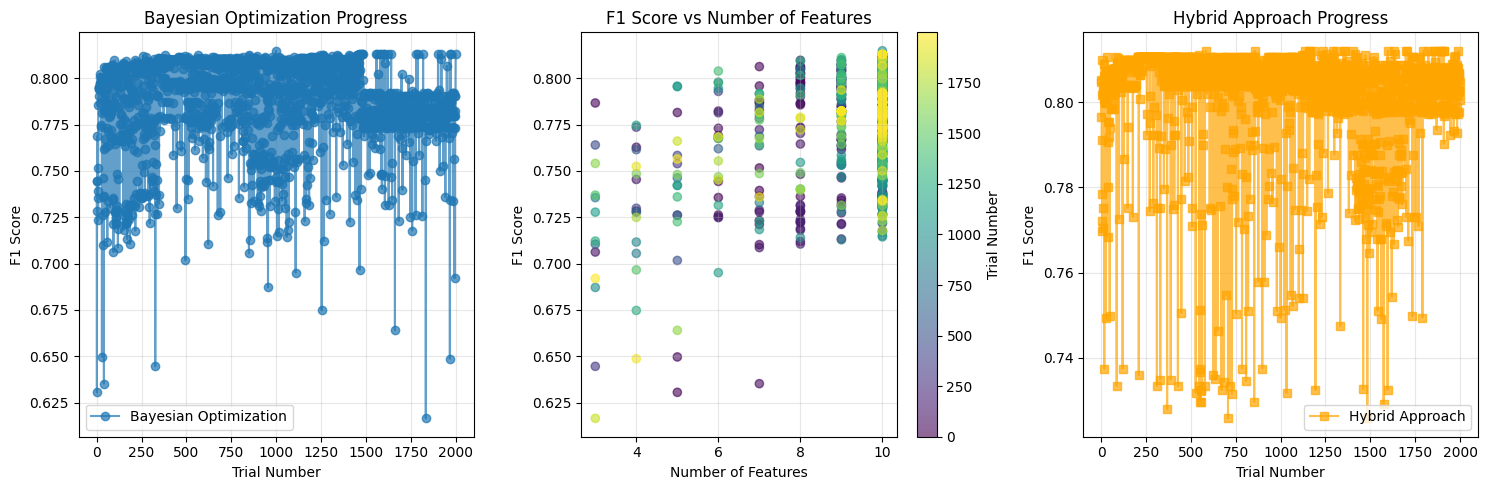


OPTIMIZATION INSIGHTS
Total trials: 2000
Best trial: 998
Convergence: Good

Most frequently selected features:
  LuxurySpend: 1668 times (83.4%)
  Deck_Side: 1624 times (81.2%)
  CryoSleep: 1598 times (79.9%)
  TotalSpend: 1572 times (78.6%)
  Cabin_Destination: 1563 times (78.1%)
  HomePlanet: 1422 times (71.1%)
  Destination: 1408 times (70.4%)
  Cabin_HomePlanet: 1348 times (67.4%)
  RoomService: 1226 times (61.3%)
  IsAlone: 1221 times (61.1%)


In [33]:
# ============================================================================
# SEGMENT 4A: Bayesian Optimization for Feature Selection - Core Functions
# ============================================================================
import optuna
import numpy as np
from itertools import combinations

n_trials_temp = 2000

def bayesian_feature_selection(X, y, model_params, min_features=3, max_features=None, n_trials=n_trials_temp):
    """
    Perform feature selection using Bayesian Optimization
    """
    all_features = X.columns.tolist()
    n_total_features = len(all_features)
    
    if max_features is None:
        max_features = n_total_features
    
    print(f"\nStarting Bayesian Optimization Feature Selection")
    print(f"Total features: {n_total_features}")
    print(f"Feature range: {min_features} to {max_features}")
    print(f"Number of trials: {n_trials}")
    
    # Store all trial results
    trial_results = []
    best_f1 = 0
    best_features = []
    
    def objective(trial):
        nonlocal best_f1, best_features, trial_results
        
        # Suggest number of features to select
        n_features = trial.suggest_int('n_features', min_features, max_features)
        
        # Suggest which features to select
        selected_indices = []
        for i, feature in enumerate(all_features):
            if trial.suggest_categorical(f'feature_{i}', [0, 1]) == 1:
                selected_indices.append(i)
        
        # Ensure we have exactly the right number of features
        if len(selected_indices) != n_features:
            # If wrong number, randomly adjust
            if len(selected_indices) < n_features:
                # Add random features
                remaining = [i for i in range(n_total_features) if i not in selected_indices]
                add_count = n_features - len(selected_indices)
                if len(remaining) >= add_count:
                    selected_indices.extend(np.random.choice(remaining, add_count, replace=False))
            else:
                # Remove random features
                selected_indices = np.random.choice(selected_indices, n_features, replace=False).tolist()
        
        # Get selected feature names
        selected_features = [all_features[i] for i in selected_indices]
        
        try:
            # Evaluate model with selected features
            f1_score, f1_std = evaluate_model(X[selected_features], y, model_params)
            
            # Store trial result
            trial_results.append({
                'trial': trial.number,
                'n_features': len(selected_features),
                'f1_score': f1_score,
                'f1_std': f1_std,
                'selected_features': selected_features.copy()
            })
            
            # Update best result
            if f1_score > best_f1:
                best_f1 = f1_score
                best_features = selected_features.copy()
            
            print(f"Trial {trial.number}: Features: {len(selected_features)}, F1: {f1_score:.4f} (+/- {f1_std:.4f})")
            
            return f1_score
            
        except Exception as e:
            print(f"Trial {trial.number} failed: {e}")
            return 0.0
    
    # Create and run study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(trial_results)
    
    return results_df, best_features, best_f1, study

def hybrid_bayesian_feature_selection(X, y, model_params, target_features=10, pre_filter_to=15, n_trials=n_trials_temp):
    """
    Hybrid approach: Use importance ranking to pre-filter, then Bayesian optimization
    """
    all_features = X.columns.tolist()
    
    print(f"\nHybrid Bayesian Feature Selection")
    print(f"Step 1: Pre-filtering from {len(all_features)} to {pre_filter_to} features using importance...")
    
    # Step 1: Get feature importance and pre-filter
    importance_df, _ = get_feature_importance(X, y, model_params)
    top_features = importance_df.head(pre_filter_to)['feature'].tolist()
    
    print(f"Top {pre_filter_to} features selected for optimization")
    
    # Step 2: Bayesian optimization on reduced space
    print(f"Step 2: Bayesian optimization to select {target_features} from {pre_filter_to} features...")
    
    trial_results = []
    best_f1 = 0
    best_features = []
    
    def objective(trial):
        nonlocal best_f1, best_features, trial_results
        
        # Select exactly target_features from top_features
        selected_features = []
        feature_choices = []
        
        for feature in top_features:
            choice = trial.suggest_categorical(f'use_{feature}', [0, 1])
            feature_choices.append(choice)
            if choice == 1:
                selected_features.append(feature)
        
        # Ensure we have exactly target_features
        if len(selected_features) != target_features:
            # Adjust selection to match target
            if len(selected_features) < target_features:
                # Add features that weren't selected
                not_selected = [f for f, c in zip(top_features, feature_choices) if c == 0]
                to_add = target_features - len(selected_features)
                if len(not_selected) >= to_add:
                    selected_features.extend(np.random.choice(not_selected, to_add, replace=False))
            else:
                # Remove random features
                selected_features = np.random.choice(selected_features, target_features, replace=False).tolist()
        
        try:
            # Evaluate model
            f1_score, f1_std = evaluate_model(X[selected_features], y, model_params)
            
            # Store result
            trial_results.append({
                'trial': trial.number,
                'n_features': len(selected_features),
                'f1_score': f1_score,
                'f1_std': f1_std,
                'selected_features': selected_features.copy()
            })
            
            if f1_score > best_f1:
                best_f1 = f1_score
                best_features = selected_features.copy()
            
            print(f"Trial {trial.number}: F1: {f1_score:.4f} (+/- {f1_std:.4f})")
            
            return f1_score
            
        except Exception as e:
            print(f"Trial {trial.number} failed: {e}")
            return 0.0
    
    # Run optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    results_df = pd.DataFrame(trial_results)
    return results_df, best_features, best_f1, study

# ============================================================================
# SEGMENT 4B: Run Feature Selection Methods
# ============================================================================

# Option 1: Full Bayesian Optimization (slower but more thorough)
print("\n" + "="*50)
print("BAYESIAN OPTIMIZATION FEATURE SELECTION")
print("="*50)

feature_selection_results, best_features, best_f1_score, study = bayesian_feature_selection(
    X_train, y_train, baseline_params, 
    min_features=3, 
    max_features=10,  # Limit max features to avoid overfitting
    n_trials=n_trials_temp      # Adjust based on time budget
)

print(f"\nBest F1 Score: {best_f1_score:.4f}")
print(f"Optimal number of features: {len(best_features)}")
print(f"Selected features: {best_features}")

# Option 2: Hybrid approach (recommended - faster and often better)
print("\n" + "="*50)
print("HYBRID BAYESIAN FEATURE SELECTION")
print("="*50)

hybrid_results, hybrid_best_features, hybrid_best_f1, hybrid_study = hybrid_bayesian_feature_selection(
    X_train, y_train, baseline_params,
    target_features=10,  # ADJUST THIS NUMBER
    pre_filter_to=15,    # Pre-filter to top 15 features
    n_trials=n_trials_temp       # Fewer trials needed due to smaller search space
)

print(f"\nHybrid Best F1 Score: {hybrid_best_f1:.4f}")
print(f"Selected features: {hybrid_best_features}")

# ============================================================================
# SEGMENT 4C: Visualize Feature Selection Results
# ============================================================================

# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: F1 score over trials
plt.subplot(1, 3, 1)
plt.plot(feature_selection_results['trial'], feature_selection_results['f1_score'], 
         marker='o', alpha=0.7, label='Bayesian Optimization')
plt.xlabel('Trial Number')
plt.ylabel('F1 Score')
plt.title('Bayesian Optimization Progress')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: F1 score vs number of features
plt.subplot(1, 3, 2)
plt.scatter(feature_selection_results['n_features'], feature_selection_results['f1_score'], 
           alpha=0.6, c=feature_selection_results['trial'], cmap='viridis')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Features')
plt.colorbar(label='Trial Number')
plt.grid(True, alpha=0.3)

# Plot 3: Optimization history
plt.subplot(1, 3, 3)
if 'hybrid_results' in locals():
    plt.plot(hybrid_results['trial'], hybrid_results['f1_score'], 
             marker='s', alpha=0.7, label='Hybrid Approach', color='orange')
plt.xlabel('Trial Number')
plt.ylabel('F1 Score')
plt.title('Hybrid Approach Progress')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# ============================================================================
# SEGMENT 4D: Feature Selection Analysis
# ============================================================================

# Print optimization insights
print("\n" + "="*50)
print("OPTIMIZATION INSIGHTS")
print("="*50)
print(f"Total trials: {len(feature_selection_results)}")
print(f"Best trial: {feature_selection_results.loc[feature_selection_results['f1_score'].idxmax(), 'trial']}")
print(f"Convergence: {'Good' if best_f1_score > feature_selection_results['f1_score'].iloc[0] else 'Poor'}")

# Feature selection frequency analysis
if len(feature_selection_results) > 0:
    feature_frequency = {}
    for _, row in feature_selection_results.iterrows():
        for feature in row['selected_features']:
            feature_frequency[feature] = feature_frequency.get(feature, 0) + 1
    
    print("\nMost frequently selected features:")
    sorted_features = sorted(feature_frequency.items(), key=lambda x: x[1], reverse=True)
    for feature, count in sorted_features[:10]:
        percentage = (count / len(feature_selection_results)) * 100
        print(f"  {feature}: {count} times ({percentage:.1f}%)")


SELECTING TOP FEATURE COMBINATIONS FOR HYPERPARAMETER TUNING
✓ Added 2 combinations from Full Bayesian method
✓ Added 2 combinations from Hybrid Bayesian method

📋 Selected 3 unique feature combinations:
  1. Full_Bayesian (Trial 998): 10 features, F1: 0.8149
     Features: ['RoomService', 'TotalSpend', 'Deck_Side', 'Cabin_Destination', 'HomePlanet', 'VRDeck', 'Destination', 'LuxurySpend', 'Cabin_HomePlanet', 'Cabin_CryoSleep']
  2. Full_Bayesian (Trial 1463): 10 features, F1: 0.8129
     Features: ['HomePlanet', 'CryoSleep', 'Destination', 'IsAlone', 'TotalSpend', 'LuxurySpend', 'Cabin_HomePlanet', 'Cabin_Destination', 'Deck_Side', 'RoomService']
  3. Hybrid_Bayesian (Trial 584): 10 features, F1: 0.8121
     Features: ['CryoSleep', 'HomePlanet', 'LuxurySpend', 'RoomService', 'Deck_Side', 'Side', 'TotalSpend', 'Destination', np.str_('Deck'), np.str_('Cabin_HomePlanet')]

HYPERPARAMETER TUNING EXECUTION

[1/3] Optimizing Full_Bayesian_Trial998...
  📊 Features (10): ['RoomService', 'Tot

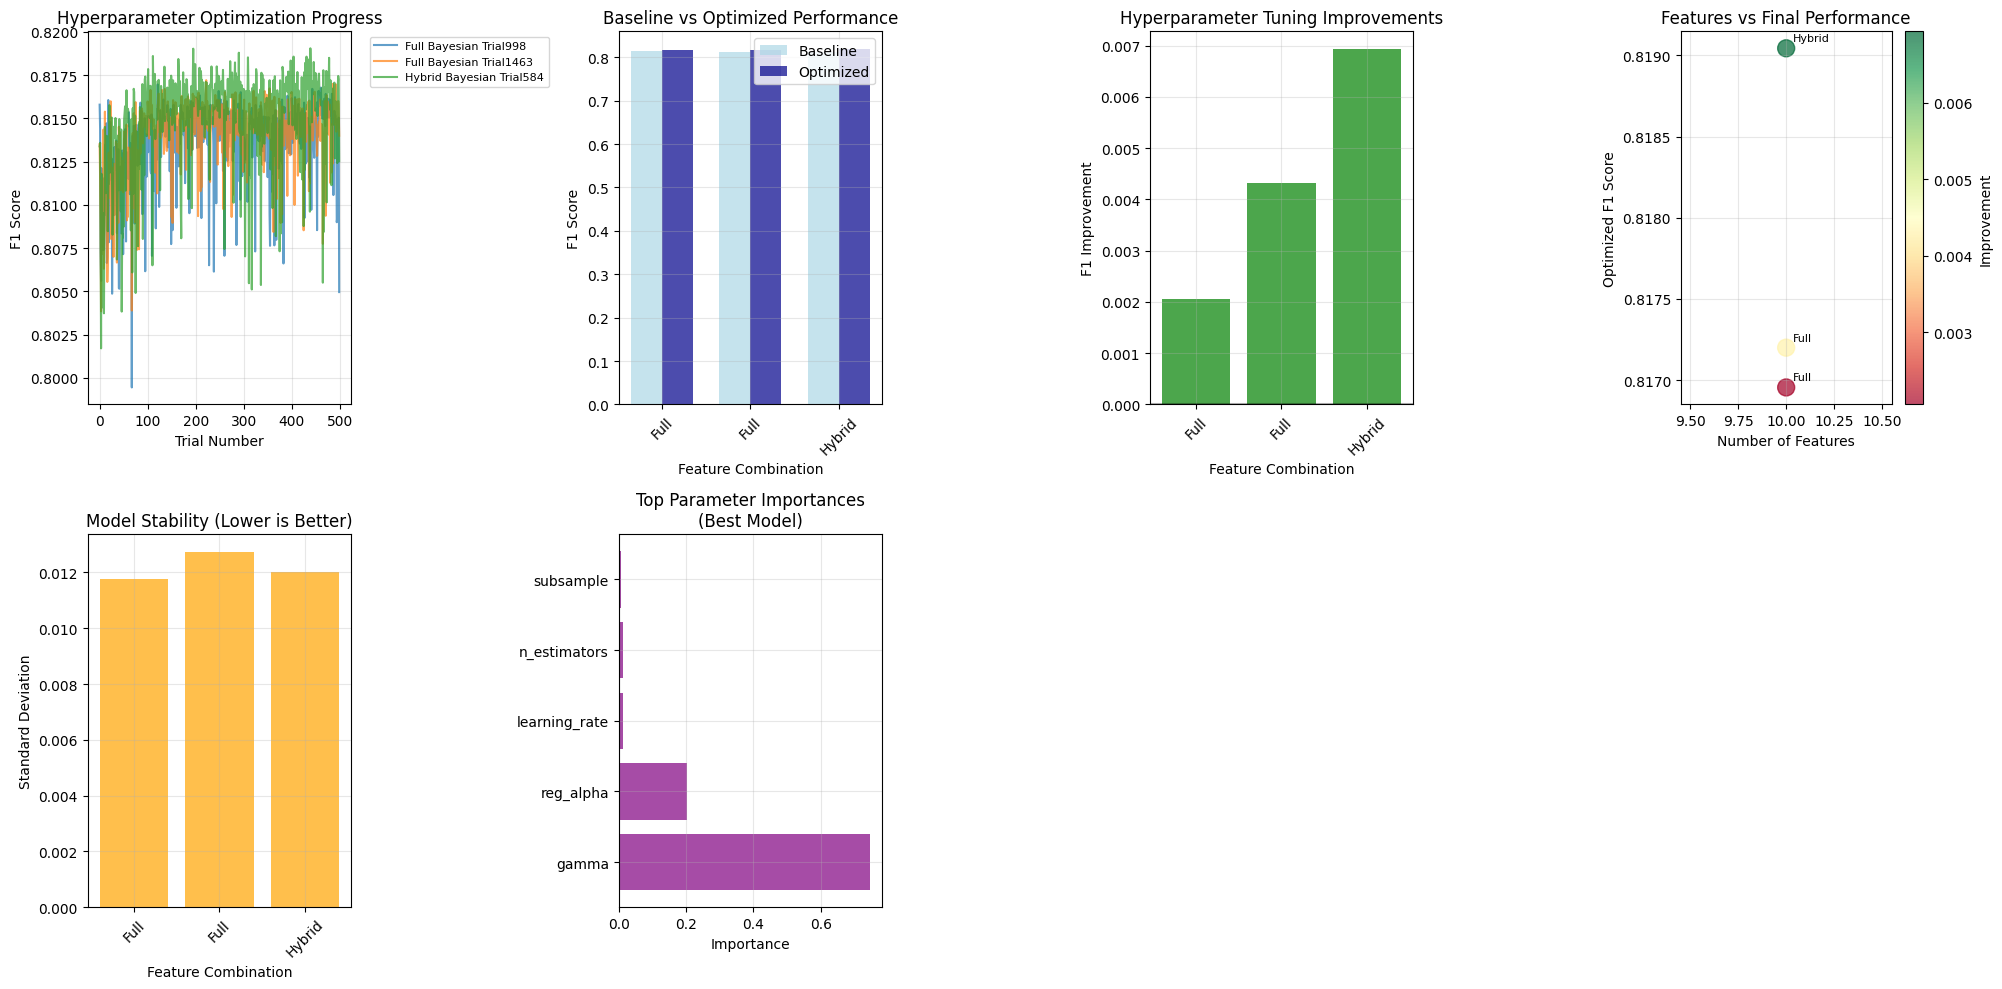

✅ Visualizations created successfully!


In [34]:
# ============================================================================
# SEGMENT 4E: Hyperparameter Tuning Setup Functions
# ============================================================================
import functools

def create_objective_function(X_features, y_target):
    """Create Optuna objective function for specific feature set"""
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': -1,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.8, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 10)
        }
        
        f1_mean, _ = evaluate_model(X_features, y_target, params, cv_folds=5)
        return f1_mean
    
    return objective

def progress_callback(study, trial, total_trials):
    completed = len(study.trials)
    print(f"\r    Trials completed: {completed}/{total_trials}", end="")

def get_top_feature_combinations(results_df, top_n=2):
    """Get top N feature combinations from results"""
    top_results = results_df.nlargest(top_n, 'f1_score')
    
    combinations = []
    for idx, row in top_results.iterrows():
        combinations.append({
            'source': 'results',
            'rank': len(combinations) + 1,
            'features': row['selected_features'],
            'n_features': row['n_features'],
            'baseline_f1': row['f1_score'],
            'baseline_std': row['f1_std'],
            'trial': row['trial']
        })
    
    return combinations

# ============================================================================
# SEGMENT 4F: Select Top Feature Combinations for Hyperparameter Tuning
# ============================================================================

print(f"\n" + "="*60)
print("SELECTING TOP FEATURE COMBINATIONS FOR HYPERPARAMETER TUNING")
print("="*60)

# Collect all top feature combinations
all_combinations = []

# Get top 2 from Option 1 (Full Bayesian)
if 'feature_selection_results' in locals() and not feature_selection_results.empty:
    top_full = get_top_feature_combinations(feature_selection_results, top_n=2)
    for combo in top_full:
        combo['source'] = 'Full_Bayesian'
    all_combinations.extend(top_full)
    print(f"✓ Added {len(top_full)} combinations from Full Bayesian method")

# Get top 2 from Option 2 (Hybrid)
if 'hybrid_results' in locals() and not hybrid_results.empty:
    top_hybrid = get_top_feature_combinations(hybrid_results, top_n=2)
    for combo in top_hybrid:
        combo['source'] = 'Hybrid_Bayesian'
    all_combinations.extend(top_hybrid)
    print(f"✓ Added {len(top_hybrid)} combinations from Hybrid Bayesian method")

# Remove duplicates based on feature sets
unique_combinations = []
seen_feature_sets = set()

for combo in all_combinations:
    feature_tuple = tuple(sorted(combo['features']))
    if feature_tuple not in seen_feature_sets:
        seen_feature_sets.add(feature_tuple)
        unique_combinations.append(combo)

print(f"\n📋 Selected {len(unique_combinations)} unique feature combinations:")
for i, combo in enumerate(unique_combinations, 1):
    print(f"  {i}. {combo['source']} (Trial {combo['trial']}): {combo['n_features']} features, F1: {combo['baseline_f1']:.4f}")
    print(f"     Features: {combo['features']}")

# ============================================================================
# SEGMENT 4G: Run Hyperparameter Tuning
# ============================================================================

print(f"\n" + "="*60)
print("HYPERPARAMETER TUNING EXECUTION")
print("="*60)

optimization_results = {}
n_trials_per_combo = 500  # ← ADJUST THIS NUMBER

for i, combo in enumerate(unique_combinations, 1):
    combo_key = f"{combo['source']}_Trial{combo['trial']}"
    features = combo['features']
    baseline_f1 = combo['baseline_f1']
    
    print(f"\n[{i}/{len(unique_combinations)}] Optimizing {combo_key}...")
    print(f"  📊 Features ({len(features)}): {features}")
    print(f"  📈 Baseline F1: {baseline_f1:.4f}")
    print(f"  🔄 Running {n_trials_per_combo} hyperparameter optimization trials...")
    
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner()
    )
    
    # Create objective function
    objective_func = create_objective_function(X_train[features], y_train)
    
    # Run optimization with progress callback
    progress_cb = functools.partial(progress_callback, total_trials=n_trials_per_combo)
    study.optimize(objective_func, n_trials=n_trials_per_combo, show_progress_bar=False, callbacks=[progress_cb])
    
    print()  # New line after progress
    
    # Get results
    best_params = study.best_params.copy()
    best_params.update({
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1
    })
    
    optimized_f1 = study.best_value
    _, optimized_std = evaluate_model(X_train[features], y_train, best_params)
    improvement = optimized_f1 - baseline_f1
    
    print(f"  ✅ Optimized F1: {optimized_f1:.4f} (+/- {optimized_std:.4f})")
    print(f"  📈 Improvement: +{improvement:.4f}")
    print(f"  🏆 Best trial: {study.best_trial.number}")
    
    # Store results
    optimization_results[combo_key] = {
        'source': combo['source'],
        'features': features,
        'n_features': len(features),
        'baseline_f1': baseline_f1,
        'optimized_f1': optimized_f1,
        'optimized_std': optimized_std,
        'improvement': improvement,
        'best_params': best_params,
        'study': study,
        'original_trial': combo['trial']
    }

# ============================================================================
# SEGMENT 4H: Compare Hyperparameter Optimization Results
# ============================================================================

print(f"\n" + "="*60)
print("HYPERPARAMETER OPTIMIZATION RESULTS COMPARISON")
print("="*60)

# Create comparison table
comparison_data = []
for combo_key, results in optimization_results.items():
    comparison_data.append({
        'Combination': combo_key,
        'Source': results['source'],
        'Features': results['n_features'],
        'Baseline_F1': results['baseline_f1'],
        'Optimized_F1': results['optimized_f1'],
        'Improvement': results['improvement'],
        'Std_Dev': results['optimized_std']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Optimized_F1', ascending=False)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Find the best model
best_combo_key = comparison_df.iloc[0]['Combination']
best_model_results = optimization_results[best_combo_key]

print(f"\n🏆 BEST OPTIMIZED MODEL:")
print(f"   Source: {best_model_results['source']}")
print(f"   Features ({best_model_results['n_features']}): {best_model_results['features']}")
print(f"   Baseline F1: {best_model_results['baseline_f1']:.4f}")
print(f"   Optimized F1: {best_model_results['optimized_f1']:.4f}")
print(f"   Total Improvement: +{best_model_results['improvement']:.4f}")
print(f"   Best hyperparameters:")
for param, value in best_model_results['best_params'].items():
    if param not in ['objective', 'eval_metric', 'random_state', 'n_jobs']:
        print(f"     {param}: {value}")

# ============================================================================
# SEGMENT 4I: Visualization of Optimization Results
# ============================================================================

print(f"\n" + "="*60)
print("CREATING OPTIMIZATION VISUALIZATIONS")
print("="*60)

plt.figure(figsize=(20, 10))

# Plot 1: Hyperparameter optimization progress
plt.subplot(2, 4, 1)
for combo_key, results in optimization_results.items():
    study = results['study']
    trial_values = [trial.value for trial in study.trials if trial.value is not None]
    plt.plot(trial_values, alpha=0.7, label=combo_key.replace('_', ' '))
plt.xlabel('Trial Number')
plt.ylabel('F1 Score')
plt.title('Hyperparameter Optimization Progress')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)

# Plot 2: Before vs After comparison
plt.subplot(2, 4, 2)
combo_names = list(optimization_results.keys())
baseline_scores = [results['baseline_f1'] for results in optimization_results.values()]
optimized_scores = [results['optimized_f1'] for results in optimization_results.values()]

x = range(len(combo_names))
width = 0.35
plt.bar([i - width/2 for i in x], baseline_scores, width, label='Baseline', alpha=0.7, color='lightblue')
plt.bar([i + width/2 for i in x], optimized_scores, width, label='Optimized', alpha=0.7, color='darkblue')

plt.xlabel('Feature Combination')
plt.ylabel('F1 Score')
plt.title('Baseline vs Optimized Performance')
plt.xticks(x, [name.split('_')[0] for name in combo_names], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Improvement amounts
plt.subplot(2, 4, 3)
improvements = [results['improvement'] for results in optimization_results.values()]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
plt.bar(range(len(improvements)), improvements, color=colors, alpha=0.7)
plt.xlabel('Feature Combination')
plt.ylabel('F1 Improvement')
plt.title('Hyperparameter Tuning Improvements')
plt.xticks(range(len(combo_names)), [name.split('_')[0] for name in combo_names], rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Plot 4: Feature count vs performance
plt.subplot(2, 4, 4)
feature_counts = [results['n_features'] for results in optimization_results.values()]
plt.scatter(feature_counts, optimized_scores, s=150, alpha=0.7, c=improvements, cmap='RdYlGn')
plt.colorbar(label='Improvement')
for i, combo in enumerate(combo_names):
    plt.annotate(combo.split('_')[0], (feature_counts[i], optimized_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Number of Features')
plt.ylabel('Optimized F1 Score')
plt.title('Features vs Final Performance')
plt.grid(True, alpha=0.3)

# Plot 5: Standard deviation comparison
plt.subplot(2, 4, 5)
std_devs = [results['optimized_std'] for results in optimization_results.values()]
plt.bar(range(len(std_devs)), std_devs, alpha=0.7, color='orange')
plt.xlabel('Feature Combination')
plt.ylabel('Standard Deviation')
plt.title('Model Stability (Lower is Better)')
plt.xticks(range(len(combo_names)), [name.split('_')[0] for name in combo_names], rotation=45)
plt.grid(True, alpha=0.3)

# Plot 6: Hyperparameter distribution for best model
plt.subplot(2, 4, 6)
best_study = best_model_results['study']
param_importance = optuna.importance.get_param_importances(best_study)
if param_importance:
    params = list(param_importance.keys())[:5]  # Top 5 most important
    importances = [param_importance[p] for p in params]
    plt.barh(params, importances, alpha=0.7, color='purple')
    plt.xlabel('Importance')
    plt.title('Top Parameter Importances\n(Best Model)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizations created successfully!")

In [37]:
# ============================================================================
# SEGMENT 4J: Train Final Models and Create Submissions
# ============================================================================

print(f"\n" + "="*60)
print("TRAINING FINAL MODELS & CREATING SUBMISSIONS")
print("="*60)

submission_files = []

for i, (combo_key, results) in enumerate(optimization_results.items(), 1):
    print(f"\n[{i}/{len(optimization_results)}] Training {combo_key}...")
    
    features = results['features']
    params = results['best_params']
    expected_f1 = results['optimized_f1']
    source = results['source']
    
    print(f"  📊 Source: {source}")
    print(f"  🎯 Features ({len(features)}): {features}")
    print(f"  📈 Expected F1: {expected_f1:.4f}")
    
    # Safety check for feature alignment
    missing_features = [f for f in features if f not in X_test.columns]
    if missing_features:
        print(f"   ❌ ERROR: Missing features in test set: {missing_features}")
        print(f"   ⚠️  Skipping this model...")
        continue
    
    extra_features = [f for f in X_test.columns if f not in X_train.columns]
    if extra_features:
        print(f"   ⚠️  WARNING: Test set has extra features: {extra_features[:3]}{'...' if len(extra_features) > 3 else ''}")
    
    print(f"   ✅ Feature alignment verified ({len(features)} features match)")
    
    # Train final model on full training data
    print(f"   🔄 Training final model...")
    final_model = XGBClassifier(**params)
    final_model.fit(X_train[features], y_train)
    
    # Make predictions on test set
    print(f"   🔮 Making predictions...")
    test_predictions = final_model.predict(X_test[features])
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Transported': test_predictions.astype(bool)
    })
    
    # Save submission file
    filename = f'submission_{combo_key}_F1{expected_f1:.3f}.csv'
    submission.to_csv(filename, index=False)
    submission_files.append(filename)
    
    # Show prediction statistics
    pred_dist = submission['Transported'].value_counts()
    pred_ratio = pred_dist[True] / (pred_dist[True] + pred_dist[False]) * 100
    
    print(f"   💾 Saved: {filename}")
    print(f"   📊 Predictions: {pred_dist[True]} True ({pred_ratio:.1f}%), {pred_dist[False]} False ({100-pred_ratio:.1f}%)")
    print(f"   🎯 Expected Performance: F1 = {expected_f1:.4f}")

# ============================================================================
# SEGMENT 4K: Create Best Model Submission
# ============================================================================

print(f"\n" + "="*60)
print("CREATING BEST MODEL SUBMISSION")
print("="*60)

# Train and predict with the best model
best_filename = f'submission_BEST_{best_combo_key}.csv'
best_features = best_model_results['features']
best_params = best_model_results['best_params']

print(f"🏆 Training BEST model: {best_combo_key}")
print(f"📊 Source: {best_model_results['source']}")
print(f"🎯 Features ({len(best_features)}): {best_features}")
print(f"📈 Expected F1: {best_model_results['optimized_f1']:.4f}")
print(f"⚡ Improvement over baseline: +{best_model_results['improvement']:.4f}")

# Train best model
best_model = XGBClassifier(**best_params)
best_model.fit(X_train[best_features], y_train)

# Make predictions
best_predictions = best_model.predict(X_test[best_features])

# Create best submission
best_submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': best_predictions.astype(bool)
})
best_submission.to_csv(best_filename, index=False)

# Show best model statistics
best_pred_dist = best_submission['Transported'].value_counts()
best_pred_ratio = best_pred_dist[True] / (best_pred_dist[True] + best_pred_dist[False]) * 100

print(f"💾 Saved: {best_filename}")


TRAINING FINAL MODELS & CREATING SUBMISSIONS

[1/3] Training Full_Bayesian_Trial998...
  📊 Source: Full_Bayesian
  🎯 Features (10): ['RoomService', 'TotalSpend', 'Deck_Side', 'Cabin_Destination', 'HomePlanet', 'VRDeck', 'Destination', 'LuxurySpend', 'Cabin_HomePlanet', 'Cabin_CryoSleep']
  📈 Expected F1: 0.8170
   ✅ Feature alignment verified (10 features match)
   🔄 Training final model...
   🔮 Making predictions...
   💾 Saved: submission_Full_Bayesian_Trial998_F10.817.csv
   📊 Predictions: 2293 True (53.6%), 1984 False (46.4%)
   🎯 Expected Performance: F1 = 0.8170

[2/3] Training Full_Bayesian_Trial1463...
  📊 Source: Full_Bayesian
  🎯 Features (10): ['HomePlanet', 'CryoSleep', 'Destination', 'IsAlone', 'TotalSpend', 'LuxurySpend', 'Cabin_HomePlanet', 'Cabin_Destination', 'Deck_Side', 'RoomService']
  📈 Expected F1: 0.8172
   ✅ Feature alignment verified (10 features match)
   🔄 Training final model...
   🔮 Making predictions...
   💾 Saved: submission_Full_Bayesian_Trial1463_F10.81

In [47]:
# ============================================================================
# SEGMENT 4J: Train Final Models and Create Submissions
# ============================================================================
from sklearn.metrics import f1_score
import numpy as np

# ============================================================================
# THRESHOLD CONFIGURATION - ADJUST THESE SETTINGS
# ============================================================================

# Option 1: Use automatic threshold optimization
USE_AUTO_THRESHOLD = False  # Set to False to use manual threshold

# Option 2: Set manual threshold (only used if USE_AUTO_THRESHOLD = False)
MANUAL_THRESHOLD = 0.53  # ← CHANGE THIS NUMBER if using manual threshold

# Option 3: Threshold search range (only used if USE_AUTO_THRESHOLD = True)
THRESHOLD_MIN = 0.3      # Minimum threshold to test
THRESHOLD_MAX = 0.8      # Maximum threshold to test
THRESHOLD_STEP = 0.01    # Step size for threshold search

print(f"\n📋 THRESHOLD CONFIGURATION:")
if USE_AUTO_THRESHOLD:
    print(f"   🤖 Mode: Automatic optimization")
    print(f"   🔍 Search range: {THRESHOLD_MIN} to {THRESHOLD_MAX} (step: {THRESHOLD_STEP})")
else:
    print(f"   ✋ Mode: Manual threshold")
    print(f"   ⚖️  Fixed threshold: {MANUAL_THRESHOLD}")

print(f"\n" + "="*60)
print("TRAINING FINAL MODELS & CREATING SUBMISSIONS")
print("="*60)

submission_files = []

for i, (combo_key, results) in enumerate(optimization_results.items(), 1):
    print(f"\n[{i}/{len(optimization_results)}] Training {combo_key}...")
    
    features = results['features']
    params = results['best_params']
    expected_f1 = results['optimized_f1']
    source = results['source']
    
    print(f"  📊 Source: {source}")
    print(f"  🎯 Features ({len(features)}): {features}")
    print(f"  📈 Expected F1: {expected_f1:.4f}")
    
    # Safety check for feature alignment
    missing_features = [f for f in features if f not in X_test.columns]
    if missing_features:
        print(f"   ❌ ERROR: Missing features in test set: {missing_features}")
        print(f"   ⚠️  Skipping this model...")
        continue
    
    extra_features = [f for f in X_test.columns if f not in X_train.columns]
    if extra_features:
        print(f"   ⚠️  WARNING: Test set has extra features: {extra_features[:3]}{'...' if len(extra_features) > 3 else ''}")
    
    print(f"   ✅ Feature alignment verified ({len(features)} features match)")
    
    # Train final model on full training data
    print(f"   🔄 Training final model...")
    final_model = XGBClassifier(**params)
    final_model.fit(X_train[features], y_train)
    
    # Make predictions on test set with threshold optimization
    print(f"   🔮 Making predictions...")
    
    # Get prediction probabilities
    test_probabilities = final_model.predict_proba(X_test[features])[:, 1]
    
    if USE_AUTO_THRESHOLD:
        # Find optimal threshold using validation set
        print(f"   ⚖️  Finding optimal threshold...")
        val_probabilities = final_model.predict_proba(X_train[features])[:, 1]
        
        # Test different thresholds
        thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX, THRESHOLD_STEP)
        best_threshold = 0.5
        best_val_f1 = 0
        
        for threshold in thresholds:
            val_predictions = (val_probabilities >= threshold).astype(int)
            val_f1 = f1_score(y_train, val_predictions)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_threshold = threshold
        
        print(f"   📊 Optimal threshold found: {best_threshold:.3f} (F1: {best_val_f1:.4f})")
        threshold_mode = "AUTO"
    else:
        # Use manual threshold
        best_threshold = MANUAL_THRESHOLD
        print(f"   ✋ Using manual threshold: {best_threshold:.3f}")
        threshold_mode = "MANUAL"
    
    # Apply threshold to test predictions
    test_predictions = (test_probabilities >= best_threshold).astype(int)
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Transported': test_predictions.astype(bool)
    })
    
    # Save submission file with threshold in filename
    filename = f'submission_{combo_key}_F1{expected_f1:.3f}_T{best_threshold:.3f}_{threshold_mode}.csv'
    submission.to_csv(filename, index=False)
    submission_files.append(filename)
    
    # Show prediction statistics
    pred_dist = submission['Transported'].value_counts()
    pred_ratio = pred_dist[True] / (pred_dist[True] + pred_dist[False]) * 100
    
    print(f"   💾 Saved: {filename}")
    print(f"   ⚖️  Used threshold: {best_threshold:.3f} ({threshold_mode})")
    print(f"   📊 Predictions: {pred_dist[True]} True ({pred_ratio:.1f}%), {pred_dist[False]} False ({100-pred_ratio:.1f}%)")
    print(f"   🎯 Expected Performance: F1 = {expected_f1:.4f}")
    
    # Store threshold info for later use
    optimization_results[combo_key]['optimal_threshold'] = best_threshold
    optimization_results[combo_key]['threshold_mode'] = threshold_mode
    if USE_AUTO_THRESHOLD:
        optimization_results[combo_key]['threshold_f1'] = best_val_f1

# ============================================================================
# SEGMENT 4K: Create Best Model Submission
# ============================================================================

print(f"\n" + "="*60)
print("CREATING BEST MODEL SUBMISSION")
print("="*60)

# Train and predict with the best model
best_filename = f'submission_BEST_{best_combo_key}_T{best_overall_threshold:.3f}.csv'
best_features = best_model_results['features']
best_params = best_model_results['best_params']

print(f"🏆 Training BEST model: {best_combo_key}")
print(f"📊 Source: {best_model_results['source']}")
print(f"🎯 Features ({len(best_features)}): {best_features}")
print(f"📈 Expected F1: {best_model_results['optimized_f1']:.4f}")
print(f"⚡ Improvement over baseline: +{best_model_results['improvement']:.4f}")

# Train best model
best_model = XGBClassifier(**best_params)
best_model.fit(X_train[best_features], y_train)

# Find optimal threshold for best model
print(f"🔍 Optimizing threshold for best model...")
best_val_probabilities = best_model.predict_proba(X_train[best_features])[:, 1]

thresholds = np.arange(0.3, 0.8, 0.01)
best_overall_threshold = 0.5
best_overall_f1 = 0

for threshold in thresholds:
    val_predictions = (best_val_probabilities >= threshold).astype(int)
    val_f1 = f1_score(y_train, val_predictions)
    if val_f1 > best_overall_f1:
        best_overall_f1 = val_f1
        best_overall_threshold = threshold

print(f"⚖️  Best model optimal threshold: {best_overall_threshold:.3f} (F1: {best_overall_f1:.4f})")

# Make predictions with optimal threshold
best_test_probabilities = best_model.predict_proba(X_test[best_features])[:, 1]
best_predictions = (best_test_probabilities >= best_overall_threshold).astype(int)

# Create best submission
best_submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': best_predictions.astype(bool)
})
best_submission.to_csv(best_filename, index=False)

# Show best model statistics  
best_pred_dist = best_submission['Transported'].value_counts()
best_pred_ratio = best_pred_dist[True] / (best_pred_dist[True] + best_pred_dist[False]) * 100

print(f"💾 Saved: {best_filename}")
print(f"📊 Predictions: {best_pred_dist[True]} True ({best_pred_ratio:.1f}%), {best_pred_dist[False]} False ({100-best_pred_ratio:.1f}%)")
print(f"🎯 Expected Performance: F1 = {best_model_results['optimized_f1']:.4f}")

if USE_AUTO_THRESHOLD:
    print(f"📈 Threshold optimization improved F1 by: +{best_overall_f1 - best_model_results['optimized_f1']:.4f}")
else:
    print(f"✋ Used manual threshold: {MANUAL_THRESHOLD}")

# ============================================================================
# SEGMENT 4L: Summary of All Submissions
# ============================================================================

print(f"\n" + "="*60)
print("SUBMISSION FILES SUMMARY")
print("="*60)

print(f"📁 Total submission files created: {len(submission_files) + 1}")
print(f"⚖️  Threshold mode: {'Automatic Optimization' if USE_AUTO_THRESHOLD else f'Manual ({MANUAL_THRESHOLD})'}")

print(f"\n📋 All submission files:")
for i, filename in enumerate(submission_files, 1):
    print(f"  {i}. {filename}")

print(f"  🏆 BEST: {best_filename}")

print(f"\n💡 To change threshold settings:")
print(f"   - Set USE_AUTO_THRESHOLD = False for manual control")
print(f"   - Adjust MANUAL_THRESHOLD = 0.51 (or any value you want)")
print(f"   - Modify THRESHOLD_MIN/MAX/STEP for auto optimization range")


📋 THRESHOLD CONFIGURATION:
   ✋ Mode: Manual threshold
   ⚖️  Fixed threshold: 0.53

TRAINING FINAL MODELS & CREATING SUBMISSIONS

[1/3] Training Full_Bayesian_Trial998...
  📊 Source: Full_Bayesian
  🎯 Features (10): ['RoomService', 'TotalSpend', 'Deck_Side', 'Cabin_Destination', 'HomePlanet', 'VRDeck', 'Destination', 'LuxurySpend', 'Cabin_HomePlanet', 'Cabin_CryoSleep']
  📈 Expected F1: 0.8170
   ✅ Feature alignment verified (10 features match)
   🔄 Training final model...
   🔮 Making predictions...
   ✋ Using manual threshold: 0.530
   💾 Saved: submission_Full_Bayesian_Trial998_F10.817_T0.530_MANUAL.csv
   ⚖️  Used threshold: 0.530 (MANUAL)
   📊 Predictions: 2232 True (52.2%), 2045 False (47.8%)
   🎯 Expected Performance: F1 = 0.8170

[2/3] Training Full_Bayesian_Trial1463...
  📊 Source: Full_Bayesian
  🎯 Features (10): ['HomePlanet', 'CryoSleep', 'Destination', 'IsAlone', 'TotalSpend', 'LuxurySpend', 'Cabin_HomePlanet', 'Cabin_Destination', 'Deck_Side', 'RoomService']
  📈 Expected 